# Transcription Factor Project - QC Testing
**Robin Anwyl, UCSD Subramaniam Lab**

**Goal:** Analyze the hiPSC Perturb-seq dataset from the Mali lab (Nourreddine et al 2023 preprint) to investigate the effects of transcription factor knockouts (TF KDs)

**Guiding Questions:** What do TF KD effects reveal about:
* … the transcription regulatory network of hiPSCs, and TF crosstalk?
* … cell lineage?
* … how TFs influence chromatin remodeling?

# Import statements

Using psp_env virtual environment

In [3]:
import sys
import os
psp_root = "/home/ranwyl/KOLF2.1J_Perturbation_Cell_Atlas/"
if psp_root not in sys.path:
    sys.path.insert(0, psp_root)

import psp
import gc
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'

# Fall 2025 Week 4

## Testing no normalization vs. median normalization before Isolation Forest

Compare dataset with no normalization before `scrub_ntc_cells()` to dataset with normalization before `scrub_ntc_cells()`

In [2]:
adata_no_norm_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_NTC_Filtered.h5ad"
adata_no_norm = psp.utils.read_anndata(adata_no_norm_filepath)
adata_no_norm

AnnData object with n_obs × n_vars = 411560 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'batch', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [3]:
adata_no_norm.obs.perturbed.value_counts()

perturbed
True     397862
False     13698
Name: count, dtype: int64

In [4]:
adata_norm_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_IFnorm_NTC_Filtered.h5ad"
adata_norm = psp.utils.read_anndata(adata_norm_filepath)
adata_norm

AnnData object with n_obs × n_vars = 411536 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'batch', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [5]:
adata_norm.obs.perturbed.value_counts()

perturbed
True     397862
False     13674
Name: count, dtype: int64

In [6]:
adata_norm_ntc_cells = adata_norm[adata_norm.obs.gene_target == "NTC"].obs.index.tolist()
print(adata_norm_ntc_cells[:3])
print(len(adata_norm_ntc_cells))
adata_norm_ntc_cells = set(adata_norm_ntc_cells)

['AAACGAACAAAGCGTG-1', 'AAAGAACAGAGGTGCT-1', 'AAAGAACCAAAGGCAC-1']
13674


In [7]:
adata_no_norm_ntc_cells = adata_no_norm[adata_no_norm.obs.gene_target == "NTC"].obs.index.tolist()
print(adata_no_norm_ntc_cells[:3])
print(len(adata_no_norm_ntc_cells))
adata_no_norm_ntc_cells = set(adata_no_norm_ntc_cells)

['AAACGCTTCTCTTGCG-1', 'AAAGAACAGAGGTGCT-1', 'AACAAAGCAATCAAGA-1']
13698


In [8]:
print(len(adata_norm_ntc_cells - adata_no_norm_ntc_cells))
print(len(adata_no_norm_ntc_cells - adata_norm_ntc_cells))
print(len(adata_norm_ntc_cells & adata_no_norm_ntc_cells))

3803
3827
9871


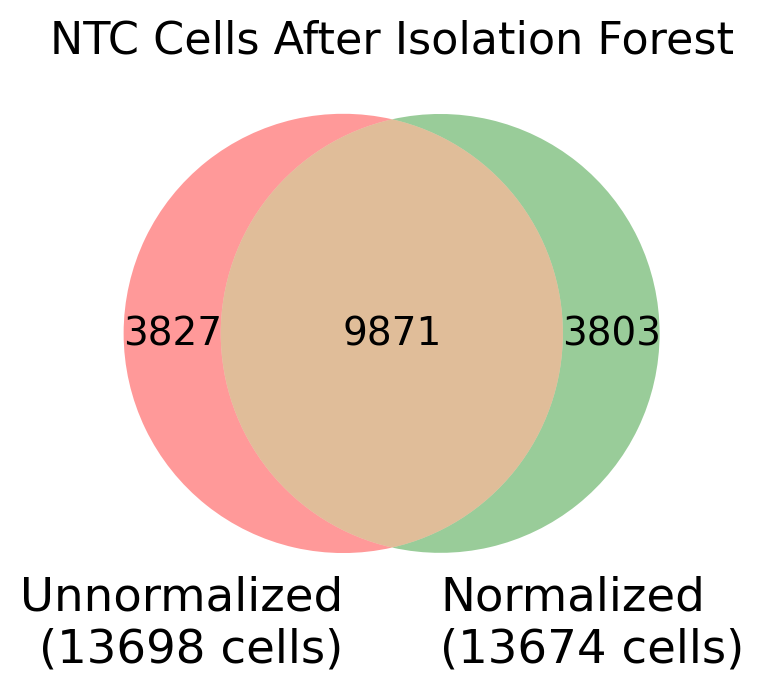

In [11]:
from matplotlib_venn import venn2

def plot_venn2(set1, set2, label1, label2, title=None, color1="red", color2="green"):
    plt.rcParams['font.size'] = 14
    n_items1, n_items2 = len(set1), len(set2)
    n_shared = len([g for g in set2 if g in set1])
    left = n_items1 - n_shared
    right = n_items2 - n_shared
    venn2(subsets = (left, right, n_shared), 
        set_labels = (label1, label2),
        set_colors = (color1, color2),
        alpha=0.4)
    if title:
        plt.title(title, fontsize=16)
    plt.show()

plot_venn2(adata_no_norm_ntc_cells, adata_norm_ntc_cells, 
           "Unnormalized\n(13698 cells)", "Normalized\n(13674 cells)", 
           "NTC Cells After Isolation Forest")

In [2]:
import scanpy as sc

adata_pre_etest_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_Knockdown_Filtered.h5ad"
adata_unnorm_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_Knockdown_Energy_Test_Filtered.h5ad"
adata_norm_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_IFnorm_Knockdown_Energy_Test_Computed.h5ad"

adata_pre_etest = sc.read_h5ad(adata_pre_etest_filepath, backed="r")
adata_unnorm = sc.read_h5ad(adata_unnorm_filepath, backed="r")
adata_norm_unfiltered = sc.read_h5ad(adata_norm_filepath)
adata_norm = adata_norm_unfiltered[
    (adata_norm_unfiltered.obs.perturbed == "False") | 
    (adata_norm_unfiltered.obs.perturbation_significant == True)
].copy()
del adata_norm_unfiltered
gc.collect()

37546

In [11]:
def print_stats(adata):
    print(f"# perturbed cells: {adata[adata.obs.perturbed == 'True'].shape[0]}")
    print(f"# gene targets: {len(adata.obs.gene_target.unique().tolist()) - 1}")
    print(f"# gRNA: {len(adata[adata.obs.perturbed == 'True'].obs.gRNA.unique().tolist())}")

In [12]:
print_stats(adata_pre_etest)

# perturbed cells: 275793
# gene targets: 1368
# gRNA: 3340


In [13]:
print_stats(adata_unnorm)

# perturbed cells: 204601
# gene targets: 1218
# gRNA: 2332


In [14]:
print_stats(adata_norm)

# perturbed cells: 14659
# gene targets: 144
# gRNA: 179


## Testing no normalization vs. CPM normalization before Isolation Forest

Compare dataset with no normalization before `scrub_ntc_cells()` to dataset with normalization before `scrub_ntc_cells()`

In [2]:
adata_no_norm_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_NTC_Filtered.h5ad"
adata_no_norm = psp.utils.read_anndata(adata_no_norm_filepath)
adata_no_norm

AnnData object with n_obs × n_vars = 411560 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'batch', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [3]:
adata_no_norm.obs.perturbed.value_counts()

perturbed
True     397862
False     13698
Name: count, dtype: int64

In [4]:
adata_median_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_IFnorm_NTC_Filtered.h5ad"
adata_median = psp.utils.read_anndata(adata_median_filepath)
adata_median

AnnData object with n_obs × n_vars = 411536 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'batch', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [5]:
adata_cpm_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_Filtered.h5ad"
adata_cpm = psp.utils.read_anndata(adata_cpm_filepath)
adata_cpm

AnnData object with n_obs × n_vars = 411536 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'batch', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [9]:
adata_cpm.obs.perturbed.value_counts()

perturbed
True     397862
False     13674
Name: count, dtype: int64

In [6]:
adata_no_norm_ntc_cells = \
    set(adata_no_norm[adata_no_norm.obs.gene_target == "NTC"].obs.index.tolist())
adata_cpm_ntc_cells = \
    set(adata_cpm[adata_cpm.obs.gene_target == "NTC"].obs.index.tolist())
adata_median_ntc_cells = \
    set(adata_median[adata_median.obs.gene_target == "NTC"].obs.index.tolist())

In [7]:
print(len(adata_no_norm_ntc_cells - adata_cpm_ntc_cells))
print(len(adata_cpm_ntc_cells - adata_no_norm_ntc_cells))
print(len(adata_cpm_ntc_cells & adata_no_norm_ntc_cells))

1642
1618
12056


In [8]:
print(len(adata_median_ntc_cells - adata_cpm_ntc_cells))
print(len(adata_cpm_ntc_cells - adata_median_ntc_cells))
print(len(adata_cpm_ntc_cells & adata_median_ntc_cells))

2969
2969
10705


In [ ]:
from matplotlib_venn import venn2

def plot_venn2(set1, set2, label1, label2, title=None, color1="red", color2="green"):
    plt.rcParams['font.size'] = 14
    venn2((set1, set2), 
        set_labels = (label1, label2),
        set_colors = (color1, color2),
        alpha=0.4)
    if title:
        plt.title(title, fontsize=16)
    plt.show()

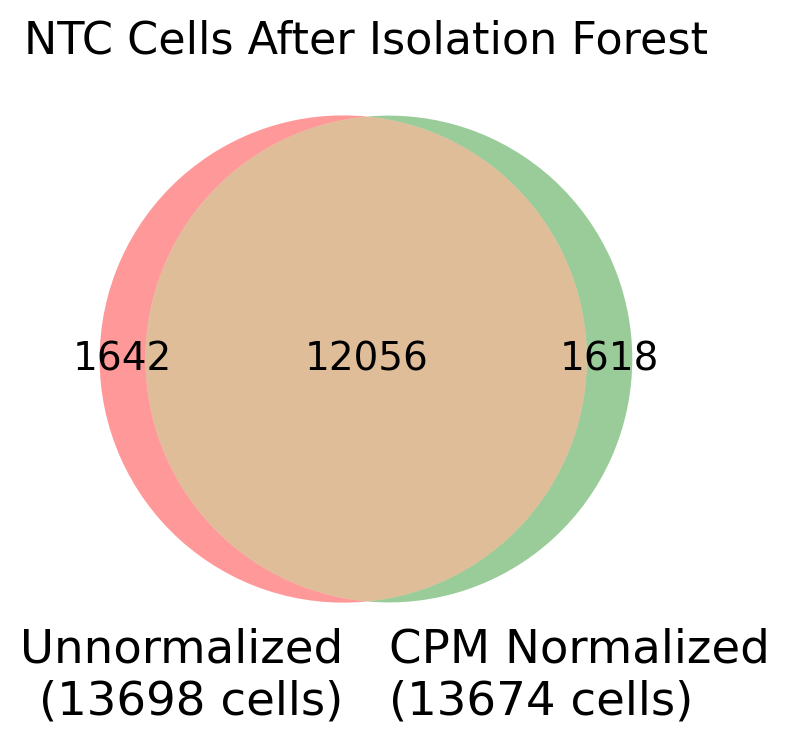

In [14]:
plot_venn2(adata_no_norm_ntc_cells, adata_cpm_ntc_cells, 
           "Unnormalized\n(13698 cells)", "CPM Normalized\n(13674 cells)", 
           "NTC Cells After Isolation Forest")

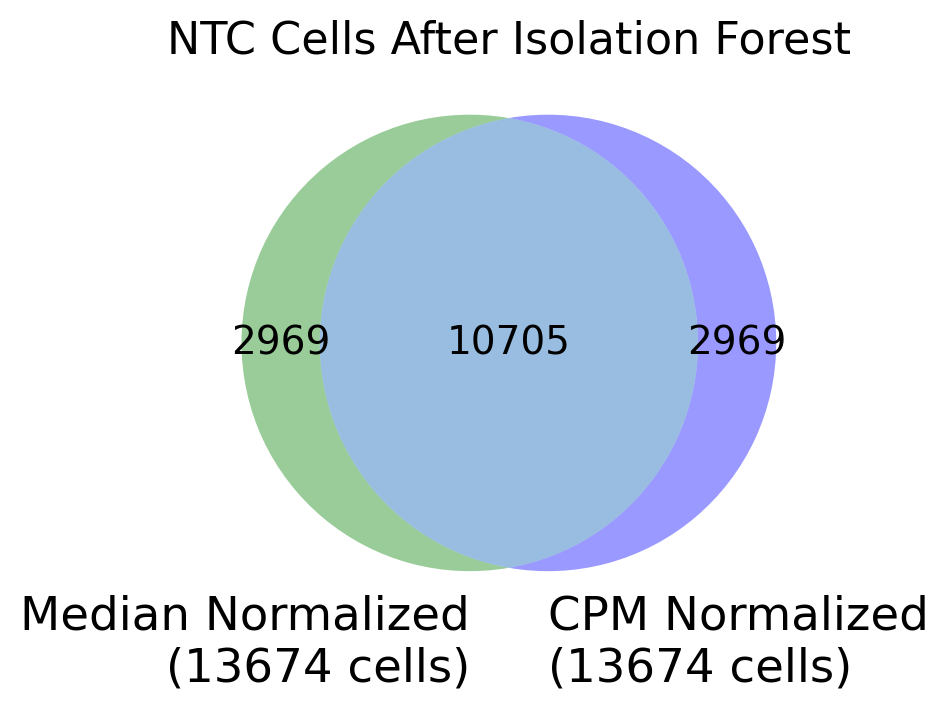

In [25]:
plot_venn2(adata_median_ntc_cells, adata_cpm_ntc_cells, 
           "Median Normalized\n(13674 cells)", "CPM Normalized\n(13674 cells)", 
           color1="green", color2="blue",
           title="NTC Cells After Isolation Forest")

In [21]:
from matplotlib_venn import venn3

def plot_venn3(set1, set2, set3, label1, label2, label3,
               title=None, color1="red", color2="green", color3="blue"):
    plt.rcParams['font.size'] = 12
    venn3((set1, set2, set3), 
        set_labels = (label1, label2, label3),
        set_colors = (color1, color2, color3),
        alpha=0.4)
    if title:
        plt.title(title, fontsize=16)
    plt.show()

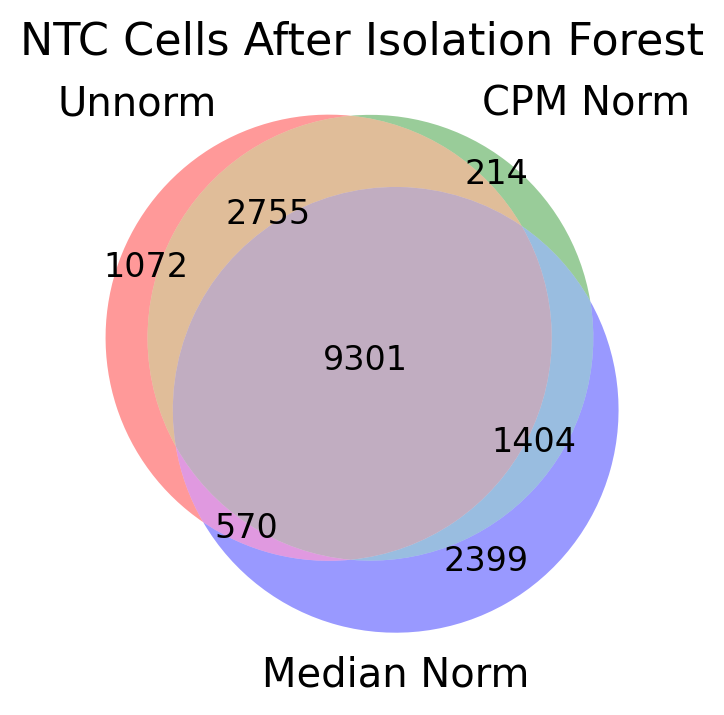

In [23]:
plot_venn3(adata_no_norm_ntc_cells, adata_cpm_ntc_cells, adata_median_ntc_cells,
           "Unnorm", "CPM Norm","Median Norm", "NTC Cells After Isolation Forest")

In [5]:
import scanpy as sc

adata_pre_etest_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_Knockdown_Filtered.h5ad"
adata_unnorm_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_Knockdown_Energy_Test_Filtered.h5ad"
adata_norm_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_Knockdown_Energy_Test_Filtered.h5ad"

adata_pre_etest = sc.read_h5ad(adata_pre_etest_filepath, backed="r")
adata_unnorm = sc.read_h5ad(adata_unnorm_filepath, backed="r")
adata_norm = sc.read_h5ad(adata_norm_filepath, backed="r")

In [6]:
def print_stats(adata):
    print(f"# perturbed cells: {adata[adata.obs.perturbed == 'True'].shape[0]}")
    print(f"# gene targets: {len(adata.obs.gene_target.unique().tolist()) - 1}")
    print(f"# gRNA: {len(adata[adata.obs.perturbed == 'True'].obs.gRNA.unique().tolist())}")

In [7]:
print_stats(adata_pre_etest)

# perturbed cells: 275793
# gene targets: 1368
# gRNA: 3340


In [8]:
print_stats(adata_unnorm)

# perturbed cells: 204601
# gene targets: 1218
# gRNA: 2332


In [9]:
print_stats(adata_norm)

# perturbed cells: 88249
# gene targets: 726
# gRNA: 986


In [13]:
from matplotlib_venn import venn2

def plot_venn2(set1, set2, label1, label2, title=None, color1="red", color2="green"):
    plt.rcParams['font.size'] = 14
    venn2((set1, set2), 
        set_labels = (label1, label2),
        set_colors = (color1, color2),
        alpha=0.4)
    if title:
        plt.title(title, fontsize=14)
    plt.show()

In [14]:
unnorm_pert_gRNA = set(adata_unnorm[adata_unnorm.obs.perturbed == "True"].obs.gRNA.unique().tolist())
norm_pert_gRNA = set(adata_norm[adata_norm.obs.perturbed == "True"].obs.gRNA.unique().tolist())
print(f"# perturbing gRNA (unnormalized): {len(unnorm_pert_gRNA)}")
print(f"# perturbing gRNA (CPM normalized): {len(norm_pert_gRNA)}")

# perturbing gRNA (unnormalized): 2332
# perturbing gRNA (CPM normalized): 986


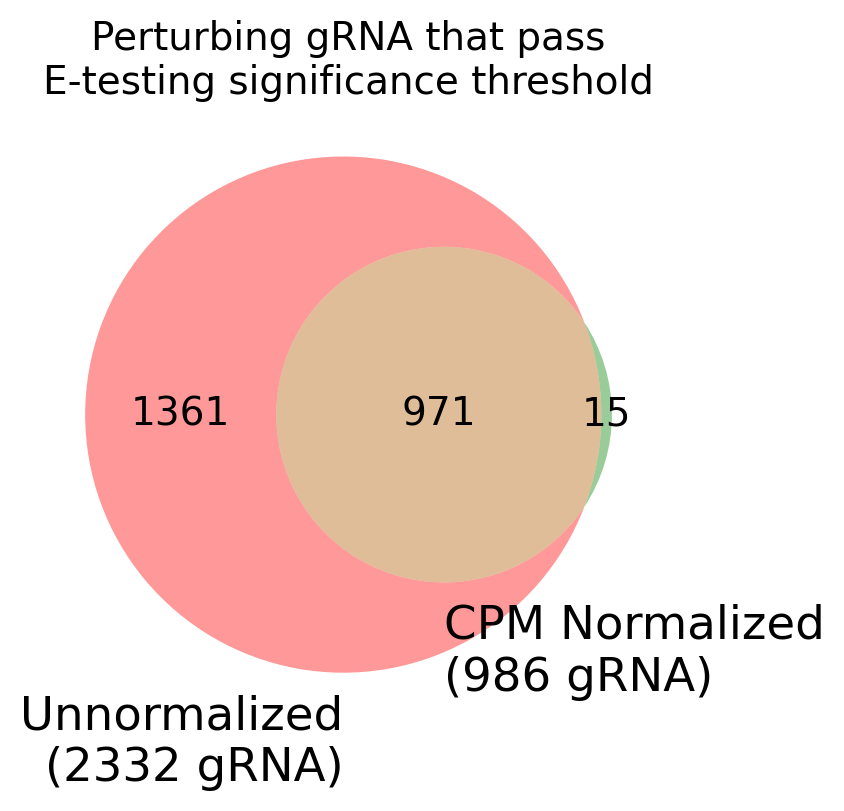

In [15]:
plot_venn2(unnorm_pert_gRNA, norm_pert_gRNA,
           "Unnormalized\n(2332 gRNA)",
           "CPM Normalized\n(986 gRNA)",
           title="Perturbing gRNA that pass\nE-testing significance threshold")

## DE genome coverage testing

In [2]:
import numpy as np
import anndata as ad
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams.update({'font.size': 12})

def compute_gene_coverage_for_gRNA_pseudoreps(adata: ad.AnnData, gRNA: str, 
                                            rng: np.random.Generator,
                                            include_total: bool=True) -> dict:
    """
    Generate differential expression analysis pseudoreplicates for the given gRNA
    and compute genome coverage (number of genes expressed in rep divided by
    number of genes in dataset) and gRNA gene coverage (number of genes expressed
    in rep divided by number of genes expressed in all cells receiving that gRNA).
    """
    data_matrix = adata.X
    total_n_genes = adata.shape[1]
    genome_coverage = list() # n genes expressed in rep/n genes in adata
    gRNA_gene_coverage = list() # n genes expressed in rep/n genes expressed by gRNA cells
    # Create gRNA pseudoreplicates
    gRNA_indices = np.where(adata.obs['gRNA'] == gRNA)[0]
    n_cells = len(gRNA_indices)
    n_reps = 2 if n_cells <= 35 else 3
    rep_size = len(gRNA_indices) // n_reps
    sample_size = rep_size * n_reps
    sampled_gRNA_indices = rng.choice(gRNA_indices, sample_size, replace=False)
    # Number of expressed genes for all cells that received this gRNA
    gRNA_profile = data_matrix[sampled_gRNA_indices].sum(axis=0)
    gRNA_n_expr_genes = np.count_nonzero(gRNA_profile)
    # Compute genome coverage for each rep
    for rep in range(n_reps):
        # Number of expressed genes in rep
        start, stop = rep*rep_size, (rep+1)*rep_size
        rep_indices = sampled_gRNA_indices[start:stop]
        rep_profile = data_matrix[rep_indices].sum(axis=0)
        rep_n_expr_genes = np.count_nonzero(rep_profile)
        # Genome coverage
        rep_genome_coverage = np.round(rep_n_expr_genes / total_n_genes, 2)
        genome_coverage.append(rep_genome_coverage)
        # gRNA gene coverage
        rep_gRNA_gene_coverage = np.round(rep_n_expr_genes / gRNA_n_expr_genes, 2)
        gRNA_gene_coverage.append(rep_gRNA_gene_coverage)
    # If no 3rd rep, add NaN value
    if len(genome_coverage) == 2:
        genome_coverage.append(np.nan)
    if len(gRNA_gene_coverage) == 2:
        gRNA_gene_coverage.append(np.nan)
    # Add total
    if include_total == True:
        total_genome_coverage = np.round(gRNA_n_expr_genes / total_n_genes, 2)
        genome_coverage.append(total_genome_coverage)
    # Return results
    results_dict = {"genome_coverage": genome_coverage,
                    "gRNA_gene_coverage": gRNA_gene_coverage}
    return results_dict

def build_DE_gRNA_rep_genome_coverage_df(adata: ad.AnnData, n_cells_per_gRNA: list = [], 
                                    n_gRNA_per_size: int = 0, gRNA_list: list = [],
                                    random_state: int=42, include_total: bool=True,
                                    n_reps: int=3):
    """
    For each of the given numbers of cells per gRNA, sample a given number of gRNA,
    generate differential expression analysis pseudoreplicates for each gRNA,
    and compute genome coverage (number of genes expressed in rep divided by
    number of genes in dataset) and gRNA gene coverage (number of genes expressed
    in rep divided by number of genes expressed in all cells receiving that gRNA).
    """
    # Check that necessary inputs are provided
    if n_cells_per_gRNA != [] and n_gRNA_per_size == 0:
        print("Error: must provide number of gRNA to sample per size (cell number)")
    if n_cells_per_gRNA == [] and n_gRNA_per_size != 0:
        print("Error: must provide list of gRNA cell numbers")
    if n_cells_per_gRNA == [] and gRNA_list == []:
        print("Error: must provide list of gRNA or gRNA cell numbers")

    # Subset only KD cells and reset adata.X to counts
    adata = adata[adata.obs.perturbed == "True"].copy()
    adata.X = adata.layers["counts"].copy()

    # Build DF of number of cells per gRNA
    cells_per_gRNA = adata.obs.gRNA.value_counts()
    cells_per_gRNA = cells_per_gRNA.rename_axis("gRNA").reset_index(name="n_cells")

    # Generate RNG objects
    rng = np.random.default_rng(random_state)
    rngs = rng.spawn(2)
    gRNA_rng, reps_rng = rngs[0], rngs[1]
    
    # Initialize dicts for genome coverage and gRNA gene coverage
    genome_coverage_dict = dict()
    gRNA_gene_coverage_dict = dict()

    # If a gRNA list is not provided, randomly sample gRNA
    if gRNA_list == []:
        # Loop through desired sizes of cells, e.g. [25, 30)
        for i in range(len(n_cells_per_gRNA)-1):
            # Filter to only gRNA with desired number of cells
            min_n_cells, max_n_cells = n_cells_per_gRNA[i], n_cells_per_gRNA[i+1]
            print(f"Sampling gRNA with {min_n_cells}-{max_n_cells-1} cells")
            filt_cells_per_gRNA = \
                cells_per_gRNA[(cells_per_gRNA["n_cells"] >= min_n_cells) & 
                (cells_per_gRNA["n_cells"] < max_n_cells)].copy()
            # If DF is empty, skip this cell number
            if filt_cells_per_gRNA.empty:
                continue
            # If number of gRNA > desired number, sample randomly
            if filt_cells_per_gRNA.shape[0] > n_gRNA_per_size:
                all_gRNA_indices = filt_cells_per_gRNA.index.tolist()
                chosen_gRNA_indices = gRNA_rng.choice(all_gRNA_indices, n_gRNA_per_size,
                                        replace=False)
                filt_cells_per_gRNA = \
                    filt_cells_per_gRNA[filt_cells_per_gRNA.index.isin(chosen_gRNA_indices)].copy()
            # Build gRNA list
            filt_cells_per_gRNA.sort_values(by="n_cells", inplace=True)
            gRNA_list += filt_cells_per_gRNA["gRNA"].tolist()
    else: # Sort gRNA list by number of cells per gRNA
        filt_cells_per_gRNA = cells_per_gRNA[cells_per_gRNA["gRNA"].isin(gRNA_list)].copy()
        filt_cells_per_gRNA.sort_values(by="n_cells", inplace=True)
        gRNA_list = filt_cells_per_gRNA["gRNA"].tolist()

    # For all gRNA, generate pseudoreps and calculate genome + gRNA gene coverage
    for i in tqdm(range(len(gRNA_list)), desc="Computing coverage for gRNA"):
        gRNA = gRNA_list[i]
        # Get number of cells for gRNA
        gRNA_idx = cells_per_gRNA[cells_per_gRNA["gRNA"] == gRNA].index[0]
        gRNA_n_cells = cells_per_gRNA.at[gRNA_idx, "n_cells"]
        gRNA_entry = f"{gRNA} ({gRNA_n_cells} cells)"
        # Compute genome and gRNA gene coverage for pseudoreps
        gRNA_coverage = \
            compute_gene_coverage_for_gRNA_pseudoreps(adata, gRNA, reps_rng, include_total)
        genome_entry = {f"rep{i+1}": gRNA_coverage["genome_coverage"][i] for i in range(n_reps)}
        if include_total == True:
            genome_entry["total"] = gRNA_coverage["genome_coverage"][-1]
        gene_entry = {f"rep{i+1}": gRNA_coverage["gRNA_gene_coverage"][i] for i in range(n_reps)}
        genome_coverage_dict[gRNA_entry] = genome_entry
        gRNA_gene_coverage_dict[gRNA_entry] = gene_entry
    
    # Build DFs
    genome_coverage_df = pd.DataFrame.from_dict(genome_coverage_dict, orient="index")
    gRNA_gene_coverage_df = pd.DataFrame.from_dict(gRNA_gene_coverage_dict, orient="index")
    return genome_coverage_df, gRNA_gene_coverage_df

def compute_gene_coverage_for_kd_pseudoreps(adata: ad.AnnData, kd: str, 
                                            rng: np.random.Generator,
                                            include_total: bool=True) -> dict:
    """
    Generate differential expression analysis pseudoreplicates for the given
    gene target KD and compute genome coverage (number of genes expressed in rep 
    divided by number of genes in dataset) and gene target gene coverage 
    (number of genes expressed in rep divided by number of genes expressed in 
    all cells corresponding to that KD).
    """
    data_matrix = adata.X
    total_n_genes = adata.shape[1]
    genome_coverage = list() # n genes expressed in rep/n genes in adata
    kd_gene_coverage = list() # n genes expressed in rep/n genes expressed by KD cells
    # Create KD pseudoreplicates
    kd_indices = np.where(adata.obs['gene_target'] == kd)[0]
    n_cells = len(kd_indices)
    n_reps = 2 if n_cells <= 35 else 3
    rep_size = len(kd_indices) // n_reps
    sample_size = rep_size * n_reps
    sampled_kd_indices = rng.choice(kd_indices, sample_size, replace=False)
    # Number of expressed genes for all cells with this gene target
    kd_profile = data_matrix[sampled_kd_indices].sum(axis=0)
    kd_n_expr_genes = np.count_nonzero(kd_profile)
    # Compute genome coverage for each rep
    for rep in range(n_reps):
        # Number of expressed genes in rep
        start, stop = rep*rep_size, (rep+1)*rep_size
        rep_indices = sampled_kd_indices[start:stop]
        rep_profile = data_matrix[rep_indices].sum(axis=0)
        rep_n_expr_genes = np.count_nonzero(rep_profile)
        # Genome coverage
        rep_genome_coverage = np.round(rep_n_expr_genes / total_n_genes, 2)
        genome_coverage.append(rep_genome_coverage)
        # KD gene coverage
        rep_kd_gene_coverage = np.round(rep_n_expr_genes / kd_n_expr_genes, 2)
        kd_gene_coverage.append(rep_kd_gene_coverage)
    # If no 3rd rep, add NaN value
    if len(genome_coverage) == 2:
        genome_coverage.append(np.nan)
    if len(kd_gene_coverage) == 2:
        kd_gene_coverage.append(np.nan)
    # Add total
    if include_total == True:
        total_genome_coverage = np.round(kd_n_expr_genes / total_n_genes, 2)
        genome_coverage.append(total_genome_coverage)
    # Return results
    results_dict = {"genome_coverage": genome_coverage,
                    "KD_gene_coverage": kd_gene_coverage}
    return results_dict

def build_DE_KD_rep_genome_coverage_df(adata: ad.AnnData, kd_list: list,
                                    random_state: int=42, n_reps: int=3,
                                    include_total: bool=True):
    """
    Generate differential expression analysis pseudoreplicates for each KD, 
    and compute genome coverage (number of genes expressed in rep divided by
    number of genes in dataset) and KD gene coverage (number of genes expressed
    in rep divided by number of genes expressed in all cells of that KD).
    """
    # Subset only KD cells and reset adata.X to counts
    adata = adata[adata.obs.perturbed == "True"].copy()
    adata.X = adata.layers["counts"].copy()

    # Build cells per gene target DF and sort by number of cells
    cells_per_kd = adata.obs.gene_target.value_counts()
    cells_per_kd = cells_per_kd.rename_axis("gene_target").reset_index(name="n_cells")
    cells_per_kd = cells_per_kd[cells_per_kd["gene_target"].isin(kd_list)]
    cells_per_kd.sort_values(by="n_cells", inplace=True)
    kd_list = cells_per_kd["gene_target"].tolist()

    # Generate RNG object
    rng = np.random.default_rng(random_state)
    
    # Compute genome coverage and KD gene coverage
    genome_coverage_dict = dict()
    kd_gene_coverage_dict = dict()
    for i in tqdm(range(len(kd_list)), desc="Computing coverage for KD gene target"):
        kd = kd_list[i]
        # Get number of cells for KD
        kd_cell_num = adata[adata.obs.gene_target == kd].shape[0]
        kd_entry = f"{kd} ({kd_cell_num} cells)"
        # Compute genome and gRNA gene coverage for pseudoreps
        kd_coverage = compute_gene_coverage_for_kd_pseudoreps(adata, kd, rng, include_total)
        genome_entry = {f"rep{i+1}": kd_coverage["genome_coverage"][i] for i in range(n_reps)}
        if include_total == True:
            genome_entry["total"] = kd_coverage["genome_coverage"][-1]
        gene_entry = {f"rep{i+1}": kd_coverage["KD_gene_coverage"][i] for i in range(n_reps)}
        genome_coverage_dict[kd_entry] = genome_entry
        kd_gene_coverage_dict[kd_entry] = gene_entry
    
    # Build DFs
    genome_coverage_df = pd.DataFrame.from_dict(genome_coverage_dict, orient="index")
    kd_gene_coverage_df = pd.DataFrame.from_dict(kd_gene_coverage_dict, orient="index")
    return genome_coverage_df, kd_gene_coverage_df

def calculate_kd_genome_coverage(adata: ad.AnnData, kd_list: list):
    adata = adata.copy()
    adata.X = adata.layers["counts"].copy()
    data_matrix = adata.X
    total_n_genes = adata.shape[1]
    kd_genome_coverage_dict = dict()
    for kd in kd_list:
        # Number of expressed genes for all cells with this gene target
        kd_indices = np.where(adata.obs['gene_target'] == kd)[0]
        kd_profile = data_matrix[kd_indices].sum(axis=0)
        kd_n_expr_genes = np.count_nonzero(kd_profile)
        kd_genome_coverage = np.round(kd_n_expr_genes/total_n_genes, 2)
        kd_genome_coverage_dict[kd] = kd_genome_coverage
    return kd_genome_coverage_dict

def plot_gene_coverage_heatmap(gene_coverage_df: pd.DataFrame, title: str,
                               cmap: str="viridis", annot: bool=True,
                               figsize: tuple=(3,8)):
    plt.figure(figsize=figsize)
    nan_mask = gene_coverage_df.isna()
    ax = sns.heatmap(gene_coverage_df, cmap=cmap, annot=annot, annot_kws={"size": 8},
        mask=nan_mask, vmin=0, vmax=1, linewidths=0.5, xticklabels=True)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=10)
    plt.grid(False)
    plt.title(title, pad=10, fontsize=12)
    plt.show()

In [3]:
import anndata as ad

adata_filepath = \
    "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_Knockdown_Energy_Test_Filtered.h5ad"
test_adata = ad.read_h5ad(adata_filepath)
test_adata

AnnData object with n_obs × n_vars = 101923 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [4]:
test_adata.n_vars

20043

Sample 5 gRNA of each size 25-50 cells in multiples of 5

Does each gRNA pseudorep cover 75% of dataset genes?

In [5]:
test_res_gRNA = build_DE_gRNA_rep_genome_coverage_df(test_adata, 
    n_cells_per_gRNA = [25, 30, 35, 40, 45, 50], n_gRNA_per_size=5, random_state=12345)
test_genome_coverage_df, test_gRNA_coverage_df = test_res_gRNA

Sampling gRNA with 25-29 cells
Sampling gRNA with 30-34 cells
Sampling gRNA with 35-39 cells
Sampling gRNA with 40-44 cells
Sampling gRNA with 45-49 cells


Computing coverage for gRNA: 100%|██████████| 25/25 [00:42<00:00,  1.70s/it]


In [ ]:
plot_gene_coverage_heatmap(test_genome_coverage_df, figsize=(4,8),
    title="gRNA replicates - genome coverage")

What about the same for each knockdown/gene target, which can include up to 3 unique gRNAs?

In [7]:
test_gene_targets = [kd.split("_")[0] for kd in test_genome_coverage_df.index.tolist()]
print(test_gene_targets)

['ZNF408', 'ZNF335', 'POU5F1', 'GATA6', 'SETDB1', 'RLF', 'TGIF1', 'ZNF234', 'DR1', 'ZNF71', 'FOXI3', 'POGK', 'NANOG', 'ZBTB11', 'XPA', 'SAFB', 'GLI2', 'NFIA', 'EBF2', 'POU5F1B', 'ZNF397', 'NFYB', 'ZNF256', 'MTF1', 'ZNF804B']


In [8]:
test_res_kd = build_DE_KD_rep_genome_coverage_df(test_adata, test_gene_targets)
test_kd_genome_coverage_df, test_kd_coverage_df = test_res_kd

Computing coverage for KD gene target: 100%|██████████| 25/25 [00:46<00:00,  1.87s/it]


Does each KD pseudorep achieve 75% genome coverage?

In [ ]:
plot_gene_coverage_heatmap(test_kd_genome_coverage_df,
    "KD replicates - genome coverage", figsize=(4,8), cmap="plasma")

What about KDs with a low cell number?

In [10]:
low_kds = test_adata.obs.gene_target.value_counts().tail(25).index.tolist()
print(low_kds)

['POU5F1B', 'CREB1', 'THAP9', 'TSC22D1', 'TOPORS', 'NFIA', 'KLF9', 'SOX2', 'SOX6', 'LIN28B', 'GLI2', 'E2F1', 'ELF5', 'ZNF511', 'SAFB', 'ZNF148', 'ZBTB11', 'ZNF81', 'NANOGP8', 'FOXI3', 'NFE4', 'GTF3A', 'ZIC2', 'ZNF408', 'ZNF335']


In [11]:
test_res_kd_low = build_DE_KD_rep_genome_coverage_df(test_adata, low_kds)
test_kd_low_genome_coverage_df, test_kd_low_coverage_df = test_res_kd_low

Computing coverage for KD gene target: 100%|██████████| 25/25 [00:45<00:00,  1.80s/it]


In [ ]:
display(test_kd_low_genome_coverage_df)

What about KDs with a high cell number?

In [13]:
test_adata.obs.gRNA.value_counts().head(10)

gRNA
HNF1A_1       279
BHLHE40_1     279
ARHGAP35_3    252
ZFP41_3       241
HNF4A_2       239
ZNF658_2      238
ZNF354A_1     226
VDR_2         226
ADNP2_1       215
ZFP37_2       214
Name: count, dtype: int64

In [14]:
high_cell_number_gRNA = test_adata.obs.gRNA.value_counts().head(10).index.tolist()
print(high_cell_number_gRNA)

['HNF1A_1', 'BHLHE40_1', 'ARHGAP35_3', 'ZFP41_3', 'HNF4A_2', 'ZNF658_2', 'ZNF354A_1', 'VDR_2', 'ADNP2_1', 'ZFP37_2']


In [15]:
high_cell_num_gRNA_res = \
    build_DE_gRNA_rep_genome_coverage_df(test_adata, gRNA_list=high_cell_number_gRNA)
test_hi_gRNA_genome_coverage_df, test_hi_gRNA_gene_coverage_df = high_cell_num_gRNA_res

Computing coverage for gRNA: 100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


In [16]:
display(test_hi_gRNA_genome_coverage_df)

rep1  rep2  rep3  total
ZFP37_2 (214 cells)     0.79  0.80  0.80   0.92
ADNP2_1 (215 cells)     0.80  0.80  0.79   0.91
ZNF354A_1 (226 cells)   0.81  0.80  0.79   0.92
VDR_2 (226 cells)       0.80  0.80  0.81   0.92
ZNF658_2 (238 cells)    0.80  0.81  0.82   0.92
HNF4A_2 (239 cells)     0.81  0.81  0.81   0.92
ZFP41_3 (241 cells)     0.82  0.81  0.81   0.92
ARHGAP35_3 (252 cells)  0.80  0.81  0.82   0.92
BHLHE40_1 (279 cells)   0.83  0.83  0.83   0.94
HNF1A_1 (279 cells)     0.83  0.83  0.84   0.94

Dataset with KD cells only

In [17]:
test_adata_kds = test_adata[test_adata.obs.perturbation_significant == True].copy()
test_adata_kds

AnnData object with n_obs × n_vars = 88249 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [21]:
print(f"# of KDs: {test_adata_kds.obs.gene_target.nunique()}")
print(f"# of gRNAs: {test_adata_kds.obs.gRNA.nunique()}")

# of KDs: 726
# of gRNAs: 986


### Apply stricter gene filter

In [22]:
import numpy as np
import anndata as ad
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams.update({'font.size': 12})

def compute_gene_coverage_for_gRNA_pseudoreps(adata: ad.AnnData, gRNA: str, 
                                            rng: np.random.Generator,
                                            include_total: bool=True) -> dict:
    """
    Generate differential expression analysis pseudoreplicates for the given gRNA
    and compute genome coverage (number of genes expressed in rep divided by
    number of genes in dataset) and gRNA gene coverage (number of genes expressed
    in rep divided by number of genes expressed in all cells receiving that gRNA).
    """
    data_matrix = adata.X
    total_n_genes = adata.shape[1]
    genome_coverage = list() # n genes expressed in rep/n genes in adata
    gRNA_gene_coverage = list() # n genes expressed in rep/n genes expressed by gRNA cells
    # Create gRNA pseudoreplicates
    gRNA_indices = np.where(adata.obs['gRNA'] == gRNA)[0]
    n_cells = len(gRNA_indices)
    n_reps = 2 if n_cells <= 35 else 3
    rep_size = len(gRNA_indices) // n_reps
    sample_size = rep_size * n_reps
    sampled_gRNA_indices = rng.choice(gRNA_indices, sample_size, replace=False)
    # Number of expressed genes for all cells that received this gRNA
    gRNA_profile = data_matrix[sampled_gRNA_indices].sum(axis=0)
    gRNA_n_expr_genes = np.count_nonzero(gRNA_profile)
    # Compute genome coverage for each rep
    for rep in range(n_reps):
        # Number of expressed genes in rep
        start, stop = rep*rep_size, (rep+1)*rep_size
        rep_indices = sampled_gRNA_indices[start:stop]
        rep_profile = data_matrix[rep_indices].sum(axis=0)
        rep_n_expr_genes = np.count_nonzero(rep_profile)
        # Genome coverage
        rep_genome_coverage = np.round(rep_n_expr_genes / total_n_genes, 2)
        genome_coverage.append(rep_genome_coverage)
        # gRNA gene coverage
        rep_gRNA_gene_coverage = np.round(rep_n_expr_genes / gRNA_n_expr_genes, 2)
        gRNA_gene_coverage.append(rep_gRNA_gene_coverage)
    # If no 3rd rep, add NaN value
    if len(genome_coverage) == 2:
        genome_coverage.append(np.nan)
    if len(gRNA_gene_coverage) == 2:
        gRNA_gene_coverage.append(np.nan)
    # Add total
    if include_total == True:
        total_genome_coverage = np.round(gRNA_n_expr_genes / total_n_genes, 2)
        genome_coverage.append(total_genome_coverage)
    # Return results
    results_dict = {"genome_coverage": genome_coverage,
                    "gRNA_gene_coverage": gRNA_gene_coverage}
    return results_dict

def build_DE_gRNA_rep_genome_coverage_df(adata: ad.AnnData, n_cells_per_gRNA: list = [], 
                                    n_gRNA_per_size: int = 0, gRNA_list: list = [],
                                    random_state: int=42, include_total: bool=True,
                                    n_reps: int=3):
    """
    For each of the given numbers of cells per gRNA, sample a given number of gRNA,
    generate differential expression analysis pseudoreplicates for each gRNA,
    and compute genome coverage (number of genes expressed in rep divided by
    number of genes in dataset) and gRNA gene coverage (number of genes expressed
    in rep divided by number of genes expressed in all cells receiving that gRNA).
    """
    # Check that necessary inputs are provided
    if n_cells_per_gRNA != [] and n_gRNA_per_size == 0:
        print("Error: must provide number of gRNA to sample per size (cell number)")
    if n_cells_per_gRNA == [] and n_gRNA_per_size != 0:
        print("Error: must provide list of gRNA cell numbers")
    if n_cells_per_gRNA == [] and gRNA_list == []:
        print("Error: must provide list of gRNA or gRNA cell numbers")

    # Subset only KD cells and reset adata.X to counts
    adata = adata[adata.obs.perturbed == "True"].copy()
    adata.X = adata.layers["counts"].copy()

    # Build DF of number of cells per gRNA
    cells_per_gRNA = adata.obs.gRNA.value_counts()
    cells_per_gRNA = cells_per_gRNA.rename_axis("gRNA").reset_index(name="n_cells")

    # Generate RNG objects
    rng = np.random.default_rng(random_state)
    rngs = rng.spawn(2)
    gRNA_rng, reps_rng = rngs[0], rngs[1]
    
    # Initialize dicts for genome coverage and gRNA gene coverage
    genome_coverage_dict = dict()
    gRNA_gene_coverage_dict = dict()

    # If a gRNA list is not provided, randomly sample gRNA
    if gRNA_list == []:
        # Loop through desired sizes of cells, e.g. [25, 30)
        for i in range(len(n_cells_per_gRNA)-1):
            # Filter to only gRNA with desired number of cells
            min_n_cells, max_n_cells = n_cells_per_gRNA[i], n_cells_per_gRNA[i+1]
            print(f"Sampling gRNA with {min_n_cells}-{max_n_cells-1} cells")
            filt_cells_per_gRNA = \
                cells_per_gRNA[(cells_per_gRNA["n_cells"] >= min_n_cells) & 
                (cells_per_gRNA["n_cells"] < max_n_cells)].copy()
            # If DF is empty, skip this cell number
            if filt_cells_per_gRNA.empty:
                continue
            # If number of gRNA > desired number, sample randomly
            if filt_cells_per_gRNA.shape[0] > n_gRNA_per_size:
                all_gRNA_indices = filt_cells_per_gRNA.index.tolist()
                chosen_gRNA_indices = gRNA_rng.choice(all_gRNA_indices, n_gRNA_per_size,
                                        replace=False)
                filt_cells_per_gRNA = \
                    filt_cells_per_gRNA[filt_cells_per_gRNA.index.isin(chosen_gRNA_indices)].copy()
            # Build gRNA list
            filt_cells_per_gRNA.sort_values(by="n_cells", inplace=True)
            gRNA_list += filt_cells_per_gRNA["gRNA"].tolist()
    else: # Sort gRNA list by number of cells per gRNA
        filt_cells_per_gRNA = cells_per_gRNA[cells_per_gRNA["gRNA"].isin(gRNA_list)].copy()
        filt_cells_per_gRNA.sort_values(by="n_cells", inplace=True)
        gRNA_list = filt_cells_per_gRNA["gRNA"].tolist()

    # For all gRNA, generate pseudoreps and calculate genome + gRNA gene coverage
    for i in tqdm(range(len(gRNA_list)), desc="Computing coverage for gRNA"):
        gRNA = gRNA_list[i]
        # Get number of cells for gRNA
        gRNA_idx = cells_per_gRNA[cells_per_gRNA["gRNA"] == gRNA].index[0]
        gRNA_n_cells = cells_per_gRNA.at[gRNA_idx, "n_cells"]
        gRNA_entry = f"{gRNA} ({gRNA_n_cells} cells)"
        # Compute genome and gRNA gene coverage for pseudoreps
        gRNA_coverage = \
            compute_gene_coverage_for_gRNA_pseudoreps(adata, gRNA, reps_rng, include_total)
        genome_entry = {f"rep{i+1}": gRNA_coverage["genome_coverage"][i] for i in range(n_reps)}
        if include_total == True:
            genome_entry["total"] = gRNA_coverage["genome_coverage"][-1]
        gene_entry = {f"rep{i+1}": gRNA_coverage["gRNA_gene_coverage"][i] for i in range(n_reps)}
        genome_coverage_dict[gRNA_entry] = genome_entry
        gRNA_gene_coverage_dict[gRNA_entry] = gene_entry
    
    # Build DFs
    genome_coverage_df = pd.DataFrame.from_dict(genome_coverage_dict, orient="index")
    gRNA_gene_coverage_df = pd.DataFrame.from_dict(gRNA_gene_coverage_dict, orient="index")
    return genome_coverage_df, gRNA_gene_coverage_df

def compute_gene_coverage_for_kd_pseudoreps(adata: ad.AnnData, kd: str, 
                                            rng: np.random.Generator,
                                            include_total: bool=True) -> dict:
    """
    Generate differential expression analysis pseudoreplicates for the given
    gene target KD and compute genome coverage (number of genes expressed in rep 
    divided by number of genes in dataset) and gene target gene coverage 
    (number of genes expressed in rep divided by number of genes expressed in 
    all cells corresponding to that KD).
    """
    data_matrix = adata.X
    total_n_genes = adata.shape[1]
    genome_coverage = list() # n genes expressed in rep/n genes in adata
    kd_gene_coverage = list() # n genes expressed in rep/n genes expressed by KD cells
    # Create KD pseudoreplicates
    kd_indices = np.where(adata.obs['gene_target'] == kd)[0]
    n_cells = len(kd_indices)
    n_reps = 2 if n_cells <= 35 else 3
    rep_size = len(kd_indices) // n_reps
    sample_size = rep_size * n_reps
    sampled_kd_indices = rng.choice(kd_indices, sample_size, replace=False)
    # Number of expressed genes for all cells with this gene target
    kd_profile = data_matrix[sampled_kd_indices].sum(axis=0)
    kd_n_expr_genes = np.count_nonzero(kd_profile)
    # Compute genome coverage for each rep
    for rep in range(n_reps):
        # Number of expressed genes in rep
        start, stop = rep*rep_size, (rep+1)*rep_size
        rep_indices = sampled_kd_indices[start:stop]
        rep_profile = data_matrix[rep_indices].sum(axis=0)
        rep_n_expr_genes = np.count_nonzero(rep_profile)
        # Genome coverage
        rep_genome_coverage = np.round(rep_n_expr_genes / total_n_genes, 2)
        genome_coverage.append(rep_genome_coverage)
        # KD gene coverage
        rep_kd_gene_coverage = np.round(rep_n_expr_genes / kd_n_expr_genes, 2)
        kd_gene_coverage.append(rep_kd_gene_coverage)
    # If no 3rd rep, add NaN value
    if len(genome_coverage) == 2:
        genome_coverage.append(np.nan)
    if len(kd_gene_coverage) == 2:
        kd_gene_coverage.append(np.nan)
    # Add total
    if include_total == True:
        total_genome_coverage = np.round(kd_n_expr_genes / total_n_genes, 2)
        genome_coverage.append(total_genome_coverage)
    # Return results
    results_dict = {"genome_coverage": genome_coverage,
                    "KD_gene_coverage": kd_gene_coverage}
    return results_dict

def build_DE_KD_rep_genome_coverage_df(adata: ad.AnnData, kd_list: list,
                                    random_state: int=42, n_reps: int=3,
                                    include_total: bool=True):
    """
    Generate differential expression analysis pseudoreplicates for each KD, 
    and compute genome coverage (number of genes expressed in rep divided by
    number of genes in dataset) and KD gene coverage (number of genes expressed
    in rep divided by number of genes expressed in all cells of that KD).
    """
    # Subset only KD cells and reset adata.X to counts
    adata = adata[adata.obs.perturbed == "True"].copy()
    adata.X = adata.layers["counts"].copy()

    # Build cells per gene target DF and sort by number of cells
    cells_per_kd = adata.obs.gene_target.value_counts()
    cells_per_kd = cells_per_kd.rename_axis("gene_target").reset_index(name="n_cells")
    cells_per_kd = cells_per_kd[cells_per_kd["gene_target"].isin(kd_list)]
    cells_per_kd.sort_values(by="n_cells", inplace=True)
    kd_list = cells_per_kd["gene_target"].tolist()

    # Generate RNG object
    rng = np.random.default_rng(random_state)
    
    # Compute genome coverage and KD gene coverage
    genome_coverage_dict = dict()
    kd_gene_coverage_dict = dict()
    for i in tqdm(range(len(kd_list)), desc="Computing coverage for KD gene target"):
        kd = kd_list[i]
        # Get number of cells for KD
        kd_cell_num = adata[adata.obs.gene_target == kd].shape[0]
        kd_entry = f"{kd} ({kd_cell_num} cells)"
        # Compute genome and gRNA gene coverage for pseudoreps
        kd_coverage = compute_gene_coverage_for_kd_pseudoreps(adata, kd, rng, include_total)
        genome_entry = {f"rep{i+1}": kd_coverage["genome_coverage"][i] for i in range(n_reps)}
        if include_total == True:
            genome_entry["total"] = kd_coverage["genome_coverage"][-1]
        gene_entry = {f"rep{i+1}": kd_coverage["KD_gene_coverage"][i] for i in range(n_reps)}
        genome_coverage_dict[kd_entry] = genome_entry
        kd_gene_coverage_dict[kd_entry] = gene_entry
    
    # Build DFs
    genome_coverage_df = pd.DataFrame.from_dict(genome_coverage_dict, orient="index")
    kd_gene_coverage_df = pd.DataFrame.from_dict(kd_gene_coverage_dict, orient="index")
    return genome_coverage_df, kd_gene_coverage_df

def calculate_kd_genome_coverage(adata: ad.AnnData, kd_list: list):
    adata = adata.copy()
    adata.X = adata.layers["counts"].copy()
    data_matrix = adata.X
    total_n_genes = adata.shape[1]
    kd_genome_coverage_dict = dict()
    for kd in kd_list:
        # Number of expressed genes for all cells with this gene target
        kd_indices = np.where(adata.obs['gene_target'] == kd)[0]
        kd_profile = data_matrix[kd_indices].sum(axis=0)
        kd_n_expr_genes = np.count_nonzero(kd_profile)
        kd_genome_coverage = np.round(kd_n_expr_genes/total_n_genes, 2)
        kd_genome_coverage_dict[kd] = kd_genome_coverage
    return kd_genome_coverage_dict

def plot_gene_coverage_heatmap(gene_coverage_df: pd.DataFrame, title: str,
                               cmap: str="viridis", annot: bool=True,
                               figsize: tuple=(3,8)):
    plt.figure(figsize=figsize)
    nan_mask = gene_coverage_df.isna()
    ax = sns.heatmap(gene_coverage_df, cmap=cmap, annot=annot, annot_kws={"size": 8},
        mask=nan_mask, vmin=0, vmax=1, linewidths=0.5, xticklabels=True)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=10)
    plt.grid(False)
    plt.title(title, pad=10, fontsize=12)
    plt.show()

In [2]:
import anndata as ad

adata_filepath = \
    "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_Knockdown_Energy_Test_Filtered.h5ad"
test_adata = ad.read_h5ad(adata_filepath)
test_adata

AnnData object with n_obs × n_vars = 218299 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [23]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'
import seaborn as sns
import scanpy as sc

def filter_low_expressed_genes(adata, percent_threshold=0, min_n_cells=0, silent=False):
    """
    Filter out bottom percentile of genes with lowest expression (counts) 
    and genes expressed in fewer than min_n_cells cells.
    Do not filter out genes that are gene_targets in adata.
    """
    n_genes_before = adata.shape[1]

    # Filter genes expressed in fewer than min_n_cells cells
    if silent == False:
        print(f"Removing non-TF genes expressed in <{min_n_cells} cells")
    # Create data matrix
    if silent == False:
        print("Copying data")
    data_matrix = adata.layers["counts"] if "counts" in adata.layers else adata.X
    data_matrix = data_matrix.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(adata.obs.gene_target.unique().tolist())
    # Calculate number of cells expressing each gene
    gene_detected_counts = (data_matrix > 0).sum(axis=0)
    # Set cell number threshold and filter genes
    genes_pass_cell_thr = gene_detected_counts >= min_n_cells
    genes_to_keep = genes_pass_cell_thr | tf_mask
    adata = adata[:, genes_to_keep]
    print(f"Removed {n_genes_before - adata.n_vars} "
        f"non-TF genes expressed in <{min_n_cells} cells")
    n_genes_after_cell_filt = adata.n_vars
    del data_matrix

    # Filter bottom percentile of genes by expression (counts)
    if silent == False:
        print(f"\nRemoving bottom {percent_threshold}% of genes by expression (CPM)")
    if silent == False:
        print("Copying data")
    adata_norm = adata.copy()
    sc.pp.normalize_total(adata_norm, target_sum=1e6)
    if silent == False:
        print("Copying normalized data")
    data_matrix = adata_norm.X.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(adata.obs.gene_target.unique().tolist())
    # Calculate mean expression of each gene
    mean_expr_per_gene = data_matrix.mean(axis=0)
    # Set percent threshold and filter genes
    threshold = np.percentile(mean_expr_per_gene, percent_threshold)
    genes_pass_pct_thr = mean_expr_per_gene > threshold
    genes_to_keep = genes_pass_pct_thr | tf_mask
    adata = adata[:,genes_to_keep]
    print(f"Removed {n_genes_after_cell_filt - adata.n_vars} non-TF genes "
            f"with lowest {percent_threshold}% expression (CPM)")
    print(f"\nRemoved: {n_genes_before - adata.shape[1]} genes total")
    print(f"Remaining: {adata.n_vars} genes")
    del data_matrix
    del adata_norm
    gc.collect()
    return adata.copy()

def histogram_mean_expression(adata, title="Histogram of Mean Gene Expression", 
                              n_bins=75, ymax=None, show_labels=False):
    plt.rcParams["font.size"] = 14
    # Create data matrix
    adata = adata.copy()
    if "counts" in adata.layers:
        adata.X = adata.layers["counts"].copy()
    # Normalize and log1p
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.log1p(adata)
    # Copy
    data_matrix = adata.X.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        data_matrix = data_matrix.toarray()

    # Plot mean expression
    mean_expr = data_matrix.mean(axis=0)
    plt.figure(figsize=(8,4)) if show_labels else plt.figure(figsize=(6,4))
    ax = sns.histplot(mean_expr, bins=n_bins, kde=False)
    plt.xlabel("Mean expression per gene (CPM, log1p)")
    plt.ylabel("Number of genes")
    plt.title(title, fontsize=15)
    if ymax:
        ax.set_ylim(0, ymax)
    if show_labels:
        ax.bar_label(ax.containers[0], rotation=90, padding=3, fontsize=10)
    plt.tight_layout()
    plt.show()
    del data_matrix
    gc.collect()

def histogram_cells_expressing_gene(adata, title="Histogram of # Cells Expressing a Gene", 
                                    n_bins=75, ymax=None, show_labels=False):
    plt.rcParams["font.size"] = 14
    # Use raw counts
    count_matrix = adata.X if "counts" not in adata.layers else adata.layers["counts"]
    count_matrix = count_matrix.copy()
    # Convert from sparse to dense if necessary
    if hasattr(count_matrix, 'toarray'):
        count_matrix = count_matrix.toarray()
    # Plot number of cells expressing each gene
    gene_detected_counts = (count_matrix > 0).sum(axis=0)
    plt.figure(figsize=(8,4)) if show_labels else plt.figure(figsize=(6,4))
    ax = sns.histplot(gene_detected_counts, bins=n_bins, kde=False)
    plt.xlabel("Number of cells in which gene is expressed")
    plt.ylabel("Number of genes")
    plt.title(title, fontsize=15)
    if ymax:
        ax.set_ylim(0, ymax)
    if show_labels:
        ax.bar_label(ax.containers[0], rotation=90, padding=3, fontsize=10)
    plt.tight_layout()
    plt.show()
    del count_matrix
    gc.collect()

In [24]:
test_adata_filt10 = filter_low_expressed_genes(test_adata, percent_threshold=10, min_n_cells=100)

Removing non-TF genes expressed in <100 cells
Copying data
Converting data from sparse to dense
Filtering genes
Removed 188 non-TF genes expressed in <100 cells

Removing bottom 10% of genes by expression (CPM)
Copying data
normalizing counts per cell
    finished (0:00:00)
Copying normalized data
Converting data from sparse to dense
Filtering genes
Removed 1780 non-TF genes with lowest 10% expression (CPM)

Removed: 1968 genes total
Remaining: 18075 genes


Sample 5 gRNA of each size 25-50 cells in multiples of 5

Does each gRNA pseudorep cover 75% of dataset genes?

In [25]:
test_res_gRNA10 = build_DE_gRNA_rep_genome_coverage_df(test_adata_filt10, 
    n_cells_per_gRNA = [25, 30, 35, 40, 45, 50], n_gRNA_per_size=5, random_state=12345)
test_genome_coverage_df10, test_gRNA_coverage_df10 = test_res_gRNA10

Sampling gRNA with 25-29 cells
Sampling gRNA with 30-34 cells
Sampling gRNA with 35-39 cells
Sampling gRNA with 40-44 cells
Sampling gRNA with 45-49 cells


Computing coverage for gRNA: 100%|██████████| 25/25 [00:42<00:00,  1.70s/it]


In [ ]:
plot_gene_coverage_heatmap(test_genome_coverage_df10, figsize=(4,8),
    title="gRNA replicates - genome coverage")

In [27]:
test_adata_filt20 = filter_low_expressed_genes(test_adata, percent_threshold=20, min_n_cells=100)

Removing non-TF genes expressed in <100 cells
Copying data
Converting data from sparse to dense


Filtering genes
Removed 188 non-TF genes expressed in <100 cells

Removing bottom 20% of genes by expression (CPM)
Copying data
normalizing counts per cell
    finished (0:00:00)
Copying normalized data
Converting data from sparse to dense
Filtering genes
Removed 3740 non-TF genes with lowest 20% expression (CPM)

Removed: 3928 genes total
Remaining: 16115 genes


In [ ]:
histogram_mean_expression(test_adata_filt20, 
    title="Mean Gene Expression (20%/100 cell threshold)", n_bins=50)

In [ ]:
histogram_cells_expressing_gene(test_adata_filt20, 
    title="Number of Cells Expressing Each Gene (20%/100 cell threshold)", n_bins=50)

In [30]:
test_res_gRNA20 = build_DE_gRNA_rep_genome_coverage_df(test_adata_filt20, 
    n_cells_per_gRNA = [25, 30, 35, 40, 45, 50], n_gRNA_per_size=5, random_state=12345)
test_genome_coverage_df20, test_gRNA_coverage_df20 = test_res_gRNA20

Computing coverage for gRNA: 100%|██████████| 25/25 [00:42<00:00,  1.69s/it]


In [ ]:
plot_gene_coverage_heatmap(test_genome_coverage_df20, figsize=(4,8),
    title="gRNA replicates - genome coverage")

What about the same for each knockdown/gene target, which can include up to 3 unique gRNAs?

In [32]:
test_gene_targets = [kd.split("_")[0] for kd in test_genome_coverage_df20.index.tolist()]
print(test_gene_targets)

['ZNF335', 'ZNF408', 'GATA6', 'POU5F1', 'SETDB1', 'RLF', 'ZNF234', 'TGIF1', 'DR1', 'ZNF71', 'POGK', 'FOXI3', 'NANOG', 'ZBTB11', 'XPA', 'GLI2', 'SAFB', 'NFIA', 'POU5F1B', 'EBF2', 'ZNF397', 'NFYB', 'MTF1', 'ZNF256', 'ZNF804B']


In [33]:
test_res_kd = build_DE_KD_rep_genome_coverage_df(test_adata_filt20, test_gene_targets)
test_kd_genome_coverage_df, test_kd_coverage_df = test_res_kd

Computing coverage for KD gene target: 100%|██████████| 25/25 [00:46<00:00,  1.86s/it]


Does each KD pseudorep achieve 75% genome coverage?

In [ ]:
plot_gene_coverage_heatmap(test_kd_genome_coverage_df,
    "Gene target replicates - genome coverage", figsize=(4,8), cmap="plasma")

What about KDs with a low cell number?

In [35]:
low_kds = test_adata.obs.gene_target.value_counts().tail(25).index.tolist()
print(low_kds)

['POU5F1B', 'CREB1', 'THAP9', 'TSC22D1', 'TOPORS', 'NFIA', 'KLF9', 'SOX2', 'SOX6', 'LIN28B', 'GLI2', 'E2F1', 'ELF5', 'ZNF511', 'SAFB', 'ZNF148', 'ZBTB11', 'ZNF81', 'NANOGP8', 'FOXI3', 'NFE4', 'GTF3A', 'ZIC2', 'ZNF408', 'ZNF335']


In [36]:
test_res_kd_low = build_DE_KD_rep_genome_coverage_df(test_adata, low_kds)
test_kd_low_genome_coverage_df, test_kd_low_coverage_df = test_res_kd_low

Computing coverage for KD gene target: 100%|██████████| 25/25 [00:45<00:00,  1.80s/it]


In [ ]:
plot_gene_coverage_heatmap(test_kd_low_genome_coverage_df,
    "KD replicates - genome coverage", figsize=(4,8))

# Fall 2025 Week 5

## DE code

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import gc

def generate_pseudoreplicates_for_DE(adata: ad.AnnData, 
                                     target_value: str, 
                                     ntc_cell_indices: pd.Index, 
                                     rng: np.random.Generator, 
                                     target_column: str = "perturbation", 
                                     min_cells_per_rep: int = 12,
                                     layer: str = "counts"):
    """
    Generate independent pseudoreplicates for a given target (gRNA or gene target) 
    and matched NTC cells. Manually set NTC as reference for DE analysis.
    """
    # Create views for target and NTC cells
    if target_column not in adata.obs:
        print(f"Error: {target_column} not in adata.obs")
        return
    target_mask = adata.obs[target_column] == target_value
    target_view = adata[target_mask]
    ntc_view = adata[ntc_cell_indices]

    # Get data matrices from counts layer
    if layer in adata.layers:
        target_data = target_view.layers[layer]
        ntc_data = ntc_view.layers[layer]
    else:
        target_data = target_view.X
        ntc_data = ntc_view.X        
    
    # Convert to dense if sparse
    if sparse.issparse(target_data):
        target_data = target_data.toarray()
    if sparse.issparse(ntc_data):
        ntc_data = ntc_data.toarray()

    # Calculate number of cells to sample
    n_target_cells = target_data.shape[0]
    n_ntc_cells = ntc_data.shape[0]
    if n_target_cells >= min_cells_per_rep * 2:
        n_reps = min(3, n_target_cells // min_cells_per_rep)
    else: # If too few cells for 2 reps x min_cells_per_rep cells
        n_reps = 2
    target_rep_size = n_target_cells // n_reps
    ntc_rep_size = min(target_rep_size, n_ntc_cells // n_reps)
    if ntc_rep_size < target_rep_size:
        print("Warning: Unmatched number of target and NTC cells")

    # Pre-allocate arrays for results
    target_bulk = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
    ntc_bulk = np.zeros((n_reps, ntc_data.shape[1]), dtype=np.int64)

    # Sample cells for all replicates
    target_sample_size = target_rep_size * n_reps
    ntc_sample_size = ntc_rep_size * n_reps
    sampled_target_indices = \
        rng.choice(n_target_cells, target_sample_size, replace=False)
    sampled_ntc_indices = \
        rng.choice(n_ntc_cells, ntc_sample_size, replace=False)
    # Generate replicates using vectorized operations
    for i in range(n_reps):
        # Sample indices
        target_start, target_stop = i*target_rep_size, (i+1)*target_rep_size
        target_rep_indices = sampled_target_indices[target_start:target_stop]
        ntc_start, ntc_stop = i*ntc_rep_size, (i+1)*ntc_rep_size
        ntc_rep_indices = sampled_ntc_indices[ntc_start:ntc_stop]

        # Calculate sums using vectorized operations
        target_bulk[i] = np.sum(target_data[target_rep_indices], axis=0).astype(np.int64)
        ntc_bulk[i] = np.sum(ntc_data[ntc_rep_indices], axis=0).astype(np.int64)  

    # Create sample names
    if "_" in target_value:
        target_value = target_value.replace("_", "-")
    sample_names = [f"{target_value}-rep{i+1}" for i in range(n_reps)]
    control_names = [f"NTC-rep{i+1}" for i in range(n_reps)]
    
    # Combine data
    combined_data = np.vstack([target_bulk, ntc_bulk])
    combined_names = sample_names + control_names
    
    # Create metadata DF
    metadata_df = pd.DataFrame({
        'condition': [target_value] * n_reps + ['NTC'] * n_reps
    }, index=combined_names)
    # Set NTC as reference for DESeq2
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", target_value],
        ordered=True
        )
    
    # Create counts DF
    counts_df = pd.DataFrame(
        combined_data,
        index=combined_names,
        columns=adata.var_names
    )

    return counts_df, metadata_df

def differential_expression(adata: ad.AnnData, 
                    target_column: str = "perturbation", 
                    ntc_cells_delimiter: str = "NTC", 
                    alpha: float = 0.05, n_cpus: int = 20, 
                    min_cells_per_rep: int = 12,
                    layer: str = "counts", random_state: int = 42, 
                    shrink_lfcs: bool = False, debug: bool = False):
    """
    Run differential expression analysis on each perturbation in the dataset.
    """
    # Identify KD and NTC cells
    perturbations = list(adata.obs[target_column].unique())
    perturbations.remove(ntc_cells_delimiter) # Remove NTC group
    if debug == True: # Debug mode: run with 3 perturbations
        print(f"Running in debug mode with 3 perturbations")
        perturbations = perturbations[:3]
    ntc_cell_indices = np.where(adata.obs[target_column] == ntc_cells_delimiter)[0]

    # Create RNG object
    de_rng = np.random.default_rng(random_state)
    # Create one child RNG object per perturbation
    streams = de_rng.spawn(len(perturbations))

    # Determine how many CPUs to use per joblib Parallel job
    #   and per DE analysis run
    if n_cpus < 3:
        n_cpus_for_DE = n_cpus
    elif n_cpus <= 10:
        n_cpus_for_DE = 3
    elif 20 <= n_cpus < 30:
        n_cpus_for_DE = 4
    elif 30 <= n_cpus < 50:
        n_cpus_for_DE = 5
    else:
        n_cpus_for_DE = 6
    n_jobs = max(1, n_cpus // n_cpus_for_DE)

    # Warning if given layer not found
    if layer not in adata.layers:
         print(f"Warning: {layer} not in adata.layers, using adata.X instead")

    # Function to run DE analysis on a single perturbation
    quiet = True
    def process_perturbation(target_value: str, rng: np.random.Generator, quiet=quiet):
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = generate_pseudoreplicates_for_DE(
            adata, target_value, ntc_cell_indices, rng, 
            target_column=target_column, min_cells_per_rep=min_cells_per_rep,
            layer=layer
        )

        # Set number of CPUs to use for each DE run
        inference = DefaultInference(n_cpus=n_cpus_for_DE) 

        # Read counts modeling and fitting dispersions
        dds = DeseqDataSet(
            counts = pseudo_bulk_df, 
            metadata = metadata_df,
            refit_cooks=True,
            inference=inference,
            quiet=quiet
            )
        dds.deseq2()
        
        # Statistical testing
        target_hyphenated = target_value.replace('_', '-')
        contrast = ["condition", target_hyphenated, ntc_cells_delimiter]
        stat_res = DeseqStats(
            dds, 
            contrast=contrast, 
            alpha=alpha,
            inference=inference,
            quiet=quiet)
        stat_res.summary()
        if shrink_lfcs == True:
            # Shrink LFCs for downstream analysis
            stat_res.lfc_shrink(coeff=f"condition_{contrast[1]}_vs_{contrast[2]}", 
                                adapt=False)
        results_df = stat_res.results_df

        # Clean up memory
        del pseudo_bulk_df, metadata_df, dds, stat_res
        gc.collect()

        # Return results with and without LFC shrinkage
        return results_df

    # Run DE analysis on all perturbations in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(perturbations)):
        results = Parallel(n_jobs=n_jobs)(delayed(process_perturbation)(target_value, rng)
            for target_value, rng in zip(perturbations, streams))
    
    results_dict = dict(zip(perturbations, results))
    return results_dict

def build_de_df(results_dict: dict):
    """
    Build DF of all DE results: baseMean, log2FoldChange, lfcSE, 
    stat (LFC divided by LFC SE), pvalue, padj.
    """
    df_list = list()
    for gene_target, df in results_dict.items():
        # Sort genes alphabetically
        df = df.sort_index()
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{gene_target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    if len(df_list) > 1:
        # Concatenate all DE result DataFrames (using intersection of genes)
        de_df = pd.concat(df_list, axis=1)
        de_df = de_df.sort_index()
    return de_df

def build_deg_df(de_df: pd.DataFrame, 
                 perturbation: str, 
                 padj_threshold: float = 0.05,
                 lfc_threshold: float = 0):
    """
    Return DE results filtered to only the given perturbation and only
    genes that pass p-adj threshold (alpha) and LFC threshold.
    """
    perturbation_cols = de_df.columns[de_df.columns.str.contains(perturbation)]
    perturbation_df = de_df[perturbation_cols]
    perturbation_deg_df = \
        perturbation_df[
            (perturbation_df[f"{perturbation}_padj"] < padj_threshold) & 
            (abs(perturbation_df[f"{perturbation}_log2FoldChange"]) > lfc_threshold)
            ]
    return perturbation_deg_df


In [3]:
data_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_Knockdown_Energy_Test_Filtered.h5ad"
adata = psp.utils.read_anndata(data_path)
adata

AnnData object with n_obs × n_vars = 101923 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [4]:
import numpy as np
import scanpy as sc

def filter_low_expressed_genes(adata, percent_threshold=0, min_n_cells=0, silent=False):
    """
    Filter out bottom percentile of genes with lowest expression (counts) 
    and genes expressed in fewer than min_n_cells cells.
    Do not filter out genes that are gene_targets in adata.
    """
    n_genes_before = adata.shape[1]

    # Filter genes expressed in fewer than min_n_cells cells
    if silent == False:
        print(f"Removing non-TF genes expressed in <{min_n_cells} cells")
    # Create data matrix
    if silent == False:
        print("Copying data")
    data_matrix = adata.layers["counts"] if "counts" in adata.layers else adata.X
    data_matrix = data_matrix.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(adata.obs.gene_target.unique().tolist())
    # Calculate number of cells expressing each gene
    gene_detected_counts = (data_matrix > 0).sum(axis=0)
    # Set cell number threshold and filter genes
    genes_pass_cell_thr = gene_detected_counts >= min_n_cells
    genes_to_keep = genes_pass_cell_thr | tf_mask
    adata = adata[:, genes_to_keep]
    if silent == False:
        print(f"Removed {n_genes_before - adata.n_vars} "
            f"non-TF genes expressed in <{min_n_cells} cells")
    n_genes_after_cell_filt = adata.n_vars
    del data_matrix

    # Filter bottom percentile of genes by expression (counts)
    if silent == False:
        print(f"\nRemoving bottom {percent_threshold}% of genes by expression (CPM)")
    if silent == False:
        print("Copying data")
    adata_norm = adata.copy()
    sc.pp.normalize_total(adata_norm, target_sum=1e6)
    if silent == False:
        print("Copying normalized data")
    data_matrix = adata_norm.X.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(adata.obs.gene_target.unique().tolist())
    # Calculate mean expression of each gene
    mean_expr_per_gene = data_matrix.mean(axis=0)
    # Set percent threshold and filter genes
    threshold = np.percentile(mean_expr_per_gene, percent_threshold)
    genes_pass_pct_thr = mean_expr_per_gene > threshold
    genes_to_keep = genes_pass_pct_thr | tf_mask
    adata = adata[:,genes_to_keep]
    if silent == False:
        print(f"Removed {n_genes_after_cell_filt - adata.n_vars} non-TF genes "
                f"with lowest {percent_threshold}% expression (CPM)")
        print(f"\nRemoved: {n_genes_before - adata.shape[1]} genes total")
        print(f"Remaining: {adata.n_vars} genes")
    del data_matrix
    del adata_norm
    gc.collect()
    return adata.copy()

In [5]:
adata = filter_low_expressed_genes(adata, min_n_cells=100, percent_threshold=20,
                                   silent=True)

normalizing counts per cell
    finished (0:00:00)


In [6]:
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [7]:
# 30 KDs with highest number of DEGs, from updated pipeline example notebook
top_30_kds_by_n_degs = \
    {'MYADM', 'DBR1', 'POU5F1', 'PTPN1', 'POU5F1B', 'JOSD1', 'ST13', 'HRC', 'TOMM40', 'KAT2A', 
     'PHF20', 'PSMD8', 'NAE1', 'POU3F2', 'HCCS', 'DDX6', 'SMARCC1', 'DNMT1', 'TMX2', 'SMARCE1', 
     'TADA2B', 'VHL', 'TAF4', 'EMSY', 'ZNF521', 'RBM14', 'NANOG', 'IDI1', 'RNF7', 'ZNF396'}

# KDs to test
test_kds = top_30_kds_by_n_degs & set(adata.obs.gene_target.unique().tolist())
print(f"{len(test_kds)} KDs to test: {', '.join(test_kds)}")

# gRNA to test
gRNA_to_test = adata[adata.obs.gene_target.isin(test_kds)].obs.gRNA.unique().tolist()
print(f"{len(gRNA_to_test)} gRNA to test")

8 KDs to test: NANOG, POU5F1B, ZNF521, PHF20, ZNF396, POU3F2, DNMT1, POU5F1
14 gRNA to test


In [8]:
test_adata = adata[(adata.obs.perturbed == "False") |
                   (adata.obs.gene_target.isin(test_kds))].copy()
test_adata

AnnData object with n_obs × n_vars = 14437 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [9]:
print(test_adata[test_adata.obs.perturbed == "True"].obs.gRNA.unique().tolist())

['PHF20_1', 'DNMT1_1', 'POU5F1_1', 'NANOG_1', 'ZNF396_2', 'ZNF396_1', 'POU5F1B_1', 'POU5F1_2', 'DNMT1_3', 'POU5F1_3', 'DNMT1_2', 'POU3F2_2', 'ZNF521_1', 'NANOG_2']


## DE analysis - run each DE test 5x with different pseudoreplicate splits

In [ ]:
def differential_expression_multiple_runs(adata: ad.AnnData, 
                    target_column: str = "perturbation", 
                    ntc_cells_delimiter: str = "NTC", 
                    alpha: float = 0.05, n_cpus: int = 20, 
                    min_cells_per_rep: int = 12,
                    n_runs_per_target: int = 5,
                    layer: str = "counts", random_state: int = 42, 
                    shrink_lfcs: bool = False, debug: bool = False):
    """
    Run differential expression analysis on each perturbation in the dataset
    n_runs_per_target times. 
    """
    # Identify KD and NTC cells
    perturbations = list(adata.obs[target_column].unique())
    perturbations.remove(ntc_cells_delimiter) # Remove NTC group
    if debug == True: # Debug mode: run with 3 perturbations
        print(f"Running in debug mode with 3 perturbations")
        perturbations = perturbations[:3]
    ntc_cell_indices = np.where(adata.obs[target_column] == ntc_cells_delimiter)[0]

    # Create multiple runs per perturbation
    if n_runs_per_target > 0:
        perturbations_runs = [f"{pert}-run{i+1}" for pert in perturbations
                                for i in range(n_runs_per_target)]
    else:
        perturbations_runs = perturbations

    # Create RNG object
    de_rng = np.random.default_rng(random_state)
    # Create one child RNG object per perturbation and run
    streams = de_rng.spawn(len(perturbations_runs))

    # Determine how many CPUs to use per joblib Parallel job
    #   and per DE analysis run
    if n_cpus < 3:
        n_cpus_for_DE = n_cpus
    elif n_cpus <= 10:
        n_cpus_for_DE = 3
    elif 20 <= n_cpus < 30:
        n_cpus_for_DE = 4
    elif 30 <= n_cpus < 50:
        n_cpus_for_DE = 5
    else:
        n_cpus_for_DE = 6
    n_jobs = max(1, n_cpus // n_cpus_for_DE)

    # Warning if given layer not found
    if layer not in adata.layers:
         print(f"Warning: {layer} not in adata.layers, using adata.X instead")

    # Function to run DE analysis on a single perturbation
    quiet = True
    def process_perturbation(target_value: str, rng: np.random.Generator, quiet=quiet):
        # Get actual target value
        if "-run" in target_value:
            target_value = target_value.split("-run")[0]
        
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = generate_pseudoreplicates_for_DE(
            adata, target_value, ntc_cell_indices, rng, 
            target_column=target_column, min_cells_per_rep=min_cells_per_rep,
            layer=layer
        )

        # Set number of CPUs to use for each DE run
        inference = DefaultInference(n_cpus=n_cpus_for_DE) 

        # Read counts modeling and fitting dispersions
        dds = DeseqDataSet(
            counts = pseudo_bulk_df, 
            metadata = metadata_df,
            refit_cooks=True,
            inference=inference,
            quiet=quiet
            )
        dds.deseq2()
        
        # Statistical testing
        target_hyphenated = target_value.replace('_', '-')
        contrast = ["condition", target_hyphenated, ntc_cells_delimiter]
        stat_res = DeseqStats(
            dds, 
            contrast=contrast, 
            alpha=alpha,
            inference=inference,
            quiet=quiet)
        stat_res.summary()
        if shrink_lfcs == True:
            # Shrink LFCs for downstream analysis
            stat_res.lfc_shrink(coeff=f"condition_{contrast[1]}_vs_{contrast[2]}", 
                                adapt=False)
        results_df = stat_res.results_df

        # Clean up memory
        del pseudo_bulk_df, metadata_df, dds, stat_res
        gc.collect()

        # Return results with and without LFC shrinkage
        return results_df

    # Run DE analysis on all perturbations in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(perturbations_runs)):
        results = Parallel(n_jobs=n_jobs)(delayed(process_perturbation)(target_value, rng)
            for target_value, rng in zip(perturbations_runs, streams))
    
    results_dict = dict(zip(perturbations_runs, results))
    return results_dict

In [11]:
debug_res = differential_expression_multiple_runs(test_adata, min_cells_per_rep=12,
                                                  n_runs_per_target=5, debug=True)

Running in debug mode with 3 perturbations


Running DE analysis:   0%|          | 0/15 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prio

In [25]:
print(debug_res.keys())

dict_keys(['PHF20_1-run1', 'PHF20_1-run2', 'PHF20_1-run3', 'PHF20_1-run4', 'PHF20_1-run5', 'DNMT1_1-run1', 'DNMT1_1-run2', 'DNMT1_1-run3', 'DNMT1_1-run4', 'DNMT1_1-run5', 'POU5F1_1-run1', 'POU5F1_1-run2', 'POU5F1_1-run3', 'POU5F1_1-run4', 'POU5F1_1-run5'])


In [ ]:
test_df = debug_res["POU5F1_1-run1"]
test_df.head()

baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000241860  0.000000             NaN       NaN       NaN       NaN   
ENSG00000290385  0.297302       -1.628137  5.318723 -0.306114  0.759518   
ENSG00000291215  0.198818       -1.334118  5.308515 -0.251317  0.801569   
LINC01409        1.196286        2.080205  2.191979  0.949008  0.342617   
LINC00115        0.198818       -1.334118  5.308515 -0.251317  0.801569   

                     padj  
ENSG00000241860       NaN  
ENSG00000290385  0.997469  
ENSG00000291215  0.997469  
LINC01409        0.997469  
LINC00115        0.997469

In [42]:
def get_degs_across_runs(results_dict, 
                         target_value: str,
                         min_runs_for_deg: int=3,
                         alpha: float=0.05,
                         fdr_col: str="padj"):
    
    target_keys = [target for target in results_dict.keys() 
                   if f"{target_value}-run" in target]
    deg_dict = dict()
    degs_per_run_dict = dict()
    for i, target_run in enumerate(target_keys):
        results_df = results_dict[target_run]
        run_degs = set(results_df[results_df[fdr_col] < alpha].index.tolist())
        for deg in run_degs:
            if deg not in deg_dict:
                deg_dict[deg] = 0
            deg_dict[deg] += 1
        degs_per_run_dict[i+1] = run_degs
    degs = {deg for deg in deg_dict if deg_dict[deg] >= min_runs_for_deg}

    return len(degs), degs, degs_per_run_dict

In [43]:
test_n_degs, test_degs, test_degs_per_run = get_degs_across_runs(debug_res, "POU5F1_1", min_runs_for_deg=2)
print(f"{test_n_degs} DEGs")

25 DEGs


In [54]:
print([len(test_degs_per_run[run]) for run in test_degs_per_run])
# for run in test_degs_per_run:
#     print(f"run {run}: {len(test_degs_per_run[run])} DEGs")

[2, 0, 29, 27, 25]


In [45]:
degs1, degs2, degs3, degs4, degs5 = \
    (test_degs_per_run[1], test_degs_per_run[2], test_degs_per_run[3],
     test_degs_per_run[4], test_degs_per_run[5])

In [46]:
print(len(degs3 & degs4))
print(len(degs4 & degs5))
print(len(degs3 & degs5))
print(len(degs3 & degs4 & degs5))

22
18
19
17


In [51]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

def plot_venn3(set1, set2, set3, label1, label2, label3,
               title=None, color1="red", color2="green", color3="blue"):
    plt.rcParams['font.size'] = 12
    venn3((set1, set2, set3), 
        set_labels = (label1, label2, label3),
        set_colors = (color1, color2, color3),
        alpha=0.4)
    if title:
        plt.title(title, fontsize=14)
    plt.show()

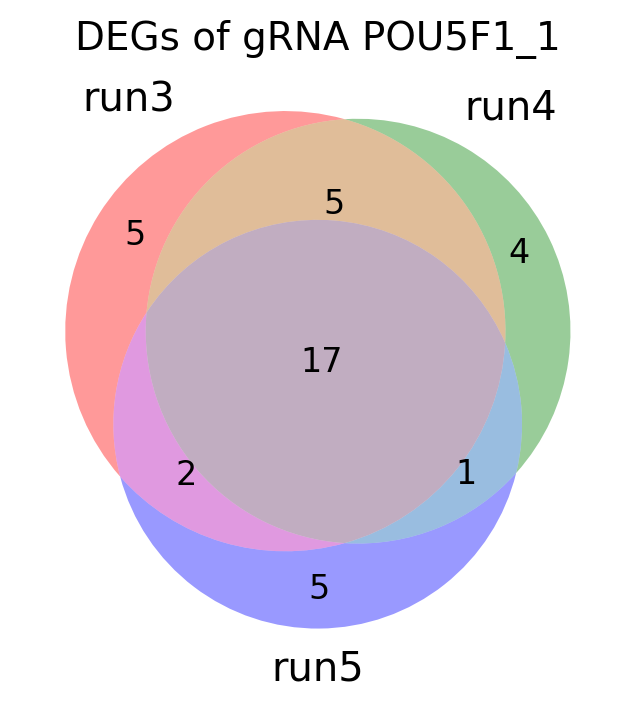

In [52]:
plot_venn3(degs3, degs4, degs5, "run3", "run4", "run5", title="DEGs of gRNA POU5F1_1")

Run DE with higher number of cells per rep

In [13]:
debug_res2 = differential_expression_multiple_runs(test_adata, min_cells_per_rep=20,
                                                  n_runs_per_target=5, debug=True)

Running in debug mode with 3 perturbations


Running DE analysis:   0%|          | 0/15 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is es

In [16]:
test_df1 = debug_res["POU5F1_1-run1"]
test_df1[test_df1["padj"] < 0.05]

baseMean  log2FoldChange     lfcSE      stat        pvalue      padj
DPP10  84.405180        4.084894  0.802063  5.092985  3.524694e-07  0.004939
PALLD  31.454393        5.440183  1.187741  4.580278  4.643576e-06  0.032535

In [17]:
test_df2 = debug_res["POU5F1_1-run2"]
test_df2[test_df2["padj"] < 0.05]

Empty DataFrame
Columns: [baseMean, log2FoldChange, lfcSE, stat, pvalue, padj]
Index: []

In [ ]:
test_df3 = debug_res["POU5F1_1-run3"]
test_df3[test_df3["padj"] < 0.05]

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
CRABP2      13.290877        4.579100  1.193410  3.836986  1.245534e-04   
MIR205HG    11.197178        3.714162  1.071801  3.465346  5.295491e-04   
SOX11       13.892107        3.001957  0.862740  3.479562  5.022344e-04   
LTBP1       17.410287        3.585396  0.875193  4.096693  4.190933e-05   
DPP10       80.131645        3.915416  0.483312  8.101214  5.441353e-16   
EPHA4       14.612873        4.792277  1.212491  3.952424  7.736363e-05   
ARL4C       16.148829        4.282145  1.023203  4.185041  2.851142e-05   
RPL22L1     19.344911       -2.285759  0.663402 -3.445511  5.699806e-04   
LINC01208   23.057779        6.441846  1.538717  4.186506  2.832819e-05   
GRID2      117.601815       -1.552899  0.320676 -4.842588  1.281590e-06   
PALLD       29.280744        5.213450  0.947438  5.502683  3.740542e-08   
ADCY2       19.591941       -2.084055  0.635010 -3.281927  1.031004e-03   
FBN2        22.377513        4.378911  0.913784  4.792064  1.650746e-06   
POU5F1      31.284683       -1.925577  0.495838 -3.883482  1.029710e-04   
HMGN3       52.560047        1.662682  0.387914  4.286213  1.817448e-05   
EPHA7       11.248968        5.407375  1.600783  3.377956  7.302669e-04   
BBS9        21.213265        2.676932  0.656533  4.077375  4.554697e-05   
GLI3        26.493970        3.028936  0.625472  4.842644  1.281228e-06   
MEST        23.054625        3.342391  0.701127  4.767168  1.868339e-06   
STC1        12.192663        4.485686  1.222194  3.670191  2.423696e-04   
LRRC4C      27.766961        2.845140  0.589937  4.822782  1.415696e-06   
MALAT1     194.609158        1.260852  0.227547  5.541067  3.006347e-08   
CADM1       23.956754        4.477381  0.874719  5.118651  3.077284e-07   
SOX5        18.394905        3.374509  0.830548  4.062990  4.844805e-05   
HMGA2       22.186814        2.013116  0.598309  3.364676  7.663361e-04   
NAV3        11.120040        3.303755  0.997901  3.310703  9.306179e-04   
GNAS        37.244312        1.539772  0.451613  3.409498  6.508254e-04   
NLGN4X      22.067953       -2.173438  0.623315 -3.486901  4.886530e-04   
PCDH11X     27.841778        2.424394  0.566573  4.279052  1.876909e-05   

                   padj  
CRABP2     8.797404e-03  
MIR205HG   3.089804e-02  
SOX11      3.063630e-02  
LTBP1      4.017309e-03  
DPP10      7.302295e-13  
EPHA4      6.107176e-03  
ARL4C      2.943256e-03  
RPL22L1    3.187141e-02  
LINC01208  2.943256e-03  
GRID2      2.714091e-04  
PALLD      1.673269e-05  
ADCY2      4.771060e-02  
FBN2       2.769126e-04  
POU5F1     7.677064e-03  
HMGN3      2.289829e-03  
EPHA7      3.769301e-02  
BBS9       4.063580e-03  
GLI3       2.714091e-04  
MEST       2.785901e-04  
STC1       1.626300e-02  
LRRC4C     2.714091e-04  
MALAT1     1.673269e-05  
CADM1      1.032429e-04  
SOX5       4.063580e-03  
HMGA2      3.808974e-02  
NAV3       4.460318e-02  
GNAS       3.493631e-02  
NLGN4X     3.063630e-02  
PCDH11X    2.289829e-03

In [22]:
print(f"{test_df3[test_df3['padj'] < 0.05].shape[0]} genes with padj < 0.05")
print(f"{test_df3[test_df3['pvalue'] < 0.05].shape[0]} genes with pval < 0.05")

29 genes with padj < 0.05
189 genes with pval < 0.05


In [19]:
test_df4 = debug_res["POU5F1_1-run4"]
test_df4[test_df4["padj"] < 0.05]

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
CRABP2      13.558213        3.673994  0.994884  3.692887  2.217223e-04   
SOX11       13.910844        2.813721  0.858197  3.278644  1.043072e-03   
LTBP1       16.325508        3.628930  0.908997  3.992236  6.545307e-05   
DPP10       77.855226        3.813752  0.435049  8.766249  1.847171e-18   
ARL4C       15.540173        3.546173  0.911966  3.888493  1.008684e-04   
LINC01208   23.756048        6.566737  1.535864  4.275599  1.906241e-05   
ADGRL3      25.733006        2.074820  0.588072  3.528171  4.184417e-04   
GRID2      111.709197       -1.415276  0.279884 -5.056644  4.266988e-07   
PALLD       31.618757        4.112653  0.709107  5.799766  6.640767e-09   
ADCY2       21.958400       -2.244271  0.640816 -3.502208  4.614197e-04   
FBN2        22.043918        4.845772  0.991023  4.889667  1.010069e-06   
POU5F1      34.482304       -2.228584  0.586644 -3.798871  1.453565e-04   
HMGN3       51.286707        1.613203  0.438197  3.681455  2.319067e-04   
EPHA7       11.032070        4.416443  1.279098  3.452780  5.548410e-04   
GLI3        27.747511        3.036202  0.640071  4.743538  2.100176e-06   
MEST        24.154660        2.695500  0.649080  4.152803  3.284276e-05   
TLE4        14.617901        4.825984  1.213345  3.977420  6.966717e-05   
NEBL        17.373298        2.577446  0.753476  3.420741  6.245083e-04   
LRRC4C      32.363217        2.061889  0.529193  3.896290  9.767756e-05   
MALAT1     208.888659        1.573882  0.209662  7.506771  6.060350e-14   
CADM1       22.430574        4.879076  1.008896  4.836055  1.324410e-06   
SOX5        18.682649        3.832923  0.874899  4.380987  1.181429e-05   
NAV3        10.920535        3.758586  1.122286  3.349043  8.109116e-04   
WWOX        24.992938        1.937579  0.591536  3.275504  1.054737e-03   
NLGN4X      24.638071       -2.116808  0.606263 -3.491565  4.802003e-04   
PCDH11X     29.789255        2.493723  0.580416  4.296439  1.735641e-05   
PCDH11Y     30.094902        4.042588  0.739097  5.469632  4.509719e-08   

                   padj  
CRABP2     1.313324e-02  
SOX11      4.203321e-02  
LTBP1      5.354420e-03  
DPP10      1.987556e-15  
ARL4C      6.783400e-03  
LINC01208  1.864650e-03  
ADGRL3     2.251216e-02  
GRID2      9.182559e-05  
PALLD      2.381822e-06  
ADCY2      2.348616e-02  
FBN2       1.811391e-04  
POU5F1     9.200210e-03  
HMGN3      1.313324e-02  
EPHA7      2.595691e-02  
GLI3       2.824737e-04  
MEST       2.944901e-03  
TLE4       5.354420e-03  
NEBL       2.799879e-02  
LRRC4C     6.783400e-03  
MALAT1     3.260468e-11  
CADM1      2.035807e-04  
SOX5       1.412464e-03  
NAV3       3.490163e-02  
WWOX       4.203321e-02  
NLGN4X     2.348616e-02  
PCDH11X    1.864650e-03  
PCDH11Y    1.213114e-05

Run DE on gRNA with a large number of cells

In [55]:
gRNA_value_counts = adata[adata.obs.perturbed == "True"].obs.gRNA.value_counts()
gRNA_value_counts.head()

gRNA
HNF1A_1       279
BHLHE40_1     279
ARHGAP35_3    252
ZFP41_3       241
HNF4A_2       239
Name: count, dtype: int64

In [81]:
gRNA_value_counts[20]

190

In [66]:
gRNA_high = gRNA_value_counts.head().index.tolist()
print(gRNA_high)

['HNF1A_1', 'BHLHE40_1', 'ARHGAP35_3', 'ZFP41_3', 'HNF4A_2']


In [67]:
test_adata_high = adata[(adata.obs.perturbed == "False") | 
                        (adata.obs.gRNA.isin(gRNA_high))].copy()

In [68]:
high_de_res = differential_expression_multiple_runs(test_adata_high)

Running DE analysis:   0%|          | 0/25 [00:00<?, ?it/s]

In [69]:
high_de_res_dict = dict()
for gRNA in gRNA_high:
    high_de_res_dict[gRNA] = get_degs_across_runs(high_de_res, gRNA)

In [71]:
for gRNA in gRNA_high:
    degs_per_run = high_de_res_dict[gRNA][2]
    print(f"{gRNA} DEGs per run: {[len(degs_per_run[i]) for i in degs_per_run]}")

HNF1A_1 DEGs per run: [0, 0, 0, 0, 0]
BHLHE40_1 DEGs per run: [0, 0, 0, 0, 0]
ARHGAP35_3 DEGs per run: [2, 2, 2, 3, 2]
ZFP41_3 DEGs per run: [0, 0, 0, 0, 0]
HNF4A_2 DEGs per run: [0, 1, 0, 1, 1]


In [73]:
gRNA_high2 = gRNA_value_counts[5:10].index.tolist()
print(gRNA_high2)

['ZNF658_2', 'ZNF354A_1', 'VDR_2', 'ADNP2_1', 'ESR1_1']


In [74]:
test_adata_high2 = adata[(adata.obs.perturbed == "False") | 
                        (adata.obs.gRNA.isin(gRNA_high2))].copy()

In [75]:
high_de_res2 = differential_expression_multiple_runs(test_adata_high2)

Running DE analysis:   0%|          | 0/25 [00:00<?, ?it/s]

In [76]:
high_de_res_dict2 = dict()
for gRNA in gRNA_high2:
    high_de_res_dict2[gRNA] = get_degs_across_runs(high_de_res2, gRNA)
for gRNA in gRNA_high2:
    degs_per_run = high_de_res_dict2[gRNA][2]
    print(f"{gRNA} DEGs per run: {[len(degs_per_run[i]) for i in degs_per_run]}")

ZNF658_2 DEGs per run: [0, 0, 0, 0, 0]
ZNF354A_1 DEGs per run: [0, 0, 0, 0, 0]
VDR_2 DEGs per run: [0, 0, 0, 0, 0]
ADNP2_1 DEGs per run: [1, 1, 1, 1, 1]
ESR1_1 DEGs per run: [0, 0, 0, 0, 0]


In [77]:
gRNA_high3 = gRNA_value_counts[10:20].index.tolist()
print(gRNA_high3)

['ZFP37_2', 'ZSCAN18_3', 'ESR2_2', 'ZFP41_2', 'ESRRG_2', 'ZFP57_2', 'ESRRG_1', 'ZBTB22_2', 'ESR1_2', 'PHF1_3']


In [78]:
test_adata_high3 = adata[(adata.obs.perturbed == "False") | 
                        (adata.obs.gRNA.isin(gRNA_high3))].copy()

In [79]:
high_de_res3 = differential_expression_multiple_runs(test_adata_high3)

Running DE analysis:   0%|          | 0/50 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)


In [80]:
high_de_res_dict3 = dict()
for gRNA in gRNA_high3:
    high_de_res_dict3[gRNA] = get_degs_across_runs(high_de_res3, gRNA)
for gRNA in gRNA_high3:
    degs_per_run = high_de_res_dict3[gRNA][2]
    print(f"{gRNA} DEGs per run: {[len(degs_per_run[i]) for i in degs_per_run]}")

ZFP37_2 DEGs per run: [0, 0, 0, 0, 0]
ZSCAN18_3 DEGs per run: [0, 1, 0, 0, 0]
ESR2_2 DEGs per run: [0, 0, 0, 0, 0]
ZFP41_2 DEGs per run: [0, 1, 0, 0, 0]
ESRRG_2 DEGs per run: [0, 0, 0, 0, 0]
ZFP57_2 DEGs per run: [0, 0, 0, 0, 0]
ESRRG_1 DEGs per run: [0, 0, 0, 0, 0]
ZBTB22_2 DEGs per run: [0, 0, 0, 0, 0]
ESR1_2 DEGs per run: [0, 0, 0, 0, 0]
PHF1_3 DEGs per run: [0, 0, 0, 0, 0]


In [ ]:
print(f"gRNA has {adata[adata.obs.gRNA == 'gRNA'].shape[0]} cells")

# Fall 2025 Week 6

Now using 5 DE runs per gRNA/gene target. This week, test combining p-values and overlapping pseudoreplicates.

In [46]:
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import gc

def generate_pseudoreplicates_for_DE(adata: ad.AnnData, 
                                     target_value: str, 
                                     ntc_cell_indices: pd.Index, 
                                     rng: np.random.Generator, 
                                     target_column: str = "perturbation", 
                                     min_cells_per_rep: int = 20,
                                     layer: str = "counts"):
    """
    Generate independent pseudoreplicates for a given target (gRNA or gene target) 
    and matched NTC cells. Manually set NTC as reference for DE analysis.
    """
    # Create views for target and NTC cells
    if target_column not in adata.obs:
        print(f"Error: {target_column} not in adata.obs")
        return
    target_mask = adata.obs[target_column] == target_value
    target_view = adata[target_mask]
    ntc_view = adata[ntc_cell_indices]

    # Get data matrices from counts layer
    if layer in adata.layers:
        target_data = target_view.layers[layer]
        ntc_data = ntc_view.layers[layer]
    else:
        target_data = target_view.X
        ntc_data = ntc_view.X        
    
    # Convert to dense if sparse
    if sparse.issparse(target_data):
        target_data = target_data.toarray()
    if sparse.issparse(ntc_data):
        ntc_data = ntc_data.toarray()

    # Calculate number of cells to sample
    n_target_cells = target_data.shape[0]
    n_ntc_cells = ntc_data.shape[0]
    if n_target_cells >= min_cells_per_rep * 2:
        n_reps = min(3, n_target_cells // min_cells_per_rep)
    else: # If too few cells for 2 reps x min_cells_per_rep cells
        n_reps = 2
    target_rep_size = n_target_cells // n_reps
    ntc_rep_size = min(target_rep_size, n_ntc_cells // n_reps)
    if ntc_rep_size < target_rep_size:
        print("Warning: Unmatched number of target and NTC cells")

    # Pre-allocate arrays for results
    target_bulk = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
    ntc_bulk = np.zeros((n_reps, ntc_data.shape[1]), dtype=np.int64)

    # Sample cells for all replicates
    target_sample_size = target_rep_size * n_reps
    ntc_sample_size = ntc_rep_size * n_reps
    sampled_target_indices = \
        rng.choice(n_target_cells, target_sample_size, replace=False)
    sampled_ntc_indices = \
        rng.choice(n_ntc_cells, ntc_sample_size, replace=False)
    # Generate replicates using vectorized operations
    for i in range(n_reps):
        # Sample indices
        target_start, target_stop = i*target_rep_size, (i+1)*target_rep_size
        target_rep_indices = sampled_target_indices[target_start:target_stop]
        ntc_start, ntc_stop = i*ntc_rep_size, (i+1)*ntc_rep_size
        ntc_rep_indices = sampled_ntc_indices[ntc_start:ntc_stop]

        # Calculate sums using vectorized operations
        target_bulk[i] = np.sum(target_data[target_rep_indices], axis=0).astype(np.int64)
        ntc_bulk[i] = np.sum(ntc_data[ntc_rep_indices], axis=0).astype(np.int64)  

    # Create sample names
    if "_" in target_value:
        target_value = target_value.replace("_", "-")
    sample_names = [f"{target_value}-rep{i+1}" for i in range(n_reps)]
    control_names = [f"NTC-rep{i+1}" for i in range(n_reps)]
    
    # Combine data
    combined_data = np.vstack([target_bulk, ntc_bulk])
    combined_names = sample_names + control_names
    
    # Create metadata DF
    metadata_df = pd.DataFrame({
        'condition': [target_value] * n_reps + ['NTC'] * n_reps
    }, index=combined_names)
    # Set NTC as reference for DESeq2
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", target_value],
        ordered=True
        )
    
    # Create counts DF
    counts_df = pd.DataFrame(
        combined_data,
        index=combined_names,
        columns=adata.var_names
    )

    return counts_df, metadata_df

def differential_expression_multiple_runs(adata: ad.AnnData, 
                    target_column: str = "perturbation", 
                    ntc_cells_delimiter: str = "NTC", 
                    alpha: float = 0.05, n_cpus: int = 20, 
                    min_cells_per_rep: int = 20,
                    n_runs_per_target: int = 5,
                    layer: str = "counts", random_state: int = 42, 
                    shrink_lfcs: bool = False, debug: bool = False):
    """
    Run differential expression analysis on each perturbation in the 
    dataset n_runs_per_target times per perturbation. Return dict of 
    {perturbation_run : DE results for that perturbation and run}.
    """
    # Identify KD and NTC cells
    perturbations = list(adata.obs[target_column].unique())
    perturbations.remove(ntc_cells_delimiter) # Remove NTC group
    if debug == True: # Debug mode: run with 3 perturbations
        print(f"Running in debug mode with 3 perturbations")
        perturbations = perturbations[:3]
    ntc_cell_indices = np.where(adata.obs[target_column] == ntc_cells_delimiter)[0]

    # Create multiple runs per perturbation
    if n_runs_per_target > 0:
        perturbations_runs = [f"{pert}-run{i+1}" for pert in perturbations
                                for i in range(n_runs_per_target)]
    else:
        perturbations_runs = perturbations

    # Create RNG object
    de_rng = np.random.default_rng(random_state)
    # Create one child RNG object per perturbation and run
    streams = de_rng.spawn(len(perturbations_runs))

    # Determine how many CPUs to use per joblib Parallel job
    #   and per DE analysis run
    if n_cpus < 3:
        n_cpus_for_DE = n_cpus
    elif n_cpus <= 10:
        n_cpus_for_DE = 3
    elif 20 <= n_cpus < 30:
        n_cpus_for_DE = 4
    elif 30 <= n_cpus < 50:
        n_cpus_for_DE = 5
    else:
        n_cpus_for_DE = 6
    n_jobs = max(1, n_cpus // n_cpus_for_DE)

    # Warning if given layer not found
    if layer not in adata.layers:
         print(f"Warning: {layer} not in adata.layers, using adata.X instead")

    # Function to run DE analysis on a single perturbation
    quiet = True
    def process_perturbation(target_value: str, rng: np.random.Generator, quiet=quiet):
        # Get actual target value
        if "-run" in target_value:
            target_value = target_value.split("-run")[0]
        
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = generate_pseudoreplicates_for_DE(
            adata, target_value, ntc_cell_indices, rng, 
            target_column=target_column, min_cells_per_rep=min_cells_per_rep,
            layer=layer
        )

        # Set number of CPUs to use for each DE run
        inference = DefaultInference(n_cpus=n_cpus_for_DE) 

        # Read counts modeling and fitting dispersions
        dds = DeseqDataSet(
            counts = pseudo_bulk_df, 
            metadata = metadata_df,
            refit_cooks=True,
            inference=inference,
            quiet=quiet
            )
        dds.deseq2()
        
        # Statistical testing
        target_hyphenated = target_value.replace('_', '-')
        contrast = ["condition", target_hyphenated, ntc_cells_delimiter]
        stat_res = DeseqStats(
            dds, 
            contrast=contrast, 
            alpha=alpha,
            inference=inference,
            quiet=quiet)
        stat_res.summary()
        if shrink_lfcs == True:
            # Shrink LFCs for downstream analysis
            stat_res.lfc_shrink(coeff=f"condition_{contrast[1]}_vs_{contrast[2]}", 
                                adapt=False)
        results_df = stat_res.results_df

        # Clean up memory
        del pseudo_bulk_df, metadata_df, dds, stat_res
        gc.collect()

        # Return results
        return results_df

    # Run DE analysis on all perturbations in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(perturbations_runs)):
        results = Parallel(n_jobs=n_jobs)(delayed(process_perturbation)(target_value, rng)
            for target_value, rng in zip(perturbations_runs, streams))
    
    results_dict = dict(zip(perturbations_runs, results))
    return results_dict

In [47]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

Generate small test dataset

In [48]:
# 30 KDs with highest number of DEGs, from updated pipeline example notebook
top_30_kds_by_n_degs = \
    {'MYADM', 'DBR1', 'POU5F1', 'PTPN1', 'POU5F1B', 'JOSD1', 'ST13', 'HRC', 'TOMM40', 'KAT2A', 
     'PHF20', 'PSMD8', 'NAE1', 'POU3F2', 'HCCS', 'DDX6', 'SMARCC1', 'DNMT1', 'TMX2', 'SMARCE1', 
     'TADA2B', 'VHL', 'TAF4', 'EMSY', 'ZNF521', 'RBM14', 'NANOG', 'IDI1', 'RNF7', 'ZNF396'}

# KDs to test
test_kds = top_30_kds_by_n_degs & set(adata.obs.gene_target.unique().tolist())
print(f"{len(test_kds)} KDs to test: {', '.join(test_kds)}")

# gRNA to test
gRNA_to_test = adata[adata.obs.gene_target.isin(test_kds)].obs.gRNA.unique().tolist()
print(f"{len(gRNA_to_test)} gRNA to test")
print(gRNA_to_test)

8 KDs to test: ZNF521, DNMT1, NANOG, POU5F1B, ZNF396, PHF20, POU3F2, POU5F1
14 gRNA to test
['PHF20_1', 'DNMT1_1', 'POU5F1_1', 'NANOG_1', 'ZNF396_2', 'ZNF396_1', 'POU5F1B_1', 'POU5F1_2', 'DNMT1_3', 'POU5F1_3', 'DNMT1_2', 'POU3F2_2', 'ZNF521_1', 'NANOG_2']


In [49]:
test_adata = adata[(adata.obs.perturbed == "False") |
                   (adata.obs.gene_target.isin(test_kds))].copy()
test_adata

AnnData object with n_obs × n_vars = 14437 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

## DE analysis - combining p-values

Run DE on test_adata with 5 DE runs per gRNA and minimum 20 cells per pseudoreplicate

In [50]:
test_DE_res = differential_expression_multiple_runs(
    test_adata, min_cells_per_rep=20, n_runs_per_target=5, n_cpus=30)

Running DE analysis:   0%|          | 0/70 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is es

In [51]:
def build_DE_test_results_df(de_results_dict: dict, adata: ad.AnnData, 
                             target_column: str = "gRNA",
                             alpha: float=0.05, padj_col: str = "padj",
                             run_delimiter: str = "-run"):
    """
    Build DataFrame of each gRNA, number of cells, and DEGs per run.
    """
    target_list = sorted(list({target.split(run_delimiter)[0] 
                               for target in de_results_dict}))
    n_runs = len({target.split(run_delimiter)[1] for target in de_results_dict})
    n_cells_list = [adata[adata.obs[target_column] == target].shape[0] 
                    for target in target_list]
    n_degs_dict = {f"Run{i} DEGs": list() for i in range(1, n_runs+1)}

    for target in target_list:
        for i in range(1, n_runs+1):
            de_run_df = de_results_dict[f"{target}-run{i}"]
            degs = set(de_run_df[de_run_df[padj_col] < alpha].index.tolist())
            n_degs_dict[f"Run{i} DEGs"].append(len(degs))
    results_dict = {target_column: target_list, "# cells": n_cells_list} | n_degs_dict
    results_df = pd.DataFrame.from_dict(results_dict)
    degs_df = results_df.iloc[:,2:]
    median_degs = degs_df.median(axis=1).astype(int)
    mean_degs = degs_df.mean(axis=1)
    results_df["Median DEGs"] = median_degs
    results_df["Mean DEGs"] = mean_degs.round(1)
    results_df = results_df.set_index("gRNA")
    return results_df

In [52]:
test_n_degs_df = build_DE_test_results_df(test_DE_res, test_adata)

In [53]:
display(test_n_degs_df.sort_values(by="# cells"))

# cells  Run1 DEGs  Run2 DEGs  Run3 DEGs  Run4 DEGs  Run5 DEGs  \
gRNA                                                                        
POU5F1_1        27          2          0         29         27         25   
POU5F1_2        29          0         26         48         55         48   
NANOG_1         38          1          2          2          1          0   
POU5F1B_1       44         80         74         84         74         71   
DNMT1_2         45          2          2          6          3          5   
PHF20_1         46         61         55         53         51         58   
POU3F2_2        50         29         36         34         50         32   
DNMT1_1         50          3          0          0          3          2   
POU5F1_3        50         50         54         64         70         57   
ZNF396_2        51         10         21         25          0          0   
DNMT1_3         52          5          0          0          7          0   
NANOG_2         81         30         48         33         35         41   
ZNF521_1        83         46         51         11         49         56   
ZNF396_1       117          0          0          0          0          0   

           Median DEGs  Mean DEGs  
gRNA                               
POU5F1_1            25       16.6  
POU5F1_2            48       35.4  
NANOG_1              1        1.2  
POU5F1B_1           74       76.6  
DNMT1_2              3        3.6  
PHF20_1             55       55.6  
POU3F2_2            34       36.2  
DNMT1_1              2        1.6  
POU5F1_3            57       59.0  
ZNF396_2            10       11.2  
DNMT1_3              0        2.4  
NANOG_2             35       37.4  
ZNF521_1            49       42.6  
ZNF396_1             0        0.0

We will use the gRNA POU5F1_3 (with 50 cells and 50-70 DEGs per run) and ZNF521_1 (with 83 cells and 11-56 DEGs per run) to test the p-value combination methods.

In [21]:
pou5f1_3_run1_df = test_DE_res["POU5F1_3-run1"]
pou5f1_3_run1_df.head()

baseMean  log2FoldChange     lfcSE      stat    pvalue  padj
ENSG00000241860  0.000000             NaN       NaN       NaN       NaN   NaN
ENSG00000290385  0.949386        1.476598  2.765626  0.533911  0.593403   NaN
ENSG00000291215  0.968810       -1.685225  2.758093 -0.611011  0.541192   NaN
LINC01409        0.250000       -1.512336  5.344476 -0.282972  0.777199   NaN
LINC00115        0.000000             NaN       NaN       NaN       NaN   NaN

In [ ]:
def build_multi_run_dfs(target: str, de_results_dict: dict,
                                pvalue_col: str = "pvalue",
                                lfc_col: str = "log2FoldChange",
                                test_stat_col: str = "stat",
                                run_delimiter: str = "-run"):
    """
    Given a perturbation and DE results for that perturbation across
    multiple runs, build 3 DFs of: 1) p-value, 2) median LFC, 
    number of runs with a negative LFC, and number of runs with a 
    positive LFC; 3) Wald test statistic
    """
    target_runs = [run for run in de_results_dict if target in run]
    n_runs = len(target_runs)
    genes = de_results_dict[target_runs[0]].index
    pvals_dict, stat_dict = dict(), dict()
    lfc_array = np.zeros((len(genes), n_runs))

    # Check that all run DFs have same index; if not, sort later
    sort_genes = False
    for run in target_runs[1:]:
        if not de_results_dict[run].index.equals(genes):
            sort_genes = True
            print("DE run results do not all have same index")
    
    # Get p-values and LFCs from each run
    for i in range(n_runs):
        run_df = de_results_dict[target + run_delimiter + str(i+1)]
        if sort_genes:
            run_df = run_df.sort_index()
        lfc_array[:, i] = run_df[lfc_col].values
        pvals_dict[f"Run{i+1} pval"] = run_df[pvalue_col]
        stat_dict[f"Run{i+1} stat"] = run_df[test_stat_col]

    # Process LFCs
    median_lfcs = np.nanmedian(lfc_array, axis=1)
    n_pos_lfcs = (lfc_array > 0).sum(axis=1)
    n_neg_lfcs = (lfc_array < 0).sum(axis=1)
    lfc_dict = {"Median LFC": median_lfcs, 
                "# positive LFCs": n_pos_lfcs,
                "# negative LFCs": n_neg_lfcs}

    pval_df = pd.DataFrame.from_dict({"Gene": genes} | pvals_dict)
    pval_df.set_index("Gene", inplace=True)
    pval_df.index.rename("", inplace=True)
    lfc_df = pd.DataFrame.from_dict({"Gene": genes} | lfc_dict)
    lfc_df.set_index("Gene", inplace=True)
    lfc_df.index.rename("", inplace=True)
    stat_df = pd.DataFrame.from_dict({"Gene": genes} | stat_dict)
    stat_df.set_index("Gene", inplace=True)
    stat_df.index.rename("", inplace=True)
    return pval_df, lfc_df, stat_df

In [23]:
test_POU5F1_3_pval_df, test_POU5F1_3_lfc_df, test_POU5F1_3_stat_df = \
    build_multi_run_dfs("POU5F1_3", test_DE_res)

/tmp/ipykernel_1975942/3329123028.py:35: RuntimeWarning: All-NaN slice encountered


In [24]:
test_POU5F1_3_pval_df.sort_values(by="Run1 pval")

Run1 pval     Run2 pval     Run3 pval     Run4 pval     Run5 pval
                                                                            
DPP10   1.201163e-36  1.903675e-13  1.898331e-35  3.389900e-38  1.140537e-34
MALAT1  1.195492e-23  1.985840e-06  2.674618e-19  1.390739e-17  8.315330e-17
LRRC4C  1.069916e-13  1.208603e-10  4.083109e-12  7.678643e-13  3.825185e-10
GRID2   6.167470e-13  2.370232e-09  8.916936e-07  6.431171e-08  9.904301e-13
PALLD   1.114617e-12  6.893450e-12  3.548127e-12  1.276954e-12  2.136295e-13
...              ...           ...           ...           ...           ...
SMIM10           NaN           NaN  7.661978e-01           NaN  7.775186e-01
EOLA2            NaN  5.434292e-01  7.768035e-01  7.775844e-01  7.845702e-01
GABRE            NaN           NaN           NaN           NaN  7.845702e-01
HAUS7            NaN  7.840111e-01  2.163654e-01  5.459473e-01  7.775186e-01
RENBP            NaN           NaN  7.768035e-01  7.753716e-01           NaN

[16115 rows x 5 columns]

In [55]:
small_test_POU5F1_3_pval_df = test_POU5F1_3_pval_df.sort_values(by="Run1 pval").head()
small_test_POU5F1_3_pval_df = small_test_POU5F1_3_pval_df.sort_index()
small_test_POU5F1_3_pval_df

Run1 pval     Run2 pval     Run3 pval     Run4 pval     Run5 pval
                                                                            
DPP10   1.201163e-36  1.903675e-13  1.898331e-35  3.389900e-38  1.140537e-34
GRID2   6.167470e-13  2.370232e-09  8.916936e-07  6.431171e-08  9.904301e-13
LRRC4C  1.069916e-13  1.208603e-10  4.083109e-12  7.678643e-13  3.825185e-10
MALAT1  1.195492e-23  1.985840e-06  2.674618e-19  1.390739e-17  8.315330e-17
PALLD   1.114617e-12  6.893450e-12  3.548127e-12  1.276954e-12  2.136295e-13

In [56]:
small_test_POU5F1_3_stat_df = \
test_POU5F1_3_stat_df[test_POU5F1_3_stat_df.index.isin(small_test_POU5F1_3_pval_df.index.tolist())]
small_test_POU5F1_3_stat_df.sort_index()
small_test_POU5F1_3_stat_df

Run1 stat  Run2 stat  Run3 stat  Run4 stat  Run5 stat
                                                             
DPP10   12.644414   7.355392  12.425585  12.921828  12.281368
GRID2   -7.196728  -5.970158  -4.914148  -5.406379  -7.131830
PALLD    7.115557   6.859847   6.954103   7.096782   7.339978
LRRC4C   7.431971   6.438248   6.934275   7.166773   6.260999
MALAT1  10.024012   4.754860   8.981351   8.535896   8.326663

In [57]:
test_POU5F1_3_lfc_df.head()

Median LFC  # positive LFCs  # negative LFCs
                                                             
ENSG00000241860   -3.020088                0                3
ENSG00000290385    1.476598                5                0
ENSG00000291215   -1.031940                0                5
LINC01409         -1.586175                0                3
LINC00115               NaN                0                0

In [58]:
test_POU5F1_3_stat_df.head()

Run1 stat  Run2 stat  Run3 stat  Run4 stat  Run5 stat
                                                                      
ENSG00000241860        NaN  -0.274096  -0.870004        NaN  -0.799269
ENSG00000290385   0.533911   0.177133   0.542203   0.830094   0.546902
ENSG00000291215  -0.611011  -0.284517  -0.024674  -0.632254  -0.351921
LINC01409        -0.282972  -1.018781  -0.297352        NaN        NaN
LINC00115              NaN        NaN        NaN        NaN        NaN

Combine p-values

In [55]:
from scipy.stats import combine_pvalues, false_discovery_control
metacp_root = "/home/ranwyl/metacp/"
if metacp_root not in sys.path:
    sys.path.insert(0, metacp_root)
import metacp
import warnings

def combine_pvalues_single_target(pval_df: pd.DataFrame, pval_method: str,
                                  stat_df = None,
                                  nan_policy: str = "propagate", 
                                  fdr_method: str = "bh"):
    pval_df = pval_df.copy()
    # Combine p-values
    combined_pvals = list()
    if pval_method == "fisher" or pval_method == "stouffer":
        for i in range(len(pval_df)):
            gene_pvals = pval_df.iloc[i].values
            combined_pvals.append(
                combine_pvalues(gene_pvals, method=pval_method, 
                                nan_policy=nan_policy).pvalue)
    elif pval_method == "cauchy": # Cauchy Combination Test
        for i in range(len(pval_df)):
            gene_pvals = pval_df.iloc[i].values
            combined_pvals.append(
                metacp.cauchy_method(gene_pvals, data_type="pvals"))
    elif pval_method == "hmp": # Harmonic Mean P-value
        for i in range(len(pval_df)):
            gene_pvals = pval_df.iloc[i].values
            combined_pvals.append(
                 len(gene_pvals) / np.sum(1 / gene_pvals))
    elif pval_method == "ebm": # Empirical Brown's method
        if stat_df is None:
            print(f"Error: Need test statistic DataFrame for EBM")
            return
        stat_df_clean = stat_df.dropna(axis=0)
        for i in range(len(pval_df)):
            gene_pvals = pval_df.iloc[i].values
            if np.any(np.isnan(gene_pvals)):
                combined_pvals.append(np.nan)
            else:
                combined_pvals.append(
                    metacp.EmpiricalBrownsMethod(
                        gene_pvals, stat_df_clean.values, data_type="pvals"))
    pval_col = f"Combined pval ({pval_method})"
    pval_df[pval_col] = combined_pvals
    
    # FDR
    nan_mask = pval_df[pval_col].notna()
    fdrs = false_discovery_control(pval_df.loc[nan_mask, pval_col], 
                                   method=fdr_method)
    fdr_col = f"FDR ({pval_method}, {fdr_method})"
    pval_df[fdr_col] = np.nan
    pval_df.loc[nan_mask, fdr_col] = fdrs
    return pval_df

def get_n_degs(pval_df: pd.DataFrame, fdr_col: str, alpha: float = 0.05):
    return(pval_df[pval_df[fdr_col] < alpha].shape[0])

def test_pval_combination_methods(targets: list,
                                  de_results_dict: dict,
                                  n_degs_df: pd.DataFrame,
                                  alpha: float=0.05,
                                  target_delimiter: str="gRNA",
                                  pvalue_col: str = "pvalue",
                                  lfc_col: str = "log2FoldChange",
                                  test_stat_col: str = "stat",
                                  run_delimiter: str = "-run",
                                  catch_warnings: bool=True):
    df_dict = dict()

    for target in targets:
        if catch_warnings:
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                pval_df, lfc_df, stat_df = \
                    build_multi_run_dfs(target, de_results_dict,
                                        pvalue_col=pvalue_col, lfc_col=lfc_col,
                                        test_stat_col=test_stat_col,
                                        run_delimiter=run_delimiter)
        else:
            pval_df, lfc_df, stat_df = \
                build_multi_run_dfs(target, de_results_dict,
                                    pvalue_col=pvalue_col, lfc_col=lfc_col,
                                    test_stat_col=test_stat_col,
                                    run_delimiter=run_delimiter)
        
        fisher_df = combine_pvalues_single_target(pval_df, pval_method="fisher")
        stouffer_df = combine_pvalues_single_target(pval_df, pval_method="stouffer")
        cauchy_df = combine_pvalues_single_target(pval_df, pval_method="cauchy")
        hmp_df = combine_pvalues_single_target(pval_df, pval_method="hmp")
        n_cells = n_degs_df.loc[target, '# cells']
        median_degs = n_degs_df.loc[target, 'Median DEGs']
        mean_degs = n_degs_df.loc[target, 'Mean DEGs']
        fisher_degs = get_n_degs(fisher_df, 'FDR (fisher, bh)', alpha=alpha)
        stouffer_degs = get_n_degs(stouffer_df, 'FDR (stouffer, bh)', alpha=alpha)
        cauchy_degs = get_n_degs(cauchy_df, 'FDR (cauchy, bh)', alpha=alpha)
        hmp_degs = get_n_degs(hmp_df, 'FDR (hmp, bh)', alpha=alpha)
        df_dict[target] = [n_cells, median_degs, mean_degs, fisher_degs, stouffer_degs,
                           cauchy_degs, hmp_degs]
    
    results_cols = ["# cells", "Median", "Mean", "Fisher's", "Stouffer's", "CCT", "HMP"]
    results_df = pd.DataFrame.from_dict(df_dict, orient="index", columns=results_cols)
    return results_df


In [ ]:
# Old DE functions - individual DE, 5 runs, no overlaps
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import gc
from scipy.stats import false_discovery_control
metacp_root = "/home/ranwyl/metacp/"
if metacp_root not in sys.path:
    sys.path.insert(0, metacp_root)
import metacp
import warnings


def generate_pseudoreplicates_for_DE(adata: ad.AnnData, 
                                     target_value: str, 
                                     ntc_cell_indices: pd.Index, 
                                     rng: np.random.Generator, 
                                     target_column: str = "perturbation", 
                                     min_cells_per_rep: int = 20,
                                     layer: str = "counts"):
    """
    Generate independent pseudoreplicates for a given target (gRNA or gene target) 
    and matched NTC cells. Manually set NTC as reference for DE analysis.
    """
    # Create views for target and NTC cells
    if target_column not in adata.obs:
        print(f"Error: {target_column} not in adata.obs")
        return
    target_mask = adata.obs[target_column] == target_value
    target_view = adata[target_mask]
    ntc_view = adata[ntc_cell_indices]

    # Get data matrices from counts layer
    if layer in adata.layers:
        target_data = target_view.layers[layer]
        ntc_data = ntc_view.layers[layer]
    else:
        target_data = target_view.X
        ntc_data = ntc_view.X        
    
    # Convert to dense if sparse
    if sparse.issparse(target_data):
        target_data = target_data.toarray()
    if sparse.issparse(ntc_data):
        ntc_data = ntc_data.toarray()

    # Calculate number of cells to sample
    n_target_cells = target_data.shape[0]
    n_ntc_cells = ntc_data.shape[0]
    if n_target_cells >= min_cells_per_rep * 2:
        n_reps = min(3, n_target_cells // min_cells_per_rep)
    else: # If too few cells for 2 reps x min_cells_per_rep cells
        n_reps = 2
    target_rep_size = n_target_cells // n_reps
    ntc_rep_size = min(target_rep_size, n_ntc_cells // n_reps)
    if ntc_rep_size < target_rep_size:
        print("Warning: Unmatched number of target and NTC cells")

    # Pre-allocate arrays for results
    target_bulk = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
    ntc_bulk = np.zeros((n_reps, ntc_data.shape[1]), dtype=np.int64)

    # Sample cells for all replicates
    target_sample_size = target_rep_size * n_reps
    ntc_sample_size = ntc_rep_size * n_reps
    sampled_target_indices = \
        rng.choice(n_target_cells, target_sample_size, replace=False)
    sampled_ntc_indices = \
        rng.choice(n_ntc_cells, ntc_sample_size, replace=False)
    # Generate replicates using vectorized operations
    for i in range(n_reps):
        # Sample indices
        target_start, target_stop = i*target_rep_size, (i+1)*target_rep_size
        target_rep_indices = sampled_target_indices[target_start:target_stop]
        ntc_start, ntc_stop = i*ntc_rep_size, (i+1)*ntc_rep_size
        ntc_rep_indices = sampled_ntc_indices[ntc_start:ntc_stop]

        # Calculate sums using vectorized operations
        target_bulk[i] = np.sum(target_data[target_rep_indices], axis=0).astype(np.int64)
        ntc_bulk[i] = np.sum(ntc_data[ntc_rep_indices], axis=0).astype(np.int64)  

    # Create sample names
    if "_" in target_value:
        target_value = target_value.replace("_", "-")
    sample_names = [f"{target_value}-rep{i+1}" for i in range(n_reps)]
    control_names = [f"NTC-rep{i+1}" for i in range(n_reps)]
    
    # Combine data
    combined_data = np.vstack([target_bulk, ntc_bulk])
    combined_names = sample_names + control_names
    
    # Create metadata DF
    metadata_df = pd.DataFrame({
        'condition': [target_value] * n_reps + ['NTC'] * n_reps
    }, index=combined_names)
    # Set NTC as reference for DESeq2
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", target_value],
        ordered=True
        )
    
    # Create counts DF
    counts_df = pd.DataFrame(
        combined_data,
        index=combined_names,
        columns=adata.var_names
    )

    return counts_df, metadata_df

def differential_expression_multiple_runs(adata: ad.AnnData, 
                    target_column: str = "perturbation", 
                    ntc_cells_delimiter: str = "NTC", 
                    alpha: float = 0.05, n_cpus: int = 20, 
                    min_cells_per_rep: int = 20,
                    n_runs_per_target: int = 5,
                    layer: str = "counts", random_state: int = 42, 
                    shrink_lfcs: bool = False, debug: bool = False):
    """
    Run differential expression analysis on each perturbation in the 
    dataset n_runs_per_target times per perturbation. Return dict of 
    {perturbation_run : DE results for that perturbation and run}.
    """
    # Identify KD and NTC cells
    perturbations = list(adata.obs[target_column].unique())
    perturbations.remove(ntc_cells_delimiter) # Remove NTC group
    if debug == True: # Debug mode: run with 3 perturbations
        print(f"Running in debug mode with 3 perturbations")
        perturbations = perturbations[:3]
    ntc_cell_indices = np.where(adata.obs[target_column] == ntc_cells_delimiter)[0]

    # Create multiple runs per perturbation
    if n_runs_per_target > 0:
        perturbations_runs = [f"{pert}-run{i+1}" for pert in perturbations
                                for i in range(n_runs_per_target)]
    else:
        perturbations_runs = perturbations

    # Create RNG object
    de_rng = np.random.default_rng(random_state)
    # Create one child RNG object per perturbation and run
    streams = de_rng.spawn(len(perturbations_runs))

    # Determine how many CPUs to use per joblib Parallel job
    #   and per DE analysis run
    if n_cpus < 3:
        n_cpus_for_DE = n_cpus
    elif n_cpus <= 10:
        n_cpus_for_DE = 3
    elif 20 <= n_cpus < 30:
        n_cpus_for_DE = 4
    elif 30 <= n_cpus < 50:
        n_cpus_for_DE = 5
    else:
        n_cpus_for_DE = 6
    n_jobs = max(1, n_cpus // n_cpus_for_DE)

    # Warning if given layer not found
    if layer not in adata.layers:
         print(f"Warning: {layer} not in adata.layers, using adata.X instead")

    # Function to run DE analysis on a single perturbation
    quiet = True
    def process_perturbation(target_value: str, rng: np.random.Generator, quiet=quiet):
        # Get actual target value
        if "-run" in target_value:
            target_value = target_value.split("-run")[0]
        
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = generate_pseudoreplicates_for_DE(
            adata, target_value, ntc_cell_indices, rng, 
            target_column=target_column, min_cells_per_rep=min_cells_per_rep,
            layer=layer
        )

        # Set number of CPUs to use for each DE run
        inference = DefaultInference(n_cpus=n_cpus_for_DE) 

        # Read counts modeling and fitting dispersions
        dds = DeseqDataSet(
            counts = pseudo_bulk_df, 
            metadata = metadata_df,
            refit_cooks=True,
            inference=inference,
            quiet=quiet
            )
        dds.deseq2()
        
        # Statistical testing
        target_hyphenated = target_value.replace('_', '-')
        contrast = ["condition", target_hyphenated, ntc_cells_delimiter]
        stat_res = DeseqStats(
            dds, 
            contrast=contrast, 
            alpha=alpha,
            inference=inference,
            quiet=quiet)
        stat_res.summary()
        if shrink_lfcs == True:
            # Shrink LFCs for downstream analysis
            stat_res.lfc_shrink(coeff=f"condition_{contrast[1]}_vs_{contrast[2]}", 
                                adapt=False)
        results_df = stat_res.results_df

        # Clean up memory
        del pseudo_bulk_df, metadata_df, dds, stat_res
        gc.collect()

        # Return results
        return results_df

    # Run DE analysis on all perturbations in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(perturbations_runs)):
        results = Parallel(n_jobs=n_jobs)(delayed(process_perturbation)(target_value, rng)
            for target_value, rng in zip(perturbations_runs, streams))
    
    results_dict = dict(zip(perturbations_runs, results))
    return results_dict

def build_multi_DE_run_single_target_df(target: str, de_results_dict: dict,
                                        pvalue_col: str = "pvalue",
                                        lfc_col: str = "log2FoldChange",
                                        run_delimiter: str = "-run"):
    """
    Given a perturbation and DE results for that perturbation across
    multiple runs, combine the p-values via Cauchy Combination Test and
    perform multiple testing correction via BH method.
    """
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        target_runs = [run for run in de_results_dict if target in run]
        n_runs = len(target_runs)
        genes = de_results_dict[target_runs[0]].index
        pval_dict = dict()
        lfc_array = np.zeros((len(genes), n_runs))

        # Check that all run DFs have same index; if not, sort later
        sort_genes = False
        for run in target_runs[1:]:
            if not de_results_dict[run].index.equals(genes):
                sort_genes = True
                print("DE run results do not all have same index")
        
        # Get p-values and LFCs from each run
        for i in range(n_runs):
            run_df = de_results_dict[target + run_delimiter + str(i+1)]
            if sort_genes:
                run_df = run_df.sort_index()
            lfc_array[:, i] = run_df[lfc_col].values
            pval_dict[f"Run{i+1} pval"] = run_df[pvalue_col]
        median_lfcs = np.nanmedian(lfc_array, axis=1)

        # Combine p-values
        pval_df = pd.DataFrame.from_dict({"Gene": genes} | pval_dict)
        pval_df.set_index("Gene", inplace=True)
        pval_df.index.rename("", inplace=True)
        combined_pvals = list()
        for i in range(len(pval_df)): # Loop through rows
            gene_pvals = pval_df.iloc[i].values
            combined_pvals.append(
                metacp.cauchy_method(gene_pvals, data_type="pvals"))
        multi_run_df = \
            pd.DataFrame.from_dict({"Gene": genes, "median_LFC": median_lfcs,
                                    "combined_pvalue": combined_pvals})
        multi_run_df.set_index("Gene", inplace=True)
        multi_run_df.index.rename("", inplace=True)
        
        # Compute false discovery rates
        nan_mask = multi_run_df["combined_pvalue"].notna()
        fdrs = false_discovery_control(pval_df.loc[nan_mask, "combined_pvalue"], 
                                    method="bh")
        multi_run_df["combined_padj"] = np.nan
        multi_run_df.loc[nan_mask, "combined_padj"] = fdrs
        return multi_run_df

def build_combined_n_degs_df(adata):
    de_results_dict = differential_expression_multiple_runs(
        adata, min_cells_per_rep=20, n_runs_per_target=5, n_cpus=30)
    combined_results_dict = dict()
    for target in adata.obs.perturbations.unique():


In [ ]:
small_test_POU5F1_3_fisher_pval_df = \
    combine_pvalues_single_target(small_test_POU5F1_3_pval_df, pval_method="fisher")
small_test_POU5F1_3_fisher_pval_df = small_test_POU5F1_3_fisher_pval_df.sort_values(by="FDR (fisher, bh)")
with pd.option_context('display.precision', 1):
    display(small_test_POU5F1_3_fisher_pval_df)

Run1 pval  Run2 pval  Run3 pval  Run4 pval  Run5 pval  \
                                                                
DPP10     1.2e-36    1.9e-13    1.9e-35    3.4e-38    1.1e-34   
MALAT1    1.2e-23    2.0e-06    2.7e-19    1.4e-17    8.3e-17   
PALLD     1.1e-12    6.9e-12    3.5e-12    1.3e-12    2.1e-13   
LRRC4C    1.1e-13    1.2e-10    4.1e-12    7.7e-13    3.8e-10   
GRID2     6.2e-13    2.4e-09    8.9e-07    6.4e-08    9.9e-13   

        Combined pval (fisher)  FDR (fisher, bh)  
                                                  
DPP10                 1.1e-146          5.7e-146  
MALAT1                 3.6e-73           9.1e-73  
PALLD                  1.1e-52           1.8e-52  
LRRC4C                 1.8e-49           2.3e-49  
GRID2                  4.6e-40           4.6e-40

In [ ]:
small_test_POU5F1_3_stouffer_pval_df = \
    combine_pvalues_single_target(small_test_POU5F1_3_pval_df, pval_method="stouffer")
small_test_POU5F1_3_stouffer_pval_df = \
    small_test_POU5F1_3_stouffer_pval_df.sort_values(by="FDR (stouffer, bh)")
with pd.option_context('display.precision', 1):
    display(small_test_POU5F1_3_stouffer_pval_df)

Run1 pval  Run2 pval  Run3 pval  Run4 pval  Run5 pval  \
                                                                
DPP10     1.2e-36    1.9e-13    1.9e-35    3.4e-38    1.1e-34   
MALAT1    1.2e-23    2.0e-06    2.7e-19    1.4e-17    8.3e-17   
PALLD     1.1e-12    6.9e-12    3.5e-12    1.3e-12    2.1e-13   
LRRC4C    1.1e-13    1.2e-10    4.1e-12    7.7e-13    3.8e-10   
GRID2     6.2e-13    2.4e-09    8.9e-07    6.4e-08    9.9e-13   

        Combined pval (stouffer)  FDR (stouffer, bh)  
                                                      
DPP10                   3.3e-145            1.7e-144  
MALAT1                   1.8e-72             4.5e-72  
PALLD                    3.7e-55             6.1e-55  
LRRC4C                   1.0e-51             1.3e-51  
GRID2                    1.8e-41             1.8e-41

In [65]:
small_test_POU5F1_3_cauchy_pval_df = \
    combine_pvalues_single_target(small_test_POU5F1_3_pval_df, pval_method="cauchy", fdr_method="bh")
small_test_POU5F1_3_cauchy_pval_df = \
    small_test_POU5F1_3_cauchy_pval_df.sort_values(by="FDR (cauchy, bh)")
with pd.option_context('display.precision', 1):
    display(small_test_POU5F1_3_cauchy_pval_df)

Run1 pval  Run2 pval  Run3 pval  Run4 pval  Run5 pval  \
                                                                
DPP10     1.2e-36    1.9e-13    1.9e-35    3.4e-38    1.1e-34   
MALAT1    1.2e-23    2.0e-06    2.7e-19    1.4e-17    8.3e-17   
LRRC4C    1.1e-13    1.2e-10    4.1e-12    7.7e-13    3.8e-10   
PALLD     1.1e-12    6.9e-12    3.5e-12    1.3e-12    2.1e-13   
GRID2     6.2e-13    2.4e-09    8.9e-07    6.4e-08    9.9e-13   

        Combined pval (cauchy)  FDR (cauchy, bh)  
                                                  
DPP10                  1.3e-15           3.3e-15  
MALAT1                 1.3e-15           3.3e-15  
LRRC4C                 4.6e-13           7.6e-13  
PALLD                  7.4e-13           9.2e-13  
GRID2                  1.9e-12           1.9e-12

In [66]:
small_test_POU5F1_3_hmp_pval_df = \
    combine_pvalues_single_target(small_test_POU5F1_3_pval_df, 
                                  pval_method="hmp")
small_test_POU5F1_3_hmp_pval_df = \
    small_test_POU5F1_3_hmp_pval_df.sort_values(by="FDR (hmp, bh)")
with pd.option_context('display.precision', 1):
    display(small_test_POU5F1_3_hmp_pval_df)

Run1 pval  Run2 pval  Run3 pval  Run4 pval  Run5 pval  \
                                                                
DPP10     1.2e-36    1.9e-13    1.9e-35    3.4e-38    1.1e-34   
MALAT1    1.2e-23    2.0e-06    2.7e-19    1.4e-17    8.3e-17   
LRRC4C    1.1e-13    1.2e-10    4.1e-12    7.7e-13    3.8e-10   
PALLD     1.1e-12    6.9e-12    3.5e-12    1.3e-12    2.1e-13   
GRID2     6.2e-13    2.4e-09    8.9e-07    6.4e-08    9.9e-13   

        Combined pval (hmp)  FDR (hmp, bh)  
                                            
DPP10               1.6e-37        8.2e-37  
MALAT1              6.0e-23        1.5e-22  
LRRC4C              4.6e-13        7.6e-13  
PALLD               7.4e-13        9.2e-13  
GRID2               1.9e-12        1.9e-12

In [216]:
small_test_POU5F1_3_ebm_pval_df = \
    combine_pvalues_single_target(small_test_POU5F1_3_pval_df, 
                                  pval_method="ebm", 
                                  stat_df=test_POU5F1_3_stat_df)
with pd.option_context('display.precision', 3):
    display(small_test_POU5F1_3_ebm_pval_df.sort_values(by="FDR (ebm, bh)"))

Run1 pval  Run2 pval  Run3 pval  Run4 pval  Run5 pval  \
                                                                
DPP10   1.201e-36  1.904e-13  1.898e-35  3.390e-38  1.141e-34   
GRID2   6.167e-13  2.370e-09  8.917e-07  6.431e-08  9.904e-13   
LRRC4C  1.070e-13  1.209e-10  4.083e-12  7.679e-13  3.825e-10   
MALAT1  1.195e-23  1.986e-06  2.675e-19  1.391e-17  8.315e-17   
PALLD   1.115e-12  6.893e-12  3.548e-12  1.277e-12  2.136e-13   

        Combined pval (ebm)  FDR (ebm, bh)  
                                            
DPP10                 0.992          0.992  
GRID2                 0.988          0.992  
LRRC4C                0.990          0.992  
MALAT1                0.991          0.992  
PALLD                 0.990          0.992

In [56]:
all_gRNAs = ['PHF20_1', 'DNMT1_1', 'POU5F1_1', 'NANOG_1', 'ZNF396_2', 'ZNF396_1', 
             'POU5F1B_1', 'POU5F1_2', 'DNMT1_3', 'POU5F1_3', 'DNMT1_2', 'POU3F2_2', 
             'ZNF521_1', 'NANOG_2']
pval_combo_df_all = test_pval_combination_methods(all_gRNAs, test_DE_res, test_n_degs_df)

In [57]:
pval_combo_df_all

# cells  Median  Mean  Fisher's  Stouffer's  CCT  HMP
PHF20_1         46      55  55.6       230         319   40   40
DNMT1_1         50       2   1.6        19          24    4    4
POU5F1_1        27      25  16.6       100         155   16   16
NANOG_1         38       1   1.2        25          31    2    2
ZNF396_2        51      10  11.2        65          72   15   15
ZNF396_1       117       0   0.0         3           5    0    0
POU5F1B_1       44      74  76.6       311         426   60   60
POU5F1_2        29      48  35.4       200         263   28   28
DNMT1_3         52       0   2.4        19          26    6    6
POU5F1_3        50      57  59.0       278         368   48   48
DNMT1_2         45       3   3.6        44          57    5    5
POU3F2_2        50      34  36.2       186         248   26   26
ZNF521_1        83      49  42.6       235         343   44   44
NANOG_2         81      35  37.4       162         232   28   28

In [58]:
pval_combo_df_all.sort_index()

# cells  Median  Mean  Fisher's  Stouffer's  CCT  HMP
DNMT1_1         50       2   1.6        19          24    4    4
DNMT1_2         45       3   3.6        44          57    5    5
DNMT1_3         52       0   2.4        19          26    6    6
NANOG_1         38       1   1.2        25          31    2    2
NANOG_2         81      35  37.4       162         232   28   28
PHF20_1         46      55  55.6       230         319   40   40
POU3F2_2        50      34  36.2       186         248   26   26
POU5F1B_1       44      74  76.6       311         426   60   60
POU5F1_1        27      25  16.6       100         155   16   16
POU5F1_2        29      48  35.4       200         263   28   28
POU5F1_3        50      57  59.0       278         368   48   48
ZNF396_1       117       0   0.0         3           5    0    0
ZNF396_2        51      10  11.2        65          72   15   15
ZNF521_1        83      49  42.6       235         343   44   44

In [60]:
old_res = pval_combo_df_all.sort_index()
old_res = old_res[["# cells", "CCT"]]
old_res = old_res.rename(columns={"CCT": "n_DEGs"})
old_res

# cells  n_DEGs
DNMT1_1         50       4
DNMT1_2         45       5
DNMT1_3         52       6
NANOG_1         38       2
NANOG_2         81      28
PHF20_1         46      40
POU3F2_2        50      26
POU5F1B_1       44      60
POU5F1_1        27      16
POU5F1_2        29      28
POU5F1_3        50      48
ZNF396_1       117       0
ZNF396_2        51      15
ZNF521_1        83      44

In [74]:
pval_combo_df_all.sort_values(by="# cells")

# cells  Median  Mean  Fisher's  Stouffer's  CCT  HMP
POU5F1_1        27      25  16.6       100         155   16   16
POU5F1_2        29      48  35.4       200         263   28   28
NANOG_1         38       1   1.2        25          31    2    2
POU5F1B_1       44      74  76.6       311         426   60   60
DNMT1_2         45       3   3.6        44          57    5    5
PHF20_1         46      55  55.6       230         319   40   40
POU5F1_3        50      57  59.0       278         368   48   48
DNMT1_1         50       2   1.6        19          24    4    4
POU3F2_2        50      34  36.2       186         248   26   26
ZNF396_2        51      10  11.2        65          72   15   15
DNMT1_3         52       0   2.4        19          26    6    6
NANOG_2         81      35  37.4       162         232   28   28
ZNF521_1        83      49  42.6       235         343   44   44
ZNF396_1       117       0   0.0         3           5    0    0

## DE analysis - determining reason for NaN p-values

In [6]:
def DE_debug_single_target_run(adata: ad.AnnData, target: str,
                            target_column: str = "perturbation", 
                            ntc_cells_delimiter: str = "NTC", 
                            alpha: float = 0.05, n_cpus: int = 20, 
                            min_cells_per_rep: int = 20,
                            layer: str = "counts", random_state: int = 42, 
                            shrink_lfcs: bool = False):
    # Identify KD and NTC cells
    ntc_cell_indices = np.where(adata.obs[target_column] == ntc_cells_delimiter)[0]

    # Create RNG object
    de_rng = np.random.default_rng(random_state)

    # Determine how many CPUs to use per joblib Parallel job
    #   and per DE analysis run
    if n_cpus < 3:
        n_cpus_for_DE = n_cpus
    elif n_cpus <= 10:
        n_cpus_for_DE = 3
    elif 20 <= n_cpus < 30:
        n_cpus_for_DE = 4
    elif 30 <= n_cpus < 50:
        n_cpus_for_DE = 5
    else:
        n_cpus_for_DE = 6

    # Warning if given layer not found
    if layer not in adata.layers:
         print(f"Warning: {layer} not in adata.layers, using adata.X instead")

    # Function to run DE analysis on a single perturbation
    quiet = True
    def process_perturbation(target_value: str, rng: np.random.Generator, quiet=quiet):
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = generate_pseudoreplicates_for_DE(
            adata, target_value, ntc_cell_indices, rng, 
            target_column=target_column, min_cells_per_rep=min_cells_per_rep,
            layer=layer
        )

        # Set number of CPUs to use for each DE run
        inference = DefaultInference(n_cpus=n_cpus_for_DE) 

        # Read counts modeling and fitting dispersions
        dds = DeseqDataSet(
            counts = pseudo_bulk_df, 
            metadata = metadata_df,
            refit_cooks=True,
            inference=inference,
            quiet=quiet
            )
        dds.deseq2()
        
        # Statistical testing
        target_hyphenated = target_value.replace('_', '-')
        contrast = ["condition", target_hyphenated, ntc_cells_delimiter]
        stat_res = DeseqStats(
            dds, 
            contrast=contrast, 
            alpha=alpha,
            inference=inference,
            quiet=quiet)
        stat_res.summary()
        if shrink_lfcs == True:
            # Shrink LFCs for downstream analysis
            stat_res.lfc_shrink(coeff=f"condition_{contrast[1]}_vs_{contrast[2]}", 
                                adapt=False)
        results_df = stat_res.results_df

        # Return results
        return results_df, pseudo_bulk_df

    # Run DE on single target
    de_results, counts_df = process_perturbation(target, de_rng)
    return de_results, counts_df

In [ ]:
test1_res, counts1_res = DE_debug_single_target_run(test_adata, "POU5F1_3")

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.


In [47]:
test1_res.sort_values(by="pvalue").head(10)

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
MALAT1     405.246683        1.617741  0.164723  9.821003  9.142895e-23   
PCDH11Y     54.060230        3.711050  0.503174  7.375280  1.639997e-13   
PALLD       44.201809        4.371776  0.615960  7.097495  1.270380e-12   
LRRC4C      55.628644        3.102212  0.443102  7.001128  2.539104e-12   
FBN2        40.951234        4.690299  0.691731  6.780527  1.197385e-11   
DPP10      152.359842        3.808858  0.612466  6.218885  5.007000e-10   
CADM1       36.335840        3.687237  0.598282  6.163038  7.136218e-10   
GPC3        51.781291        2.602294  0.438682  5.932071  2.991369e-09   
LINC01208   33.320489        5.412180  0.923690  5.859301  4.648202e-09   
ARL4C       28.727514        3.690309  0.676613  5.454088  4.922471e-08   

                   padj  
MALAT1     3.400243e-19  
PCDH11Y    3.049574e-10  
PALLD      1.574848e-09  
LRRC4C     2.360732e-09  
FBN2       8.906149e-09  
DPP10      3.103505e-07  
CADM1      3.791371e-07  
GPC3       1.390613e-06  
LINC01208  1.920740e-06  
ARL4C      1.664563e-05

In [48]:
test1_res.sort_values(by="pvalue").tail(10)

baseMean  log2FoldChange  lfcSE  stat  pvalue  padj
PLAC1            0.0             NaN    NaN   NaN     NaN   NaN
SMIM10           0.0             NaN    NaN   NaN     NaN   NaN
SMIM10L2B        0.0             NaN    NaN   NaN     NaN   NaN
FGF13-AS1        0.0             NaN    NaN   NaN     NaN   NaN
GABRE            0.0             NaN    NaN   NaN     NaN   NaN
ZNF185           0.0             NaN    NaN   NaN     NaN   NaN
PNMA6A           0.0             NaN    NaN   NaN     NaN   NaN
ZFP92            0.0             NaN    NaN   NaN     NaN   NaN
RENBP            0.0             NaN    NaN   NaN     NaN   NaN
NLGN4Y-AS1       0.0             NaN    NaN   NaN     NaN   NaN

In [52]:
test1_res_head = test1_res.sort_values(by="pvalue").head(10)
test1_res_tail = test1_res.sort_values(by="pvalue").tail(20)
test_genes_not_nan = test1_res_head.index.tolist()
test_genes_nan = test1_res_tail.index.tolist()
print(test_genes_not_nan)
print(test_genes_nan)

['MALAT1', 'PCDH11Y', 'PALLD', 'LRRC4C', 'FBN2', 'DPP10', 'CADM1', 'GPC3', 'LINC01208', 'ARL4C']
['GATA1', 'ENSG00000229151', 'GDPD2', 'FAM133A', 'ARMCX6', 'ENSG00000270050', 'ESX1', 'RHOXF2', 'STAG2-AS1', 'RAB33A', 'PLAC1', 'SMIM10', 'SMIM10L2B', 'FGF13-AS1', 'GABRE', 'ZNF185', 'PNMA6A', 'ZFP92', 'RENBP', 'NLGN4Y-AS1']


In [50]:
counts1_res.loc[:, counts1_res.columns.isin(test_genes_not_nan)]

DPP10  ARL4C  LINC01208  PALLD  FBN2  LRRC4C  MALAT1  CADM1  \
POU5F1-3-rep1    226     49         74    100    88     104     671     75   
POU5F1-3-rep2    358     62         65     81    80     107     627     68   
NTC-rep1          19      4          2      5     4      16     203      3   
NTC-rep2          20      4          1      3     2       7     183      7   

               GPC3  PCDH11Y  
POU5F1-3-rep1    87       95  
POU5F1-3-rep2    99      115  
NTC-rep1         12        9  
NTC-rep2         16        6

In [53]:
counts1_res.loc[:, counts1_res.columns.isin(test_genes_nan)]

GATA1  ENSG00000229151  GDPD2  FAM133A  ARMCX6  \
POU5F1-3-rep1      0                0      0        0       0   
POU5F1-3-rep2      0                0      0        0       0   
NTC-rep1           0                0      0        0       0   
NTC-rep2           0                0      0        0       0   

               ENSG00000270050  ESX1  RHOXF2  STAG2-AS1  RAB33A  PLAC1  \
POU5F1-3-rep1                0     0       0          0       0      0   
POU5F1-3-rep2                0     0       0          0       0      0   
NTC-rep1                     0     0       0          0       0      0   
NTC-rep2                     0     0       0          0       0      0   

               SMIM10  SMIM10L2B  FGF13-AS1  GABRE  ZNF185  PNMA6A  ZFP92  \
POU5F1-3-rep1       0          0          0      0       0       0      0   
POU5F1-3-rep2       0          0          0      0       0       0      0   
NTC-rep1            0          0          0      0       0       0      0   
NTC-rep2            0          0          0      0       0       0      0   

               RENBP  NLGN4Y-AS1  
POU5F1-3-rep1      0           0  
POU5F1-3-rep2      0           0  
NTC-rep1           0           0  
NTC-rep2           0           0

## DE analysis - testing overlapping pseudoreplicates

In [58]:
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import gc
metacp_root = "/home/ranwyl/metacp/"
if metacp_root not in sys.path:
    sys.path.insert(0, metacp_root)
import metacp
from scipy.stats import false_discovery_control

def generate_2_overlapping_pseudoreplicates_for_DE(adata: ad.AnnData, 
                                                target_value: str, 
                                                n_cells_to_overlap: int,
                                                ntc_cell_indices: pd.Index, 
                                                rng: np.random.Generator, 
                                                target_column: str = "perturbation",
                                                layer: str = "counts", 
                                                quiet: bool = True):
    """
    Generate 2 pseudoreplicates, which overlap by n_cells_to_overlap cells,
    for a given target (gRNA or gene target) and matched NTC cells. 
    Manually set NTC as reference for DE analysis.
    """
    # Create views for target and NTC cells
    if target_column not in adata.obs:
        print(f"Error: {target_column} not in adata.obs")
        return
    target_mask = adata.obs[target_column] == target_value
    target_view = adata[target_mask]
    ntc_view = adata[ntc_cell_indices]

    # Get data matrices from counts layer
    if layer in adata.layers:
        target_data = target_view.layers[layer]
        ntc_data = ntc_view.layers[layer]
    else:
        target_data = target_view.X
        ntc_data = ntc_view.X
    
    # Convert to dense if sparse
    if sparse.issparse(target_data):
        target_data = target_data.toarray()
    if sparse.issparse(ntc_data):
        ntc_data = ntc_data.toarray()
    
    # Calculate number of cells to sample without overlaps
    n_target_cells = target_data.shape[0]
    n_ntc_cells = ntc_data.shape[0]
    n_reps = 2
    target_rep_size_no_overlap = n_target_cells // n_reps
    target_rep_size_with_overlap = target_rep_size_no_overlap + n_cells_to_overlap
    ntc_rep_size = min(target_rep_size_with_overlap, n_ntc_cells // n_reps)
    if ntc_rep_size < target_rep_size_with_overlap:
        print("Warning: Unmatched number of target and NTC cells")

    # Pre-allocate arrays for results
    target_bulk = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
    ntc_bulk = np.zeros((n_reps, ntc_data.shape[1]), dtype=np.int64)

    # Sample cells for all replicates
    target_sample_size_no_overlap = target_rep_size_no_overlap * n_reps
    ntc_sample_size = ntc_rep_size * n_reps
    sampled_target_indices = \
        rng.choice(n_target_cells, target_sample_size_no_overlap, replace=False)
    sampled_ntc_indices = \
        rng.choice(n_ntc_cells, ntc_sample_size, replace=False)
    
    # Generate non-overlapping target replicates and NTC replicates
    target_rep_dict = dict()
    for i in range(n_reps):
        # Sample non-overlapping target indices and save in dict
        target_start, target_stop = i*target_rep_size_no_overlap, (i+1)*target_rep_size_no_overlap
        target_rep_indices = sampled_target_indices[target_start:target_stop]
        target_rep_dict[i] = target_rep_indices
        # Sample NTC indices
        ntc_start, ntc_stop = i*ntc_rep_size, (i+1)*ntc_rep_size
        ntc_rep_indices = sampled_ntc_indices[ntc_start:ntc_stop]
        # Calculate NTC sums (pseudobulk counts)
        ntc_bulk[i] = np.sum(ntc_data[ntc_rep_indices], axis=0).astype(np.int64)

    # Add overlapping cells to each target replicate
    rep1_indices = target_rep_dict[0]
    rep2_indices = target_rep_dict[1]
    if not quiet:
        print(f"Number of cells for target {target_value}: {n_target_cells}")
        print(f"rep1_indices before: {rep1_indices}")
        print(f"# rep1 indices before: {len(rep1_indices)}")
        print(f"rep2_indices before: {rep2_indices}")
        print(f"# rep2 indices before: {len(rep2_indices)}")
    overlap_cells_for_rep1 = \
        rng.choice(rep2_indices, n_cells_to_overlap, replace=False)
    overlap_cells_for_rep2 = \
        rng.choice(rep1_indices, n_cells_to_overlap, replace=False)
    rep1_indices = np.append(rep1_indices, overlap_cells_for_rep1)
    rep2_indices = np.append(rep2_indices, overlap_cells_for_rep2)
    target_rep_dict[0] = rep1_indices
    target_rep_dict[1] = rep2_indices
    if not quiet:
        print(f"rep1_indices after: {rep1_indices}")
        print(f"# rep1 indices after: {len(rep1_indices)}")
        print(f"rep2_indices after: {rep2_indices}")
        print(f"# rep2 indices after: {len(rep2_indices)}")

    # Calculate target sums (pseudobulk counts)
    for i in range(n_reps):
        target_bulk[i] = np.sum(target_data[target_rep_dict[i]], axis=0).astype(np.int64)
        
    # Create sample names
    if "_" in target_value:
        target_value = target_value.replace("_", "-")
    sample_names = [f"{target_value}-rep{i+1}" for i in range(n_reps)]
    control_names = [f"NTC-rep{i+1}" for i in range(n_reps)]
    
    # Combine data
    combined_data = np.vstack([target_bulk, ntc_bulk])
    combined_names = sample_names + control_names
    
    # Create metadata DF
    metadata_df = pd.DataFrame({
        'condition': [target_value] * n_reps + ['NTC'] * n_reps
    }, index=combined_names)
    # Set NTC as reference for DESeq2
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", target_value],
        ordered=True
        )
    
    # Create counts DF
    counts_df = pd.DataFrame(
        combined_data,
        index=combined_names,
        columns=adata.var_names
    )

    return counts_df, metadata_df

Debugging: run DE with overlaps on single target

In [39]:
def test_DE_overlap_single_target_run(adata: ad.AnnData, target: str,
                                    n_cells_to_overlap: int,
                                    target_column: str = "perturbation", 
                                    ntc_cells_delimiter: str = "NTC", 
                                    alpha: float = 0.05,
                                    layer: str = "counts", random_state: int = 42, 
                                    shrink_lfcs: bool = False,
                                    quiet: bool = True):
    # Identify KD and NTC cells
    ntc_cell_indices = np.where(adata.obs[target_column] == ntc_cells_delimiter)[0]

    # Create RNG object
    de_rng = np.random.default_rng(random_state)

    # Warning if given layer not found
    if layer not in adata.layers:
         print(f"Warning: {layer} not in adata.layers, using adata.X instead")

    # Function to run DE analysis on a single perturbation
    quiet = True
    def process_perturbation(target_value: str, rng: np.random.Generator, quiet=quiet):
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = \
            generate_2_overlapping_pseudoreplicates_for_DE(
                adata, target_value, n_cells_to_overlap,
                ntc_cell_indices, rng, 
                target_column=target_column,
                layer=layer, quiet=quiet
                )

        # Set number of CPUs to use for each DE run
        inference = DefaultInference(n_cpus=4) 

        # Read counts modeling and fitting dispersions
        dds = DeseqDataSet(
            counts = pseudo_bulk_df, 
            metadata = metadata_df,
            refit_cooks=True,
            inference=inference,
            quiet=quiet
            )
        dds.deseq2()
        
        # Statistical testing
        target_hyphenated = target_value.replace('_', '-')
        contrast = ["condition", target_hyphenated, ntc_cells_delimiter]
        stat_res = DeseqStats(
            dds, 
            contrast=contrast, 
            alpha=alpha,
            inference=inference,
            quiet=quiet)
        stat_res.summary()
        if shrink_lfcs == True:
            # Shrink LFCs for downstream analysis
            stat_res.lfc_shrink(coeff=f"condition_{contrast[1]}_vs_{contrast[2]}", 
                                adapt=False)
        results_df = stat_res.results_df

        # Return results
        return results_df, pseudo_bulk_df

    # Run DE on single target
    de_results, counts_df = process_perturbation(target, de_rng)
    return de_results, counts_df

In [ ]:
test_res, test_counts = test_DE_overlap_single_target_run(test_adata, "POU5F1_1", 
                                                          n_cells_to_overlap=1)

Number of cells for target POU5F1_1: 27
rep1_indices before: [22 12 16  6 25  3  7  0 18  8 15 17  9]
# rep1 indices before: 13
rep2_indices before: [ 4 10 24 20 13 23  2  5  1 26 14 21 11]
# rep2 indices before: 13
rep1_indices after: [22 12 16  6 25  3  7  0 18  8 15 17  9 14]
# rep1 indices after: 14
rep2_indices after: [ 4 10 24 20 13 23  2  5  1 26 14 21 11 18]
# rep2 indices after: 14


/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.


In [31]:
test_res.head()

baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000241860  0.000000             NaN       NaN       NaN       NaN   
ENSG00000290385  0.517849       -2.599288  3.274294 -0.793847  0.427285   
ENSG00000291215  0.000000             NaN       NaN       NaN       NaN   
LINC01409        1.742515        0.289002  1.599833  0.180645  0.856646   
LINC00115        0.258832       -1.599133  5.343835 -0.299248  0.764751   

                     padj  
ENSG00000241860       NaN  
ENSG00000290385       NaN  
ENSG00000291215       NaN  
LINC01409        0.998526  
LINC00115             NaN

In [143]:
import warnings

def test_DE_multiple_runs_overlap(adata: ad.AnnData, 
                                n_cells_to_overlap: int,
                                perturbations_list = None,
                                target_column: str = "perturbation", 
                                ntc_cells_delimiter: str = "NTC", 
                                alpha: float = 0.05, n_cpus: int = 20,
                                n_runs_per_target: int = 5,
                                run_delimiter: str = "-run",
                                pval_col: str = "pvalue", 
                                lfc_col: str = "log2FoldChange",
                                layer: str = "counts", random_state: int = 42, 
                                shrink_lfcs: bool = False, debug: bool = False,
                                suppress_warnings: bool = False):
    """
    Run differential expression analysis on each perturbation in the 
    dataset n_runs_per_target times per perturbation. Return dict of 
    {perturbation_run : DE results for that perturbation and run}.
    """
    # Identify KD and NTC cells
    if perturbations_list is not None:
        perturbations = perturbations_list
    else:
        perturbations = list(adata.obs[target_column].unique())
        perturbations.remove(ntc_cells_delimiter) # Remove NTC group
    if debug == True: # Debug mode: run with 3 perturbations
        print(f"Running in debug mode with 3 perturbations")
        perturbations = perturbations[:3]
    ntc_cell_indices = np.where(adata.obs[target_column] == ntc_cells_delimiter)[0]

    # Create multiple runs per perturbation
    if n_runs_per_target > 0:
        perturbations_runs = [f"{pert}-run{i+1}" for pert in perturbations
                                for i in range(n_runs_per_target)]
    else:
        perturbations_runs = perturbations

    # Create RNG object
    de_rng = np.random.default_rng(random_state)
    # Create one child RNG object per perturbation and run
    streams = de_rng.spawn(len(perturbations_runs))

    # Determine how many CPUs to use per joblib Parallel job
    #   and per DE analysis run
    if n_cpus < 3:
        n_cpus_for_DE = n_cpus
    elif n_cpus <= 10:
        n_cpus_for_DE = 3
    elif 20 <= n_cpus < 30:
        n_cpus_for_DE = 4
    elif 30 <= n_cpus < 50:
        n_cpus_for_DE = 5
    else:
        n_cpus_for_DE = 6
    n_jobs = max(1, n_cpus // n_cpus_for_DE)

    # Warning if given layer not found
    if layer not in adata.layers:
         print(f"Warning: {layer} not in adata.layers, using adata.X instead")

    # Function to run DE analysis on a single perturbation
    quiet = True
    def process_perturbation(target_value: str, rng: np.random.Generator, quiet=quiet,
                             suppress_warnings=suppress_warnings):
        # Get actual target value
        if run_delimiter in target_value:
            target_value = target_value.split(run_delimiter)[0]
        
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = \
            generate_2_overlapping_pseudoreplicates_for_DE(
                    adata, target_value, n_cells_to_overlap,
                    ntc_cell_indices, rng, 
                    target_column=target_column,
                    layer=layer
                    )

        # Set number of CPUs to use for each DE run
        inference = DefaultInference(n_cpus=n_cpus_for_DE)
        # Suppress warnings
        if suppress_warnings:
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                # Read counts modeling and fitting dispersions
                dds = DeseqDataSet(
                    counts = pseudo_bulk_df, 
                    metadata = metadata_df,
                    refit_cooks=True,
                    inference=inference,
                    quiet=quiet
                    )
                dds.deseq2()
                
                # Statistical testing
                target_hyphenated = target_value.replace('_', '-')
                contrast = ["condition", target_hyphenated, ntc_cells_delimiter]
                stat_res = DeseqStats(
                    dds, 
                    contrast=contrast, 
                    alpha=alpha,
                    inference=inference,
                    quiet=quiet)
                stat_res.summary()
                if shrink_lfcs == True:
                    # Shrink LFCs for downstream analysis
                    stat_res.lfc_shrink(coeff=f"condition_{contrast[1]}_vs_{contrast[2]}", 
                                        adapt=False)
                results_df = stat_res.results_df
        else: # Don't suppress warnings
            # Read counts modeling and fitting dispersions
                dds = DeseqDataSet(
                    counts = pseudo_bulk_df, 
                    metadata = metadata_df,
                    refit_cooks=True,
                    inference=inference,
                    quiet=quiet
                    )
                dds.deseq2()
                
                # Statistical testing
                target_hyphenated = target_value.replace('_', '-')
                contrast = ["condition", target_hyphenated, ntc_cells_delimiter]
                stat_res = DeseqStats(
                    dds, 
                    contrast=contrast, 
                    alpha=alpha,
                    inference=inference,
                    quiet=quiet)
                stat_res.summary()
                if shrink_lfcs == True:
                    # Shrink LFCs for downstream analysis
                    stat_res.lfc_shrink(coeff=f"condition_{contrast[1]}_vs_{contrast[2]}", 
                                        adapt=False)
                results_df = stat_res.results_df

        # Clean up memory
        del pseudo_bulk_df, metadata_df, dds, stat_res
        gc.collect()

        # Return results
        return results_df

    # Run DE analysis on all perturbations (with multiple runs) in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(perturbations_runs)):
        if suppress_warnings == True:
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                results = Parallel(n_jobs=n_jobs)(
                    delayed(process_perturbation)(target_value, rng)
                    for target_value, rng in zip(perturbations_runs, streams))
        else:
            results = Parallel(n_jobs=n_jobs)(delayed(process_perturbation)(target_value, rng)
                for target_value, rng in zip(perturbations_runs, streams))
    results_all_runs = dict(zip(perturbations_runs, results))
    
    def build_combined_df(target, results_runs_df):
        # Get combined results for each perturbation
        target_runs = [run for run in results_runs_df if target in run]
        n_runs = len(target_runs)
        genes = results_runs_df[target_runs[0]].index
        pvals_dict = dict()
        lfc_array = np.zeros((len(genes), n_runs))

        # Check that all run DFs have same index; if not, sort later
        sort_genes = False
        for run in target_runs[1:]:
            if not results_runs_df[run].index.equals(genes):
                sort_genes = True
                print("DE run results do not all have same index")
        
        # Get p-values and LFCs from each run
        for i in range(n_runs):
            run_df = results_runs_df[target + run_delimiter + str(i+1)]
            if sort_genes:
                run_df = run_df.sort_index()
            lfc_array[:, i] = run_df[lfc_col].values
            pvals_dict[f"Run{i+1} pval"] = run_df[pval_col]

        # Process LFCs
        median_lfcs = np.nanmedian(lfc_array, axis=1)
        n_pos_lfcs = (lfc_array > 0).sum(axis=1)
        n_neg_lfcs = (lfc_array < 0).sum(axis=1)
        lfc_dict = {"Median LFC": median_lfcs, 
                    "# positive LFCs": n_pos_lfcs,
                    "# negative LFCs": n_neg_lfcs}

        # Create p-value and LFC DFs
        pval_df = pd.DataFrame.from_dict({"Gene": genes} | pvals_dict)
        pval_df.set_index("Gene", inplace=True)
        pval_df.index.rename("", inplace=True)
        lfc_df = pd.DataFrame.from_dict({"Gene": genes} | lfc_dict)
        lfc_df.set_index("Gene", inplace=True)
        lfc_df.index.rename("", inplace=True)

        # Combine p-values
        combined_pvals = list()
        for i in range(len(pval_df)):
            gene_pvals = pval_df.iloc[i].values
            # Remove NaN p-values
            finite_mask = np.isfinite(gene_pvals)
            gene_pvals = gene_pvals[finite_mask]
            # Use CCT to combine p-values
            combined_pvals.append(
                metacp.cauchy_method(gene_pvals, data_type="pvals"))
        combined_pval_col = "Combined pval"
        pval_df[combined_pval_col] = combined_pvals
        
        # FDR (for combined p-values)
        nan_mask = pval_df[combined_pval_col].notna()
        fdrs = false_discovery_control(pval_df.loc[nan_mask, combined_pval_col], 
                                    method="bh")
        pval_df["FDR"] = np.nan
        pval_df.loc[nan_mask, "FDR"] = fdrs
        
        combined_df = pd.concat([pval_df, lfc_df], axis=1)
        return combined_df
    
    results_all_targets = dict()
    if suppress_warnings:
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                for target in perturbations:
                    results_all_targets[target] = \
                        build_combined_df(target, results_all_runs)
    else:
        for target in perturbations:
            results_all_targets[target] = \
                build_combined_df(target, results_all_runs)
    return results_all_targets, results_all_runs

In [134]:
test_res_targets, test_res_runs = \
    test_DE_multiple_runs_overlap(test_adata, n_cells_to_overlap=1, 
                                perturbations_list=["POU5F1_1"],
                                suppress_warnings=True)

Running DE analysis:   0%|          | 0/5 [00:00<?, ?it/s]

In [128]:
test_res_targets["POU5F1_1"]

Run1 pval  Run2 pval  Run3 pval  Run4 pval  Run5 pval  \
                                                                         
ENSG00000241860   0.749122   0.806843   0.778922   0.757152        NaN   
ENSG00000290385        NaN   0.806843   0.778185   0.458662        NaN   
ENSG00000291215        NaN   0.800869   0.778185   0.743578   0.363273   
LINC01409         0.653160   0.389015   0.452726   0.591951   0.447180   
LINC00115              NaN        NaN        NaN        NaN        NaN   
...                    ...        ...        ...        ...        ...   
MT-ND5            0.204660   0.295871   0.281994   0.533482   0.422964   
MT-ND6            0.771833   0.357740   0.348279   0.999600   0.354968   
MT-CYB            0.965920   0.496372   0.811441   0.911875   0.702872   
ENSG00000276256   0.647347   0.569353   0.972784   0.270254   0.283101   
ENSG00000271254   0.770823   0.553945   0.600399   0.602794        NaN   

                 Combined pval       FDR  Median LFC  # positive LFCs  \
                                                                        
ENSG00000241860       0.774936  0.999903   -1.456899                0   
ENSG00000290385       0.721440  0.999903   -1.505049                0   
ENSG00000291215       0.708945  0.999903   -1.506763                0   
LINC01409             0.508825  0.999903    1.920282                5   
LINC00115                  NaN       NaN         NaN                0   
...                        ...       ...         ...              ...   
MT-ND5                0.326139  0.999903   -0.521956                0   
MT-ND6                0.998001  0.999903   -0.438075                0   
MT-CYB                0.897829  0.999903   -0.086781                2   
ENSG00000276256       0.860816  0.999903    1.153915                4   
ENSG00000271254       0.645814  0.999903    2.392125                4   

                 # negative LFCs  
                                  
ENSG00000241860                4  
ENSG00000290385                3  
ENSG00000291215                4  
LINC01409                      0  
LINC00115                      0  
...                          ...  
MT-ND5                         5  
MT-ND6                         5  
MT-CYB                         3  
ENSG00000276256                1  
ENSG00000271254                0  

[16115 rows x 10 columns]

In [107]:
def filter_degs(combined_df, lfc_threshold, n_consistent_sign_lfcs, alpha=0.05):
    combined_df = combined_df[(combined_df["FDR"] < alpha) & 
                              (abs(combined_df["Median LFC"]) > lfc_threshold)]
    combined_df = combined_df[(combined_df["# positive LFCs"] >= n_consistent_sign_lfcs) | 
                              (combined_df["# negative LFCs"] >= n_consistent_sign_lfcs)]
    return combined_df

def build_n_degs_df(results_all_targets, lfc_threshold, n_consistent_sign_lfcs, alpha=0.05):
    n_degs_dict = dict()
    for target in results_all_targets:
        combined_df = results_all_targets[target]
        combined_df = combined_df[(combined_df["FDR"] < alpha) & 
                              (abs(combined_df["Median LFC"]) > lfc_threshold)]
        combined_df = combined_df[(combined_df["# positive LFCs"] >= n_consistent_sign_lfcs) | 
                                (combined_df["# negative LFCs"] >= n_consistent_sign_lfcs)]
        n_degs_dict[target] = combined_df.shape[0]
    n_degs_df = pd.DataFrame.from_dict(n_degs_dict, orient="index",
                                       columns=["# DEGs"])
    return n_degs_df

In [ ]:
test_filt_df = filter_degs(test_res_targets["POU5F1_1"], lfc_threshold=0.1, n_consistent_sign_lfcs=3)
with pd.option_context('display.precision', 1):
    display(test_filt_df.head())

Run1 pval  Run2 pval  Run3 pval  Run4 pval  Run5 pval  Combined pval  \
                                                                               
CRABP2    1.8e-04    7.4e-06    7.7e-04    1.1e-01    5.6e-02        3.5e-05   
LTBP1     9.9e-05    2.8e-05    2.9e-06    5.6e-03    4.7e-03        1.3e-05   
DPP10     5.0e-21    3.2e-11    5.4e-23    5.0e-05    3.7e-04        2.6e-15   
EPHA4     2.6e-03    2.4e-06    1.5e-04    1.6e-03    1.0e-03        1.2e-05   
ARL4C     1.4e-05    4.7e-06    8.0e-06    6.4e-03    1.0e-03        1.2e-05   

            FDR  Median LFC  # positive LFCs  # negative LFCs  
                                                               
CRABP2  2.8e-02         3.1                5                0  
LTBP1   1.1e-02         3.1                5                0  
DPP10   4.0e-11         4.3                5                0  
EPHA4   1.1e-02         5.9                5                0  
ARL4C   1.1e-02         4.0                5                0

In [136]:
adata[adata.obs.perturbed == "True"].obs.gRNA.value_counts().tail(25)

gRNA
ZNF148_3     39
NANOG_1      38
GPBP1_2      38
NANOGP8_1    37
FOXI3_3      36
POGK_1       36
CENPX_3      36
NR2C2_3      35
NFE4_2       35
MTERF3_3     34
ZNF71_3      32
TGIF1_1      31
DR1_3        31
HOXD1_2      31
ZNF234_2     31
ZIC2_3       30
GTF3A_1      30
RLF_3        30
SETDB1_3     29
POU5F1_2     29
SALL4_3      28
GATA6_1      27
POU5F1_1     27
ZNF408_2     26
ZNF335_2     26
Name: count, dtype: int64

In [270]:
adata[adata.obs.perturbed == "True"].obs.gRNA.value_counts()[850:900]

gRNA
PRDM14_1     55
TPRX1_3      55
DRAP1_2      55
FOXL1_1      55
USF1_3       55
ZNF366_3     55
POU3F3_3     55
ZNF280D_2    55
POU2F1_1     55
ZBTB38_2     55
NEUROG3_2    54
ZBED6_3      54
THAP2_2      54
FOXE3_1      54
NR2F2_2      54
TBPL1_3      54
SCMH1_1      54
ZNF16_1      53
REST_3       53
BACH1_2      53
DRAP1_1      53
THAP1_2      52
NR1I2_1      52
FOXE3_2      52
MEOX1_2      52
DNMT1_3      52
TERF1_1      52
MTERF1_3     51
NR1I3_2      51
ZNF75A_2     51
TIGD6_1      51
ZBTB21_1     51
NME2_2       51
ZNF283_1     51
STAT4_3      51
PRRX2_1      51
HEYL_3       51
ZNF396_2     51
NR2C1_2      51
TCF4_1       50
ZNF677_2     50
POU3F2_2     50
DNMT1_1      50
POU5F1_3     50
PRDM15_1     50
ZNF263_3     50
ZNF804B_3    49
NKRF_1       49
HES2_1       49
LYL1_2       48
Name: count, dtype: int64

In [112]:
low_cell_gRNAs = adata[adata.obs.perturbed == "True"].obs.gRNA.value_counts().tail(25).index.tolist()
print(low_cell_gRNAs)

['ZNF148_3', 'NANOG_1', 'GPBP1_2', 'NANOGP8_1', 'FOXI3_3', 'POGK_1', 'CENPX_3', 'NR2C2_3', 'NFE4_2', 'MTERF3_3', 'ZNF71_3', 'TGIF1_1', 'DR1_3', 'HOXD1_2', 'ZNF234_2', 'ZIC2_3', 'GTF3A_1', 'RLF_3', 'SETDB1_3', 'POU5F1_2', 'SALL4_3', 'GATA6_1', 'POU5F1_1', 'ZNF408_2', 'ZNF335_2']


In [113]:
low_cell_adata = adata[(adata.obs.gRNA.isin(low_cell_gRNAs)) |
                       (adata.obs.perturbed == "False")].copy()
low_cell_adata

AnnData object with n_obs × n_vars = 14476 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [ ]:
low_targets_res, low_runs_res = \
    test_DE_multiple_runs_overlap(low_cell_adata, n_cells_to_overlap=0, 
                                  perturbations_list=low_cell_gRNAs,
                                  n_runs_per_target=5)

Running DE analysis:   0%|          | 0/125 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is es

In [137]:
test_low_cell_degs_df = build_n_degs_df(low_targets_res, lfc_threshold=0.1, n_consistent_sign_lfcs=3)
test_low_cell_degs_df[test_low_cell_degs_df["# DEGs"] > 0]

# DEGs
NANOG_1        1
POGK_1         2
GTF3A_1        2
POU5F1_2      32
POU5F1_1      14

In [138]:
final_low_cell_gRNAs = test_low_cell_degs_df[test_low_cell_degs_df["# DEGs"] > 0].index.tolist()
print(final_low_cell_gRNAs)

['NANOG_1', 'POGK_1', 'GTF3A_1', 'POU5F1_2', 'POU5F1_1']


In [139]:
final_low_cell_adata = adata[(adata.obs.gRNA.isin(final_low_cell_gRNAs)) |
                       (adata.obs.perturbed == "False")].copy()
final_low_cell_adata

AnnData object with n_obs × n_vars = 13834 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [142]:
final_low_targets_res, final_low_runs_res = \
    test_DE_multiple_runs_overlap(final_low_cell_adata, n_cells_to_overlap=0,
                                  n_runs_per_target=5, suppress_warnings=False)

Running DE analysis:   0%|          | 0/25 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly es

In [145]:
test_low_cell_degs_df0 = build_n_degs_df(final_low_targets_res, 
                                         lfc_threshold=0.1, n_consistent_sign_lfcs=3)
test_low_cell_degs_df0

# DEGs
POU5F1_1      12
NANOG_1        1
GTF3A_1        1
POU5F1_2      24
POGK_1         0

In [151]:
def test_overlap_degs(adata: ad.AnnData, n_overlap_cells_list: list, 
                      n_runs_per_target: int = 5,
                      n_consistent_sign_lfcs: int = 3,
                      alpha: float = 0.05, lfc_threshold: float = 0.1):
    n_degs_dict = {gRNA: [] for gRNA in adata[adata.obs.perturbed == "True"].obs.gRNA.unique()}
    # Run DE on all targets for each number of overlapping cells
    for n_cells in n_overlap_cells_list:
        targets_res, _ = \
            test_DE_multiple_runs_overlap(adata, n_cells_to_overlap=n_cells,
                                          n_runs_per_target=n_runs_per_target,
                                          suppress_warnings=True)
        # Add number of DEGs to DF
        for target in targets_res:
            combined_df = targets_res[target]
            combined_df = combined_df[(combined_df["FDR"] < alpha) & 
                                (abs(combined_df["Median LFC"]) > lfc_threshold)]
            combined_df = combined_df[(combined_df["# positive LFCs"] >= n_consistent_sign_lfcs) | 
                                    (combined_df["# negative LFCs"] >= n_consistent_sign_lfcs)]
            n_degs_dict[target].append(combined_df.shape[0])
    df_cols = [f"{n} cells" if n != 1 else f"{n} cell" for n in n_overlap_cells_list]
    n_degs_df = pd.DataFrame.from_dict(n_degs_dict, orient="index", columns=df_cols)
    return n_degs_df

In [243]:
n_degs_low_cell_gRNA_5 = test_overlap_degs(final_low_cell_adata, 
                                         n_overlap_cells_list=[0, 1, 2, 3, 4, 5])

Running DE analysis:   0%|          | 0/25 [00:00<?, ?it/s]

Running DE analysis:   0%|          | 0/25 [00:00<?, ?it/s]

Running DE analysis:   0%|          | 0/25 [00:00<?, ?it/s]

Running DE analysis:   0%|          | 0/25 [00:00<?, ?it/s]

Running DE analysis:   0%|          | 0/25 [00:00<?, ?it/s]

Running DE analysis:   0%|          | 0/25 [00:00<?, ?it/s]

In [244]:
n_degs_low_cell_gRNA_5

0 cells  1 cell  2 cells  3 cells  4 cells  5 cells
POU5F1_1       12      21       41       43       55       64
NANOG_1         1       2        2        2        3        3
GTF3A_1         1       4        1        0        7        7
POU5F1_2       24      22       47       50       70       87
POGK_1          0       0        0        0        2        2

In [250]:
n_degs_low_cell_gRNA_5.iloc[:,:5]

0 cells  1 cell  2 cells  3 cells  4 cells
POU5F1_1       12      21       41       43       55
NANOG_1         1       2        2        2        3
GTF3A_1         1       4        1        0        7
POU5F1_2       24      22       47       50       70
POGK_1          0       0        0        0        2

In [262]:
import matplotlib.pyplot as plt

def plot_overlap_deg_df(overlap_deg_df, grid=True):
    cols = overlap_deg_df.columns.tolist()
    n_overlap_cells_list = [int(col.split(" ")[0]) for col in cols]
    gRNAs = overlap_deg_df.index.tolist()
    gRNAs.sort()
    plt.figure(figsize=(6,4))
    for gRNA in gRNAs:
        n_degs = overlap_deg_df.loc[gRNA].values
        plt.plot(n_overlap_cells_list, n_degs, marker=".", linestyle="-", label=gRNA)
    plt.xlabel("Number of Overlapping Cells", fontsize=12)
    plt.ylabel("Number of DEGs", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=10)
    if grid == False:
        plt.grid(False)
    plt.show()

In [257]:
def build_cells_per_rep_df(adata, n_overlap_cells_list):
    gRNAs = adata[adata.obs.perturbed == "True"].obs.gRNA.unique().tolist()
    gRNAs.sort()
    gRNA_init_rep_sizes = {gRNA: adata[adata.obs.gRNA == gRNA].shape[0] // 2 for gRNA in gRNAs}
    gRNA_rep_sizes = {gRNA: [] for gRNA in gRNAs}
    for n in n_overlap_cells_list:
        for gRNA in gRNAs:
            gRNA_rep_sizes[gRNA].append(gRNA_init_rep_sizes[gRNA] + n)
    df_cols = [f"{n} cells" if n != 1 else f"{n} cell" for n in n_overlap_cells_list]
    rep_sizes_df = pd.DataFrame.from_dict(gRNA_rep_sizes, orient="index", columns=df_cols)
    return rep_sizes_df

In [255]:
def plot_degs_vs_rep_size(overlap_deg_df, cells_per_rep_df, grid=True):
    if overlap_deg_df.shape != cells_per_rep_df.shape:
        print("Error: DataFrames must be same size")
        return
    if overlap_deg_df.columns.tolist() != cells_per_rep_df.columns.tolist():
        print("Error: Columns must be the same")
    gRNAs = overlap_deg_df.index.tolist()
    gRNAs.sort()

    plt.figure(figsize=(5,4))
    for gRNA in gRNAs:
        cells_per_rep = cells_per_rep_df.loc[gRNA].values
        n_degs = overlap_deg_df.loc[gRNA].values
        plt.plot(cells_per_rep, n_degs, marker=".", linestyle="-", label=gRNA)

    plt.xlabel("Number of Cells Per Replicate", fontsize=12)
    plt.ylabel("Number of DEGs", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=10)
    plt.xlim(10, 30)
    if grid == False:
        plt.grid(False)
    plt.show()

In [251]:
rep_size_low_cell_gRNA_5 = build_cells_per_rep_df(final_low_cell_adata, [0,1,2,3,4,5])
rep_size_low_cell_gRNA_5

0 cells  1 cell  2 cells  3 cells  4 cells  5 cells
GTF3A_1        15      16       17       18       19       20
NANOG_1        19      20       21       22       23       24
POGK_1         18      19       20       21       22       23
POU5F1_1       13      14       15       16       17       18
POU5F1_2       14      15       16       17       18       19

In [252]:
orig_rep_sizes = rep_size_low_cell_gRNA_5.loc[:, "0 cells"].values
print(orig_rep_sizes)
max_cells_to_add = np.floor(orig_rep_sizes*0.25)
print(max_cells_to_add)

[15 19 18 13 14]
[3. 4. 4. 3. 3.]


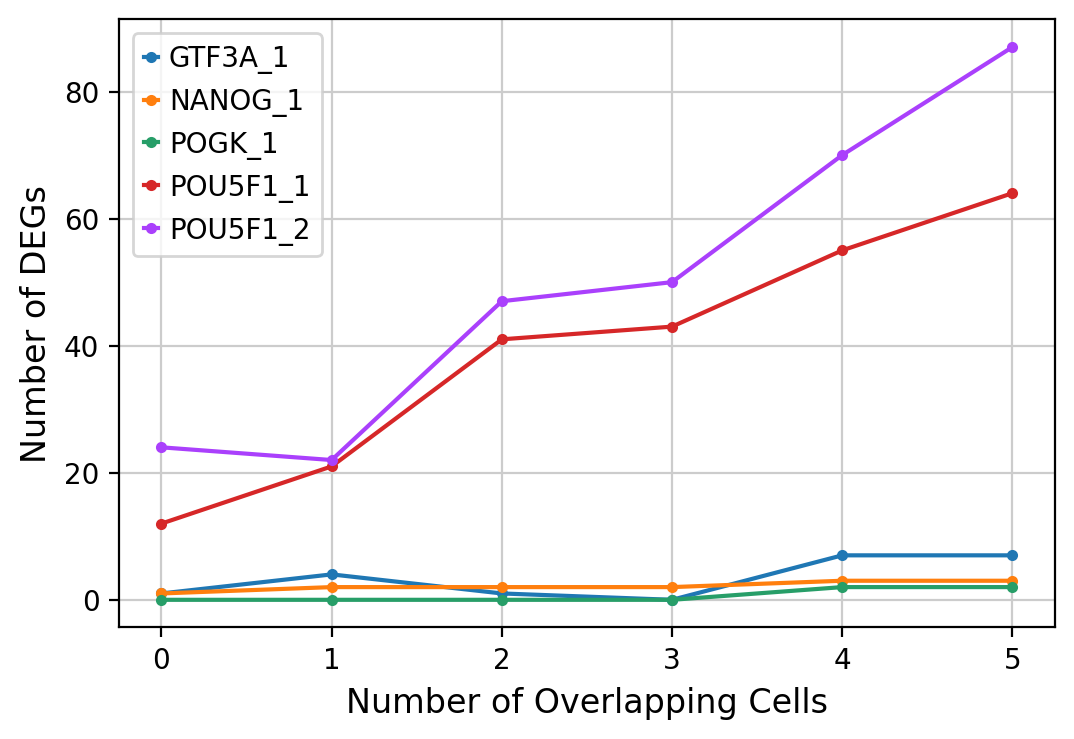

In [269]:
plot_overlap_deg_df(n_degs_low_cell_gRNA_5)

In [267]:
def plot_n_degs_low_cell_gRNA_5(overlap_deg_df):
    cols = overlap_deg_df.columns.tolist()
    n_overlap_cells_list = [int(col.split(" ")[0]) for col in cols]
    gRNAs = overlap_deg_df.index.tolist()
    gRNAs.sort()
    plt.figure(figsize=(6,4))
    for gRNA in gRNAs:
        n_degs = overlap_deg_df.loc[gRNA].values
        if gRNA in ["POU5F1_1", "POU5F1_2", "GTF3A_1"]:
            plt.plot(n_overlap_cells_list[:4], n_degs[:4], marker=".", linestyle="-", label=gRNA)
        else:
            plt.plot(n_overlap_cells_list[:5], n_degs[:5], marker=".", linestyle="-", label=gRNA)
    plt.xlabel("Number of Overlapping Cells", fontsize=12)
    plt.ylabel("Number of DEGs", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=10)
    plt.show()

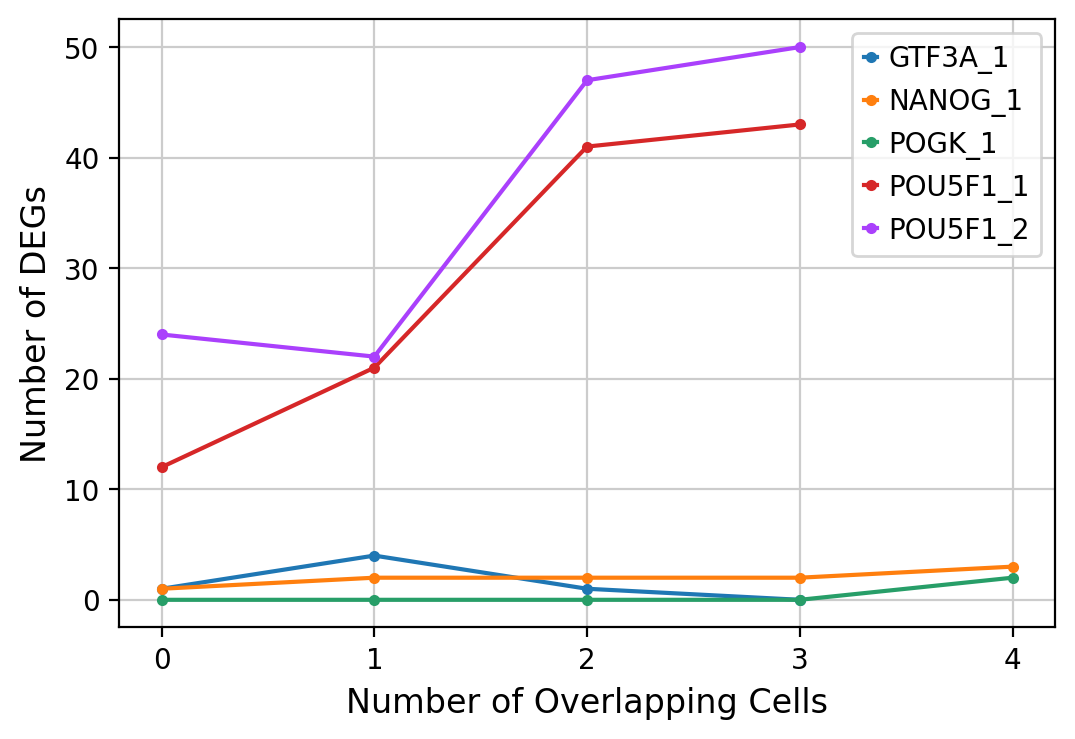

In [268]:
plot_n_degs_low_cell_gRNA_5(n_degs_low_cell_gRNA_5)

In [264]:
n_degs_low_cell_gRNA_5

0 cells  1 cell  2 cells  3 cells  4 cells  5 cells
POU5F1_1       12      21       41       43       55       64
NANOG_1         1       2        2        2        3        3
GTF3A_1         1       4        1        0        7        7
POU5F1_2       24      22       47       50       70       87
POGK_1          0       0        0        0        2        2

In [159]:
test_n_overlap_cells_list = [_ for _ in range(11)]

In [157]:
n_degs_low_cell_gRNA = test_overlap_degs(final_low_cell_adata, 
                                         n_overlap_cells_list=test_n_overlap_cells_list)

Running DE analysis:   0%|          | 0/25 [00:00<?, ?it/s]

Running DE analysis:   0%|          | 0/25 [00:00<?, ?it/s]

Running DE analysis:   0%|          | 0/25 [00:00<?, ?it/s]

Running DE analysis:   0%|          | 0/25 [00:00<?, ?it/s]

Running DE analysis:   0%|          | 0/25 [00:00<?, ?it/s]

Running DE analysis:   0%|          | 0/25 [00:00<?, ?it/s]

Running DE analysis:   0%|          | 0/25 [00:00<?, ?it/s]

Running DE analysis:   0%|          | 0/25 [00:00<?, ?it/s]

Running DE analysis:   0%|          | 0/25 [00:00<?, ?it/s]

Running DE analysis:   0%|          | 0/25 [00:00<?, ?it/s]

Running DE analysis:   0%|          | 0/25 [00:00<?, ?it/s]

In [195]:
n_degs_low_cell_gRNA

0 cells  1 cell  2 cells  3 cells  4 cells  5 cells  6 cells  \
POU5F1_1       12      21       41       43       55       64       85   
NANOG_1         1       2        2        2        3        3        2   
GTF3A_1         1       4        1        0        7        7        5   
POU5F1_2       24      22       47       50       70       87      101   
POGK_1          0       0        0        0        2        2        4   

          7 cells  8 cells  9 cells  10 cells  
POU5F1_1       85       88      103       131  
NANOG_1         7        4        8         9  
GTF3A_1         4        9       10        10  
POU5F1_2      128      126      108       140  
POGK_1          3        5        6         0

In [210]:
rep_size_low_cell_gRNA = build_cells_per_rep_df(final_low_cell_adata, test_n_overlap_cells_list)
rep_size_low_cell_gRNA

0 cells  1 cell  2 cells  3 cells  4 cells  5 cells  6 cells  \
GTF3A_1        15      16       17       18       19       20       21   
NANOG_1        19      20       21       22       23       24       25   
POGK_1         18      19       20       21       22       23       24   
POU5F1_1       13      14       15       16       17       18       19   
POU5F1_2       14      15       16       17       18       19       20   

          7 cells  8 cells  9 cells  10 cells  
GTF3A_1        22       23       24        25  
NANOG_1        26       27       28        29  
POGK_1         25       26       27        28  
POU5F1_1       20       21       22        23  
POU5F1_2       21       22       23        24

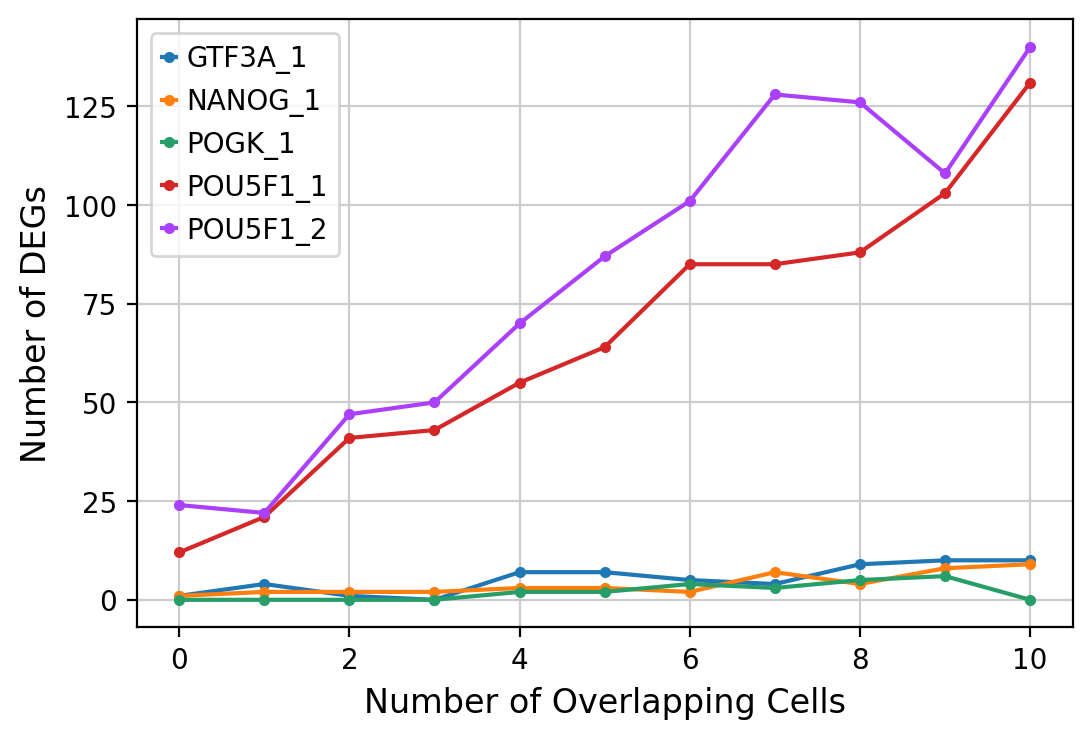

In [234]:
plot_overlap_deg_df(n_degs_low_cell_gRNA)

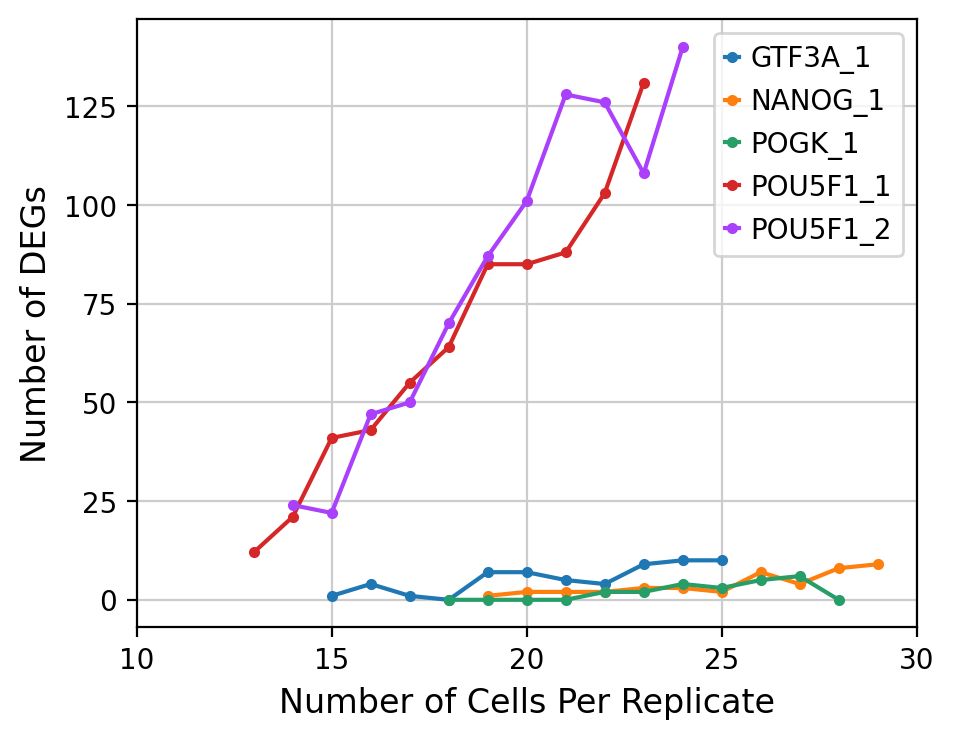

In [236]:
plot_degs_vs_rep_size(n_degs_low_cell_gRNA, rep_size_low_cell_gRNA)

# Fall 2025 Week 7

Mali Lab pipeline code runs DE on each gRNA or gene target individually - for each perturbation, a mini dataset is created containing only the reps for that perturbation and the matched NTC reps, upon which DE is run. This week, I will test an alternative method where all gRNA/gene targets are divided into pseudoreplicates and counts/metadata are stored in dataset-wide dataframes. I will run this at the gRNA level first to see if overlapping pseudoreplicates are needed or if DE on the small-cell-number gRNAs has enough power without overlaps. Use 2 pseudoreps for gRNA with <60 cells, else 3 pseudoreps.

## Initial testing

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

def create_pseudobulk_dataset(adata: ad.AnnData, target_type: str = "gRNA",
                              ntc_benchmarking: bool = False,
                              min_counts_per_gene: int = 0,
                              layer: str = "counts",
                              min_cells_for_3_reps: int = 60,
                              approx_ntc_rep_size: int = 50,
                              random_state: int = 42,
                              ntc_target_delimiter: str = "NTC",
                              ntc_gRNA_delimiter: str = "Non-Targeting"):
    """
    Generate pseudobulk representation of adata with pseudoreplicates for 
    each gRNA or gene target (based on target_type).
    """
    # Error handling
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("Error: target_type must be 'gRNA' or 'gene_target'")
    if (ntc_benchmarking is True) & (target_type != "gRNA"):
        raise ValueError("Error: target_type must be 'gRNA' for NTC benchmarking")

    # Get targets
    targets = adata.obs[target_type].unique().tolist()
    # RNG objects for creating pseudoreplicates
    de_rng = np.random.default_rng(random_state)
    target_rngs = de_rng.spawn(len(targets))

    # Data structures for counts_df and metadata_df
    counts_arrays, counts_df_index = list(), list()
    metadata_condition, metadata_n_cells = list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Generate pseudoreplicates
    for target, rng in zip(targets, target_rngs):
        # Get target data
        target_indices = np.where(adata.obs[target_type] == target)[0]
        target_data = data_matrix[target_indices]
        
        # Calculate pseudoreplicate size
        n_target_cells = target_data.shape[0]
        if target_type == "gRNA": # gRNA targets
            if n_target_cells < min_cells_for_3_reps:
                rep1_size = n_target_cells // 2
                rep2_size = n_target_cells - rep1_size
                rep_sizes = [rep1_size, rep2_size]
            else:
                rep1_size = n_target_cells // 3
                rep2_size = (n_target_cells - rep1_size) // 2
                rep3_size = n_target_cells - rep1_size - rep2_size
                rep_sizes = [rep1_size, rep2_size, rep3_size]
        else: # Gene targets
            # Create NTC reps of about approx_ntc_rep_size as evenly as possible
            if target == ntc_target_delimiter:
                n_reps = round(n_target_cells / approx_ntc_rep_size)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)
            else:
                if n_target_cells < min_cells_for_3_reps:
                    rep1_size = n_target_cells // 2
                    rep2_size = n_target_cells - rep1_size
                    rep_sizes = [rep1_size, rep2_size]
                else:
                    rep1_size = n_target_cells // 3
                    rep2_size = (n_target_cells - rep1_size) // 2
                    rep3_size = n_target_cells - rep1_size - rep2_size
                    rep_sizes = [rep1_size, rep2_size, rep3_size]

        # Sample target indices for each rep
        target_cell_indices = np.arange(n_target_cells)
        rng.shuffle(target_cell_indices)
        rep_sizes_array = np.array(rep_sizes)
        rep_splits = np.cumsum(rep_sizes_array)[:-1]
        rep_indices = np.split(target_cell_indices, rep_splits)
        
        # Update pseudobulk counts
        n_reps = len(rep_sizes)
        target_counts = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
        for i in range(n_reps):
            target_counts[i] = \
                np.sum(target_data[rep_indices[i]], axis=0).astype(np.int64)
        counts_arrays.append(target_counts)
        target_hyphenated = target.replace("_", "-")
        rep_names = [f"{target_hyphenated}-rep{i+1}" for i in range(n_reps)]
        counts_df_index += rep_names
        
        # Update metadata
        metadata_n_cells += rep_sizes
        if ntc_gRNA_delimiter in target:
            metadata_condition += (["NTC"]*n_reps)
        else:
            metadata_condition += ([target_hyphenated]*n_reps)
            
    # Create counts DF
    counts_arr = np.concatenate(tuple(arr for arr in counts_arrays), axis=0)
    counts_df = pd.DataFrame(
        counts_arr,
        index=counts_df_index,
        columns=adata.var_names
    )
    # Filter lowly expressed genes
    gene_filter = counts_df.sum(axis=0) >= min_counts_per_gene
    counts_df = counts_df.loc[:, gene_filter]

    # Create metadata DF
    metadata_dict = {"sample": counts_df_index,
                    "condition": metadata_condition,
                    "n-cells-in-rep": metadata_n_cells}
    metadata_df = pd.DataFrame.from_dict(metadata_dict)
    metadata_df = metadata_df.set_index("sample").rename_axis(None)
    return counts_df, metadata_df

# Handle warnings (from PyDESeq2)
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def run_pydeseq2(counts_df: pd.DataFrame, metadata_df: pd.DataFrame,
                 n_cpus: int = 20, alpha: float = 0.05,
                 shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
                 suppress_warnings: bool = False):
    """
    Perform DE analysis with PyDESeq2 on perturbing gRNA or gene targets.
    Uses parallel processing for DeseqStats.summary().
    """
    with handle_warnings(suppress_warnings):
        # Set number of CPUs to use
        dds_inference = DefaultInference(n_cpus=n_cpus)
        ds_inference = DefaultInference(n_cpus=1)
        # Fit dispersions and LFCs
        dds = DeseqDataSet(counts=counts_df, metadata=metadata_df,
                          design_factors="condition",
                          continuous_factors=["n-cells-in-rep"],
                          ref_level=["condition", "NTC"],
                          inference=dds_inference, quiet=False
                          )
        print(f"\nFitting dispersion and LFC parameters with DeseqDataSet.deseq2()")
        dds.deseq2()
        # Helper function for statistical testing
        def run_DeseqStats(target, shrink_lfcs, lfc_shrink_adapt):
            contrast=["condition", target, "NTC"]
            ds = DeseqStats(dds, contrast=contrast, alpha=alpha,
                            inference=ds_inference, quiet=True)
            ds.summary()
            if shrink_lfcs:
                coeff = f"{contrast[0]}_{contrast[1]}_vs_{contrast[2]}"
                ds.lfc_shrink(coeff=coeff, adapt=lfc_shrink_adapt)
            return ds.results_df
        # Perform statistical testing in parallel
        targets_hyphenated = metadata_df["condition"].unique().tolist()
        if "NTC" in targets_hyphenated:
            targets_hyphenated.remove("NTC")
        with tqdm_joblib(desc="Running DE statistical testing", total=len(targets_hyphenated)):
            ds_results = Parallel(n_jobs=n_cpus)(
                delayed(run_DeseqStats)(target, shrink_lfcs, lfc_shrink_adapt)
                        for target in targets_hyphenated)
        # Return results
        targets = [target.replace("-", "_") for target in targets_hyphenated]
        de_results_dict = {targets[i]: ds_results[i] for i in range(len(targets))}
        return de_results_dict


def run_dataset_DE(adata: ad.AnnData, target_type: str = "gRNA",
                layer: str = "counts",
                min_cells_for_3_reps: int = 60,
                approx_ntc_rep_size: int = 50,
                random_state: int = 42,
                ntc_target_delimiter: str = "NTC",
                ntc_gRNA_delimiter: str = "Non-Targeting",
                n_cpus: int = 20, alpha: float = 0.05,
                shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
                suppress_warnings: bool = False):
    """
    Run pseudobulk DE on perturbing gRNA or gene targets (based on target_type).
    """
    # Create pseudobulk dataset
    print("Generating pseudobulk representation of dataset")
    counts_df, metadata_df = \
        create_pseudobulk_dataset(adata, target_type=target_type, layer=layer,
                                    min_cells_for_3_reps=min_cells_for_3_reps,
                                    approx_ntc_rep_size = approx_ntc_rep_size,
                                    random_state=random_state,
                                    ntc_target_delimiter=ntc_target_delimiter,
                                    ntc_gRNA_delimiter=ntc_gRNA_delimiter)
    # Run DE analysis on pseudobulk dataset
    de_results_dict = run_pydeseq2(counts_df, metadata_df,
                    n_cpus=n_cpus, alpha=alpha,
                    shrink_lfcs=shrink_lfcs, 
                    lfc_shrink_adapt=lfc_shrink_adapt,
                    suppress_warnings=suppress_warnings)
    return de_results_dict

### NTC benchmarking with 2 or 3 reps per gRNA

In [ ]:
def ntc_benchmarking_DE(adata: ad.AnnData,
                        layer: str = "counts",
                        min_cells_for_3_reps: int = 60,
                        random_state: int = 42,
                        ntc_target_delimiter: str = "NTC",
                        ntc_gRNA_delimiter: str = "Non-Targeting",
                        n_cpus: int = 20, alpha: float = 0.05,
                        suppress_warnings: bool = False):
    """
    Perform DE analysis on all NTC gRNA against all other NTC cells.
    Return dict {NTC gRNA: DE results DF for that NTC gRNA}.
    """
    adata = adata[adata.obs.gene_target == ntc_target_delimiter]
    # Create pseudobulk representation of dataset
    counts_df, metadata_df = \
        create_pseudobulk_dataset(adata, target_type="gRNA", 
                                  ntc_benchmarking=True, layer=layer,
                                  min_cells_for_3_reps=min_cells_for_3_reps,
                                  random_state=random_state,
                                  ntc_target_delimiter=ntc_target_delimiter,
                                  ntc_gRNA_delimiter=ntc_gRNA_delimiter)

    # Helper function to run DE on single NTC gRNA
    def ntc_benchmarking_single_gRNA(counts_df, metadata_df, target_ntc_gRNA):
        # Temporarily change 'condition' to 'perturbed'
        metadata_df = metadata_df.copy()
        metadata_df.loc[
            metadata_df.index.str.contains(target_ntc_gRNA), "condition"] = "perturbed"
        # Run DESeq2
        with handle_warnings(suppress_warnings):
            dds_inference = DefaultInference(n_cpus=1)
            ds_inference = DefaultInference(n_cpus=1)
            dds = DeseqDataSet(counts=counts_df, 
                               metadata=metadata_df,
                               design_factors="condition",
                               continuous_factors=["n-cells-in-rep"],
                               ref_level=["condition", "NTC"],
                               inference=dds_inference, 
                               quiet=True)
            dds.deseq2()
            ds = DeseqStats(dds, 
                            contrast=["condition", "perturbed", "NTC"], 
                            alpha=alpha,
                            inference=ds_inference, 
                            quiet=True)
            ds.summary()
            return ds.results_df
    
    # Run DE on all NTC gRNA
    targets = adata.obs.gRNA.unique().tolist()
    targets_hyphenated = [target.replace("_", "-") for target in targets]
    with tqdm_joblib(desc="Running DE analysis", total=len(targets)):
        de_results = Parallel(n_jobs=n_cpus)(
            delayed(ntc_benchmarking_single_gRNA)(counts_df, metadata_df, target)
                    for target in targets_hyphenated)
    de_results_dict = {targets[i]: de_results[i] for i in range(len(targets))}
    return de_results_dict

def report_ntc_benchmarking_results(results_dict: dict, alpha: float = 0.05):
        """
        Determine the threshold (number of DEGs) at which 95% of NTC gRNA have 
        fewer DEGs. Plot the distribution of DEGs for NTC gRNA and print
        a summary of results.
        """
        # Counts DEGs per gRNA
        deg_counts = {}
        for ntc_gRNA, result_df in results_dict.items():
            if result_df is None:
                continue
            deg_count = sum((result_df['padj'] < alpha) & pd.notna(result_df['padj']))
            deg_counts[ntc_gRNA] = deg_count

        # Create results DataFrame
        benchmark_results = pd.DataFrame.from_dict(deg_counts, orient='index', columns=['n_DEGs'])
        benchmark_results = benchmark_results.sort_values('n_DEGs', ascending=False)
        
        # Calculate 95th percentile threshold (FDR 0.05)
        if len(benchmark_results) > 0:
            deg_threshold = np.percentile(benchmark_results['n_DEGs'].values, 95)
        else:
            print("No results to calculate percentile.")
            return
        
        # Plot results with improved styling - code from psp.de.benchmark_NTC_FDR()
        # Set style parameters
        plt.rcParams['axes.spines.top'] = False
        plt.rcParams['axes.spines.right'] = False
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        fig.patch.set_facecolor('white')
        # Prepare bar plot data: discrete DEG counts
        deg_counts = benchmark_results['n_DEGs'].value_counts().sort_index()
        # Create bar plot
        ax.bar(
            deg_counts.index,
            deg_counts.values,
            alpha=0.8,
            color='#4682B4',   # Steel blue
            edgecolor='white',
            linewidth=1.5
        )
        # Add threshold line with improved styling
        ax.axvline(
            deg_threshold,
            color='#B22222',  # Firebrick
            linestyle='-',
            linewidth=2,
            alpha=0.8
        )
        # Labels and title with improved styling
        ax.set_xlabel('Number of DEGs', fontsize=12, labelpad=10)
        ax.set_ylabel('Number of NTC sgRNA comparisons', fontsize=12, labelpad=10)
        ax.set_title(f'Distribution of DEGs in NTC comparisons', fontsize=14, pad=20)
        # Turn off grid
        ax.grid(False)
        # Adjust tick parameters
        ax.tick_params(axis='both', which='major', labelsize=10, pad=5)
        # Add some padding to the axes
        ax.margins(x=0.02)
        # Add custom legend-like text at bottom
        threshold_text = f"FDR 0.05 threshold: {int(deg_threshold)} DEGs"
        fig.text(0.5, 0.01, threshold_text, ha='center', fontsize=11, color='#B22222', weight='bold')
        # Adjust layout
        plt.tight_layout(rect=[0, 0.02, 1, 0.98])
        plt.show()
        
        # Print statistics
        print(f"NTC Benchmark Statistics:")
        print(f"  • FDR 0.05 threshold: {int(deg_threshold)} DEGs")
        print(f"  • NTC comparisons analyzed: {len(benchmark_results)}")
        print(f"  • Mean DEGs per comparison: {benchmark_results['n_DEGs'].mean():.1f}")
        print(f"  • Median DEGs per comparison: {benchmark_results['n_DEGs'].median():.1f}")
        print(f"  • 95% of comparisons have < {int(deg_threshold)} DEGs")

        return int(deg_threshold), benchmark_results

Read in data

In [5]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

Note: when running with suppress_warnings=False (time elapsed was 12 min), got this error:

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst) 

In [7]:
test_ntc_benchmark_res = ntc_benchmarking_DE(adata, n_cpus=30, suppress_warnings=True)

Running DE analysis:   0%|          | 0/234 [00:00<?, ?it/s]

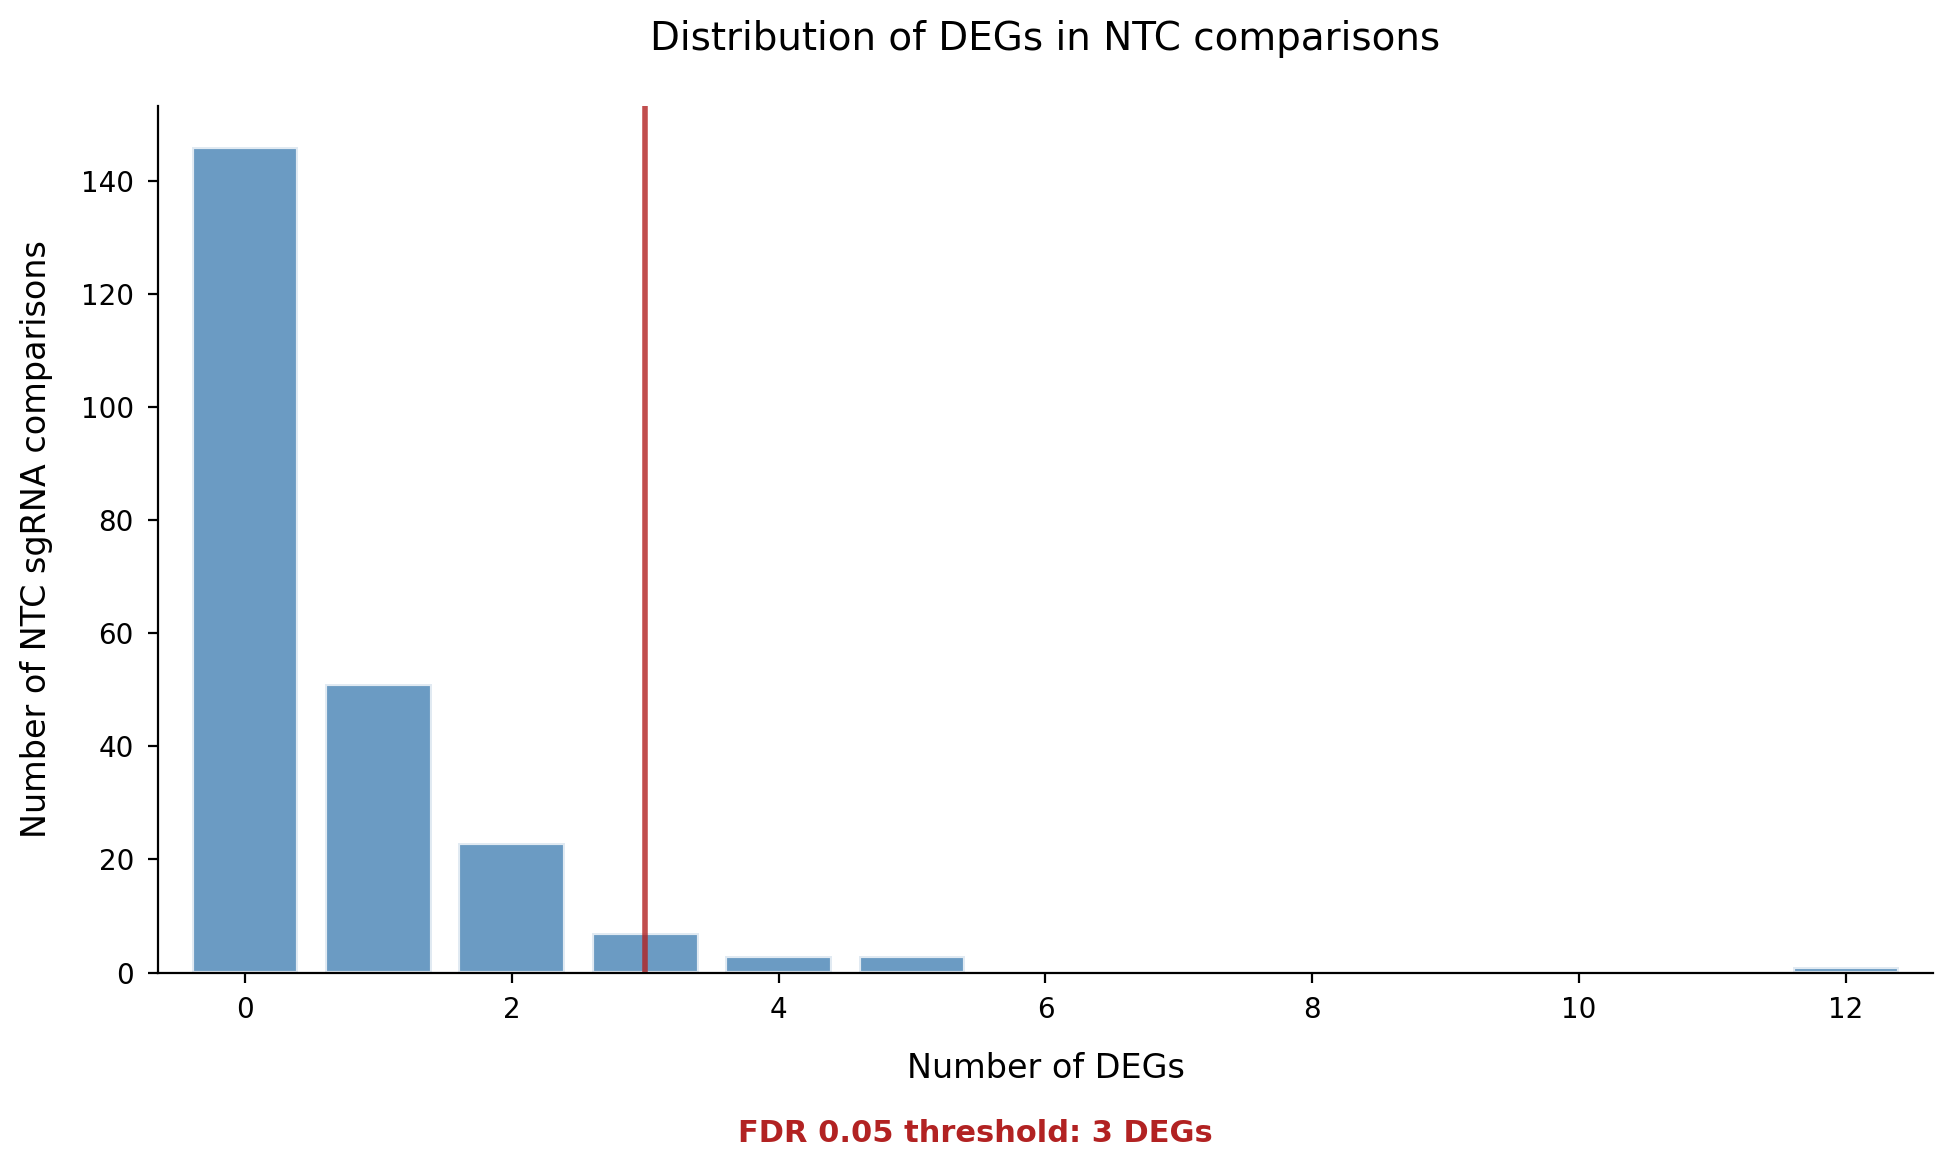

NTC Benchmark Statistics:
  • FDR 0.05 threshold: 3 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 0.7
  • Median DEGs per comparison: 0.0
  • 95% of comparisons have < 3 DEGs


In [14]:
test_deg_threshold, test_benchmark_res = \
    report_ntc_benchmarking_results(test_ntc_benchmark_res)

In [15]:
test_benchmark_res[test_benchmark_res["n_DEGs"] > 3]

n_DEGs
Non-Targeting_398      12
Non-Targeting_226       5
Non-Targeting_506       5
Non-Targeting_844       5
Non-Targeting_351       4
Non-Targeting_482       4
Non-Targeting_418       4

In [18]:
def ntc_threshold_filtering(adata, deg_threshold, benchmark_df):
    gRNA_to_remove = \
        benchmark_df[benchmark_df["n_DEGs"] > deg_threshold].index.tolist()
    adata_filtered = adata[~(adata.obs.gRNA.isin(gRNA_to_remove))].copy()
    return adata_filtered

In [8]:
ntc_gRNA_to_remove = ["Non-Targeting_398", "Non-Targeting_226", "Non-Targeting_506",
                      "Non-Targeting_844", "Non-Targeting_351", "Non-Targeting_482",
                      "Non-Targeting_418"]

In [9]:
adata_benchmarked = adata[~(adata.obs.gRNA.isin(ntc_gRNA_to_remove))].copy()

In [11]:
save_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata_benchmarked.write(save_path)

Restart kernel

### Testing on small datasets

In [3]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101538 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

Create small test dataset with 14 perturbing gRNAs and 10 NTC gRNAs

In [14]:
# 30 KDs with highest number of DEGs, from updated pipeline example notebook
top_30_kds_by_n_degs = \
    {'MYADM', 'DBR1', 'POU5F1', 'PTPN1', 'POU5F1B', 'JOSD1', 'ST13', 'HRC', 'TOMM40', 'KAT2A', 
     'PHF20', 'PSMD8', 'NAE1', 'POU3F2', 'HCCS', 'DDX6', 'SMARCC1', 'DNMT1', 'TMX2', 'SMARCE1', 
     'TADA2B', 'VHL', 'TAF4', 'EMSY', 'ZNF521', 'RBM14', 'NANOG', 'IDI1', 'RNF7', 'ZNF396'}

# KDs to test
test_kds = top_30_kds_by_n_degs & set(adata.obs.gene_target.unique().tolist())
print(f"{len(test_kds)} KDs to test: {', '.join(test_kds)}")

# gRNA to test
gRNA_to_test = adata[adata.obs.gene_target.isin(test_kds)].obs.gRNA.unique().tolist()
print(f"{len(gRNA_to_test)} perturbing gRNA to test")
print(gRNA_to_test)

8 KDs to test: NANOG, POU5F1, PHF20, ZNF396, POU3F2, DNMT1, POU5F1B, ZNF521
14 perturbing gRNA to test
['PHF20_1', 'DNMT1_1', 'POU5F1_1', 'NANOG_1', 'ZNF396_2', 'ZNF396_1', 'POU5F1B_1', 'POU5F1_2', 'DNMT1_3', 'POU5F1_3', 'DNMT1_2', 'POU3F2_2', 'ZNF521_1', 'NANOG_2']


Sample 10 NTC gRNA

In [15]:
NTC_gRNA_value_counts = adata[adata.obs.perturbed == "False"].obs.gRNA.value_counts().reset_index()
NTC_gRNA_value_counts.tail()

gRNA  count
222  Non-Targeting_890     29
223  Non-Targeting_622     29
224  Non-Targeting_421     29
225  Non-Targeting_665     28
226  Non-Targeting_722     26

In [7]:
test_rng = np.random.default_rng(42)
test_ntc_indices = test_rng.choice(len(NTC_gRNA_value_counts)-1, 10)
test_ntc_gRNAs = NTC_gRNA_value_counts.iloc[test_ntc_indices]["gRNA"].tolist()
print(test_ntc_gRNAs)

['Non-Targeting_939', 'Non-Targeting_278', 'Non-Targeting_935', 'Non-Targeting_375', 'Non-Targeting_261', 'Non-Targeting_332', 'Non-Targeting_486', 'Non-Targeting_903', 'Non-Targeting_750', 'Non-Targeting_543']


In [8]:
small_test_adata = adata[(adata.obs.gRNA.isin(test_ntc_gRNAs)) |
                   (adata.obs.gene_target.isin(test_kds))].copy()
small_test_adata

AnnData object with n_obs × n_vars = 1384 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [9]:
small_test_counts_df, small_test_metadata_df = \
    create_pseudobulk_dataset(small_test_adata, target_type="gRNA")

In [10]:
small_test_metadata_df.head()

condition  n-cells-in-rep
Non-Targeting-903-rep1       NTC              24
Non-Targeting-903-rep2       NTC              25
PHF20-1-rep1             PHF20-1              23
PHF20-1-rep2             PHF20-1              23
DNMT1-1-rep1             DNMT1-1              25

In [18]:
small_test_de_results_dict = \
    run_dataset_DE(small_test_adata, target_type="gRNA", n_cpus=30)

Generating pseudobulk representation of dataset

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 0.68 seconds.

Fitting dispersion trend curve...
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 0.85 seconds.

Fitting LFCs...
... done in 0.86 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/14 [00:00<?, ?it/s]

In [23]:
def build_n_degs_df(de_results_dict, alpha=0.05):
    n_degs_dict = dict()
    for target in de_results_dict:
        target_df = de_results_dict[target]
        n_degs = len(target_df[target_df["padj"] < alpha])
        n_degs_dict[target] = n_degs
    n_degs_df = pd.DataFrame.from_dict(n_degs_dict, orient="index",
                                       columns=["n_DEGs"])
    n_degs_df.sort_index(inplace=True)
    return n_degs_df

In [20]:
test_n_degs_df = build_n_degs_df(small_test_de_results_dict)
test_n_degs_df

n_DEGs
DNMT1_1        89
DNMT1_2        77
DNMT1_3        85
NANOG_1        29
NANOG_2       136
PHF20_1       445
POU3F2_2      386
POU5F1B_1     516
POU5F1_1      166
POU5F1_2      229
POU5F1_3      537
ZNF396_1        0
ZNF396_2      284
ZNF521_1      262

Create test dataset with 14 perturbing gRNAs and all 227 NTC gRNAs

In [16]:
test_adata = adata[(adata.obs.gene_target == "NTC") |
                   (adata.obs.gene_target.isin(test_kds))].copy()
test_adata

AnnData object with n_obs × n_vars = 14052 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [22]:
test_counts_df, test_metadata_df = \
    create_pseudobulk_dataset(test_adata, target_type="gRNA")

In [23]:
test_de_results_dict = \
    run_dataset_DE(test_adata, target_type="gRNA", n_cpus=30)

Generating pseudobulk representation of dataset

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.23 seconds.

Fitting dispersions...
... done in 2.35 seconds.

Fitting dispersion trend curve...
... done in 0.31 seconds.

Fitting MAP dispersions...
... done in 1.55 seconds.

Fitting LFCs...
... done in 1.47 seconds.

Calculating cook's distance...
... done in 0.48 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/14 [00:00<?, ?it/s]

In [24]:
test_n_degs_df = build_n_degs_df(test_de_results_dict)
test_n_degs_df

n_DEGs
DNMT1_1       174
DNMT1_2       177
DNMT1_3       175
NANOG_1        98
NANOG_2       236
PHF20_1       766
POU3F2_2      611
POU5F1B_1     973
POU5F1_1      733
POU5F1_2      953
POU5F1_3      864
ZNF396_1        0
ZNF396_2      516
ZNF521_1      552

In [25]:
test_adata_pipeline = test_adata.copy()
pipeline_de_results = psp.de.differential_expression(test_adata_pipeline, plot_degs=False)

Processing perturbations:   0%|          | 0/14 [00:00<?, ?it/s]


Updating adata object with DEG counts
2025-11-11 12:41:35 - INFO - Completed differential expression analysis in 135.34 seconds


In [26]:
pipeline_test_n_degs_df = build_n_degs_df(pipeline_de_results)
pipeline_test_n_degs_df

n_DEGs
DNMT1_1       100
DNMT1_2        53
DNMT1_3        70
NANOG_1        58
NANOG_2       201
PHF20_1       378
POU3F2_2      390
POU5F1B_1     515
POU5F1_1      402
POU5F1_2      554
POU5F1_3      495
ZNF396_1        0
ZNF396_2      234
ZNF521_1      396

### Testing chunked DE

In [3]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101538 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [4]:
def create_pseudobulk_dataset_2_reps(adata: ad.AnnData, target_type: str = "gRNA",
                                ntc_benchmarking: bool = False,
                                min_counts_per_gene: int = 0,
                                layer: str = "counts",
                                approx_ntc_rep_size: int = 50,
                                random_state: int = 42,
                                ntc_target_delimiter: str = "NTC",
                                ntc_gRNA_delimiter: str = "Non-Targeting"):
    """
    Generate pseudobulk representation of adata with pseudoreplicates for 
    each gRNA or gene target (based on target_type). Use 2 reps per gRNA
    or KD.
    """
    # Error handling
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("Error: target_type must be 'gRNA' or 'gene_target'")
    if (ntc_benchmarking is True) & (target_type != "gRNA"):
        raise ValueError("Error: target_type must be 'gRNA' for NTC benchmarking")

    # Get targets
    targets = adata.obs[target_type].unique().tolist()
    # RNG objects for creating pseudoreplicates
    de_rng = np.random.default_rng(random_state)
    target_rngs = de_rng.spawn(len(targets))

    # Data structures for counts_df and metadata_df
    counts_arrays, counts_df_index = list(), list()
    metadata_condition, metadata_n_cells = list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Generate pseudoreplicates
    for target, rng in zip(targets, target_rngs):
        # Get target data
        target_indices = np.where(adata.obs[target_type] == target)[0]
        target_data = data_matrix[target_indices]
        
        # Calculate pseudoreplicate size
        n_target_cells = target_data.shape[0]
        if target_type == "gRNA": # gRNA targets
            rep1_size = n_target_cells // 2
            rep2_size = n_target_cells - rep1_size
            rep_sizes = [rep1_size, rep2_size]
        else: # Gene targets
            # Create NTC reps of about approx_ntc_rep_size as evenly as possible
            if target == ntc_target_delimiter:
                n_reps = round(n_target_cells / approx_ntc_rep_size)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)
            else:
                rep1_size = n_target_cells // 2
                rep2_size = n_target_cells - rep1_size
                rep_sizes = [rep1_size, rep2_size]

        # Sample target indices for each rep
        target_cell_indices = np.arange(n_target_cells)
        rng.shuffle(target_cell_indices)
        rep_sizes_array = np.array(rep_sizes)
        rep_splits = np.cumsum(rep_sizes_array)[:-1]
        rep_indices = np.split(target_cell_indices, rep_splits)
        
        # Update pseudobulk counts
        n_reps = len(rep_sizes)
        target_counts = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
        for i in range(n_reps):
            target_counts[i] = \
                np.sum(target_data[rep_indices[i]], axis=0).astype(np.int64)
        counts_arrays.append(target_counts)
        target_hyphenated = target.replace("_", "-")
        rep_names = [f"{target_hyphenated}-rep{i+1}" for i in range(n_reps)]
        counts_df_index += rep_names
        
        # Update metadata
        metadata_n_cells += rep_sizes
        if ntc_gRNA_delimiter in target:
            metadata_condition += (["NTC"]*n_reps)
        else:
            metadata_condition += ([target_hyphenated]*n_reps)
            
    # Create counts DF
    counts_arr = np.concatenate(tuple(arr for arr in counts_arrays), axis=0)
    counts_df = pd.DataFrame(
        counts_arr,
        index=counts_df_index,
        columns=adata.var_names
    )
    # Filter lowly expressed genes
    gene_filter = counts_df.sum(axis=0) >= min_counts_per_gene
    counts_df = counts_df.loc[:, gene_filter]

    # Create metadata DF
    metadata_dict = {"sample": counts_df_index,
                    "condition": metadata_condition,
                    "n-cells-in-rep": metadata_n_cells}
    metadata_df = pd.DataFrame.from_dict(metadata_dict)
    metadata_df = metadata_df.set_index("sample").rename_axis(None)
    return counts_df, metadata_df

def run_dataset_DE_2_reps(adata: ad.AnnData, target_type: str = "gRNA",
                layer: str = "counts",
                approx_ntc_rep_size: int = 50,
                random_state: int = 42,
                ntc_target_delimiter: str = "NTC",
                ntc_gRNA_delimiter: str = "Non-Targeting",
                n_cpus: int = 20, alpha: float = 0.05,
                shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
                suppress_warnings: bool = False):
    """
    Run pseudobulk DE on perturbing gRNA or gene targets (based on target_type).
    """
    # Create pseudobulk dataset
    print("Generating pseudobulk representation of dataset")
    counts_df, metadata_df = \
        create_pseudobulk_dataset_2_reps(
            adata, target_type=target_type, layer=layer,
            approx_ntc_rep_size = approx_ntc_rep_size,
            random_state=random_state,
            ntc_target_delimiter=ntc_target_delimiter,
            ntc_gRNA_delimiter=ntc_gRNA_delimiter
            )
    # Run DE analysis on pseudobulk dataset
    de_results_dict = run_pydeseq2(counts_df, metadata_df,
                    n_cpus=n_cpus, alpha=alpha,
                    shrink_lfcs=shrink_lfcs, 
                    lfc_shrink_adapt=lfc_shrink_adapt,
                    suppress_warnings=suppress_warnings)
    return de_results_dict

In [21]:
test_de_results_2_reps_dict = \
    run_dataset_DE_2_reps(test_adata, target_type="gRNA", n_cpus=30)

Generating pseudobulk representation of dataset



Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.14 seconds.

Fitting dispersions...
... done in 3.41 seconds.

Fitting dispersion trend curve...
... done in 0.31 seconds.

Fitting MAP dispersions...
... done in 1.40 seconds.

Fitting LFCs...
... done in 1.30 seconds.

Calculating cook's distance...
... done in 0.40 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/14 [00:00<?, ?it/s]

In [24]:
test_n_degs_2_reps_df = build_n_degs_df(test_de_results_2_reps_dict)
test_n_degs_2_reps_df

n_DEGs
DNMT1_1       193
DNMT1_2       203
DNMT1_3       191
NANOG_1        99
NANOG_2       221
PHF20_1       782
POU3F2_2      646
POU5F1B_1    1004
POU5F1_1      787
POU5F1_2      999
POU5F1_3      885
ZNF396_1        0
ZNF396_2      556
ZNF521_1      529

In [11]:
full_counts_df, full_metadata_df = \
    create_pseudobulk_dataset_2_reps(adata, target_type="gRNA")

In [12]:
print(full_metadata_df[~(full_metadata_df["condition"] == "NTC")].shape)
print(full_metadata_df[full_metadata_df["condition"] == "NTC"].shape)

(1972, 2)
(454, 2)


In [124]:
round(1972 / (1500-454))

2

In [ ]:
def run_dataset_DE_chunks(adata: ad.AnnData, target_type: str = "gRNA",
                        max_chunk_size: int = 1000, layer: str = "counts",
                        approx_ntc_rep_size: int = 50,
                        random_state: int = 42,
                        ntc_target_delimiter: str = "NTC",
                        ntc_gRNA_delimiter: str = "Non-Targeting",
                        n_cpus: int = 20, alpha: float = 0.05,
                        shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
                        suppress_warnings: bool = False, debug: bool = False,
                        counts_df=None, metadata_df=None):
    """
    Run pseudobulk DE on perturbing gRNA or gene targets (based on target_type).
    Create pseudobulk dataset and break into chunks that each include all NTC reps
    and a subset of perturbing gRNAs/gene targets. Run DE on each chunk.
    """
    if max_chunk_size % 2 != 0:
        raise ValueError("max_chunk_size must be an even number")
    # Create pseudobulk dataset
    if (counts_df is None) or (metadata_df is None):
        print("Generating pseudobulk representation of dataset")
        counts_df, metadata_df = \
            create_pseudobulk_dataset_2_reps(
                adata, target_type=target_type, layer=layer,
                approx_ntc_rep_size = approx_ntc_rep_size,
                random_state=random_state,
                ntc_target_delimiter=ntc_target_delimiter,
                ntc_gRNA_delimiter=ntc_gRNA_delimiter
                )
    
    # Get number of perturbations per chunk
    n_pert_samples = len(metadata_df[metadata_df["condition"] != "NTC"])
    n_ntc_samples = len(metadata_df[metadata_df["condition"] == "NTC"])
    n_chunks = round(n_pert_samples / (max_chunk_size - n_ntc_samples))
    n_perts = n_pert_samples // 2
    base_size = n_perts // n_chunks
    remainder = n_perts % n_chunks
    n_perts_per_chunk = [base_size+1]*remainder + [base_size]*(n_chunks-remainder)

    # Choose perturbations for each chunk
    rng = np.random.default_rng(random_state)
    if target_type == "gRNA":
        all_perts = adata.obs.perturbation.unique().tolist()
    else:
        all_perts = adata.obs.gene_target.unique().tolist()
    if "NTC" in all_perts:
        all_perts.remove("NTC")
    chunk_counts_dfs, chunk_meta_dfs = list(), list()
    pert_indices = np.arange(len(all_perts))
    rng.shuffle(pert_indices)
    chunk_splits = np.cumsum(np.array(n_perts_per_chunk))[:-1]
    chunk_indices = np.split(pert_indices, chunk_splits)
    for i in range(n_chunks):
        chunk_perts = [all_perts[j].replace("_", "-") for j in chunk_indices[i]]
        chunk_meta_df = metadata_df.loc[(metadata_df["condition"].isin(chunk_perts))
                                        | (metadata_df["condition"] == "NTC")]
        chunk_samples = chunk_meta_df.index.tolist()
        chunk_counts_df = counts_df.loc[counts_df.index.isin(chunk_samples)]
        chunk_counts_dfs.append(chunk_counts_df)
        chunk_meta_dfs.append(chunk_meta_df)

    # Run DE analysis on each chunk pseudobulk dataset
    de_results_dict = dict()
    n_chunks_to_run = 1 if debug else n_chunks
    for i in range(n_chunks_to_run):
        print(f"Running DE analysis on chunk {i+1} of {n_chunks}")
        chunk_results_dict = \
            run_pydeseq2(chunk_counts_dfs[i], 
                         chunk_meta_dfs[i],
                        n_cpus=n_cpus, alpha=alpha,
                        shrink_lfcs=shrink_lfcs, 
                        lfc_shrink_adapt=lfc_shrink_adapt,
                        suppress_warnings=suppress_warnings)
        de_results_dict.update(chunk_results_dict)
    return de_results_dict

Testing - see how long 1 chunk takes

4 chunks

In [ ]:
# 21 min per chunk, 4 chunks
test_chunks_DE_res_dict = \
    run_dataset_DE_chunks(adata, target_type="gRNA", n_cpus=50, 
                          max_chunk_size=1000, debug=True)

Generating pseudobulk representation of dataset
Running DE analysis on chunk 1 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.32 seconds.

Fitting dispersions...
... done in 444.74 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 51.93 seconds.

Fitting LFCs...
... done in 48.98 seconds.

Calculating cook's distance...
... done in 0.71 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/247 [00:00<?, ?it/s]

In [107]:
list(test_chunks_DE_res_dict.keys())[:5]

['ZNF14_1', 'OSR2_3', 'DUXA_3', 'POU3F3_3', 'YBX1_2']

In [12]:
def build_n_degs_df(de_results_dict, alpha=0.05):
    n_degs_dict = dict()
    for target in de_results_dict:
        target_df = de_results_dict[target]
        n_degs = len(target_df[target_df["padj"] < alpha])
        n_degs_dict[target] = n_degs
    n_degs_df = pd.DataFrame.from_dict(n_degs_dict, orient="index",
                                       columns=["n_DEGs"])
    n_degs_df.sort_index(inplace=True)
    return n_degs_df

In [109]:
test_chunk1_df = build_n_degs_df(test_chunks_DE_res_dict)

In [ ]:
len(test_chunk1_df)

247

In [116]:
test_chunk1_df.loc[test_chunk1_df["n_DEGs"] >= 3]

n_DEGs
ADNP2_3        3
BBX_3          5
CHAMP1_3       9
CREB1_2       12
DLX4_3        84
...          ...
ZNF576_1       3
ZNF677_2       4
ZNF688_3       3
ZNF699_3       4
ZNF799_1       3

[62 rows x 1 columns]

In [12]:
62/247

0.25101214574898784

3 chunks

In [ ]:
# 56 min per chunk, 3 chunks
test_chunks_DE_res_dict = \
    run_dataset_DE_chunks(adata, target_type="gRNA", n_cpus=50, 
                          max_chunk_size=1200, debug=True)

Generating pseudobulk representation of dataset
Running DE analysis on chunk 1 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.35 seconds.

Fitting dispersions...
... done in 1375.53 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 88.52 seconds.

Fitting LFCs...
... done in 92.04 seconds.

Calculating cook's distance...
... done in 0.84 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/328 [00:00<?, ?it/s]

In [8]:
test_chunk1of3_df = build_n_degs_df(test_chunks_DE_res_dict)

In [ ]:
# Total number of gRNA
len(test_chunk1of3_df)

328

In [21]:
# gRNA with >0 DEGs
len(test_chunk1of3_df.loc[test_chunk1of3_df["n_DEGs"] > 0])

169

In [22]:
# gRNA with >=3 DEGs
len(test_chunk1of3_df.loc[test_chunk1of3_df["n_DEGs"] >= 3])

89

In [ ]:
test_chunk1of3_df.loc[test_chunk1of3_df["n_DEGs"] >= 3].sort_values(by="n_DEGs")

n_DEGs
ZBTB26_1         3
ZNF561_3         3
GATAD2B_1        3
ZHX3_1           3
GTF2IRD2_1       3
...            ...
E2F4_3         109
SETDB1_1       145
DNMT1_1        215
DNMT1_2        220
ZNF521_1       580

[89 rows x 1 columns]

In [ ]:
test_chunk1of3_df.loc[test_chunk1of3_df["n_DEGs"] >= 3].sort_values(by="n_DEGs").tail(20)

n_DEGs
SP1_3         24
RLF_3         29
DR1_3         34
ZNF408_2      35
LIN28B_3      37
ZNF732_2      38
MTERF3_3      42
ZBTB41_1      48
PKNOX2_2      53
GATA5_1       54
SETDB1_3      56
JUNB_3        61
POU3F3_3      81
GTF3A_1       83
DLX4_3        87
E2F4_3       109
SETDB1_1     145
DNMT1_1      215
DNMT1_2      220
ZNF521_1     580

In [ ]:
# Percent of gRNA with >= 3 DEGs
89/328

0.27134146341463417

In [ ]:
# Percent of gRNA with >0 DEGs
169/328

0.5152439024390244

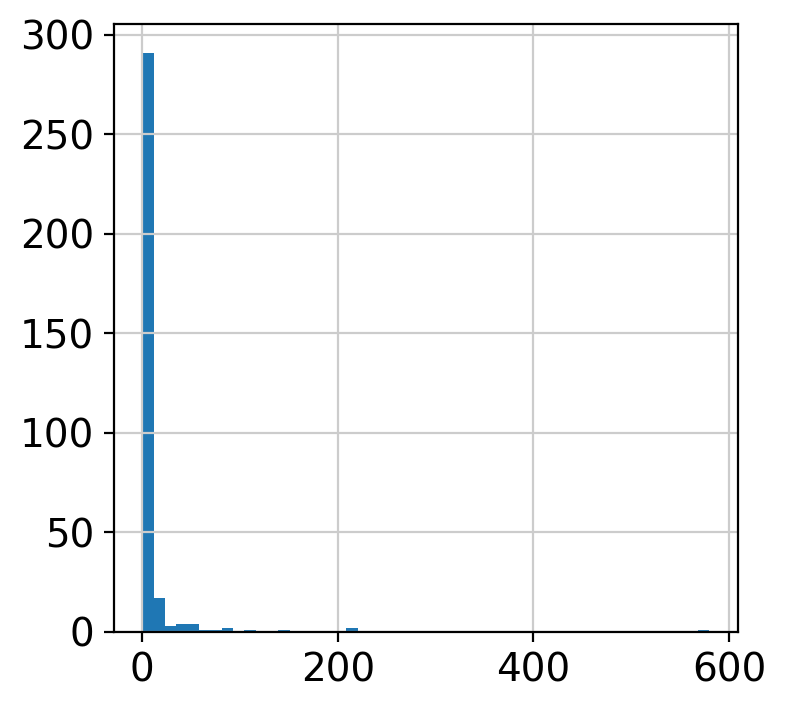

In [17]:
import matplotlib.pyplot as plt

p = plt.hist(test_chunk1of3_df, bins=50)

In [15]:
print(21*4) #~1.5 hrs
print(56*3) #~2.75 hrs

84
168


2 chunks

In [ ]:
# Ran this cell for 43 min, was still fitting dispersions
test_DE_res_dict = \
    run_dataset_DE_chunks(adata, target_type="gRNA", n_cpus=50, 
                          max_chunk_size=1500)

Generating pseudobulk representation of dataset
Running DE analysis on chunk 1 of 2

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.49 seconds.

Fitting dispersions...


KeyboardInterrupt: 

### DE analysis in 4 chunks

In [ ]:
# 94 min for 4 chunks and 60 CPUs
test_4_chunks_DE_res_dict = \
    run_dataset_DE_chunks(adata, target_type="gRNA", n_cpus=60, 
                          max_chunk_size=1000)

Generating pseudobulk representation of dataset
Running DE analysis on chunk 1 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.31 seconds.

Fitting dispersions...
... done in 428.55 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 51.81 seconds.

Fitting LFCs...
... done in 42.00 seconds.

Calculating cook's distance...
... done in 0.69 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/247 [00:00<?, ?it/s]

Running DE analysis on chunk 2 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.32 seconds.

Fitting dispersions...
... done in 855.68 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 37.03 seconds.

Fitting LFCs...
... done in 40.72 seconds.

Calculating cook's distance...
... done in 0.69 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/246 [00:00<?, ?it/s]

Running DE analysis on chunk 3 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.32 seconds.

Fitting dispersions...
... done in 884.02 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 49.22 seconds.

Fitting LFCs...
... done in 41.97 seconds.

Calculating cook's distance...
... done in 0.71 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/246 [00:00<?, ?it/s]

Running DE analysis on chunk 4 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.32 seconds.

Fitting dispersions...
... done in 455.06 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 38.74 seconds.

Fitting LFCs...
... done in 41.94 seconds.

Calculating cook's distance...
... done in 0.71 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/247 [00:00<?, ?it/s]

In [ ]:
def build_DE_df(results_dict):
    df_list = list()
    for target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [8]:
len(list(test_4_chunks_DE_res_dict.keys()))

986

In [9]:
test_4_chunks_DE_res_df = \
    build_DE_df(test_4_chunks_DE_res_dict)

In [10]:
test_4_chunks_DE_res_df.head()

ZNF14_1_baseMean  ZNF14_1_log2FoldChange  ZNF14_1_lfcSE  \
A1BG               3.496334               -0.056857       0.491782   
A1BG-AS1           0.522056               -1.783689       2.391602   
A2M                0.458251               -0.067035       1.589635   
A2ML1              1.592228               -1.186808       1.042859   
A2ML1-AS1          4.728207               -0.146154       0.444956   

           ZNF14_1_stat  ZNF14_1_pvalue  ZNF14_1_padj  OSR2_3_baseMean  \
A1BG          -0.115614        0.907959      0.999304         3.496334   
A1BG-AS1      -0.745814        0.455780      0.999304         0.522056   
A2M           -0.042170        0.966363      0.999304         0.458251   
A2ML1         -1.138033        0.255107      0.999304         1.592228   
A2ML1-AS1     -0.328467        0.742558      0.999304         4.728207   

           OSR2_3_log2FoldChange  OSR2_3_lfcSE  OSR2_3_stat  ...  \
A1BG                   -0.386033      0.523117    -0.737947  ...   
A1BG-AS1               -1.847375      2.395985    -0.771029  ...   
A2M                     0.851742      1.232036     0.691329  ...   
A2ML1                  -0.122598      0.684507    -0.179104  ...   
A2ML1-AS1               0.222708      0.375473     0.593139  ...   

           ZNF805_1_lfcSE  ZNF805_1_stat  ZNF805_1_pvalue  ZNF805_1_padj  \
A1BG             0.554476       0.752335         0.451850       0.993675   
A1BG-AS1         1.051058       1.119937         0.262740       0.993675   
A2M              1.491225       0.338591         0.734918       0.993675   
A2ML1            1.034079      -0.013544         0.989194       0.998936   
A2ML1-AS1        0.553933       0.146737         0.883339       0.998882   

           MYNN_2_baseMean  MYNN_2_log2FoldChange  MYNN_2_lfcSE  MYNN_2_stat  \
A1BG              3.507130              -0.099542      0.596679    -0.166827   
A1BG-AS1          0.535224              -0.029058      1.459428    -0.019910   
A2M               0.454406               1.288609      1.082204     1.190727   
A2ML1             1.625839              -2.831136      2.379265    -1.189921   
A2ML1-AS1         4.630044              -0.445464      0.596228    -0.747136   

           MYNN_2_pvalue  MYNN_2_padj  
A1BG            0.867506     0.999812  
A1BG-AS1        0.984115     0.999812  
A2M             0.233761     0.999812  
A2ML1           0.234078     0.999812  
A2ML1-AS1       0.454981     0.999812  

[5 rows x 5916 columns]

In [11]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_11-12-25.pkl"
test_4_chunks_DE_res_df.to_pickle(filepath_pkl)

In [13]:
test_4_chunks_n_degs_df = \
    build_n_degs_df(test_4_chunks_DE_res_dict)

In [15]:
test_4_chunks_n_degs_df.loc[test_4_chunks_n_degs_df["n_DEGs"] >= 3]

n_DEGs
ADNP2_3         3
ARID2_1         3
ARID2_2         7
ARID2_3         8
ARID3B_3       16
...           ...
ZNF799_1        3
ZNF804A_3      11
ZNF804B_3       5
ZNF92_1         3
ZXDC_3          6

[283 rows x 1 columns]

In [16]:
test_4_chunks_n_degs_df.loc[test_4_chunks_n_degs_df["n_DEGs"] > 0]

n_DEGs
ADNP2_1         1
ADNP2_2         2
ADNP2_3         3
AHR_2           1
ANKZF1_3        1
...           ...
ZSCAN23_2       1
ZSCAN23_3       2
ZSCAN4_1        1
ZSCAN5B_2       1
ZXDC_3          6

[540 rows x 1 columns]

In [17]:
print(283/986)
print(540/986)

0.2870182555780933
0.5476673427991886


Restart kernel

In [32]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_11-12-25.pkl"
chunk_DE_res_df = pd.read_pickle(filepath_pkl)
chunk_DE_res_df.head()

ZNF14_1_baseMean  ZNF14_1_log2FoldChange  ZNF14_1_lfcSE  \
A1BG               3.496334               -0.056857       0.491782   
A1BG-AS1           0.522056               -1.783689       2.391602   
A2M                0.458251               -0.067035       1.589635   
A2ML1              1.592228               -1.186808       1.042859   
A2ML1-AS1          4.728207               -0.146154       0.444956   

           ZNF14_1_stat  ZNF14_1_pvalue  ZNF14_1_padj  OSR2_3_baseMean  \
A1BG          -0.115614        0.907959      0.999304         3.496334   
A1BG-AS1      -0.745814        0.455780      0.999304         0.522056   
A2M           -0.042170        0.966363      0.999304         0.458251   
A2ML1         -1.138033        0.255107      0.999304         1.592228   
A2ML1-AS1     -0.328467        0.742558      0.999304         4.728207   

           OSR2_3_log2FoldChange  OSR2_3_lfcSE  OSR2_3_stat  ...  \
A1BG                   -0.386033      0.523117    -0.737947  ...   
A1BG-AS1               -1.847375      2.395985    -0.771029  ...   
A2M                     0.851742      1.232036     0.691329  ...   
A2ML1                  -0.122598      0.684507    -0.179104  ...   
A2ML1-AS1               0.222708      0.375473     0.593139  ...   

           ZNF805_1_lfcSE  ZNF805_1_stat  ZNF805_1_pvalue  ZNF805_1_padj  \
A1BG             0.554476       0.752335         0.451850       0.993675   
A1BG-AS1         1.051058       1.119937         0.262740       0.993675   
A2M              1.491225       0.338591         0.734918       0.993675   
A2ML1            1.034079      -0.013544         0.989194       0.998936   
A2ML1-AS1        0.553933       0.146737         0.883339       0.998882   

           MYNN_2_baseMean  MYNN_2_log2FoldChange  MYNN_2_lfcSE  MYNN_2_stat  \
A1BG              3.507130              -0.099542      0.596679    -0.166827   
A1BG-AS1          0.535224              -0.029058      1.459428    -0.019910   
A2M               0.454406               1.288609      1.082204     1.190727   
A2ML1             1.625839              -2.831136      2.379265    -1.189921   
A2ML1-AS1         4.630044              -0.445464      0.596228    -0.747136   

           MYNN_2_pvalue  MYNN_2_padj  
A1BG            0.867506     0.999812  
A1BG-AS1        0.984115     0.999812  
A2M             0.233761     0.999812  
A2ML1           0.234078     0.999812  
A2ML1-AS1       0.454981     0.999812  

[5 rows x 5916 columns]

Rename columns containing 'NKX2-4_1', 'NKX6-2_3', 'NKX6-1_2', or 'NKX3-1_3'

In [ ]:
gRNA_wrong_names = ['NKX2_4_1', 'NKX6_2_3', 'NKX6_1_2', 'NKX3_1_3']
gRNA_correct_names = ['NKX2-4_1', 'NKX6-2_3', 'NKX6-1_2', 'NKX3-1_3']
wrong_cols = [(f"{g}_baseMean", f"{g}_log2FoldChange", f"{g}_lfcSE", 
               f"{g}_stat", f"{g}_pvalue", f"{g}_padj") for g in gRNA_wrong_names]
wrong_cols = [tup[i] for tup in wrong_cols for i in range(len(tup))]
correct_cols = [(f"{g}_baseMean", f"{g}_log2FoldChange", f"{g}_lfcSE", 
               f"{g}_stat", f"{g}_pvalue", f"{g}_padj") for g in gRNA_correct_names]
correct_cols = [tup[i] for tup in correct_cols for i in range(len(tup))]
rename_cols = {wrong_cols[i]: correct_cols[i] for i in range(len(wrong_cols))}

{'NKX2_4_1_baseMean': 'NKX2-4_1_baseMean', 'NKX2_4_1_log2FoldChange': 'NKX2-4_1_log2FoldChange', 'NKX2_4_1_lfcSE': 'NKX2-4_1_lfcSE', 'NKX2_4_1_stat': 'NKX2-4_1_stat', 'NKX2_4_1_pvalue': 'NKX2-4_1_pvalue', 'NKX2_4_1_padj': 'NKX2-4_1_padj', 'NKX6_2_3_baseMean': 'NKX6-2_3_baseMean', 'NKX6_2_3_log2FoldChange': 'NKX6-2_3_log2FoldChange', 'NKX6_2_3_lfcSE': 'NKX6-2_3_lfcSE', 'NKX6_2_3_stat': 'NKX6-2_3_stat', 'NKX6_2_3_pvalue': 'NKX6-2_3_pvalue', 'NKX6_2_3_padj': 'NKX6-2_3_padj', 'NKX6_1_2_baseMean': 'NKX6-1_2_baseMean', 'NKX6_1_2_log2FoldChange': 'NKX6-1_2_log2FoldChange', 'NKX6_1_2_lfcSE': 'NKX6-1_2_lfcSE', 'NKX6_1_2_stat': 'NKX6-1_2_stat', 'NKX6_1_2_pvalue': 'NKX6-1_2_pvalue', 'NKX6_1_2_padj': 'NKX6-1_2_padj', 'NKX3_1_3_baseMean': 'NKX3-1_3_baseMean', 'NKX3_1_3_log2FoldChange': 'NKX3-1_3_log2FoldChange', 'NKX3_1_3_lfcSE': 'NKX3-1_3_lfcSE', 'NKX3_1_3_stat': 'NKX3-1_3_stat', 'NKX3_1_3_pvalue': 'NKX3-1_3_pvalue', 'NKX3_1_3_padj': 'NKX3-1_3_padj'}


In [56]:
chunk_DE_res_df = chunk_DE_res_df.rename(columns=rename_cols)

In [43]:
gRNA = adata.obs.perturbation.unique().tolist()
has_hyphens = [g for g in gRNA if "-" in g]
print(has_hyphens)

['NKX2-4_1', 'NKX6-2_3', 'NKX6-1_2', 'NKX3-1_3']


In [46]:
print("NKX2_4_1_padj" in chunk_DE_res_df.columns)

True


In [58]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_11-12-25.pkl"
chunk_DE_res_df.to_pickle(filepath_pkl)

### Compare to old DE code (individual DE, 1 run per gRNA, no overlaps)

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import gc

def generate_pseudoreplicates_for_DE(adata: ad.AnnData, 
                                     target_value: str, 
                                     ntc_cell_indices: pd.Index, 
                                     rng: np.random.Generator, 
                                     target_column: str = "perturbation", 
                                     min_cells_per_rep: int = 20,
                                     layer: str = "counts"):
    """
    Generate independent pseudoreplicates for a given target (gRNA or gene target) 
    and matched NTC cells. Manually set NTC as reference for DE analysis.
    """
    # Create views for target and NTC cells
    if target_column not in adata.obs:
        print(f"Error: {target_column} not in adata.obs")
        return
    target_mask = adata.obs[target_column] == target_value
    target_view = adata[target_mask]
    ntc_view = adata[ntc_cell_indices]

    # Get data matrices from counts layer
    if layer in adata.layers:
        target_data = target_view.layers[layer]
        ntc_data = ntc_view.layers[layer]
    else:
        target_data = target_view.X
        ntc_data = ntc_view.X        
    
    # Convert to dense if sparse
    if sparse.issparse(target_data):
        target_data = target_data.toarray()
    if sparse.issparse(ntc_data):
        ntc_data = ntc_data.toarray()

    # Calculate number of cells to sample
    n_target_cells = target_data.shape[0]
    n_ntc_cells = ntc_data.shape[0]
    if n_target_cells >= min_cells_per_rep * 2:
        n_reps = min(3, n_target_cells // min_cells_per_rep)
    else: # If too few cells for 2 reps x min_cells_per_rep cells
        n_reps = 2
    target_rep_size = n_target_cells // n_reps
    ntc_rep_size = min(target_rep_size, n_ntc_cells // n_reps)
    if ntc_rep_size < target_rep_size:
        print("Warning: Unmatched number of target and NTC cells")

    # Pre-allocate arrays for results
    target_bulk = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
    ntc_bulk = np.zeros((n_reps, ntc_data.shape[1]), dtype=np.int64)

    # Sample cells for all replicates
    target_sample_size = target_rep_size * n_reps
    ntc_sample_size = ntc_rep_size * n_reps
    sampled_target_indices = \
        rng.choice(n_target_cells, target_sample_size, replace=False)
    sampled_ntc_indices = \
        rng.choice(n_ntc_cells, ntc_sample_size, replace=False)
    # Generate replicates using vectorized operations
    for i in range(n_reps):
        # Sample indices
        target_start, target_stop = i*target_rep_size, (i+1)*target_rep_size
        target_rep_indices = sampled_target_indices[target_start:target_stop]
        ntc_start, ntc_stop = i*ntc_rep_size, (i+1)*ntc_rep_size
        ntc_rep_indices = sampled_ntc_indices[ntc_start:ntc_stop]

        # Calculate sums using vectorized operations
        target_bulk[i] = np.sum(target_data[target_rep_indices], axis=0).astype(np.int64)
        ntc_bulk[i] = np.sum(ntc_data[ntc_rep_indices], axis=0).astype(np.int64)  

    # Create sample names
    if "_" in target_value:
        target_value = target_value.replace("_", "-")
    sample_names = [f"{target_value}-rep{i+1}" for i in range(n_reps)]
    control_names = [f"NTC-rep{i+1}" for i in range(n_reps)]
    
    # Combine data
    combined_data = np.vstack([target_bulk, ntc_bulk])
    combined_names = sample_names + control_names
    
    # Create metadata DF
    metadata_df = pd.DataFrame({
        'condition': [target_value] * n_reps + ['NTC'] * n_reps
    }, index=combined_names)
    # Set NTC as reference for DESeq2
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", target_value],
        ordered=True
        )
    
    # Create counts DF
    counts_df = pd.DataFrame(
        combined_data,
        index=combined_names,
        columns=adata.var_names
    )

    return counts_df, metadata_df

def differential_expression(adata: ad.AnnData, 
                    target_column: str = "perturbation", 
                    ntc_cells_delimiter: str = "NTC", 
                    alpha: float = 0.05, n_cpus: int = 20, 
                    min_cells_per_rep: int = 20,
                    layer: str = "counts", random_state: int = 42, 
                    shrink_lfcs: bool = False, debug: bool = False):
    """
    Run differential expression analysis on each perturbation in the dataset.
    """
    # Identify KD and NTC cells
    perturbations = list(adata.obs[target_column].unique())
    perturbations.remove(ntc_cells_delimiter) # Remove NTC group
    if debug == True: # Debug mode: run with 3 perturbations
        print(f"Running in debug mode with 3 perturbations")
        perturbations = perturbations[:3]
    ntc_cell_indices = np.where(adata.obs[target_column] == ntc_cells_delimiter)[0]

    # Create RNG object
    de_rng = np.random.default_rng(random_state)
    # Create one child RNG object per perturbation
    streams = de_rng.spawn(len(perturbations))

    # Determine how many CPUs to use per joblib Parallel job
    #   and per DE analysis run
    if n_cpus < 3:
        n_cpus_for_DE = n_cpus
    elif n_cpus <= 10:
        n_cpus_for_DE = 3
    elif 20 <= n_cpus < 30:
        n_cpus_for_DE = 4
    elif 30 <= n_cpus < 50:
        n_cpus_for_DE = 5
    else:
        n_cpus_for_DE = 6
    n_jobs = max(1, n_cpus // n_cpus_for_DE)

    # Warning if given layer not found
    if layer not in adata.layers:
         print(f"Warning: {layer} not in adata.layers, using adata.X instead")

    # Function to run DE analysis on a single perturbation
    quiet = True
    def process_perturbation(target_value: str, rng: np.random.Generator, quiet=quiet):
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = generate_pseudoreplicates_for_DE(
            adata, target_value, ntc_cell_indices, rng, 
            target_column=target_column, min_cells_per_rep=min_cells_per_rep,
            layer=layer
        )

        # Set number of CPUs to use for each DE run
        inference = DefaultInference(n_cpus=n_cpus_for_DE) 

        # Read counts modeling and fitting dispersions
        dds = DeseqDataSet(
            counts = pseudo_bulk_df, 
            metadata = metadata_df,
            refit_cooks=True,
            inference=inference,
            quiet=quiet
            )
        dds.deseq2()
        
        # Statistical testing
        target_hyphenated = target_value.replace('_', '-')
        contrast = ["condition", target_hyphenated, ntc_cells_delimiter]
        stat_res = DeseqStats(
            dds, 
            contrast=contrast, 
            alpha=alpha,
            inference=inference,
            quiet=quiet)
        stat_res.summary()
        if shrink_lfcs == True:
            # Shrink LFCs for downstream analysis
            stat_res.lfc_shrink(coeff=f"condition_{contrast[1]}_vs_{contrast[2]}", 
                                adapt=False)
        results_df = stat_res.results_df

        # Clean up memory
        del pseudo_bulk_df, metadata_df, dds, stat_res
        gc.collect()

        # Return results with and without LFC shrinkage
        return results_df

    # Run DE analysis on all perturbations in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(perturbations)):
        results = Parallel(n_jobs=n_jobs)(delayed(process_perturbation)(target_value, rng)
            for target_value, rng in zip(perturbations, streams))
    
    results_dict = dict(zip(perturbations, results))
    return results_dict

def build_DE_df(results_dict):
    df_list = list()
    for target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [7]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101538 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [5]:
individual_DE_results_dict = \
    differential_expression(adata, n_cpus=60)

Running DE analysis:   0%|          | 0/986 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: Th

In [7]:
individual_DE_results_df = \
    build_DE_df(individual_DE_results_dict)

In [8]:
individual_DE_results_df.head()

ESR2_2_baseMean  ESR2_2_log2FoldChange  ESR2_2_lfcSE  ESR2_2_stat  \
A1BG              8.485499              -0.119356      0.596995    -0.199929   
A1BG-AS1          1.185938              -1.553294      1.669547    -0.930369   
A2M               0.897699               3.206850      2.431359     1.318954   
A2ML1             2.622566               0.153965      1.028798     0.149655   
A2ML1-AS1        12.562553              -0.204420      0.485794    -0.420796   

           ESR2_2_pvalue  ESR2_2_padj  ZNF14_1_baseMean  \
A1BG            0.841536     0.999886          2.210970   
A1BG-AS1        0.352180     0.999886          0.521868   
A2M             0.187185     0.999886          0.326461   
A2ML1           0.881037     0.999886          0.996873   
A2ML1-AS1       0.673904     0.999886          3.399539   

           ZNF14_1_log2FoldChange  ZNF14_1_lfcSE  ZNF14_1_stat  ...  \
A1BG                     0.668174       1.182508      0.565048  ...   
A1BG-AS1                -2.632537       2.347140     -1.121593  ...   
A2M                     -0.189915       2.442494     -0.077754  ...   
A2ML1                   -1.183046       1.468561     -0.805582  ...   
A2ML1-AS1               -0.040420       1.068184     -0.037840  ...   

           TBPL1_3_lfcSE  TBPL1_3_stat  TBPL1_3_pvalue  TBPL1_3_padj  \
A1BG            1.446993      0.609317        0.542314      0.996282   
A1BG-AS1        2.551740      0.261024        0.794074      0.996282   
A2M             2.569250      1.160049        0.246029      0.996282   
A2ML1           2.280193     -0.059063        0.952902      0.996973   
A2ML1-AS1       0.920695     -0.360830        0.718227      0.996282   

           NANOGP8_1_baseMean  NANOGP8_1_log2FoldChange  NANOGP8_1_lfcSE  \
A1BG                 0.307094                 -0.058788         3.306508   
A1BG-AS1             0.475201                  2.384618         2.907860   
A2M                  0.342046                 -1.956681         3.347521   
A2ML1                0.485676                  0.854366         2.636721   
A2ML1-AS1            2.244037                 -0.484645         1.300201   

           NANOGP8_1_stat  NANOGP8_1_pvalue  NANOGP8_1_padj  
A1BG            -0.017780          0.985815        0.999155  
A1BG-AS1         0.820060          0.412182        0.999155  
A2M             -0.584517          0.558873        0.999155  
A2ML1            0.324026          0.745918        0.999155  
A2ML1-AS1       -0.372746          0.709337        0.999155  

[5 rows x 5916 columns]

In [21]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_individual_11-12-25.pkl"
individual_DE_results_df.to_pickle(filepath_pkl)

In [4]:
def build_n_cells_degs_df(DE_results_df, adata, target_type="perturbation",
                          alpha=0.05, padj_col="padj"):
    if (target_type != "perturbation") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'perturbation' or 'gene_target")
    # Build DF of targets and n_cells
    n_cells_degs_df = adata.obs[target_type].value_counts().reset_index()
    if "NTC" in n_cells_degs_df[target_type].values:
        n_cells_degs_df = n_cells_degs_df[n_cells_degs_df[target_type] != "NTC"]
    n_cells_degs_df.rename(columns={"count": "n_cells"}, inplace=True)
    n_cells_degs_df.sort_values(by=target_type, inplace=True)
    # Build n_DEGs column
    n_degs_list = list()
    targets = n_cells_degs_df[target_type].tolist()
    for target in targets:
        target_df = \
            DE_results_df.loc[:, DE_results_df.columns.str.contains(f"{target}_")]
        n_degs = len(target_df[target_df[f"{target}_{padj_col}"] < alpha])
        n_degs_list.append(n_degs)
    n_cells_degs_df["n_DEGs"] = n_degs_list
    index_name = target_type if target_type == "gene_target" else "gRNA"
    n_cells_degs_df = n_cells_degs_df.set_index(target_type).rename_axis(index_name)
    return n_cells_degs_df

In [29]:
individual_n_cells_degs_df = \
    build_n_cells_degs_df(individual_DE_results_df, adata)

In [30]:
individual_n_cells_degs_df.head()

n_cells  n_DEGs
gRNA                    
ADNP2_1      215       1
ADNP2_2      121       0
ADNP2_3      154       0
AHR_2         83       0
ALX4_2        67       0

In [112]:
len(individual_n_cells_degs_df[individual_n_cells_degs_df["n_DEGs"] > 0])

104

In [113]:
104/968

0.10743801652892562

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_n_degs_vs_n_cells(n_cells_degs_df, min_n_degs=None, target_type="gRNA", 
                           title=None, figsize=(4,4), ylim: tuple = None, 
                           color="royalblue"):
    plt.figure(figsize=figsize)
    if min_n_degs:
        n_cells_degs_df = \
            n_cells_degs_df.loc[n_cells_degs_df["n_DEGs"] >= min_n_degs]
    plt.scatter(x=n_cells_degs_df["n_cells"], y=n_cells_degs_df["n_DEGs"],
                    s=5, c=color)
    plt.xlabel(f"# cells per {target_type}")
    plt.ylabel(f"# DEGs per {target_type}")
    plt.grid(visible=False)
    if ylim:
        plt.ylim(ylim)
    if title:
        plt.title(title)
    plt.show()

def plot_n_degs_histogram(n_cells_degs_df, title=None, binwidth=2, figsize=(4,2), 
                          ylim: tuple = None, color="royalblue"):
    plt.figure(figsize=figsize)
    sns.histplot(data=n_cells_degs_df["n_DEGs"], binwidth=binwidth, color=color)
    plt.xlabel("# DEGs")
    plt.ylabel("Count")
    plt.grid(visible=False)
    if ylim:
        plt.ylim(ylim)
    if title:
        plt.title(title)
    plt.show()

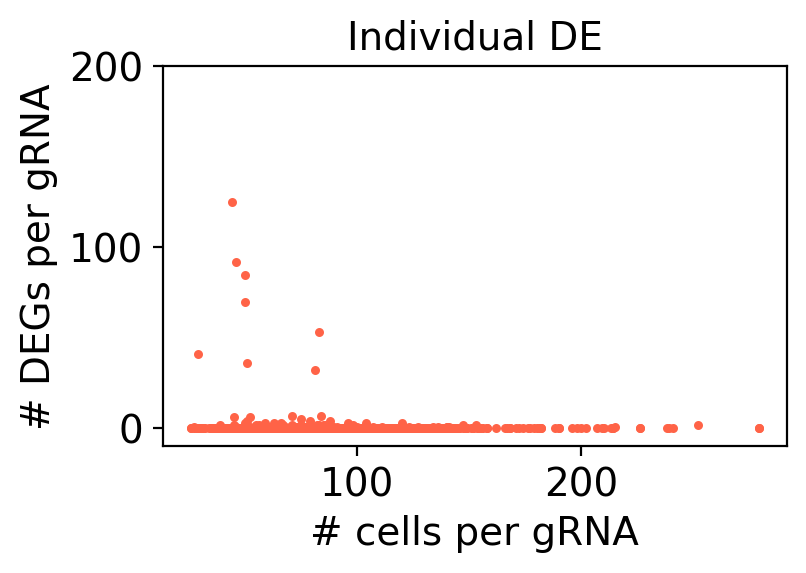

In [182]:
plot_n_degs_vs_n_cells(individual_n_cells_degs_df, figsize=(4,2.5), 
                       title="Individual DE", color="tomato",
                       ylim=(-10, 200))

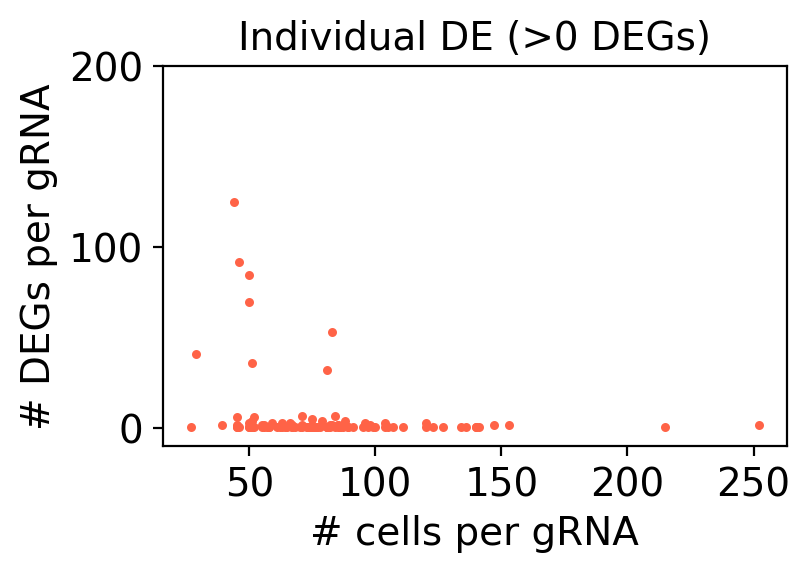

In [191]:
plot_n_degs_vs_n_cells(individual_n_cells_degs_df, min_n_degs=1,
                       title="Individual DE (>0 DEGs)", color="tomato",
                       ylim=(-10, 200), figsize=(4,2.5))

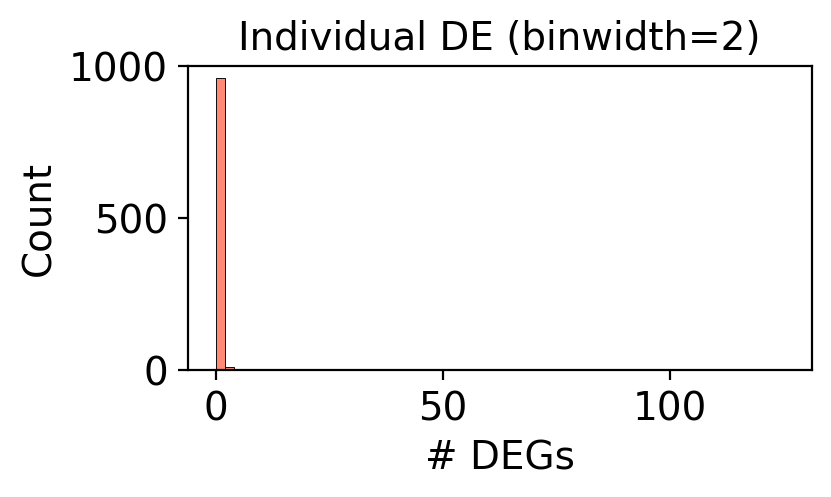

In [172]:
plot_n_degs_histogram(individual_n_cells_degs_df, figsize=(4,2), ylim=(0,1000),
                      title="Individual DE (binwidth=2)",
                      color="tomato", binwidth=2)

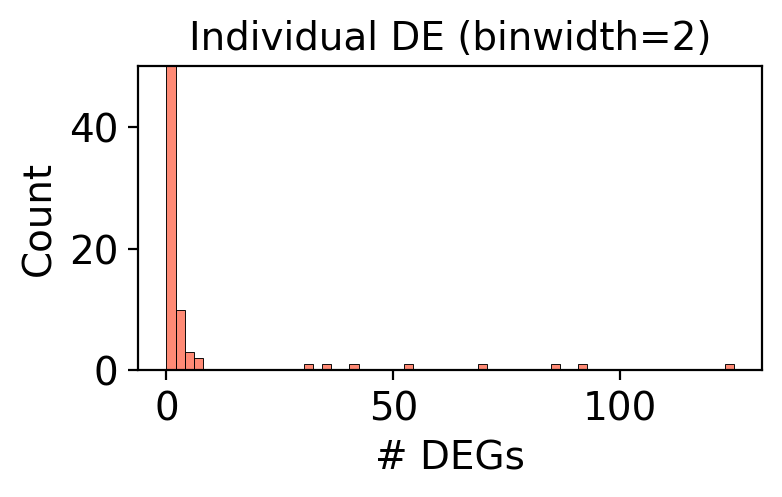

In [157]:
plot_n_degs_histogram(individual_n_cells_degs_df, title="Individual DE (binwidth=2)",
                      color="tomato", ylim=(0, 50), binwidth=2)

Compare to combined DE method results

In [5]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_11-12-25.pkl"
chunk_DE_res_df = pd.read_pickle(filepath_pkl)

In [8]:
chunk_DE_n_cells_degs_df = \
    build_n_cells_degs_df(chunk_DE_res_df, adata, alpha=0.05)
chunk_DE_n_cells_degs_df.head()

n_cells  n_DEGs
gRNA                    
ADNP2_1      215       1
ADNP2_2      121       2
ADNP2_3      154       3
AHR_2         83       1
ALX4_2        67       0

In [9]:
chunk_DE_n_cells_degs_df.sort_values(by="n_DEGs", ascending=False).head(10)

n_cells  n_DEGs
gRNA                      
POU5F1_2        29    1072
POU5F1B_1       44    1054
POU5F1_3        50     948
PHF20_1         46     848
POU5F1_1        27     841
POU3F2_2        50     701
ZNF396_2        51     601
ZNF521_1        83     578
NANOG_2         81     245
PURG_3          63     238

In [33]:
print(len(chunk_DE_n_cells_degs_df[chunk_DE_n_cells_degs_df["n_DEGs"] == 0]))
print(len(chunk_DE_n_cells_degs_df[chunk_DE_n_cells_degs_df["n_DEGs"] > 0]))
print(len(chunk_DE_n_cells_degs_df[chunk_DE_n_cells_degs_df["n_DEGs"] >= 3]))
print(len(chunk_DE_n_cells_degs_df[chunk_DE_n_cells_degs_df["n_DEGs"] >= 10]))

446
540
283
131


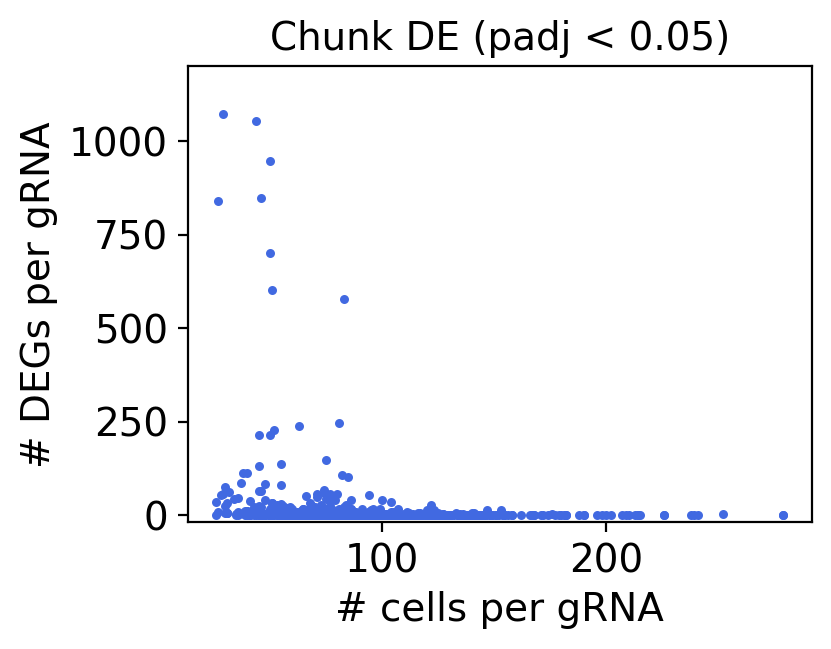

In [16]:
plot_n_degs_vs_n_cells(chunk_DE_n_cells_degs_df, title="Chunk DE (padj < 0.05)", 
                       ylim=(-20, 1200), figsize=(4,3))

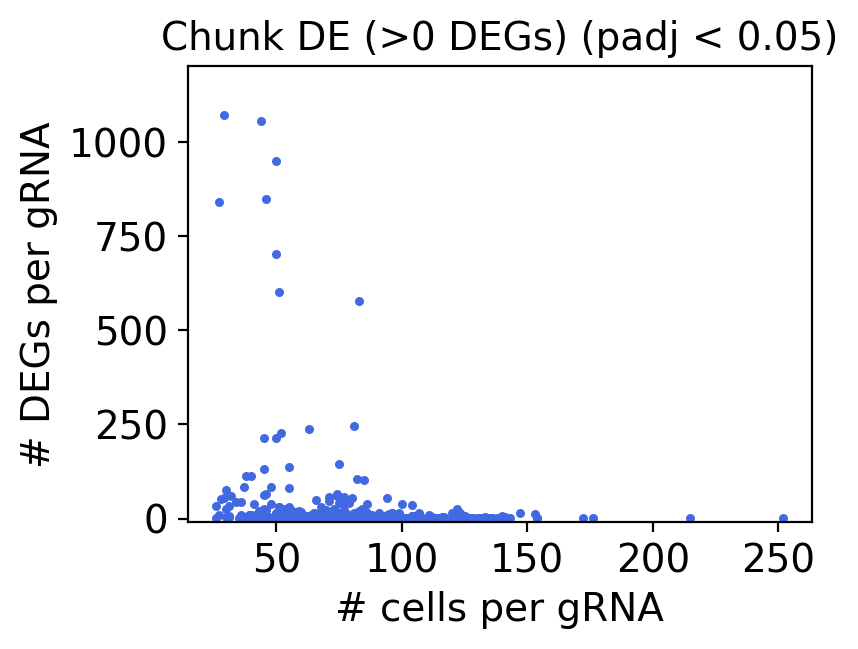

In [17]:
plot_n_degs_vs_n_cells(chunk_DE_n_cells_degs_df, min_n_degs=1,
                       title="Chunk DE (>0 DEGs) (padj < 0.05)",
                       ylim=(-10, 1200), figsize=(4,3))

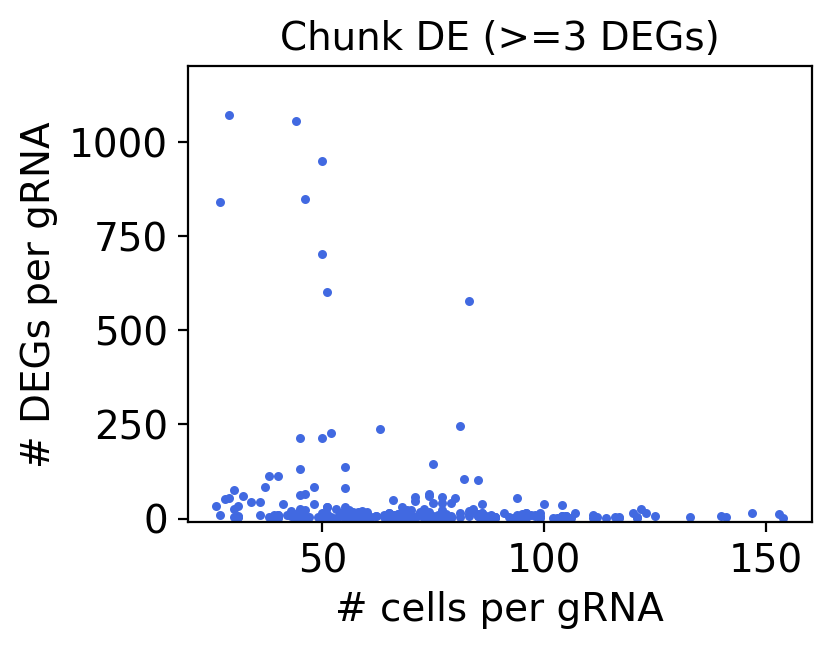

In [200]:
plot_n_degs_vs_n_cells(chunk_DE_n_cells_degs_df, min_n_degs=3,
                       title="Chunk DE (>=3 DEGs)",
                       ylim=(-10, 1200), figsize=(4,3))

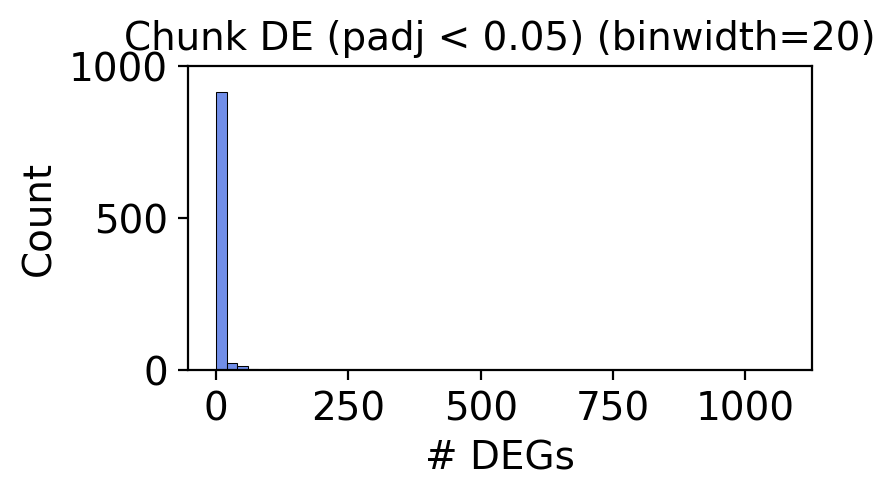

In [18]:
plot_n_degs_histogram(chunk_DE_n_cells_degs_df, figsize=(4,2), ylim=(0,1000),
                      title="Chunk DE (padj < 0.05) (binwidth=20)", binwidth=20)

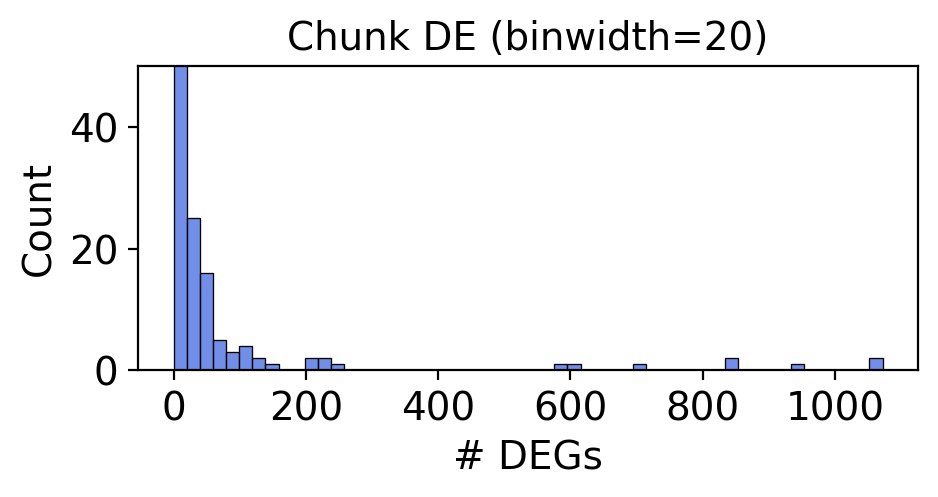

In [168]:
plot_n_degs_histogram(chunk_DE_n_cells_degs_df, figsize=(5,2),
                      binwidth=20, title="Chunk DE (binwidth=20)", ylim=(0, 50))

In [10]:
chunk_DE_n_cells_degs_df_10 = \
    build_n_cells_degs_df(chunk_DE_res_df, adata, alpha=0.1)
chunk_DE_n_cells_degs_df_10.head()

n_cells  n_DEGs
gRNA                    
ADNP2_1      215       1
ADNP2_2      121       3
ADNP2_3      154       9
AHR_2         83       2
ALX4_2        67       0

In [29]:
chunk_DE_n_cells_degs_df_10.sort_values(by="n_DEGs", ascending=False).head(10)

n_cells  n_DEGs
gRNA                      
POU5F1_2        29    1350
POU5F1B_1       44    1319
POU5F1_3        50    1174
PHF20_1         46    1094
POU5F1_1        27    1075
POU3F2_2        50     950
ZNF396_2        51     768
ZNF521_1        83     756
NANOG_2         81     322
PURG_3          63     303

In [39]:
print(len(chunk_DE_n_cells_degs_df_10[chunk_DE_n_cells_degs_df_10["n_DEGs"] == 0]))
print(len(chunk_DE_n_cells_degs_df_10[chunk_DE_n_cells_degs_df_10["n_DEGs"] < 20]))
print(len(chunk_DE_n_cells_degs_df_10[chunk_DE_n_cells_degs_df_10["n_DEGs"] > 0]))
print(len(chunk_DE_n_cells_degs_df_10[chunk_DE_n_cells_degs_df_10["n_DEGs"] >= 3]))
print(len(chunk_DE_n_cells_degs_df_10[chunk_DE_n_cells_degs_df_10["n_DEGs"] >= 10]))

315
884
671
422
182


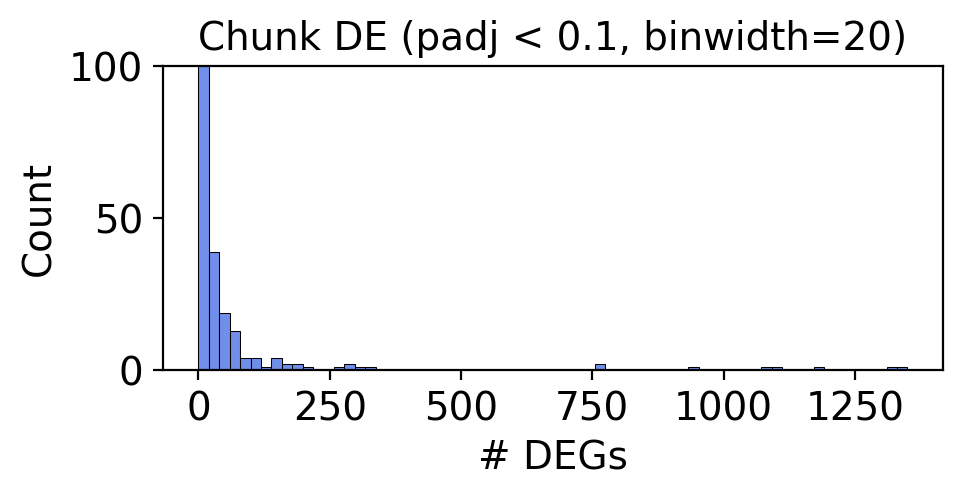

In [44]:
plot_n_degs_histogram(chunk_DE_n_cells_degs_df_10, figsize=(5,2),
                      binwidth=20, title="Chunk DE (padj < 0.1, binwidth=20)", ylim=(0, 100))

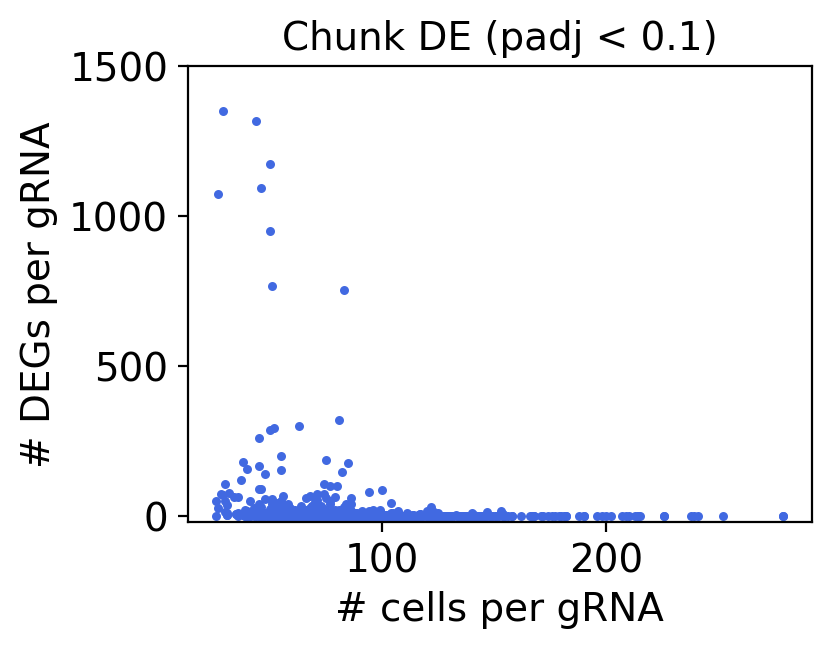

In [51]:
plot_n_degs_vs_n_cells(chunk_DE_n_cells_degs_df_10, title="Chunk DE (padj < 0.1)", 
                       ylim=(-20, 1500), figsize=(4,3))

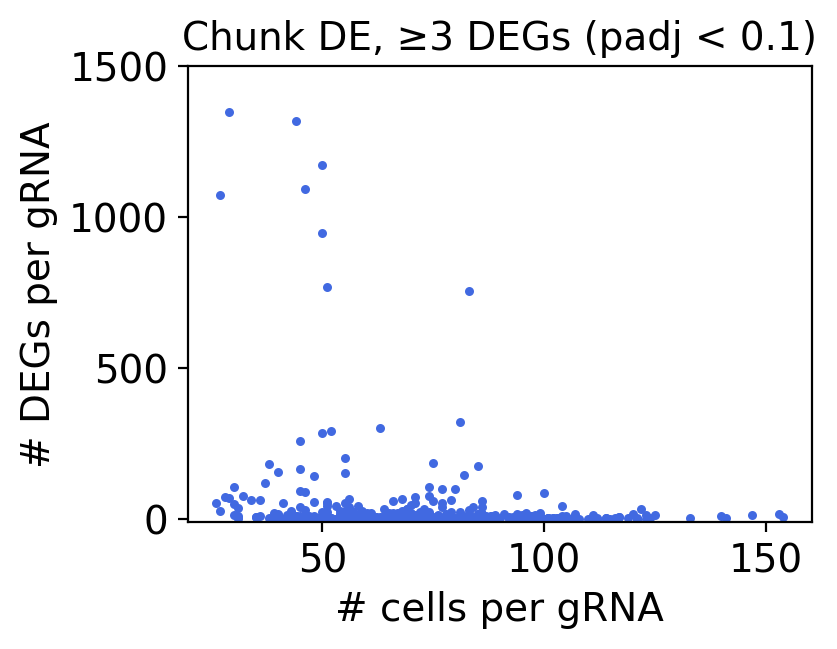

In [14]:
plot_n_degs_vs_n_cells(chunk_DE_n_cells_degs_df_10, min_n_degs=3,
                       title="Chunk DE, ≥3 DEGs (padj < 0.1)",
                       ylim=(-10, 1500), figsize=(4,3))

### Compare to old method, 5 runs per gRNA, 2-3 reps, no overlap

In [2]:
# Old DE functions - individual DE, 5 runs, no overlaps
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import gc
from scipy.stats import false_discovery_control
metacp_root = "/home/ranwyl/metacp/"
if metacp_root not in sys.path:
    sys.path.insert(0, metacp_root)
import metacp
import warnings


def generate_pseudoreplicates_for_DE(adata: ad.AnnData, 
                                     target_value: str, 
                                     ntc_cell_indices: pd.Index, 
                                     rng: np.random.Generator, 
                                     target_column: str = "perturbation", 
                                     min_cells_per_rep: int = 20,
                                     layer: str = "counts"):
    """
    Generate independent pseudoreplicates for a given target (gRNA or gene target) 
    and matched NTC cells. Manually set NTC as reference for DE analysis.
    """
    # Create views for target and NTC cells
    if target_column not in adata.obs:
        print(f"Error: {target_column} not in adata.obs")
        return
    target_mask = adata.obs[target_column] == target_value
    target_view = adata[target_mask]
    ntc_view = adata[ntc_cell_indices]

    # Get data matrices from counts layer
    if layer in adata.layers:
        target_data = target_view.layers[layer]
        ntc_data = ntc_view.layers[layer]
    else:
        target_data = target_view.X
        ntc_data = ntc_view.X        
    
    # Convert to dense if sparse
    if sparse.issparse(target_data):
        target_data = target_data.toarray()
    if sparse.issparse(ntc_data):
        ntc_data = ntc_data.toarray()

    # Calculate number of cells to sample
    n_target_cells = target_data.shape[0]
    n_ntc_cells = ntc_data.shape[0]
    if n_target_cells >= min_cells_per_rep * 2:
        n_reps = min(3, n_target_cells // min_cells_per_rep)
    else: # If too few cells for 2 reps x min_cells_per_rep cells
        n_reps = 2
    target_rep_size = n_target_cells // n_reps
    ntc_rep_size = min(target_rep_size, n_ntc_cells // n_reps)
    if ntc_rep_size < target_rep_size:
        print("Warning: Unmatched number of target and NTC cells")

    # Pre-allocate arrays for results
    target_bulk = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
    ntc_bulk = np.zeros((n_reps, ntc_data.shape[1]), dtype=np.int64)

    # Sample cells for all replicates
    target_sample_size = target_rep_size * n_reps
    ntc_sample_size = ntc_rep_size * n_reps
    sampled_target_indices = \
        rng.choice(n_target_cells, target_sample_size, replace=False)
    sampled_ntc_indices = \
        rng.choice(n_ntc_cells, ntc_sample_size, replace=False)
    # Generate replicates using vectorized operations
    for i in range(n_reps):
        # Sample indices
        target_start, target_stop = i*target_rep_size, (i+1)*target_rep_size
        target_rep_indices = sampled_target_indices[target_start:target_stop]
        ntc_start, ntc_stop = i*ntc_rep_size, (i+1)*ntc_rep_size
        ntc_rep_indices = sampled_ntc_indices[ntc_start:ntc_stop]

        # Calculate sums using vectorized operations
        target_bulk[i] = np.sum(target_data[target_rep_indices], axis=0).astype(np.int64)
        ntc_bulk[i] = np.sum(ntc_data[ntc_rep_indices], axis=0).astype(np.int64)  

    # Create sample names
    if "_" in target_value:
        target_value = target_value.replace("_", "-")
    sample_names = [f"{target_value}-rep{i+1}" for i in range(n_reps)]
    control_names = [f"NTC-rep{i+1}" for i in range(n_reps)]
    
    # Combine data
    combined_data = np.vstack([target_bulk, ntc_bulk])
    combined_names = sample_names + control_names
    
    # Create metadata DF
    metadata_df = pd.DataFrame({
        'condition': [target_value] * n_reps + ['NTC'] * n_reps
    }, index=combined_names)
    # Set NTC as reference for DESeq2
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", target_value],
        ordered=True
        )
    
    # Create counts DF
    counts_df = pd.DataFrame(
        combined_data,
        index=combined_names,
        columns=adata.var_names
    )

    return counts_df, metadata_df

def differential_expression_multiple_runs(adata: ad.AnnData, 
                    target_column: str = "perturbation", 
                    ntc_cells_delimiter: str = "NTC", 
                    alpha: float = 0.05, n_cpus: int = 20, 
                    min_cells_per_rep: int = 20,
                    n_runs_per_target: int = 5,
                    layer: str = "counts", random_state: int = 42, 
                    shrink_lfcs: bool = False, debug: bool = False):
    """
    Run differential expression analysis on each perturbation in the 
    dataset n_runs_per_target times per perturbation. Return dict of 
    {perturbation_run : DE results for that perturbation and run}.
    """
    # Identify KD and NTC cells
    perturbations = list(adata.obs[target_column].unique())
    perturbations.remove(ntc_cells_delimiter) # Remove NTC group
    if debug == True: # Debug mode: run with 3 perturbations
        print(f"Running in debug mode with 3 perturbations")
        perturbations = perturbations[:3]
    ntc_cell_indices = np.where(adata.obs[target_column] == ntc_cells_delimiter)[0]

    # Create multiple runs per perturbation
    if n_runs_per_target > 0:
        perturbations_runs = [f"{pert}-run{i+1}" for pert in perturbations
                                for i in range(n_runs_per_target)]
    else:
        perturbations_runs = perturbations

    # Create RNG object
    de_rng = np.random.default_rng(random_state)
    # Create one child RNG object per perturbation and run
    streams = de_rng.spawn(len(perturbations_runs))

    # Determine how many CPUs to use per joblib Parallel job
    #   and per DE analysis run
    if n_cpus < 3:
        n_cpus_for_DE = n_cpus
    elif n_cpus <= 10:
        n_cpus_for_DE = 3
    elif 20 <= n_cpus < 30:
        n_cpus_for_DE = 4
    elif 30 <= n_cpus < 50:
        n_cpus_for_DE = 5
    else:
        n_cpus_for_DE = 6
    n_jobs = max(1, n_cpus // n_cpus_for_DE)

    # Warning if given layer not found
    if layer not in adata.layers:
         print(f"Warning: {layer} not in adata.layers, using adata.X instead")

    # Function to run DE analysis on a single perturbation
    quiet = True
    def process_perturbation(target_value: str, rng: np.random.Generator, quiet=quiet):
        # Get actual target value
        if "-run" in target_value:
            target_value = target_value.split("-run")[0]
        
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = generate_pseudoreplicates_for_DE(
            adata, target_value, ntc_cell_indices, rng, 
            target_column=target_column, min_cells_per_rep=min_cells_per_rep,
            layer=layer
        )

        # Set number of CPUs to use for each DE run
        inference = DefaultInference(n_cpus=n_cpus_for_DE) 

        # Read counts modeling and fitting dispersions
        dds = DeseqDataSet(
            counts = pseudo_bulk_df, 
            metadata = metadata_df,
            refit_cooks=True,
            inference=inference,
            quiet=quiet
            )
        dds.deseq2()
        
        # Statistical testing
        target_hyphenated = target_value.replace('_', '-')
        contrast = ["condition", target_hyphenated, ntc_cells_delimiter]
        stat_res = DeseqStats(
            dds, 
            contrast=contrast, 
            alpha=alpha,
            inference=inference,
            quiet=quiet)
        stat_res.summary()
        if shrink_lfcs == True:
            # Shrink LFCs for downstream analysis
            stat_res.lfc_shrink(coeff=f"condition_{contrast[1]}_vs_{contrast[2]}", 
                                adapt=False)
        results_df = stat_res.results_df

        # Clean up memory
        del pseudo_bulk_df, metadata_df, dds, stat_res
        gc.collect()

        # Return results
        return results_df

    # Run DE analysis on all perturbations in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(perturbations_runs)):
        results = Parallel(n_jobs=n_jobs)(delayed(process_perturbation)(target_value, rng)
            for target_value, rng in zip(perturbations_runs, streams))
    
    results_dict = dict(zip(perturbations_runs, results))
    return results_dict

In [55]:
from tqdm import tqdm

def build_multi_DE_run_df(de_results_dict):

    def build_multi_DE_run_single_target_df(target: str,
                                        pvalue_col: str = "pvalue",
                                        lfc_col: str = "log2FoldChange",
                                        run_delimiter: str = "-run"):
        """
        Given a perturbation and DE results for that perturbation across
        multiple runs, combine the p-values via Cauchy Combination Test and
        perform multiple testing correction via BH method.
        """
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            target_runs = [run for run in de_results_dict 
                        if run.startswith(f"{target + run_delimiter}")]
            n_runs = len(target_runs)
            genes = de_results_dict[target_runs[0]].index
            pval_dict = dict()
            lfc_array = np.zeros((len(genes), n_runs))

            # Check that all run DFs have same index; if not, sort later
            sort_genes = False
            for run in target_runs[1:]:
                if not de_results_dict[run].index.equals(genes):
                    sort_genes = True
                    print("DE run results do not all have same index")
            
            # Get p-values and LFCs from each run
            for i in range(n_runs):
                run_df = de_results_dict[target + run_delimiter + str(i+1)]
                if sort_genes:
                    run_df = run_df.sort_index()
                lfc_array[:, i] = run_df[lfc_col].values
                pval_dict[f"run{i+1}_pvalue"] = run_df[pvalue_col]
            median_lfcs = np.nanmedian(lfc_array, axis=1)

            # Combine p-values
            pval_df = pd.DataFrame.from_dict({"Gene": genes} | pval_dict)
            pval_df.set_index("Gene", inplace=True)
            pval_df.index.rename("", inplace=True)
            combined_pvals = list()
            for i in range(len(pval_df)): # Loop through rows
                combined_pvals.append(
                    metacp.cauchy_method(pval_df.iloc[i].values, 
                                         data_type="pvals"))
            multi_run_df = \
                pd.DataFrame.from_dict({"Gene": genes, "median_LFC": median_lfcs,
                                        "combined_pvalue": combined_pvals})
            multi_run_df.set_index("Gene", inplace=True)
            multi_run_df.index.rename("", inplace=True)
            
            # Compute false discovery rates
            nan_mask = multi_run_df["combined_pvalue"].notna()
            fdrs = \
                false_discovery_control(multi_run_df.loc[nan_mask, "combined_pvalue"], 
                                        method="bh")
            multi_run_df["combined_padj"] = np.nan
            multi_run_df.loc[nan_mask, "combined_padj"] = fdrs

            del pval_df, pval_dict, lfc_array, combined_pvals, fdrs, genes
            gc.collect()
            return multi_run_df
    
    # For each target, create combined DF of all runs
    targets = {k.split("-run")[0] for k in de_results_dict.keys()}
    targets = list(targets)
    multi_run_dfs = list()
    for i in tqdm(range(len(targets))):
        multi_run_df = \
            build_multi_DE_run_single_target_df(targets[i])
        multi_run_dfs.append(multi_run_df)
    # Concatenate all DFs
    df_list = list()
    for target, df in zip(targets, multi_run_dfs):
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

def build_n_cells_degs_df(DE_results_df, adata, target_type="perturbation",
                          alpha=0.05, padj_col="padj"):
    if (target_type != "perturbation") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'perturbation' or 'gene_target")
    # Build DF of targets and n_cells
    n_cells_degs_df = adata.obs[target_type].value_counts().reset_index()
    if "NTC" in n_cells_degs_df[target_type].values:
        n_cells_degs_df = n_cells_degs_df[n_cells_degs_df[target_type] != "NTC"]
    n_cells_degs_df.rename(columns={"count": "n_cells"}, inplace=True)
    n_cells_degs_df.sort_values(by=target_type, inplace=True)
    # Build n_DEGs column
    n_degs_list = list()
    targets = n_cells_degs_df[target_type].tolist()
    for target in targets:
        target_df = \
            DE_results_df.loc[:, DE_results_df.columns.str.contains(f"{target}_")]
        n_degs = len(target_df[target_df[f"{target}_{padj_col}"] < alpha])
        n_degs_list.append(n_degs)
    n_cells_degs_df["n_DEGs"] = n_degs_list
    index_name = target_type if target_type == "gene_target" else "gRNA"
    n_cells_degs_df = n_cells_degs_df.set_index(target_type).rename_axis(index_name)
    return n_cells_degs_df

In [3]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [ ]:
# 89.5 minutes
individual_DE_5_runs_results_dict = \
    differential_expression_multiple_runs(adata, n_cpus=60)

Running DE analysis:   0%|          | 0/4930 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prio

In [56]:
individual_DE_5_runs_df = build_multi_DE_run_df(individual_DE_5_runs_results_dict)

100%|██████████| 986/986 [13:13<00:00,  1.24it/s]


In [57]:
individual_DE_5_runs_df.head()

HES6_3_median_LFC  HES6_3_combined_pvalue  HES6_3_combined_padj  \
                                                                             
A1BG                0.946759                0.350831              0.998432   
A1BG-AS1           -1.092137                     NaN                   NaN   
A2M                 0.812283                0.742738              0.998432   
A2ML1               0.696351                0.381449              0.998432   
A2ML1-AS1          -0.817883                0.552870              0.998432   

           OSR2_3_median_LFC  OSR2_3_combined_pvalue  OSR2_3_combined_padj  \
                                                                             
A1BG               -0.461103                0.862489              0.999879   
A1BG-AS1           -2.104965                     NaN                   NaN   
A2M                 1.559681                0.771625              0.999879   
A2ML1               0.086733                0.955407              0.999879   
A2ML1-AS1          -0.137995                0.860836              0.999879   

           ZNF219_2_median_LFC  ZNF219_2_combined_pvalue  \
                                                           
A1BG                 -0.271500                  0.752641   
A1BG-AS1             -0.159122                  0.880632   
A2M                   2.595526                  0.378480   
A2ML1                 0.045239                  0.931435   
A2ML1-AS1             0.053575                  0.861405   

           ZNF219_2_combined_padj  RXRB_1_median_LFC  ...  \
                                                      ...   
A1BG                     0.999778          -0.597591  ...   
A1BG-AS1                 0.999778          -1.289549  ...   
A2M                      0.999778          -1.798849  ...   
A2ML1                    0.999778          -1.156036  ...   
A2ML1-AS1                0.999778          -0.339235  ...   

           HMBOX1_3_combined_padj  TFAP2E_2_median_LFC  \
                                                         
A1BG                     0.999115             0.031494   
A1BG-AS1                 0.999115            -0.093563   
A2M                      0.999115             1.301089   
A2ML1                    0.999115             0.822091   
A2ML1-AS1                0.999115             0.991316   

           TFAP2E_2_combined_pvalue  TFAP2E_2_combined_padj  \
                                                              
A1BG                       0.951224                0.999967   
A1BG-AS1                   0.948779                0.999967   
A2M                        0.866952                0.999967   
A2ML1                      0.835731                0.999967   
A2ML1-AS1                  0.715328                0.999967   

           ZNF473_2_median_LFC  ZNF473_2_combined_pvalue  \
                                                           
A1BG                 -0.546658                  0.830748   
A1BG-AS1             -1.135532                  0.802517   
A2M                   0.746905                  0.884704   
A2ML1                 0.771099                  0.468055   
A2ML1-AS1             0.352796                  0.662645   

           ZNF473_2_combined_padj  CENPX_1_median_LFC  \
                                                        
A1BG                     0.999728            0.157732   
A1BG-AS1                 0.999728           -0.193212   
A2M                      0.999728            2.487111   
A2ML1                    0.999728           -1.694081   
A2ML1-AS1                0.999728           -0.190269   

           CENPX_1_combined_pvalue  CENPX_1_combined_padj  
                                                           
A1BG                      0.828469               0.999677  
A1BG-AS1                  0.878672               0.999677  
A2M                       0.428431               0.999677  
A2ML1                     0.413489               0.999677  
A2ML1-AS1                 0.888936    

In [59]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_individual_5runs_11-12-25.pkl"
individual_DE_5_runs_df.to_pickle(filepath_pkl)

In [19]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_individual_5runs_11-12-25.pkl"
individual_DE_5_runs_df = pd.read_pickle(filepath_pkl)

In [20]:
individual_DE_5_runs_n_cells_degs_df = \
    build_n_cells_degs_df(individual_DE_5_runs_df, adata,
        padj_col="combined_padj", alpha=0.05)

In [21]:
individual_DE_5_runs_n_cells_degs_df.head()

n_cells  n_DEGs
gRNA                    
ADNP2_1      215       1
ADNP2_2      121       1
ADNP2_3      154       0
AHR_2         83       0
ALX4_2        67       0

In [34]:
print(len(individual_DE_5_runs_n_cells_degs_df[individual_DE_5_runs_n_cells_degs_df["n_DEGs"] == 0]))
print(len(individual_DE_5_runs_n_cells_degs_df[individual_DE_5_runs_n_cells_degs_df["n_DEGs"] > 0]))
print(len(individual_DE_5_runs_n_cells_degs_df[individual_DE_5_runs_n_cells_degs_df["n_DEGs"] >= 3]))
print(len(individual_DE_5_runs_n_cells_degs_df[individual_DE_5_runs_n_cells_degs_df["n_DEGs"] >= 10]))

865
121
27
11


In [24]:
print(len(individual_DE_5_runs_n_cells_degs_df[individual_DE_5_runs_n_cells_degs_df["n_DEGs"] == 0]))

865


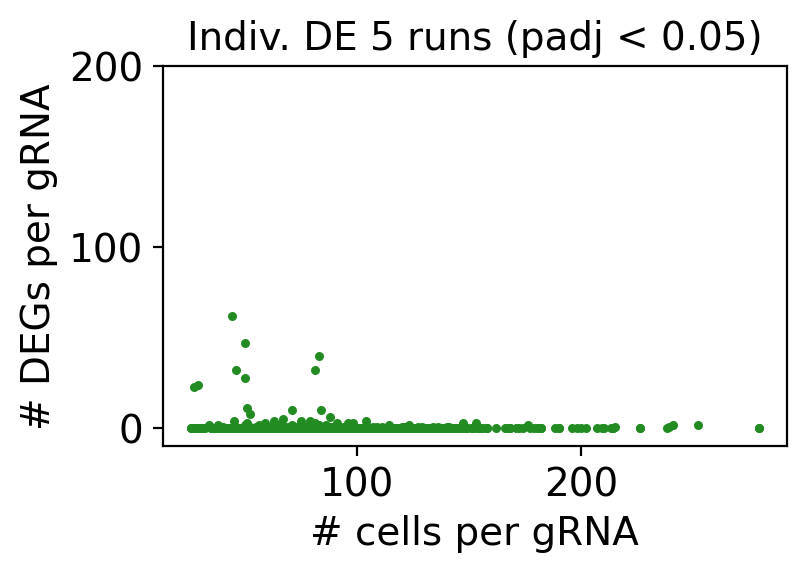

In [23]:
plot_n_degs_vs_n_cells(individual_DE_5_runs_n_cells_degs_df, figsize=(4,2.5), 
                       title="Indiv. DE 5 runs (padj < 0.05)", color="forestgreen",
                       ylim=(-10, 200))

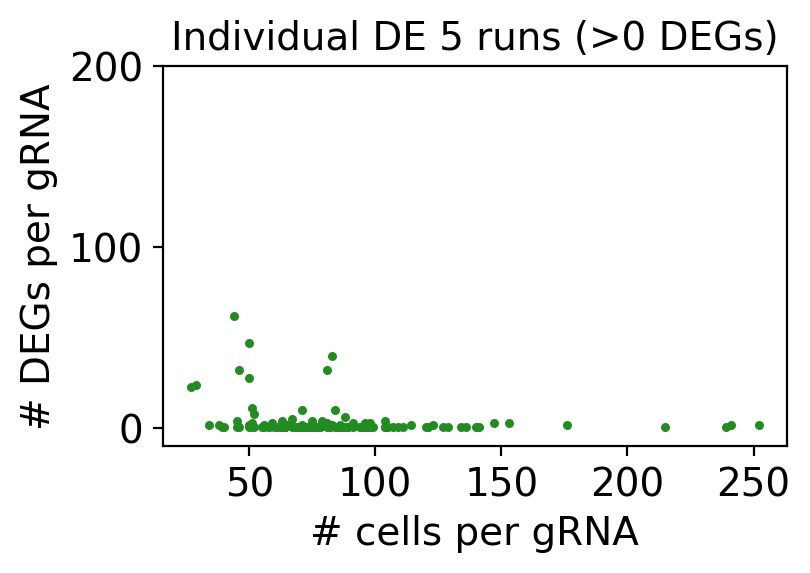

In [70]:
plot_n_degs_vs_n_cells(individual_DE_5_runs_n_cells_degs_df, 
                       min_n_degs=1,
                       title="Individual DE 5 runs (>0 DEGs)", color="forestgreen",
                       ylim=(-10, 200), figsize=(4,2.5))

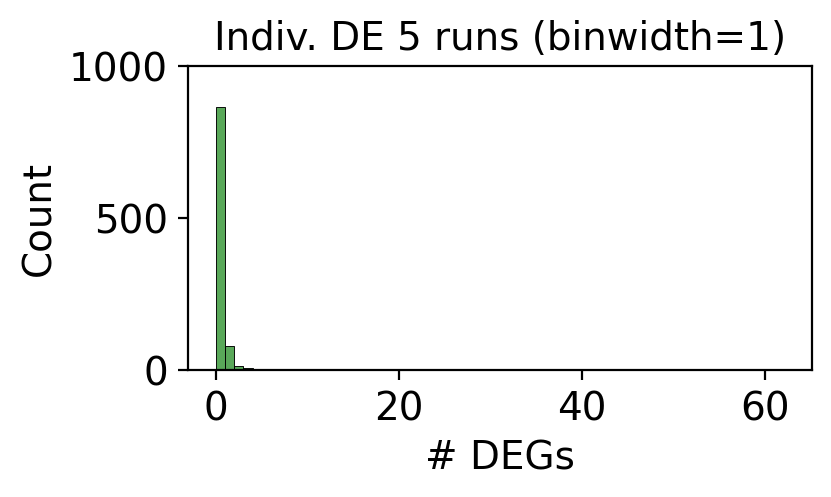

In [25]:
plot_n_degs_histogram(individual_DE_5_runs_n_cells_degs_df, 
                      figsize=(4,2), ylim=(0,1000),
                      title="Indiv. DE 5 runs (binwidth=1)",
                      color="forestgreen", binwidth=1)

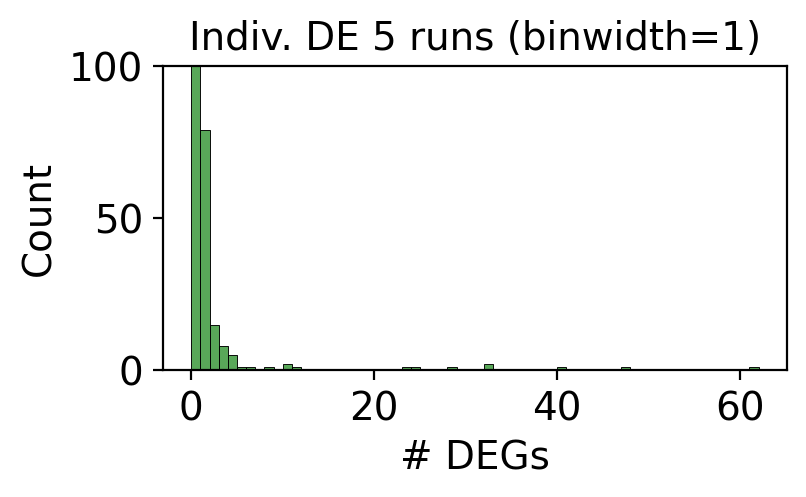

In [26]:
plot_n_degs_histogram(individual_DE_5_runs_n_cells_degs_df, 
                      figsize=(4,2), ylim=(0,100),
                      title="Indiv. DE 5 runs (binwidth=1)",
                      color="forestgreen", binwidth=1)

In [35]:
individual_DE_5_runs_n_cells_degs_df_10 = \
    build_n_cells_degs_df(individual_DE_5_runs_df, adata,
        padj_col="combined_padj", alpha=0.1)

In [36]:
print(len(individual_DE_5_runs_n_cells_degs_df_10[individual_DE_5_runs_n_cells_degs_df_10["n_DEGs"] == 0]))
print(len(individual_DE_5_runs_n_cells_degs_df_10[individual_DE_5_runs_n_cells_degs_df_10["n_DEGs"] > 0]))
print(len(individual_DE_5_runs_n_cells_degs_df_10[individual_DE_5_runs_n_cells_degs_df_10["n_DEGs"] >= 3]))
print(len(individual_DE_5_runs_n_cells_degs_df_10[individual_DE_5_runs_n_cells_degs_df_10["n_DEGs"] >= 10]))

852
134
30
11


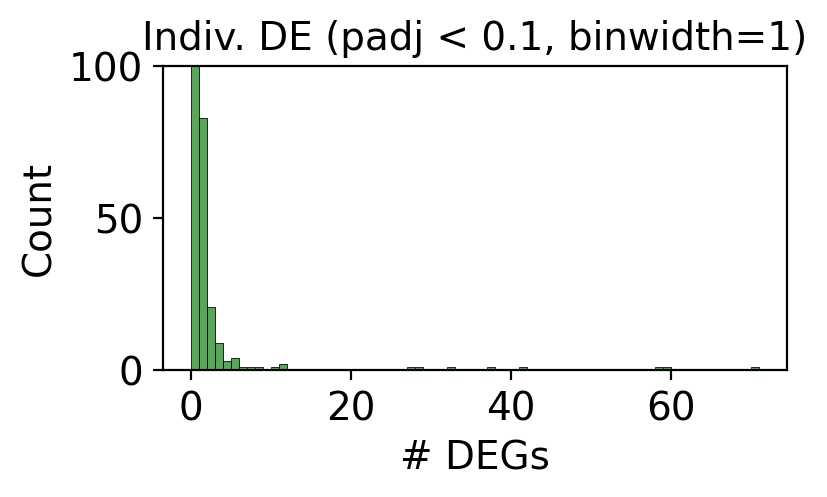

In [ ]:
plot_n_degs_histogram(individual_DE_5_runs_n_cells_degs_df_10, 
                      figsize=(4,2), ylim=(0,100),
                      title="Indiv. DE (padj < 0.1, binwidth=1)",
                      color="forestgreen", binwidth=1)

In [80]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_individual_11-12-25.pkl"
individual_DE_1_run_res_df = pd.read_pickle(filepath_pkl)

In [81]:
individual_DE_1_run_n_cells_degs_df = \
    build_n_cells_degs_df(individual_DE_1_run_res_df, adata)

In [82]:
individual_DE_1_run_n_cells_degs_df[individual_DE_1_run_n_cells_degs_df["n_DEGs"] > 0]

n_cells  n_DEGs
gRNA                       
ADNP2_1         215       1
ARHGAP35_1      136       1
ARHGAP35_3      252       2
ARID3B_3         81       1
ASCL1_3          78       1
...             ...     ...
ZNF512_3         56       2
ZNF521_1         83      53
ZNF609_1         62       1
ZNF609_2         86       1
ZNF853_1         77       1

[104 rows x 2 columns]

In [84]:
print(len(individual_DE_1_run_n_cells_degs_df[individual_DE_1_run_n_cells_degs_df["n_DEGs"] > 0]))
print(len(individual_DE_1_run_n_cells_degs_df[individual_DE_1_run_n_cells_degs_df["n_DEGs"] >= 3]))
print(len(individual_DE_1_run_n_cells_degs_df[individual_DE_1_run_n_cells_degs_df["n_DEGs"] >= 10]))

104
23
8


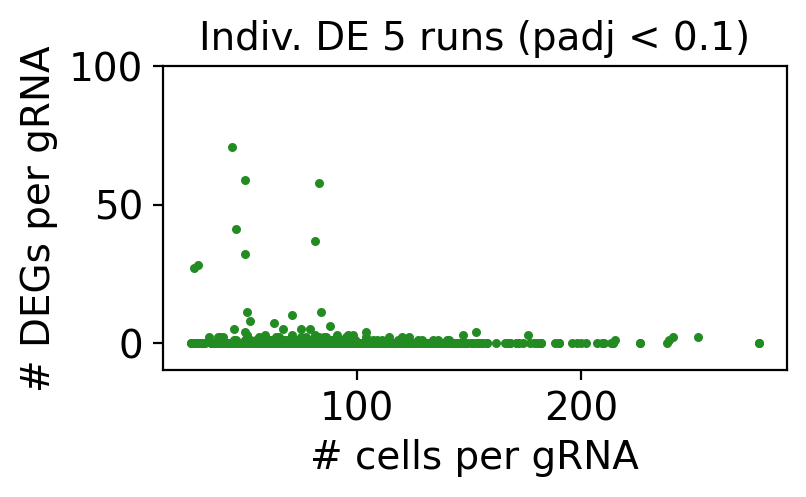

In [54]:
plot_n_degs_vs_n_cells(individual_DE_5_runs_n_cells_degs_df_10, figsize=(4,2), 
                       title="Indiv. DE 5 runs (padj < 0.1)", color="forestgreen",
                       ylim=(-10, 100))

## 4 chunks, 2 reps per gRNA

### NTC benchmarking with 2 reps per gRNA

In [6]:
# run_pydeseq2() and handle_warnings
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

# Handle warnings (from PyDESeq2)
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def run_pydeseq2(counts_df: pd.DataFrame, metadata_df: pd.DataFrame,
                 adata: ad.AnnData, target_type: str = "gRNA",
                 n_cpus: int = 20, alpha: float = 0.05,
                 return_dds_object = False,
                 shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
                 suppress_warnings: bool = False):
    """
    Perform DE analysis with PyDESeq2 on perturbing gRNA or gene targets.
    Uses parallel processing for DeseqStats.summary().
    """
    # Get targets (PyDESeq2 0.4.12 can't handle underscores)
    targets = adata.obs[target_type].unique().tolist()
    if "NTC" in targets:
        targets.remove("NTC")
    targets_hyphenated = [t.replace("_", "-") for t in targets]
    # Run DE analysis
    with handle_warnings(suppress_warnings):
        # Set number of CPUs to use
        dds_inference = DefaultInference(n_cpus=n_cpus)
        ds_inference = DefaultInference(n_cpus=1)
        # Fit dispersions and LFCs
        dds = DeseqDataSet(counts=counts_df, metadata=metadata_df,
                          design_factors="condition",
                          continuous_factors=["n-cells-in-rep"],
                          ref_level=["condition", "NTC"],
                          inference=dds_inference, quiet=False
                          )
        print(f"\nFitting dispersion and LFC parameters with DeseqDataSet.deseq2()")
        dds.deseq2()
        # Helper function for statistical testing
        def run_DeseqStats(target, shrink_lfcs, lfc_shrink_adapt):
            contrast=["condition", target, "NTC"]
            ds = DeseqStats(dds, contrast=contrast, alpha=alpha,
                            inference=ds_inference, quiet=True)
            ds.summary()
            if shrink_lfcs:
                coeff = f"{contrast[0]}_{contrast[1]}_vs_{contrast[2]}"
                ds.lfc_shrink(coeff=coeff, adapt=lfc_shrink_adapt)
            return ds.results_df
        # Perform statistical testing in parallel
        with tqdm_joblib(desc="Running DE statistical testing", total=len(targets_hyphenated)):
            ds_results = Parallel(n_jobs=n_cpus)(
                delayed(run_DeseqStats)(target, shrink_lfcs, lfc_shrink_adapt)
                        for target in targets_hyphenated)
        # Return results
        de_results_dict = {targets[i]: ds_results[i] for i in range(len(targets))}
        if return_dds_object:
            return de_results_dict, dds
        else:
            return de_results_dict

In [ ]:
# create_pseudobulk_dataset_2_reps()
def create_pseudobulk_dataset_2_reps(adata: ad.AnnData, target_type: str = "gRNA",
                                ntc_benchmarking: bool = False,
                                layer: str = "counts",
                                approx_ntc_rep_size: int = 50,
                                random_state: int = 42,
                                ntc_target_delimiter: str = "NTC",
                                ntc_gRNA_delimiter: str = "Non-Targeting"):
    """
    Generate pseudobulk representation of adata with pseudoreplicates for 
    each gRNA or gene target (based on target_type). Use 2 reps per gRNA
    or KD.
    """
    # Error handling
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("Error: target_type must be 'gRNA' or 'gene_target'")
    if (ntc_benchmarking is True) & (target_type != "gRNA"):
        raise ValueError("Error: target_type must be 'gRNA' for NTC benchmarking")

    # Get targets
    targets = adata.obs[target_type].unique().tolist()
    # RNG objects for creating pseudoreplicates
    de_rng = np.random.default_rng(random_state)
    target_rngs = de_rng.spawn(len(targets))

    # Data structures for counts_df and metadata_df
    counts_arrays, counts_df_index = list(), list()
    metadata_condition, metadata_n_cells = list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Generate pseudoreplicates
    for target, rng in zip(targets, target_rngs):
        # Get target data
        target_indices = np.where(adata.obs[target_type] == target)[0]
        target_data = data_matrix[target_indices]
        
        # Calculate pseudoreplicate size
        n_target_cells = target_data.shape[0]
        if target_type == "gRNA": # gRNA targets
            rep1_size = n_target_cells // 2
            rep2_size = n_target_cells - rep1_size
            rep_sizes = [rep1_size, rep2_size]
        else: # Gene targets
            # Create NTC reps of about approx_ntc_rep_size as evenly as possible
            if target == ntc_target_delimiter:
                n_reps = round(n_target_cells / approx_ntc_rep_size)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)
            else:
                rep1_size = n_target_cells // 2
                rep2_size = n_target_cells - rep1_size
                rep_sizes = [rep1_size, rep2_size]

        # Sample target indices for each rep
        target_cell_indices = np.arange(n_target_cells)
        rng.shuffle(target_cell_indices)
        rep_sizes_array = np.array(rep_sizes)
        rep_splits = np.cumsum(rep_sizes_array)[:-1]
        rep_indices = np.split(target_cell_indices, rep_splits)
        
        # Update pseudobulk counts
        n_reps = len(rep_sizes)
        target_counts = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
        for i in range(n_reps):
            target_counts[i] = \
                np.sum(target_data[rep_indices[i]], axis=0).astype(np.int64)
        counts_arrays.append(target_counts)
        target_hyphenated = target.replace("_", "-")
        rep_names = [f"{target_hyphenated}-rep{i+1}" for i in range(n_reps)]
        counts_df_index += rep_names
        
        # Update metadata
        metadata_n_cells += rep_sizes
        if ntc_gRNA_delimiter in target:
            metadata_condition += (["NTC"]*n_reps)
        else:
            metadata_condition += ([target_hyphenated]*n_reps)
            
    # Create counts DF
    counts_arr = np.concatenate(tuple(arr for arr in counts_arrays), axis=0)
    counts_df = pd.DataFrame(
        counts_arr,
        index=counts_df_index,
        columns=adata.var_names
    )

    # Create metadata DF
    metadata_dict = {"sample": counts_df_index,
                    "condition": metadata_condition,
                    "n-cells-in-rep": metadata_n_cells}
    metadata_df = pd.DataFrame.from_dict(metadata_dict)
    metadata_df = metadata_df.set_index("sample").rename_axis(None)
    return counts_df, metadata_df

In [12]:
# ntc_benchmarking_DE_2_reps() and report_ntc_benchmarking_results()

def ntc_benchmarking_DE_2_reps(adata: ad.AnnData,
                        layer: str = "counts",
                        random_state: int = 42,
                        ntc_target_delimiter: str = "NTC",
                        ntc_gRNA_delimiter: str = "Non-Targeting",
                        n_cpus: int = 20, alpha: float = 0.05,
                        suppress_warnings: bool = False):
    """
    Perform DE analysis on all NTC gRNA against all other NTC cells.
    Return dict {NTC gRNA: DE results DF for that NTC gRNA}.
    """
    adata = adata[adata.obs.gene_target == ntc_target_delimiter]
    # Create pseudobulk representation of dataset
    counts_df, metadata_df = \
        create_pseudobulk_dataset_2_reps(adata, target_type="gRNA", 
                                  ntc_benchmarking=True, layer=layer,
                                  random_state=random_state,
                                  ntc_target_delimiter=ntc_target_delimiter,
                                  ntc_gRNA_delimiter=ntc_gRNA_delimiter)

    # Helper function to run DE on single NTC gRNA
    def ntc_benchmarking_single_gRNA(counts_df, metadata_df, target_ntc_gRNA):
        # Temporarily change 'condition' to 'perturbed'
        metadata_df = metadata_df.copy()
        metadata_df.loc[
            metadata_df.index.str.contains(target_ntc_gRNA), "condition"] = "perturbed"
        # Run DESeq2
        with handle_warnings(suppress_warnings):
            dds_inference = DefaultInference(n_cpus=1)
            ds_inference = DefaultInference(n_cpus=1)
            dds = DeseqDataSet(counts=counts_df, 
                               metadata=metadata_df,
                               design_factors="condition",
                               continuous_factors=["n-cells-in-rep"],
                               ref_level=["condition", "NTC"],
                               inference=dds_inference, 
                               quiet=True)
            dds.deseq2()
            ds = DeseqStats(dds, 
                            contrast=["condition", "perturbed", "NTC"], 
                            alpha=alpha,
                            inference=ds_inference, 
                            quiet=True)
            ds.summary()
            return ds.results_df
    
    # Run DE on all NTC gRNA
    targets = adata.obs.gRNA.unique().tolist()
    targets_hyphenated = [target.replace("_", "-") for target in targets]
    with tqdm_joblib(desc="Running DE analysis", total=len(targets)):
        de_results = Parallel(n_jobs=n_cpus)(
            delayed(ntc_benchmarking_single_gRNA)(counts_df, metadata_df, target)
                    for target in targets_hyphenated)
    de_results_dict = {targets[i]: de_results[i] for i in range(len(targets))}
    return de_results_dict

def report_ntc_benchmarking_results(results_dict: dict, alpha: float = 0.05, xticks=None):
        """
        Determine the threshold (number of DEGs) at which 95% of NTC gRNA have 
        fewer DEGs. Plot the distribution of DEGs for NTC gRNA and print
        a summary of results.
        """
        # Counts DEGs per gRNA
        deg_counts = {}
        for ntc_gRNA, result_df in results_dict.items():
            if result_df is None:
                continue
            deg_count = sum((result_df['padj'] < alpha) & pd.notna(result_df['padj']))
            deg_counts[ntc_gRNA] = deg_count

        # Create results DataFrame
        benchmark_results = pd.DataFrame.from_dict(deg_counts, orient='index', columns=['n_DEGs'])
        benchmark_results = benchmark_results.sort_values('n_DEGs', ascending=False)
        
        # Calculate 95th percentile threshold (FDR 0.05)
        if len(benchmark_results) > 0:
            deg_threshold = np.percentile(benchmark_results['n_DEGs'].values, 95)
        else:
            print("No results to calculate percentile.")
            return
        
        # Plot results with improved styling - code from psp.de.benchmark_NTC_FDR()
        # Set style parameters
        plt.rcParams['axes.spines.top'] = False
        plt.rcParams['axes.spines.right'] = False
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        fig.patch.set_facecolor('white')
        # Prepare bar plot data: discrete DEG counts
        deg_counts = benchmark_results['n_DEGs'].value_counts().sort_index()
        # Create bar plot
        ax.bar(
            deg_counts.index,
            deg_counts.values,
            alpha=0.8,
            color='#4682B4',   # Steel blue
            edgecolor='white',
            linewidth=1.5
        )
        # Add threshold line with improved styling
        ax.axvline(
            deg_threshold,
            color='#B22222',  # Firebrick
            linestyle='-',
            linewidth=2,
            alpha=0.8
        )
        # Labels and title with improved styling
        ax.set_xlabel('Number of DEGs', fontsize=12, labelpad=10)
        ax.set_ylabel('Number of NTC sgRNA comparisons', fontsize=12, labelpad=10)
        ax.set_title(f'Distribution of DEGs in NTC comparisons', fontsize=14, pad=20)
        # Turn off grid
        ax.grid(False)
        # Adjust tick parameters
        ax.tick_params(axis='both', which='major', labelsize=10, pad=5)
        if xticks is not None:
            ax.set_xticks(xticks)
        # Add some padding to the axes
        ax.margins(x=0.02)
        # Add custom legend-like text at bottom
        threshold_text = f"FDR 0.05 threshold: {int(deg_threshold)} DEGs"
        fig.text(0.5, 0.01, threshold_text, ha='center', fontsize=11, color='#B22222', weight='bold')
        # Adjust layout
        plt.tight_layout(rect=[0, 0.02, 1, 0.98])
        plt.show()
        
        # Print statistics
        print(f"NTC Benchmark Statistics:")
        print(f"  • FDR 0.05 threshold: {int(deg_threshold)} DEGs")
        print(f"  • NTC comparisons analyzed: {len(benchmark_results)}")
        print(f"  • Mean DEGs per comparison: {benchmark_results['n_DEGs'].mean():.1f}")
        print(f"  • Median DEGs per comparison: {benchmark_results['n_DEGs'].median():.1f}")
        print(f"  • 95% of comparisons have < {int(deg_threshold)} DEGs")

        return int(deg_threshold), benchmark_results

In [4]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [5]:
# 10 minutes
ntc_benchmark_res_2_reps = ntc_benchmarking_DE_2_reps(adata, n_cpus=50, suppress_warnings=True)

Running DE analysis:   0%|          | 0/234 [00:00<?, ?it/s]

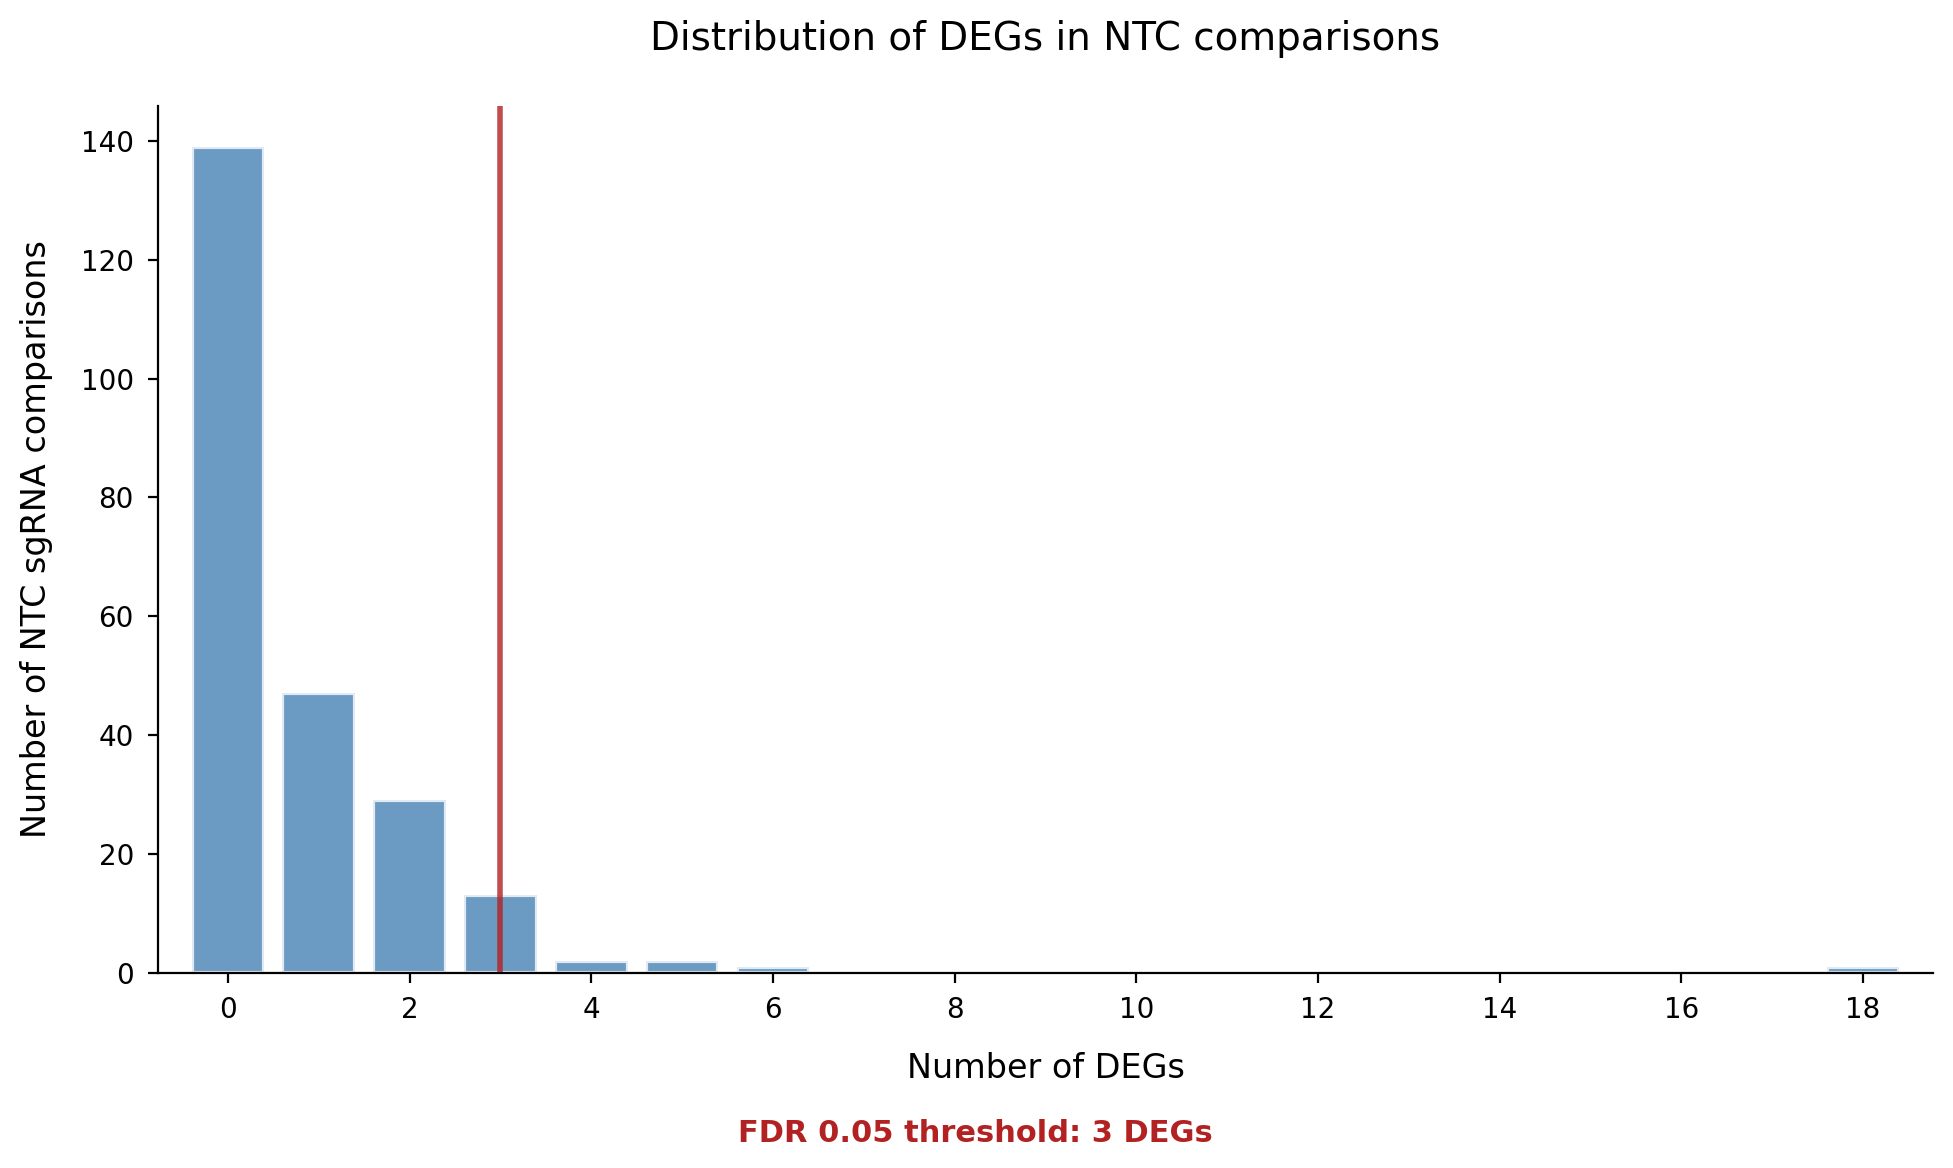

NTC Benchmark Statistics:
  • FDR 0.05 threshold: 3 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 0.8
  • Median DEGs per comparison: 0.0
  • 95% of comparisons have < 3 DEGs


In [13]:
deg_threshold_2_reps, test_benchmark_res_2_reps = \
    report_ntc_benchmarking_results(ntc_benchmark_res_2_reps, 
                                    xticks=np.arange(0, 20, step=2))

In [14]:
test_benchmark_res_2_reps.head(7)

n_DEGs
Non-Targeting_398      18
Non-Targeting_226       6
Non-Targeting_506       5
Non-Targeting_844       5
Non-Targeting_929       4
Non-Targeting_351       4
Non-Targeting_248       3

In [16]:
# NTC gRNA with >3 DEGs when using 2 reps per gRNA
ntc_gRNA_to_remove = ["Non-Targeting_398", "Non-Targeting_226", "Non-Targeting_506",
                      "Non-Targeting_844", "Non-Targeting_929", "Non-Targeting_351"]

In [18]:
adata.shape

(101923, 16115)

In [19]:
adata_benchmarked = adata[~(adata.obs.gRNA.isin(ntc_gRNA_to_remove))].copy()

In [20]:
adata_benchmarked.shape

(101620, 16115)

In [21]:
save_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked_2reps.h5ad"
adata_benchmarked.write(save_path)

### DE with 4 chunks, 2 reps per gRNA

21 min for 1 chunk, 60 CPUs

In [2]:
# run_pydeseq2() and handle_warnings
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

# Handle warnings (from PyDESeq2)
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def run_pydeseq2(counts_df: pd.DataFrame, metadata_df: pd.DataFrame,
                 targets: list, n_cpus: int = 20, alpha: float = 0.05,
                 return_dds_object = False, suppress_warnings: bool = False,
                 shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
                 ):
    """
    Perform DE analysis with PyDESeq2 on perturbing gRNA or gene targets.
    Uses parallel processing for DeseqStats.summary().
    """
    # Get targets (PyDESeq2 0.4.12 can't handle underscores)
    targets_hyphenated = [t.replace("_", "-") for t in targets]
    # Run DE analysis
    with handle_warnings(suppress_warnings):
        # Set number of CPUs to use
        dds_inference = DefaultInference(n_cpus=n_cpus)
        ds_inference = DefaultInference(n_cpus=1)
        # Fit dispersions and LFCs
        dds = DeseqDataSet(counts=counts_df, metadata=metadata_df,
                          design_factors="condition",
                          continuous_factors=["n-cells-in-rep"],
                          ref_level=["condition", "NTC"],
                          inference=dds_inference, quiet=False
                          )
        print(f"\nFitting dispersion and LFC parameters with DeseqDataSet.deseq2()")
        dds.deseq2()
        # Helper function for statistical testing
        def run_DeseqStats(target, shrink_lfcs, lfc_shrink_adapt):
            contrast=["condition", target, "NTC"]
            ds = DeseqStats(dds, contrast=contrast, alpha=alpha,
                            inference=ds_inference, quiet=True)
            ds.summary()
            if shrink_lfcs:
                coeff = f"{contrast[0]}_{contrast[1]}_vs_{contrast[2]}"
                ds.lfc_shrink(coeff=coeff, adapt=lfc_shrink_adapt)
            return ds.results_df
        # Perform statistical testing in parallel
        with tqdm_joblib(desc="Running DE statistical testing", total=len(targets_hyphenated)):
            ds_results = Parallel(n_jobs=n_cpus)(
                delayed(run_DeseqStats)(target, shrink_lfcs, lfc_shrink_adapt)
                        for target in targets_hyphenated)
        # Return results
        de_results_dict = {targets[i]: ds_results[i] for i in range(len(targets))}
        if return_dds_object:
            return de_results_dict, dds
        else:
            return de_results_dict

In [3]:
def create_pseudobulk_dataset_2_reps(adata: ad.AnnData, target_type: str = "gRNA",
                                ntc_benchmarking: bool = False,
                                layer: str = "counts",
                                approx_ntc_rep_size: int = 50,
                                random_state: int = 42,
                                ntc_target_delimiter: str = "NTC",
                                ntc_gRNA_delimiter: str = "Non-Targeting"):
    """
    Generate pseudobulk representation of adata with pseudoreplicates for 
    each gRNA or gene target (based on target_type). Use 2 reps per gRNA
    or KD.
    """
    # Error handling
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("Error: target_type must be 'gRNA' or 'gene_target'")
    if (ntc_benchmarking is True) & (target_type != "gRNA"):
        raise ValueError("Error: target_type must be 'gRNA' for NTC benchmarking")

    # Get targets
    targets = adata.obs[target_type].unique().tolist()
    # RNG objects for creating pseudoreplicates
    de_rng = np.random.default_rng(random_state)
    target_rngs = de_rng.spawn(len(targets))

    # Data structures for counts_df and metadata_df
    counts_arrays, counts_df_index = list(), list()
    metadata_condition, metadata_n_cells = list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Generate pseudoreplicates
    for target, rng in zip(targets, target_rngs):
        # Get target data
        target_indices = np.where(adata.obs[target_type] == target)[0]
        target_data = data_matrix[target_indices]
        
        # Calculate pseudoreplicate size
        n_target_cells = target_data.shape[0]
        if target_type == "gRNA": # gRNA targets
            rep1_size = n_target_cells // 2
            rep2_size = n_target_cells - rep1_size
            rep_sizes = [rep1_size, rep2_size]
        else: # Gene targets
            # Create NTC reps of about approx_ntc_rep_size as evenly as possible
            if target == ntc_target_delimiter:
                n_reps = round(n_target_cells / approx_ntc_rep_size)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)
            else:
                rep1_size = n_target_cells // 2
                rep2_size = n_target_cells - rep1_size
                rep_sizes = [rep1_size, rep2_size]

        # Sample target indices for each rep
        target_cell_indices = np.arange(n_target_cells)
        rng.shuffle(target_cell_indices)
        rep_sizes_array = np.array(rep_sizes)
        rep_splits = np.cumsum(rep_sizes_array)[:-1]
        rep_indices = np.split(target_cell_indices, rep_splits)
        
        # Update pseudobulk counts
        n_reps = len(rep_sizes)
        target_counts = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
        for i in range(n_reps):
            target_counts[i] = \
                np.sum(target_data[rep_indices[i]], axis=0).astype(np.int64)
        counts_arrays.append(target_counts)
        target_hyphenated = target.replace("_", "-")
        rep_names = [f"{target_hyphenated}-rep{i+1}" for i in range(n_reps)]
        counts_df_index += rep_names
        
        # Update metadata
        metadata_n_cells += rep_sizes
        if ntc_gRNA_delimiter in target:
            metadata_condition += (["NTC"]*n_reps)
        else:
            metadata_condition += ([target_hyphenated]*n_reps)
            
    # Create counts DF
    counts_arr = np.concatenate(tuple(arr for arr in counts_arrays), axis=0)
    counts_df = pd.DataFrame(
        counts_arr,
        index=counts_df_index,
        columns=adata.var_names
    )

    # Create metadata DF
    metadata_dict = {"sample": counts_df_index,
                    "condition": metadata_condition,
                    "n-cells-in-rep": metadata_n_cells}
    metadata_df = pd.DataFrame.from_dict(metadata_dict)
    metadata_df = metadata_df.set_index("sample").rename_axis(None)
    return counts_df, metadata_df

In [4]:
def run_dataset_DE_chunks_2_reps(adata: ad.AnnData, target_type: str = "gRNA",
                                max_chunk_size: int = 1000, layer: str = "counts",
                                approx_ntc_rep_size: int = 50,
                                random_state: int = 42,
                                ntc_target_delimiter: str = "NTC",
                                ntc_gRNA_delimiter: str = "Non-Targeting",
                                n_cpus: int = 20, alpha: float = 0.05,
                                return_dds_objects: bool = False,
                                shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
                                suppress_warnings: bool = False, debug: bool = False,
                                counts_df=None, metadata_df=None):
    """
    Run pseudobulk DE on perturbing gRNA or gene targets (based on target_type).
    Create pseudobulk dataset and break into chunks that each include all NTC reps
    and a subset of perturbing gRNAs/gene targets. Run DE on each chunk.
    """
    # Create pseudobulk dataset
    if (counts_df is None) or (metadata_df is None):
        print("Generating pseudobulk representation of dataset")
        counts_df, metadata_df = \
            create_pseudobulk_dataset_2_reps(
                adata, target_type=target_type, layer=layer,
                approx_ntc_rep_size = approx_ntc_rep_size,
                random_state=random_state,
                ntc_target_delimiter=ntc_target_delimiter,
                ntc_gRNA_delimiter=ntc_gRNA_delimiter
                )
    
    # Get number of perturbations per chunk
    n_target_samples = len(metadata_df[metadata_df["condition"] != "NTC"])
    n_ntc_samples = len(metadata_df[metadata_df["condition"] == "NTC"])
    n_chunks = round(n_target_samples / (max_chunk_size - n_ntc_samples))
    n_targets = n_target_samples // 2
    base_size = n_targets // n_chunks
    remainder = n_targets % n_chunks
    n_targets_per_chunk = [base_size+1]*remainder + [base_size]*(n_chunks-remainder)

    # Determine perturbations per chunk
    rng = np.random.default_rng(random_state)
    if target_type == "gRNA":
        all_targets = adata.obs.perturbation.unique().tolist()
    else:
        all_targets = adata.obs.gene_target.unique().tolist()
    if "NTC" in all_targets:
        all_targets.remove("NTC")
    chunk_counts_dfs, chunk_meta_dfs = list(), list()
    target_indices = np.arange(len(all_targets))
    rng.shuffle(target_indices)
    chunk_splits = np.cumsum(np.array(n_targets_per_chunk))[:-1]
    chunk_indices = np.split(target_indices, chunk_splits)

    # Divide pseudobulk dataset into chunks
    all_chunk_targets = list()
    for i in range(n_chunks):
        chunk_targets = [all_targets[j] for j in chunk_indices[i]]
        all_chunk_targets.append(chunk_targets)
        chunk_targets_hyphenated = \
            [t.replace("_", "-") for t in chunk_targets]
        chunk_meta_df = \
            metadata_df.loc[(metadata_df["condition"].isin(chunk_targets_hyphenated))
                            | (metadata_df["condition"] == "NTC")]
        chunk_samples = chunk_meta_df.index.tolist()
        chunk_counts_df = counts_df.loc[counts_df.index.isin(chunk_samples)]
        chunk_counts_dfs.append(chunk_counts_df)
        chunk_meta_dfs.append(chunk_meta_df)

    # Run DE analysis on each chunk pseudobulk dataset
    de_results_dict = dict()
    n_chunks_to_run = 1 if debug else n_chunks
    if return_dds_objects:
        dds_objects = list()
    for i in range(n_chunks_to_run):
        print(f"Running DE analysis on chunk {i+1} of {n_chunks}")
        chunk_results = \
            run_pydeseq2(chunk_counts_dfs[i], 
                         chunk_meta_dfs[i],
                         targets=all_chunk_targets[i],
                         n_cpus=n_cpus, alpha=alpha,
                         return_dds_object=return_dds_objects,
                         shrink_lfcs=shrink_lfcs,
                         lfc_shrink_adapt=lfc_shrink_adapt,
                         suppress_warnings=suppress_warnings)
        if return_dds_objects:
            de_results_dict.update(chunk_results[0])
            dds_objects.append(chunk_results[1])
        else:
            de_results_dict.update(chunk_results)
    if return_dds_objects:
        return de_results_dict, dds_objects
    else:
        return de_results_dict

In [5]:
def build_DE_df(results_dict):
    df_list = list()
    for target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [6]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked_2reps.h5ad"
adata = psp.utils.read_anndata(filepath)

In [7]:
# 71 min
de_results_2reps, dds_objects_2reps = \
    run_dataset_DE_chunks_2_reps(adata, max_chunk_size=1000, n_cpus=75,
                                 return_dds_objects=True)

Generating pseudobulk representation of dataset
Running DE analysis on chunk 1 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.31 seconds.

Fitting dispersions...
... done in 326.34 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 47.45 seconds.

Fitting LFCs...
... done in 36.61 seconds.

Calculating cook's distance...
... done in 0.71 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/247 [00:00<?, ?it/s]

Running DE analysis on chunk 2 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.33 seconds.

Fitting dispersions...
... done in 326.25 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 35.46 seconds.

Fitting LFCs...
... done in 36.05 seconds.

Calculating cook's distance...
... done in 0.73 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/247 [00:00<?, ?it/s]

Running DE analysis on chunk 3 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.32 seconds.

Fitting dispersions...
... done in 384.76 seconds.

Fitting dispersion trend curve...
... done in 0.31 seconds.

Fitting MAP dispersions...
... done in 43.72 seconds.

Fitting LFCs...
... done in 36.46 seconds.

Calculating cook's distance...
... done in 0.94 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/246 [00:00<?, ?it/s]

Running DE analysis on chunk 4 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.32 seconds.

Fitting dispersions...
... done in 315.13 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 43.83 seconds.

Fitting LFCs...
... done in 35.42 seconds.

Calculating cook's distance...
... done in 0.70 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/246 [00:00<?, ?it/s]

In [8]:
import matplotlib.pyplot as plt
import math

def plot_dispersions_chunks(dds_objects, title="DE Dispersion Plots", log=True):
    n_rows = math.ceil(len(dds_objects)/2)
    _, axes = plt.subplots(n_rows, 2, figsize=(8,4*n_rows))
    for i, ax in enumerate(axes.flat):
        if i < len(dds_objects):
            dds = dds_objects[i]
            disps = [
                dds.varm["genewise_dispersions"],
                dds.varm["dispersions"],
                dds.varm["fitted_dispersions"],
            ]
            legend_labels = ["Estimated", "Final", "Fitted"]
            colors = "kbr"
            if log is True:
                ax.set_yscale("log")
                ax.set_xscale("log")
            ax.set_adjustable("datalim")

            for disp, color in list(zip(disps, colors, strict=False)):
                ax.scatter(x=dds.varm["_normed_means"], y=disp,
                        s=0.6, c=color, alpha=0.5)
            
            ax.legend(legend_labels, loc="best")
            ax.set_xlabel("mean of normalized counts")
            ax.set_ylabel("dispersion")
            ax.set_title(f"Chunk {i+1} Dispersions")
        else:
            ax.axis("off")
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.show()

In [7]:
# plot_dispersions_chunks(dds_objects_2reps, 
#                           title="DE Dispersion Plots (4 chunks, 2 reps per gRNA)")

In [10]:
de_df_4chunks_2reps = build_DE_df(de_results_2reps)
de_df_4chunks_2reps.head()

CREB1_2_baseMean  CREB1_2_log2FoldChange  CREB1_2_lfcSE  \
A1BG               3.535568               -1.461945       1.026200   
A1BG-AS1           0.537588               -1.355628       2.418601   
A2M                0.434925               -1.023308       2.455462   
A2ML1              1.634394                0.950977       0.758094   
A2ML1-AS1          4.705120               -0.456550       0.651555   

           CREB1_2_stat  CREB1_2_pvalue  CREB1_2_padj  ZNF341_1_baseMean  \
A1BG          -1.424620        0.154267      0.994442           3.535568   
A1BG-AS1      -0.560501        0.575138      0.994442           0.537588   
A2M           -0.416748        0.676863      0.994442           0.434925   
A2ML1          1.254432        0.209685      0.994442           1.634394   
A2ML1-AS1     -0.700708        0.483485      0.994442           4.705120   

           ZNF341_1_log2FoldChange  ZNF341_1_lfcSE  ZNF341_1_stat  ...  \
A1BG                      0.283957        0.420386       0.675467  ...   
A1BG-AS1                 -1.820156        2.427378      -0.749844  ...   
A2M                       0.823431        1.217321       0.676429  ...   
A2ML1                     0.771021        0.519077       1.485368  ...   
A2ML1-AS1                -0.376075        0.448284      -0.838921  ...   

           CREBZF_3_lfcSE  CREBZF_3_stat  CREBZF_3_pvalue  CREBZF_3_padj  \
A1BG             0.840493      -1.753409         0.079532       0.999527   
A1BG-AS1         2.397904      -0.723884         0.469137       0.999527   
A2M              2.444787      -0.592596         0.553452       0.999527   
A2ML1            0.744578       0.152725         0.878615       0.999527   
A2ML1-AS1        0.448155       0.084553         0.932617       0.999527   

           CDX1_1_baseMean  CDX1_1_log2FoldChange  CDX1_1_lfcSE  CDX1_1_stat  \
A1BG              3.450973              -1.139354      0.615525    -1.851027   
A1BG-AS1          0.528375               0.499963      1.134684     0.440618   
A2M               0.463366               1.275805      1.103924     1.155701   
A2ML1             1.574115              -0.773299      0.700340    -1.104177   
A2ML1-AS1         4.697649               0.576334      0.322008     1.789811   

           CDX1_1_pvalue  CDX1_1_padj  
A1BG            0.064166     0.999952  
A1BG-AS1        0.659489     0.999952  
A2M             0.247804     0.999952  
A2ML1           0.269517     0.999952  
A2ML1-AS1       0.073484     0.999952  

[5 rows x 5916 columns]

In [11]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_4chunks_2reps.pkl"
de_df_4chunks_2reps.to_pickle(filepath_pkl)

## 3-5 chunks, 2-3 reps per gRNA

### NTC benchmarking with 2 or 3 reps per gRNA

In [ ]:
def ntc_benchmarking_DE(adata: ad.AnnData,
                        layer: str = "counts",
                        min_cells_for_3_reps: int = 60,
                        random_state: int = 42,
                        ntc_target_delimiter: str = "NTC",
                        ntc_gRNA_delimiter: str = "Non-Targeting",
                        n_cpus: int = 20, alpha: float = 0.05,
                        suppress_warnings: bool = False):
    """
    Perform DE analysis on all NTC gRNA against all other NTC cells.
    Return dict {NTC gRNA: DE results DF for that NTC gRNA}.
    """
    adata = adata[adata.obs.gene_target == ntc_target_delimiter]
    # Create pseudobulk representation of dataset
    counts_df, metadata_df = \
        create_pseudobulk_dataset(adata, target_type="gRNA", 
                                  ntc_benchmarking=True, layer=layer,
                                  min_cells_for_3_reps=min_cells_for_3_reps,
                                  random_state=random_state,
                                  ntc_target_delimiter=ntc_target_delimiter,
                                  ntc_gRNA_delimiter=ntc_gRNA_delimiter)

    # Helper function to run DE on single NTC gRNA
    def ntc_benchmarking_single_gRNA(counts_df, metadata_df, target_ntc_gRNA):
        # Temporarily change 'condition' to 'perturbed'
        metadata_df = metadata_df.copy()
        metadata_df.loc[
            metadata_df.index.str.contains(target_ntc_gRNA), "condition"] = "perturbed"
        # Run DESeq2
        with handle_warnings(suppress_warnings):
            dds_inference = DefaultInference(n_cpus=1)
            ds_inference = DefaultInference(n_cpus=1)
            dds = DeseqDataSet(counts=counts_df, 
                               metadata=metadata_df,
                               design_factors="condition",
                               continuous_factors=["n-cells-in-rep"],
                               ref_level=["condition", "NTC"],
                               inference=dds_inference, 
                               quiet=True)
            dds.deseq2()
            ds = DeseqStats(dds, 
                            contrast=["condition", "perturbed", "NTC"], 
                            alpha=alpha,
                            inference=ds_inference, 
                            quiet=True)
            ds.summary()
            return ds.results_df
    
    # Run DE on all NTC gRNA
    targets = adata.obs.gRNA.unique().tolist()
    targets_hyphenated = [target.replace("_", "-") for target in targets]
    with tqdm_joblib(desc="Running DE analysis", total=len(targets)):
        de_results = Parallel(n_jobs=n_cpus)(
            delayed(ntc_benchmarking_single_gRNA)(counts_df, metadata_df, target)
                    for target in targets_hyphenated)
    de_results_dict = {targets[i]: de_results[i] for i in range(len(targets))}
    return de_results_dict

def report_ntc_benchmarking_results(results_dict: dict, alpha: float = 0.05):
        """
        Determine the threshold (number of DEGs) at which 95% of NTC gRNA have 
        fewer DEGs. Plot the distribution of DEGs for NTC gRNA and print
        a summary of results.
        """
        # Counts DEGs per gRNA
        deg_counts = {}
        for ntc_gRNA, result_df in results_dict.items():
            if result_df is None:
                continue
            deg_count = sum((result_df['padj'] < alpha) & pd.notna(result_df['padj']))
            deg_counts[ntc_gRNA] = deg_count

        # Create results DataFrame
        benchmark_results = pd.DataFrame.from_dict(deg_counts, orient='index', columns=['n_DEGs'])
        benchmark_results = benchmark_results.sort_values('n_DEGs', ascending=False)
        
        # Calculate 95th percentile threshold (FDR 0.05)
        if len(benchmark_results) > 0:
            deg_threshold = np.percentile(benchmark_results['n_DEGs'].values, 95)
        else:
            print("No results to calculate percentile.")
            return
        
        # Plot results with improved styling - code from psp.de.benchmark_NTC_FDR()
        # Set style parameters
        plt.rcParams['axes.spines.top'] = False
        plt.rcParams['axes.spines.right'] = False
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        fig.patch.set_facecolor('white')
        # Prepare bar plot data: discrete DEG counts
        deg_counts = benchmark_results['n_DEGs'].value_counts().sort_index()
        # Create bar plot
        ax.bar(
            deg_counts.index,
            deg_counts.values,
            alpha=0.8,
            color='#4682B4',   # Steel blue
            edgecolor='white',
            linewidth=1.5
        )
        # Add threshold line with improved styling
        ax.axvline(
            deg_threshold,
            color='#B22222',  # Firebrick
            linestyle='-',
            linewidth=2,
            alpha=0.8
        )
        # Labels and title with improved styling
        ax.set_xlabel('Number of DEGs', fontsize=12, labelpad=10)
        ax.set_ylabel('Number of NTC sgRNA comparisons', fontsize=12, labelpad=10)
        ax.set_title(f'Distribution of DEGs in NTC comparisons', fontsize=14, pad=20)
        # Turn off grid
        ax.grid(False)
        # Adjust tick parameters
        ax.tick_params(axis='both', which='major', labelsize=10, pad=5)
        # Add some padding to the axes
        ax.margins(x=0.02)
        # Add custom legend-like text at bottom
        threshold_text = f"FDR 0.05 threshold: {int(deg_threshold)} DEGs"
        fig.text(0.5, 0.01, threshold_text, ha='center', fontsize=11, color='#B22222', weight='bold')
        # Adjust layout
        plt.tight_layout(rect=[0, 0.02, 1, 0.98])
        plt.show()
        
        # Print statistics
        print(f"NTC Benchmark Statistics:")
        print(f"  • FDR 0.05 threshold: {int(deg_threshold)} DEGs")
        print(f"  • NTC comparisons analyzed: {len(benchmark_results)}")
        print(f"  • Mean DEGs per comparison: {benchmark_results['n_DEGs'].mean():.1f}")
        print(f"  • Median DEGs per comparison: {benchmark_results['n_DEGs'].median():.1f}")
        print(f"  • 95% of comparisons have < {int(deg_threshold)} DEGs")

        return int(deg_threshold), benchmark_results

Read in data

In [ ]:
filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad"
adata = psp.utils.read_anndata(filepath)
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

Note: when running with suppress_warnings=False (time elapsed was 12 min), got this error:

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst) 

In [ ]:
test_ntc_benchmark_res = ntc_benchmarking_DE(adata, n_cpus=30, suppress_warnings=True)

Running DE analysis:   0%|          | 0/234 [00:00<?, ?it/s]

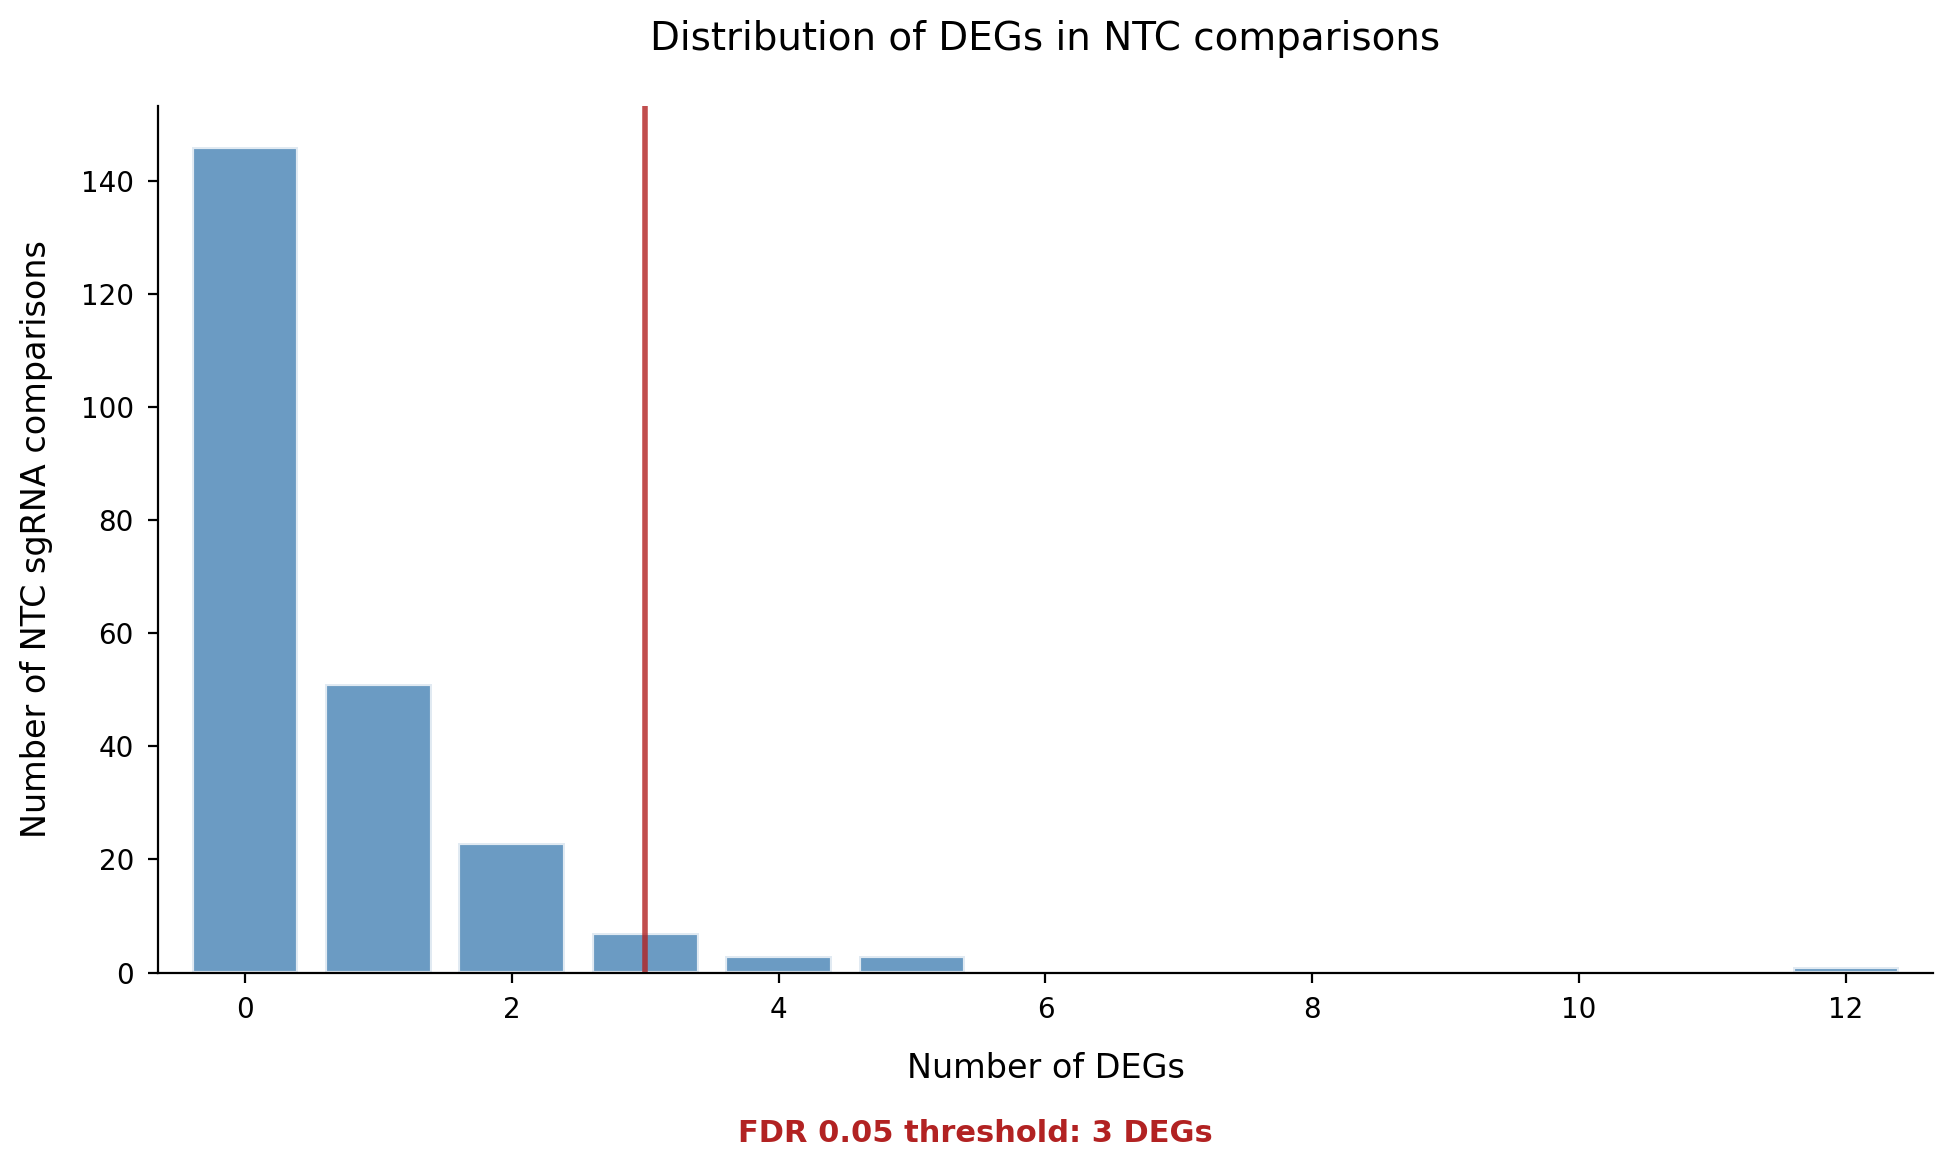

NTC Benchmark Statistics:
  • FDR 0.05 threshold: 3 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 0.7
  • Median DEGs per comparison: 0.0
  • 95% of comparisons have < 3 DEGs


In [ ]:
test_deg_threshold, test_benchmark_res = \
    report_ntc_benchmarking_results(test_ntc_benchmark_res)

In [ ]:
test_benchmark_res[test_benchmark_res["n_DEGs"] > 3]

n_DEGs
Non-Targeting_398      12
Non-Targeting_226       5
Non-Targeting_506       5
Non-Targeting_844       5
Non-Targeting_351       4
Non-Targeting_482       4
Non-Targeting_418       4

In [ ]:
ntc_gRNA_to_remove = ["Non-Targeting_398", "Non-Targeting_226", "Non-Targeting_506",
                      "Non-Targeting_844", "Non-Targeting_351", "Non-Targeting_482",
                      "Non-Targeting_418"]

In [ ]:
adata_benchmarked = adata[~(adata.obs.gRNA.isin(ntc_gRNA_to_remove))].copy()

In [ ]:
save_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata_benchmarked.write(save_path)

Restart kernel

### 5 chunks

13.5 min for 1 chunk, 75 CPUs

In [2]:
# run_pydeseq2() and handle_warnings
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

# Handle warnings (from PyDESeq2)
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def run_pydeseq2(counts_df: pd.DataFrame, metadata_df: pd.DataFrame,
                 targets: list, n_cpus: int = 20, alpha: float = 0.05,
                 return_dds_object = False, suppress_warnings: bool = False,
                 shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True):
    """
    Perform DE analysis with PyDESeq2 on perturbing gRNA or gene targets.
    Uses parallel processing for DeseqStats.summary().
    """
    # Get targets (PyDESeq2 0.4.12 can't handle underscores)
    targets_hyphenated = [t.replace("_", "-") for t in targets]
    # Run DE analysis
    with handle_warnings(suppress_warnings):
        # Set number of CPUs to use
        dds_inference = DefaultInference(n_cpus=n_cpus)
        ds_inference = DefaultInference(n_cpus=1)
        # Fit dispersions and LFCs
        dds = DeseqDataSet(counts=counts_df, metadata=metadata_df,
                          design_factors="condition",
                          continuous_factors=["n-cells-in-rep"],
                          ref_level=["condition", "NTC"],
                          inference=dds_inference, quiet=False
                          )
        print(f"\nFitting dispersion and LFC parameters with DeseqDataSet.deseq2()")
        dds.deseq2()
        # Helper function for statistical testing
        def run_DeseqStats(target, shrink_lfcs, lfc_shrink_adapt):
            contrast=["condition", target, "NTC"]
            ds = DeseqStats(dds, contrast=contrast, alpha=alpha,
                            inference=ds_inference, quiet=True)
            ds.summary()
            if shrink_lfcs:
                coeff = f"{contrast[0]}_{contrast[1]}_vs_{contrast[2]}"
                ds.lfc_shrink(coeff=coeff, adapt=lfc_shrink_adapt)
            return ds.results_df
        # Perform statistical testing in parallel
        with tqdm_joblib(desc="Running DE statistical testing", total=len(targets_hyphenated)):
            ds_results = Parallel(n_jobs=n_cpus)(
                delayed(run_DeseqStats)(target, shrink_lfcs, lfc_shrink_adapt)
                        for target in targets_hyphenated)
        # Return results
        de_results_dict = {targets[i]: ds_results[i] for i in range(len(targets))}
        if return_dds_object:
            return de_results_dict, dds
        else:
            return de_results_dict

In [3]:
def create_pseudobulk_dataset(adata: ad.AnnData, target_type: str = "gRNA",
                              ntc_benchmarking: bool = False,
                              layer: str = "counts",
                              min_cells_for_3_reps: int = 60,
                              approx_ntc_rep_size: int = 50,
                              random_state: int = 42,
                              ntc_target_delimiter: str = "NTC",
                              ntc_gRNA_delimiter: str = "Non-Targeting"):
    """
    Generate pseudobulk representation of adata with pseudoreplicates for 
    each gRNA or gene target (based on target_type).
    """
    # Error handling
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("Error: target_type must be 'gRNA' or 'gene_target'")
    if (ntc_benchmarking is True) & (target_type != "gRNA"):
        raise ValueError("Error: target_type must be 'gRNA' for NTC benchmarking")

    # Get targets
    targets = adata.obs[target_type].unique().tolist()
    # RNG objects for creating pseudoreplicates
    de_rng = np.random.default_rng(random_state)
    target_rngs = de_rng.spawn(len(targets))

    # Data structures for counts_df and metadata_df
    counts_arrays, counts_df_index = list(), list()
    metadata_condition, metadata_n_cells = list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Generate pseudoreplicates
    for target, rng in zip(targets, target_rngs):
        # Get target data
        target_indices = np.where(adata.obs[target_type] == target)[0]
        target_data = data_matrix[target_indices]
        
        # Calculate pseudoreplicate size
        n_target_cells = target_data.shape[0]
        if target_type == "gRNA": # gRNA targets
            if n_target_cells < min_cells_for_3_reps:
                rep1_size = n_target_cells // 2
                rep2_size = n_target_cells - rep1_size
                rep_sizes = [rep1_size, rep2_size]
            else:
                rep1_size = n_target_cells // 3
                rep2_size = (n_target_cells - rep1_size) // 2
                rep3_size = n_target_cells - rep1_size - rep2_size
                rep_sizes = [rep1_size, rep2_size, rep3_size]
        else: # Gene targets
            # Create NTC reps of about approx_ntc_rep_size as evenly as possible
            if target == ntc_target_delimiter:
                n_reps = round(n_target_cells / approx_ntc_rep_size)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)
            else:
                if n_target_cells < min_cells_for_3_reps:
                    rep1_size = n_target_cells // 2
                    rep2_size = n_target_cells - rep1_size
                    rep_sizes = [rep1_size, rep2_size]
                else:
                    rep1_size = n_target_cells // 3
                    rep2_size = (n_target_cells - rep1_size) // 2
                    rep3_size = n_target_cells - rep1_size - rep2_size
                    rep_sizes = [rep1_size, rep2_size, rep3_size]

        # Sample target indices for each rep
        target_cell_indices = np.arange(n_target_cells)
        rng.shuffle(target_cell_indices)
        rep_sizes_array = np.array(rep_sizes)
        rep_splits = np.cumsum(rep_sizes_array)[:-1]
        rep_indices = np.split(target_cell_indices, rep_splits)
        
        # Update pseudobulk counts
        n_reps = len(rep_sizes)
        target_counts = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
        for i in range(n_reps):
            target_counts[i] = \
                np.sum(target_data[rep_indices[i]], axis=0).astype(np.int64)
        counts_arrays.append(target_counts)
        target_hyphenated = target.replace("_", "-")
        rep_names = [f"{target_hyphenated}-rep{i+1}" for i in range(n_reps)]
        counts_df_index += rep_names
        
        # Update metadata
        metadata_n_cells += rep_sizes
        if ntc_gRNA_delimiter in target:
            metadata_condition += (["NTC"]*n_reps)
        else:
            metadata_condition += ([target_hyphenated]*n_reps)
            
    # Create counts DF
    counts_arr = np.concatenate(tuple(arr for arr in counts_arrays), axis=0)
    counts_df = pd.DataFrame(
        counts_arr,
        index=counts_df_index,
        columns=adata.var_names
    )

    # Create metadata DF
    metadata_dict = {"sample": counts_df_index,
                    "condition": metadata_condition,
                    "n-cells-in-rep": metadata_n_cells}
    metadata_df = pd.DataFrame.from_dict(metadata_dict)
    metadata_df = metadata_df.set_index("sample").rename_axis(None)
    return counts_df, metadata_df

In [4]:
def run_dataset_DE_chunks_2_3_reps(
        adata: ad.AnnData, target_type: str = "gRNA",
        max_chunk_size: int = 1100, layer: str = "counts",
        min_cells_for_3_reps: int = 60,
        approx_ntc_rep_size: int = 50,
        random_state: int = 42,
        ntc_target_delimiter: str = "NTC",
        ntc_gRNA_delimiter: str = "Non-Targeting",
        n_cpus: int = 20, alpha: float = 0.05,
        return_dds_objects: bool = False,
        shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
        suppress_warnings: bool = False, debug: bool = False,
        counts_df=None, metadata_df=None):
    """
    Run pseudobulk DE on perturbing gRNA or gene targets (based on target_type).
    Create pseudobulk dataset and break into chunks that each include all NTC reps
    and a subset of perturbing gRNAs/gene targets. Run DE on each chunk.
    """
    # Create pseudobulk dataset
    if (counts_df is None) or (metadata_df is None):
        print("Generating pseudobulk representation of dataset")
        counts_df, metadata_df = \
            create_pseudobulk_dataset(
                adata, target_type=target_type, layer=layer,
                approx_ntc_rep_size = approx_ntc_rep_size,
                min_cells_for_3_reps=min_cells_for_3_reps,
                random_state=random_state,
                ntc_target_delimiter=ntc_target_delimiter,
                ntc_gRNA_delimiter=ntc_gRNA_delimiter
                )
    
    # Get number of chunks
    n_target_samples = len(metadata_df[metadata_df["condition"] != "NTC"])
    n_ntc_samples = len(metadata_df[metadata_df["condition"] == "NTC"])
    n_chunks = round(n_target_samples / (max_chunk_size - n_ntc_samples))
    print(f"{n_target_samples} perturbation samples, {n_ntc_samples} NTC samples, "
        f"{n_chunks} chunks")

    # Get number of perturbations per chunk
    target_counts_df = \
        pd.DataFrame(adata[adata.obs.perturbed == "True"].obs[target_type].value_counts())
    two_reps_mask = target_counts_df["count"] < min_cells_for_3_reps
    three_reps_mask = target_counts_df["count"] >= min_cells_for_3_reps
    n_targets_2_3_reps = \
        [len(target_counts_df[two_reps_mask]), 
         len(target_counts_df[three_reps_mask])] # number of targets for 2, 3 reps
    print(f"{n_targets_2_3_reps[0]} targets with 2 reps, "
          f"{n_targets_2_3_reps[1]} targets with 3 reps")
    n_chunk_targets_2_3_reps = list() # array of size 2 x n_chunks
    for i in range(2):
        n_targets = n_targets_2_3_reps[i]
        base_size = n_targets // n_chunks
        remainder = n_targets % n_chunks
        n_targets_per_chunk = [base_size+1]*remainder + [base_size]*(n_chunks-remainder)
        n_chunk_targets_2_3_reps.append(n_targets_per_chunk) 
    print(f"Number of targets with 2 reps per chunk: {n_chunk_targets_2_3_reps[0]}")
    print(f"Number of targets with 3 reps per chunk: {n_chunk_targets_2_3_reps[1]}")

    # Determine perturbations per chunk
    rng = np.random.default_rng(random_state)
    targets_2_3_reps = [target_counts_df[two_reps_mask].index.tolist(),
                        target_counts_df[three_reps_mask].index.tolist()]
    chunk_indices_2_3_reps = list() # array of size 2 x n_chunks
    for i in range(2):
        n_targets_per_chunk = n_chunk_targets_2_3_reps[i] # vector of size n_chunks
        target_indices = np.arange(n_targets_2_3_reps[i]) # vector of size n_targets_per_chunk
        rng.shuffle(target_indices)
        chunk_splits = np.cumsum(np.array(n_targets_per_chunk))[:-1]
        chunk_indices = np.split(target_indices, chunk_splits)
        chunk_indices_2_3_reps.append(chunk_indices)

    # Divide pseudobulk dataset into chunks
    chunk_counts_dfs, chunk_meta_dfs = list(), list()
    all_chunk_targets = list() # array of size n_chunks x n_targets_per_chunk
    for i in range(n_chunks):
        chunk_targets = list()
        # Add 2-rep targets and 3-rep targets to chunk target list
        for j in range(2):
            rep_size_chunk_indices = chunk_indices_2_3_reps[j]
            rep_size_targets = targets_2_3_reps[j]
            rep_chunk_targets = [rep_size_targets[k] for k in rep_size_chunk_indices[i]]
            chunk_targets += rep_chunk_targets
        # Create counts and metadata DFs
        chunk_targets_hyphenated = [t.replace("_", "-") for t in chunk_targets]
        chunk_meta_df = \
            metadata_df.loc[(metadata_df["condition"].isin(chunk_targets_hyphenated))
                            | (metadata_df["condition"] == "NTC")]
        chunk_samples = chunk_meta_df.index.tolist()
        chunk_counts_df = counts_df.loc[counts_df.index.isin(chunk_samples)]
        chunk_counts_dfs.append(chunk_counts_df)
        chunk_meta_dfs.append(chunk_meta_df)
        all_chunk_targets.append(chunk_targets)

    # Run DE analysis on each chunk pseudobulk dataset
    de_results_dict = dict()
    n_chunks_to_run = 1 if debug else n_chunks
    if return_dds_objects:
        dds_objects = list()
    for i in range(n_chunks_to_run):
        print(f"Running DE analysis on chunk {i+1} of {n_chunks}")
        chunk_results = \
            run_pydeseq2(chunk_counts_dfs[i], 
                         chunk_meta_dfs[i],
                         targets=all_chunk_targets[i],
                         n_cpus=n_cpus, alpha=alpha,
                         return_dds_object=return_dds_objects,
                         shrink_lfcs=shrink_lfcs,
                         lfc_shrink_adapt=lfc_shrink_adapt,
                         suppress_warnings=suppress_warnings)
        if return_dds_objects:
            de_results_dict.update(chunk_results[0])
            dds_objects.append(chunk_results[1])
        else:
            de_results_dict.update(chunk_results)
    if return_dds_objects:
        return de_results_dict, dds_objects
    else:
        return de_results_dict

In [5]:
def build_DE_df(results_dict):
    df_list = list()
    for target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [6]:
file_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(file_path)
adata

AnnData object with n_obs × n_vars = 101538 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [ ]:
# 1 hr for all 5 chunks
de_results_2_3_reps, dds_objects_2_3_reps = \
    run_dataset_DE_chunks_2_3_reps(adata, max_chunk_size=1100, n_cpus=75,
                                   min_cells_for_3_reps=60,
                                   return_dds_objects=True)

Generating pseudobulk representation of dataset
2773 perturbing gRNA samples, 552 NTC gRNA samples, 5 chunks
185 targets with 2 reps, 801 targets with 3 reps
Number of targets with 2 reps per chunk: [37, 37, 37, 37, 37]
Number of targets with 3 reps per chunk: [161, 160, 160, 160, 160]
Running DE analysis on chunk 1 of 5

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.38 seconds.

Fitting dispersions...
... done in 311.76 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 29.98 seconds.

Fitting LFCs...
... done in 28.65 seconds.

Calculating cook's distance...
... done in 0.96 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/198 [00:00<?, ?it/s]

Running DE analysis on chunk 2 of 5

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.39 seconds.

Fitting dispersions...
... done in 245.20 seconds.

Fitting dispersion trend curve...
... done in 0.29 seconds.

Fitting MAP dispersions...
... done in 21.60 seconds.

Fitting LFCs...
... done in 27.34 seconds.

Calculating cook's distance...
... done in 0.90 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/197 [00:00<?, ?it/s]

Running DE analysis on chunk 3 of 5

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.39 seconds.

Fitting dispersions...
... done in 238.91 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 32.24 seconds.

Fitting LFCs...
... done in 28.37 seconds.

Calculating cook's distance...
... done in 0.95 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/197 [00:00<?, ?it/s]

Running DE analysis on chunk 4 of 5

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.39 seconds.

Fitting dispersions...
... done in 244.20 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 26.89 seconds.

Fitting LFCs...
... done in 27.35 seconds.

Calculating cook's distance...
... done in 0.92 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/197 [00:00<?, ?it/s]

Running DE analysis on chunk 5 of 5

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.39 seconds.

Fitting dispersions...
... done in 224.53 seconds.

Fitting dispersion trend curve...
... done in 0.29 seconds.

Fitting MAP dispersions...
... done in 32.06 seconds.

Fitting LFCs...
... done in 27.90 seconds.

Calculating cook's distance...
... done in 0.93 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/197 [00:00<?, ?it/s]

In [7]:
import matplotlib.pyplot as plt
import math

def plot_dispersions_chunks(dds_objects, title="DE Dispersion Plots", log=True):
    n_rows = math.ceil(len(dds_objects)/2)
    _, axes = plt.subplots(n_rows, 2, figsize=(8,4*n_rows))
    for i, ax in enumerate(axes.flat):
        if i < len(dds_objects):
            dds = dds_objects[i]
            disps = [
                dds.varm["genewise_dispersions"],
                dds.varm["dispersions"],
                dds.varm["fitted_dispersions"],
            ]
            legend_labels = ["Estimated", "Final", "Fitted"]
            colors = "kbr"
            if log is True:
                ax.set_yscale("log")
                ax.set_xscale("log")
            ax.set_adjustable("datalim")

            for disp, color in list(zip(disps, colors, strict=False)):
                ax.scatter(x=dds.varm["_normed_means"], y=disp,
                        s=0.6, c=color, alpha=0.5)
            
            ax.legend(legend_labels, loc="best")
            ax.set_xlabel("mean of normalized counts")
            ax.set_ylabel("dispersion")
            ax.set_title(f"Chunk {i+1} Dispersions")
        else:
            ax.axis("off")
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.show()

In [6]:
# plot_dispersions_chunks(dds_objects_2_3_reps, 
#                         "DE Dispersion Plots (5 chunks, 2-3 reps per gRNA)")

In [14]:
de_results_df_2_3_reps = build_DE_df(de_results_2_3_reps)
de_results_df_2_3_reps.head()

NR2C2_3_baseMean  NR2C2_3_log2FoldChange  NR2C2_3_lfcSE  \
A1BG               2.742657               -0.010841       0.735985   
A1BG-AS1           0.421032               -1.045400       2.406611   
A2M                0.347912                1.692420       1.161088   
A2ML1              1.252989                0.524628       1.039627   
A2ML1-AS1          3.643710               -0.326498       0.730356   

           NR2C2_3_stat  NR2C2_3_pvalue  NR2C2_3_padj  ZNF16_1_baseMean  \
A1BG          -0.014730        0.988248      0.999358          2.742657   
A1BG-AS1      -0.434387        0.664008      0.996475          0.421032   
A2M            1.457615        0.144947      0.996475          0.347912   
A2ML1          0.504631        0.613818      0.996475          1.252989   
A2ML1-AS1     -0.447040        0.654846      0.996475          3.643710   

           ZNF16_1_log2FoldChange  ZNF16_1_lfcSE  ZNF16_1_stat  ...  \
A1BG                     0.496039       0.526058      0.942935  ...   
A1BG-AS1                 0.229896       1.483032      0.155017  ...   
A2M                      1.456361       1.157547      1.258145  ...   
A2ML1                   -0.352571       1.033394     -0.341177  ...   
A2ML1-AS1                1.039646       0.385293      2.698326  ...   

           STAT1_2_lfcSE  STAT1_2_stat  STAT1_2_pvalue  STAT1_2_padj  \
A1BG            0.731656     -2.080897        0.037443      0.999948   
A1BG-AS1        1.079225      0.487205        0.626113      0.999948   
A2M             1.537242     -0.163907        0.869804      0.999948   
A2ML1           0.616768     -0.246230        0.805504      0.999948   
A2ML1-AS1       0.352756      0.860081        0.389744      0.999948   

           ZFP41_2_baseMean  ZFP41_2_log2FoldChange  ZFP41_2_lfcSE  \
A1BG               2.722370               -0.612937       0.568726   
A1BG-AS1           0.404021                1.961533       1.322062   
A2M                0.370607                1.210000       1.602031   
A2ML1              1.254465               -1.488446       0.724537   
A2ML1-AS1          3.642391                0.065013       0.445665   

           ZFP41_2_stat  ZFP41_2_pvalue  ZFP41_2_padj  
A1BG          -1.077738        0.281151      0.998639  
A1BG-AS1       1.483692        0.137891      0.998639  
A2M            0.755291        0.450074      0.998639  
A2ML1         -2.054341        0.039943      0.998639  
A2ML1-AS1      0.145879        0.884017      0.998639  

[5 rows x 5916 columns]

In [ ]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_5chunks_2-3reps.pkl"
de_results_df_2_3_reps.to_pickle(filepath_pkl)

### 4 chunks

In [ ]:
# run_pydeseq2() and handle_warnings
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

# Handle warnings (from PyDESeq2)
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def run_pydeseq2(counts_df: pd.DataFrame, metadata_df: pd.DataFrame,
                 targets: list, n_cpus: int = 20, alpha: float = 0.05,
                 return_dds_object = False, suppress_warnings: bool = False,
                 shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True):
    """
    Perform DE analysis with PyDESeq2 on perturbing gRNA or gene targets.
    Uses parallel processing for DeseqStats.summary().
    """
    # Get targets (PyDESeq2 0.4.12 can't handle underscores)
    targets_hyphenated = [t.replace("_", "-") for t in targets]
    # Run DE analysis
    with handle_warnings(suppress_warnings):
        # Set number of CPUs to use
        dds_inference = DefaultInference(n_cpus=n_cpus)
        ds_inference = DefaultInference(n_cpus=1)
        # Fit dispersions and LFCs
        dds = DeseqDataSet(counts=counts_df, metadata=metadata_df,
                          design_factors="condition",
                          continuous_factors=["n-cells-in-rep"],
                          ref_level=["condition", "NTC"],
                          inference=dds_inference, quiet=False
                          )
        print(f"\nFitting dispersion and LFC parameters with DeseqDataSet.deseq2()")
        dds.deseq2()
        # Helper function for statistical testing
        def run_DeseqStats(target, shrink_lfcs, lfc_shrink_adapt):
            contrast=["condition", target, "NTC"]
            ds = DeseqStats(dds, contrast=contrast, alpha=alpha,
                            inference=ds_inference, quiet=True)
            ds.summary()
            if shrink_lfcs:
                coeff = f"{contrast[0]}_{contrast[1]}_vs_{contrast[2]}"
                ds.lfc_shrink(coeff=coeff, adapt=lfc_shrink_adapt)
            return ds.results_df
        # Perform statistical testing in parallel
        with tqdm_joblib(desc="Running DE statistical testing", total=len(targets_hyphenated)):
            ds_results = Parallel(n_jobs=n_cpus)(
                delayed(run_DeseqStats)(target, shrink_lfcs, lfc_shrink_adapt)
                        for target in targets_hyphenated)
        # Return results
        de_results_dict = {targets[i]: ds_results[i] for i in range(len(targets))}
        if return_dds_object:
            return de_results_dict, dds
        else:
            return de_results_dict

In [ ]:
def create_pseudobulk_dataset(adata: ad.AnnData, target_type: str = "gRNA",
                              ntc_benchmarking: bool = False,
                              layer: str = "counts",
                              min_cells_for_3_reps: int = 60,
                              approx_ntc_rep_size: int = 50,
                              random_state: int = 42,
                              ntc_target_delimiter: str = "NTC",
                              ntc_gRNA_delimiter: str = "Non-Targeting"):
    """
    Generate pseudobulk representation of adata with pseudoreplicates for 
    each gRNA or gene target (based on target_type).
    """
    # Error handling
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("Error: target_type must be 'gRNA' or 'gene_target'")
    if (ntc_benchmarking is True) & (target_type != "gRNA"):
        raise ValueError("Error: target_type must be 'gRNA' for NTC benchmarking")

    # Get targets
    targets = adata.obs[target_type].unique().tolist()
    # RNG objects for creating pseudoreplicates
    de_rng = np.random.default_rng(random_state)
    target_rngs = de_rng.spawn(len(targets))

    # Data structures for counts_df and metadata_df
    counts_arrays, counts_df_index = list(), list()
    metadata_condition, metadata_n_cells = list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Generate pseudoreplicates
    for target, rng in zip(targets, target_rngs):
        # Get target data
        target_indices = np.where(adata.obs[target_type] == target)[0]
        target_data = data_matrix[target_indices]
        
        # Calculate pseudoreplicate size
        n_target_cells = target_data.shape[0]
        if target_type == "gRNA": # gRNA targets
            if n_target_cells < min_cells_for_3_reps:
                rep1_size = n_target_cells // 2
                rep2_size = n_target_cells - rep1_size
                rep_sizes = [rep1_size, rep2_size]
            else:
                rep1_size = n_target_cells // 3
                rep2_size = (n_target_cells - rep1_size) // 2
                rep3_size = n_target_cells - rep1_size - rep2_size
                rep_sizes = [rep1_size, rep2_size, rep3_size]
        else: # Gene targets
            # Create NTC reps of about approx_ntc_rep_size as evenly as possible
            if target == ntc_target_delimiter:
                n_reps = round(n_target_cells / approx_ntc_rep_size)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)
            else:
                if n_target_cells < min_cells_for_3_reps:
                    rep1_size = n_target_cells // 2
                    rep2_size = n_target_cells - rep1_size
                    rep_sizes = [rep1_size, rep2_size]
                else:
                    rep1_size = n_target_cells // 3
                    rep2_size = (n_target_cells - rep1_size) // 2
                    rep3_size = n_target_cells - rep1_size - rep2_size
                    rep_sizes = [rep1_size, rep2_size, rep3_size]

        # Sample target indices for each rep
        target_cell_indices = np.arange(n_target_cells)
        rng.shuffle(target_cell_indices)
        rep_sizes_array = np.array(rep_sizes)
        rep_splits = np.cumsum(rep_sizes_array)[:-1]
        rep_indices = np.split(target_cell_indices, rep_splits)
        
        # Update pseudobulk counts
        n_reps = len(rep_sizes)
        target_counts = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
        for i in range(n_reps):
            target_counts[i] = \
                np.sum(target_data[rep_indices[i]], axis=0).astype(np.int64)
        counts_arrays.append(target_counts)
        target_hyphenated = target.replace("_", "-")
        rep_names = [f"{target_hyphenated}-rep{i+1}" for i in range(n_reps)]
        counts_df_index += rep_names
        
        # Update metadata
        metadata_n_cells += rep_sizes
        if ntc_gRNA_delimiter in target:
            metadata_condition += (["NTC"]*n_reps)
        else:
            metadata_condition += ([target_hyphenated]*n_reps)
            
    # Create counts DF
    counts_arr = np.concatenate(tuple(arr for arr in counts_arrays), axis=0)
    counts_df = pd.DataFrame(
        counts_arr,
        index=counts_df_index,
        columns=adata.var_names
    )

    # Create metadata DF
    metadata_dict = {"sample": counts_df_index,
                    "condition": metadata_condition,
                    "n-cells-in-rep": metadata_n_cells}
    metadata_df = pd.DataFrame.from_dict(metadata_dict)
    metadata_df = metadata_df.set_index("sample").rename_axis(None)
    return counts_df, metadata_df

In [ ]:
def run_dataset_DE_chunks_2_3_reps(
        adata: ad.AnnData, target_type: str = "gRNA",
        max_chunk_size: int = 1100, layer: str = "counts",
        min_cells_for_3_reps: int = 60,
        approx_ntc_rep_size: int = 50,
        random_state: int = 42,
        ntc_target_delimiter: str = "NTC",
        ntc_gRNA_delimiter: str = "Non-Targeting",
        n_cpus: int = 20, alpha: float = 0.05,
        return_dds_objects: bool = False,
        shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
        suppress_warnings: bool = False, debug: bool = False,
        counts_df=None, metadata_df=None):
    """
    Run pseudobulk DE on perturbing gRNA or gene targets (based on target_type).
    Create pseudobulk dataset and break into chunks that each include all NTC reps
    and a subset of perturbing gRNAs/gene targets. Run DE on each chunk.
    """
    # Create pseudobulk dataset
    if (counts_df is None) or (metadata_df is None):
        print("Generating pseudobulk representation of dataset")
        counts_df, metadata_df = \
            create_pseudobulk_dataset(
                adata, target_type=target_type, layer=layer,
                approx_ntc_rep_size = approx_ntc_rep_size,
                min_cells_for_3_reps=min_cells_for_3_reps,
                random_state=random_state,
                ntc_target_delimiter=ntc_target_delimiter,
                ntc_gRNA_delimiter=ntc_gRNA_delimiter
                )
    
    # Get number of chunks
    n_target_samples = len(metadata_df[metadata_df["condition"] != "NTC"])
    n_ntc_samples = len(metadata_df[metadata_df["condition"] == "NTC"])
    n_chunks = round(n_target_samples / (max_chunk_size - n_ntc_samples))
    print(f"{n_target_samples} perturbation samples, {n_ntc_samples} NTC samples, "
        f"{n_chunks} chunks")

    # Get number of perturbations per chunk
    target_counts_df = \
        pd.DataFrame(adata[adata.obs.perturbed == "True"].obs[target_type].value_counts())
    two_reps_mask = target_counts_df["count"] < min_cells_for_3_reps
    three_reps_mask = target_counts_df["count"] >= min_cells_for_3_reps
    n_targets_2_3_reps = \
        [len(target_counts_df[two_reps_mask]), 
         len(target_counts_df[three_reps_mask])] # number of targets for 2, 3 reps
    print(f"{n_targets_2_3_reps[0]} targets with 2 reps, "
          f"{n_targets_2_3_reps[1]} targets with 3 reps")
    n_chunk_targets_2_3_reps = list() # array of size 2 x n_chunks
    for i in range(2):
        n_targets = n_targets_2_3_reps[i]
        base_size = n_targets // n_chunks
        remainder = n_targets % n_chunks
        n_targets_per_chunk = [base_size+1]*remainder + [base_size]*(n_chunks-remainder)
        n_chunk_targets_2_3_reps.append(n_targets_per_chunk) 
    print(f"Number of targets with 2 reps per chunk: {n_chunk_targets_2_3_reps[0]}")
    print(f"Number of targets with 3 reps per chunk: {n_chunk_targets_2_3_reps[1]}")

    # Determine perturbations per chunk
    rng = np.random.default_rng(random_state)
    targets_2_3_reps = [target_counts_df[two_reps_mask].index.tolist(),
                        target_counts_df[three_reps_mask].index.tolist()]
    chunk_indices_2_3_reps = list() # array of size 2 x n_chunks
    for i in range(2):
        n_targets_per_chunk = n_chunk_targets_2_3_reps[i] # vector of size n_chunks
        target_indices = np.arange(n_targets_2_3_reps[i]) # vector of size n_targets_per_chunk
        rng.shuffle(target_indices)
        chunk_splits = np.cumsum(np.array(n_targets_per_chunk))[:-1]
        chunk_indices = np.split(target_indices, chunk_splits)
        chunk_indices_2_3_reps.append(chunk_indices)

    # Divide pseudobulk dataset into chunks
    chunk_counts_dfs, chunk_meta_dfs = list(), list()
    all_chunk_targets = list() # array of size n_chunks x n_targets_per_chunk
    for i in range(n_chunks):
        chunk_targets = list()
        # Add 2-rep targets and 3-rep targets to chunk target list
        for j in range(2):
            rep_size_chunk_indices = chunk_indices_2_3_reps[j]
            rep_size_targets = targets_2_3_reps[j]
            rep_chunk_targets = [rep_size_targets[k] for k in rep_size_chunk_indices[i]]
            chunk_targets += rep_chunk_targets
        # Create counts and metadata DFs
        chunk_targets_hyphenated = [t.replace("_", "-") for t in chunk_targets]
        chunk_meta_df = \
            metadata_df.loc[(metadata_df["condition"].isin(chunk_targets_hyphenated))
                            | (metadata_df["condition"] == "NTC")]
        chunk_samples = chunk_meta_df.index.tolist()
        chunk_counts_df = counts_df.loc[counts_df.index.isin(chunk_samples)]
        chunk_counts_dfs.append(chunk_counts_df)
        chunk_meta_dfs.append(chunk_meta_df)
        all_chunk_targets.append(chunk_targets)

    # Run DE analysis on each chunk pseudobulk dataset
    de_results_dict = dict()
    n_chunks_to_run = 1 if debug else n_chunks
    if return_dds_objects:
        dds_objects = list()
    for i in range(n_chunks_to_run):
        print(f"Running DE analysis on chunk {i+1} of {n_chunks}")
        chunk_results = \
            run_pydeseq2(chunk_counts_dfs[i], 
                         chunk_meta_dfs[i],
                         targets=all_chunk_targets[i],
                         n_cpus=n_cpus, alpha=alpha,
                         return_dds_object=return_dds_objects,
                         shrink_lfcs=shrink_lfcs,
                         lfc_shrink_adapt=lfc_shrink_adapt,
                         suppress_warnings=suppress_warnings)
        if return_dds_objects:
            de_results_dict.update(chunk_results[0])
            dds_objects.append(chunk_results[1])
        else:
            de_results_dict.update(chunk_results)
    if return_dds_objects:
        return de_results_dict, dds_objects
    else:
        return de_results_dict

In [ ]:
def build_DE_df(results_dict):
    df_list = list()
    for target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [ ]:
file_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(file_path)
adata

AnnData object with n_obs × n_vars = 101538 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [9]:
de_results_2_3_reps, dds_objects_2_3_reps = \
    run_dataset_DE_chunks_2_3_reps(adata, max_chunk_size=1200, n_cpus=75,
                                   min_cells_for_3_reps=60,
                                   return_dds_objects=True)

Generating pseudobulk representation of dataset
2773 perturbation samples, 552 NTC samples, 4 chunks
185 targets with 2 reps, 801 targets with 3 reps
Number of targets with 2 reps per chunk: [47, 46, 46, 46]
Number of targets with 3 reps per chunk: [201, 200, 200, 200]
Running DE analysis on chunk 1 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.44 seconds.

Fitting dispersions...
... done in 412.59 seconds.

Fitting dispersion trend curve...
... done in 0.29 seconds.

Fitting MAP dispersions...
... done in 55.38 seconds.

Fitting LFCs...
... done in 46.49 seconds.

Calculating cook's distance...
... done in 1.13 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/248 [00:00<?, ?it/s]

Running DE analysis on chunk 2 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.43 seconds.

Fitting dispersions...
... done in 384.44 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 53.34 seconds.

Fitting LFCs...
... done in 46.44 seconds.

Calculating cook's distance...
... done in 1.08 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/246 [00:00<?, ?it/s]

Running DE analysis on chunk 3 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.43 seconds.

Fitting dispersions...
... done in 447.13 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 60.14 seconds.

Fitting LFCs...
... done in 45.92 seconds.

Calculating cook's distance...
... done in 1.10 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/246 [00:00<?, ?it/s]

Running DE analysis on chunk 4 of 4

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.44 seconds.

Fitting dispersions...
... done in 396.98 seconds.

Fitting dispersion trend curve...
... done in 0.29 seconds.

Fitting MAP dispersions...
... done in 54.36 seconds.

Fitting LFCs...
... done in 45.09 seconds.

Calculating cook's distance...
... done in 1.15 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/246 [00:00<?, ?it/s]

In [10]:
import matplotlib.pyplot as plt
import math

def plot_dispersions_chunks(dds_objects, title="DE Dispersion Plots", log=True):
    n_rows = math.ceil(len(dds_objects)/2)
    _, axes = plt.subplots(n_rows, 2, figsize=(8,4*n_rows))
    for i, ax in enumerate(axes.flat):
        if i < len(dds_objects):
            dds = dds_objects[i]
            disps = [
                dds.varm["genewise_dispersions"],
                dds.varm["dispersions"],
                dds.varm["fitted_dispersions"],
            ]
            legend_labels = ["Estimated", "Final", "Fitted"]
            colors = "kbr"
            if log is True:
                ax.set_yscale("log")
                ax.set_xscale("log")
            ax.set_adjustable("datalim")

            for disp, color in list(zip(disps, colors, strict=False)):
                ax.scatter(x=dds.varm["_normed_means"], y=disp,
                        s=0.6, c=color, alpha=0.5)
            
            ax.legend(legend_labels, loc="best")
            ax.set_xlabel("mean of normalized counts")
            ax.set_ylabel("dispersion")
            ax.set_title(f"Chunk {i+1} Dispersions")
        else:
            ax.axis("off")
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.show()

In [28]:
# plot_dispersions_chunks(dds_objects_2_3_reps, 
#                         "DE Dispersion Plots (4 chunks, 2-3 reps per gRNA)")

In [12]:
de_results_df_2_3_reps = build_DE_df(de_results_2_3_reps)
de_results_df_2_3_reps.head()

NR2C2_3_baseMean  NR2C2_3_log2FoldChange  NR2C2_3_lfcSE  \
A1BG               2.767904               -0.008186       0.733820   
A1BG-AS1           0.430147               -1.039813       2.404481   
A2M                0.355277                1.683851       1.133593   
A2ML1              1.277306                0.527925       1.038330   
A2ML1-AS1          3.726706               -0.324039       0.729280   

           NR2C2_3_stat  NR2C2_3_pvalue  NR2C2_3_padj  ZNF16_1_baseMean  \
A1BG          -0.011156        0.991099      0.999249          2.767904   
A1BG-AS1      -0.432448        0.665416      0.996406          0.430147   
A2M            1.485411        0.137435      0.996406          0.355277   
A2ML1          0.508437        0.611147      0.996406          1.277306   
A2ML1-AS1     -0.444327        0.656806      0.996406          3.726706   

           ZNF16_1_log2FoldChange  ZNF16_1_lfcSE  ZNF16_1_stat  ...  \
A1BG                     0.495068       0.523166      0.946294  ...   
A1BG-AS1                 0.227976       1.479601      0.154079  ...   
A2M                      1.461070       1.128424      1.294789  ...   
A2ML1                   -0.353431       1.032227     -0.342397  ...   
A2ML1-AS1                1.038687       0.383302      2.709841  ...   

           STAT1_2_lfcSE  STAT1_2_stat  STAT1_2_pvalue  STAT1_2_padj  \
A1BG            0.730884     -2.086347        0.036947      0.999984   
A1BG-AS1        1.077588      0.489574        0.624435      0.999984   
A2M             1.517727     -0.171558        0.863785      0.999984   
A2ML1           0.613313     -0.244279        0.807014      0.999984   
A2ML1-AS1       0.352053      0.880093        0.378809      0.999984   

           ZFP41_2_baseMean  ZFP41_2_log2FoldChange  ZFP41_2_lfcSE  \
A1BG               2.763857               -0.626842       0.566604   
A1BG-AS1           0.405979                1.964955       1.319060   
A2M                0.380864                1.169877       1.570516   
A2ML1              1.294691               -1.480809       0.718742   
A2ML1-AS1          3.713038                0.089628       0.444587   

           ZFP41_2_stat  ZFP41_2_pvalue  ZFP41_2_padj  
A1BG          -1.106313        0.268591      0.999608  
A1BG-AS1       1.489664        0.136313      0.999608  
A2M            0.744900        0.456332      0.999608  
A2ML1         -2.060278        0.039372      0.999608  
A2ML1-AS1      0.201599        0.840230      0.999608  

[5 rows x 5916 columns]

In [13]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_4chunks_2-3reps.pkl"
de_results_df_2_3_reps.to_pickle(filepath_pkl)

### 3 chunks

In [2]:
# run_pydeseq2() and handle_warnings
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

# Handle warnings (from PyDESeq2)
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def run_pydeseq2(counts_df: pd.DataFrame, metadata_df: pd.DataFrame,
                 targets: list, n_cpus: int = 20, alpha: float = 0.05,
                 return_dds_object = False, suppress_warnings: bool = False,
                 shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True):
    """
    Perform DE analysis with PyDESeq2 on perturbing gRNA or gene targets.
    Uses parallel processing for DeseqStats.summary().
    """
    # Get targets (PyDESeq2 0.4.12 can't handle underscores)
    targets_hyphenated = [t.replace("_", "-") for t in targets]
    # Run DE analysis
    with handle_warnings(suppress_warnings):
        # Set number of CPUs to use
        dds_inference = DefaultInference(n_cpus=n_cpus)
        ds_inference = DefaultInference(n_cpus=1)
        # Fit dispersions and LFCs
        dds = DeseqDataSet(counts=counts_df, metadata=metadata_df,
                          design_factors="condition",
                          continuous_factors=["n-cells-in-rep"],
                          ref_level=["condition", "NTC"],
                          inference=dds_inference, quiet=False
                          )
        print(f"\nFitting dispersion and LFC parameters with DeseqDataSet.deseq2()")
        dds.deseq2()
        # Helper function for statistical testing
        def run_DeseqStats(target, shrink_lfcs, lfc_shrink_adapt):
            contrast=["condition", target, "NTC"]
            ds = DeseqStats(dds, contrast=contrast, alpha=alpha,
                            inference=ds_inference, quiet=True)
            ds.summary()
            if shrink_lfcs:
                coeff = f"{contrast[0]}_{contrast[1]}_vs_{contrast[2]}"
                ds.lfc_shrink(coeff=coeff, adapt=lfc_shrink_adapt)
            return ds.results_df
        # Perform statistical testing in parallel
        with tqdm_joblib(desc="Running DE statistical testing", total=len(targets_hyphenated)):
            ds_results = Parallel(n_jobs=n_cpus)(
                delayed(run_DeseqStats)(target, shrink_lfcs, lfc_shrink_adapt)
                        for target in targets_hyphenated)
        # Return results
        de_results_dict = {targets[i]: ds_results[i] for i in range(len(targets))}
        if return_dds_object:
            return de_results_dict, dds
        else:
            return de_results_dict

In [3]:
def create_pseudobulk_dataset(adata: ad.AnnData, target_type: str = "gRNA",
                              ntc_benchmarking: bool = False,
                              layer: str = "counts",
                              min_cells_for_3_reps: int = 60,
                              approx_ntc_rep_size: int = 50,
                              random_state: int = 42,
                              ntc_target_delimiter: str = "NTC",
                              ntc_gRNA_delimiter: str = "Non-Targeting"):
    """
    Generate pseudobulk representation of adata with pseudoreplicates for 
    each gRNA or gene target (based on target_type).
    """
    # Error handling
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("Error: target_type must be 'gRNA' or 'gene_target'")
    if (ntc_benchmarking is True) & (target_type != "gRNA"):
        raise ValueError("Error: target_type must be 'gRNA' for NTC benchmarking")

    # Get targets
    targets = adata.obs[target_type].unique().tolist()
    # RNG objects for creating pseudoreplicates
    de_rng = np.random.default_rng(random_state)
    target_rngs = de_rng.spawn(len(targets))

    # Data structures for counts_df and metadata_df
    counts_arrays, counts_df_index = list(), list()
    metadata_condition, metadata_n_cells = list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Generate pseudoreplicates
    for target, rng in zip(targets, target_rngs):
        # Get target data
        target_indices = np.where(adata.obs[target_type] == target)[0]
        target_data = data_matrix[target_indices]
        
        # Calculate pseudoreplicate size
        n_target_cells = target_data.shape[0]
        if target_type == "gRNA": # gRNA targets
            if n_target_cells < min_cells_for_3_reps:
                rep1_size = n_target_cells // 2
                rep2_size = n_target_cells - rep1_size
                rep_sizes = [rep1_size, rep2_size]
            else:
                rep1_size = n_target_cells // 3
                rep2_size = (n_target_cells - rep1_size) // 2
                rep3_size = n_target_cells - rep1_size - rep2_size
                rep_sizes = [rep1_size, rep2_size, rep3_size]
        else: # Gene targets
            # Create NTC reps of about approx_ntc_rep_size as evenly as possible
            if target == ntc_target_delimiter:
                n_reps = round(n_target_cells / approx_ntc_rep_size)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)
            else:
                if n_target_cells < min_cells_for_3_reps:
                    rep1_size = n_target_cells // 2
                    rep2_size = n_target_cells - rep1_size
                    rep_sizes = [rep1_size, rep2_size]
                else:
                    rep1_size = n_target_cells // 3
                    rep2_size = (n_target_cells - rep1_size) // 2
                    rep3_size = n_target_cells - rep1_size - rep2_size
                    rep_sizes = [rep1_size, rep2_size, rep3_size]

        # Sample target indices for each rep
        target_cell_indices = np.arange(n_target_cells)
        rng.shuffle(target_cell_indices)
        rep_sizes_array = np.array(rep_sizes)
        rep_splits = np.cumsum(rep_sizes_array)[:-1]
        rep_indices = np.split(target_cell_indices, rep_splits)
        
        # Update pseudobulk counts
        n_reps = len(rep_sizes)
        target_counts = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
        for i in range(n_reps):
            target_counts[i] = \
                np.sum(target_data[rep_indices[i]], axis=0).astype(np.int64)
        counts_arrays.append(target_counts)
        target_hyphenated = target.replace("_", "-")
        rep_names = [f"{target_hyphenated}-rep{i+1}" for i in range(n_reps)]
        counts_df_index += rep_names
        
        # Update metadata
        metadata_n_cells += rep_sizes
        if ntc_gRNA_delimiter in target:
            metadata_condition += (["NTC"]*n_reps)
        else:
            metadata_condition += ([target_hyphenated]*n_reps)
            
    # Create counts DF
    counts_arr = np.concatenate(tuple(arr for arr in counts_arrays), axis=0)
    counts_df = pd.DataFrame(
        counts_arr,
        index=counts_df_index,
        columns=adata.var_names
    )

    # Create metadata DF
    metadata_dict = {"sample": counts_df_index,
                    "condition": metadata_condition,
                    "n-cells-in-rep": metadata_n_cells}
    metadata_df = pd.DataFrame.from_dict(metadata_dict)
    metadata_df = metadata_df.set_index("sample").rename_axis(None)
    return counts_df, metadata_df

In [4]:
def run_dataset_DE_chunks_2_3_reps(
        adata: ad.AnnData, target_type: str = "gRNA",
        max_chunk_size: int = 1100, layer: str = "counts",
        min_cells_for_3_reps: int = 60,
        approx_ntc_rep_size: int = 50,
        random_state: int = 42,
        ntc_target_delimiter: str = "NTC",
        ntc_gRNA_delimiter: str = "Non-Targeting",
        n_cpus: int = 20, alpha: float = 0.05,
        return_dds_objects: bool = False,
        shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
        suppress_warnings: bool = False, debug: bool = False,
        counts_df=None, metadata_df=None):
    """
    Run pseudobulk DE on perturbing gRNA or gene targets (based on target_type).
    Create pseudobulk dataset and break into chunks that each include all NTC reps
    and a subset of perturbing gRNAs/gene targets. Run DE on each chunk.
    """
    # Create pseudobulk dataset
    if (counts_df is None) or (metadata_df is None):
        print("Generating pseudobulk representation of dataset")
        counts_df, metadata_df = \
            create_pseudobulk_dataset(
                adata, target_type=target_type, layer=layer,
                approx_ntc_rep_size = approx_ntc_rep_size,
                min_cells_for_3_reps=min_cells_for_3_reps,
                random_state=random_state,
                ntc_target_delimiter=ntc_target_delimiter,
                ntc_gRNA_delimiter=ntc_gRNA_delimiter
                )
    
    # Get number of chunks
    n_target_samples = len(metadata_df[metadata_df["condition"] != "NTC"])
    n_ntc_samples = len(metadata_df[metadata_df["condition"] == "NTC"])
    n_chunks = round(n_target_samples / (max_chunk_size - n_ntc_samples))
    print(f"{n_target_samples} perturbation samples, {n_ntc_samples} NTC samples, "
        f"{n_chunks} chunks")

    # Get number of perturbations per chunk
    target_counts_df = \
        pd.DataFrame(adata[adata.obs.perturbed == "True"].obs[target_type].value_counts())
    two_reps_mask = target_counts_df["count"] < min_cells_for_3_reps
    three_reps_mask = target_counts_df["count"] >= min_cells_for_3_reps
    n_targets_2_3_reps = \
        [len(target_counts_df[two_reps_mask]), 
         len(target_counts_df[three_reps_mask])] # number of targets for 2, 3 reps
    print(f"{n_targets_2_3_reps[0]} targets with 2 reps, "
          f"{n_targets_2_3_reps[1]} targets with 3 reps")
    n_chunk_targets_2_3_reps = list() # array of size 2 x n_chunks
    for i in range(2):
        n_targets = n_targets_2_3_reps[i]
        base_size = n_targets // n_chunks
        remainder = n_targets % n_chunks
        n_targets_per_chunk = [base_size+1]*remainder + [base_size]*(n_chunks-remainder)
        n_chunk_targets_2_3_reps.append(n_targets_per_chunk) 
    print(f"Number of targets with 2 reps per chunk: {n_chunk_targets_2_3_reps[0]}")
    print(f"Number of targets with 3 reps per chunk: {n_chunk_targets_2_3_reps[1]}")

    # Determine perturbations per chunk
    rng = np.random.default_rng(random_state)
    targets_2_3_reps = [target_counts_df[two_reps_mask].index.tolist(),
                        target_counts_df[three_reps_mask].index.tolist()]
    chunk_indices_2_3_reps = list() # array of size 2 x n_chunks
    for i in range(2):
        n_targets_per_chunk = n_chunk_targets_2_3_reps[i] # vector of size n_chunks
        target_indices = np.arange(n_targets_2_3_reps[i]) # vector of size n_targets_per_chunk
        rng.shuffle(target_indices)
        chunk_splits = np.cumsum(np.array(n_targets_per_chunk))[:-1]
        chunk_indices = np.split(target_indices, chunk_splits)
        chunk_indices_2_3_reps.append(chunk_indices)

    # Divide pseudobulk dataset into chunks
    chunk_counts_dfs, chunk_meta_dfs = list(), list()
    all_chunk_targets = list() # array of size n_chunks x n_targets_per_chunk
    for i in range(n_chunks):
        chunk_targets = list()
        # Add 2-rep targets and 3-rep targets to chunk target list
        for j in range(2):
            rep_size_chunk_indices = chunk_indices_2_3_reps[j]
            rep_size_targets = targets_2_3_reps[j]
            rep_chunk_targets = [rep_size_targets[k] for k in rep_size_chunk_indices[i]]
            chunk_targets += rep_chunk_targets
        # Create counts and metadata DFs
        chunk_targets_hyphenated = [t.replace("_", "-") for t in chunk_targets]
        chunk_meta_df = \
            metadata_df.loc[(metadata_df["condition"].isin(chunk_targets_hyphenated))
                            | (metadata_df["condition"] == "NTC")]
        chunk_samples = chunk_meta_df.index.tolist()
        chunk_counts_df = counts_df.loc[counts_df.index.isin(chunk_samples)]
        chunk_counts_dfs.append(chunk_counts_df)
        chunk_meta_dfs.append(chunk_meta_df)
        all_chunk_targets.append(chunk_targets)

    # Run DE analysis on each chunk pseudobulk dataset
    de_results_dict = dict()
    n_chunks_to_run = 1 if debug else n_chunks
    if return_dds_objects:
        dds_objects = list()
    for i in range(n_chunks_to_run):
        print(f"Running DE analysis on chunk {i+1} of {n_chunks}")
        chunk_results = \
            run_pydeseq2(chunk_counts_dfs[i], 
                         chunk_meta_dfs[i],
                         targets=all_chunk_targets[i],
                         n_cpus=n_cpus, alpha=alpha,
                         return_dds_object=return_dds_objects,
                         shrink_lfcs=shrink_lfcs,
                         lfc_shrink_adapt=lfc_shrink_adapt,
                         suppress_warnings=suppress_warnings)
        if return_dds_objects:
            de_results_dict.update(chunk_results[0])
            dds_objects.append(chunk_results[1])
        else:
            de_results_dict.update(chunk_results)
    if return_dds_objects:
        return de_results_dict, dds_objects
    else:
        return de_results_dict

In [5]:
def build_DE_df(results_dict):
    df_list = list()
    for target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [6]:
import matplotlib.pyplot as plt
import math

def plot_dispersions_chunks(dds_objects, title="DE Dispersion Plots", log=True):
    n_rows = math.ceil(len(dds_objects)/2)
    _, axes = plt.subplots(n_rows, 2, figsize=(8,4*n_rows))
    for i, ax in enumerate(axes.flat):
        if i < len(dds_objects):
            dds = dds_objects[i]
            disps = [
                dds.varm["genewise_dispersions"],
                dds.varm["dispersions"],
                dds.varm["fitted_dispersions"],
            ]
            legend_labels = ["Estimated", "Final", "Fitted"]
            colors = "kbr"
            if log is True:
                ax.set_yscale("log")
                ax.set_xscale("log")
            ax.set_adjustable("datalim")

            for disp, color in list(zip(disps, colors, strict=False)):
                ax.scatter(x=dds.varm["_normed_means"], y=disp,
                        s=0.6, c=color, alpha=0.5)
            
            ax.legend(legend_labels, loc="best")
            ax.set_xlabel("mean of normalized counts")
            ax.set_ylabel("dispersion")
            ax.set_title(f"Chunk {i+1} Dispersions")
        else:
            ax.axis("off")
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.show()

In [7]:
file_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(file_path)
adata

AnnData object with n_obs × n_vars = 101538 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

Random seed = 42

In [ ]:
# 195 min (3hr 15min) total
de_results_2_3_reps, dds_objects_2_3_reps = \
    run_dataset_DE_chunks_2_3_reps(adata, max_chunk_size=1500, n_cpus=75,
                                   min_cells_for_3_reps=60,
                                   return_dds_objects=True)

Generating pseudobulk representation of dataset
2773 perturbation samples, 552 NTC samples, 3 chunks
185 targets with 2 reps, 801 targets with 3 reps
Number of targets with 2 reps per chunk: [62, 62, 61]
Number of targets with 3 reps per chunk: [267, 267, 267]
Running DE analysis on chunk 1 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.48 seconds.

Fitting dispersions...
... done in 1850.03 seconds.

Fitting dispersion trend curve...
... done in 0.31 seconds.

Fitting MAP dispersions...
... done in 111.04 seconds.

Fitting LFCs...
... done in 85.71 seconds.

Calculating cook's distance...
... done in 1.28 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/329 [00:00<?, ?it/s]

Running DE analysis on chunk 2 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.51 seconds.

Fitting dispersions...
... done in 1848.54 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 105.46 seconds.

Fitting LFCs...
... done in 87.34 seconds.

Calculating cook's distance...
... done in 1.29 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/329 [00:00<?, ?it/s]

Running DE analysis on chunk 3 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.51 seconds.

Fitting dispersions...
... done in 1530.03 seconds.

Fitting dispersion trend curve...
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 122.96 seconds.

Fitting LFCs...
... done in 84.87 seconds.

Calculating cook's distance...
... done in 1.32 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/328 [00:00<?, ?it/s]

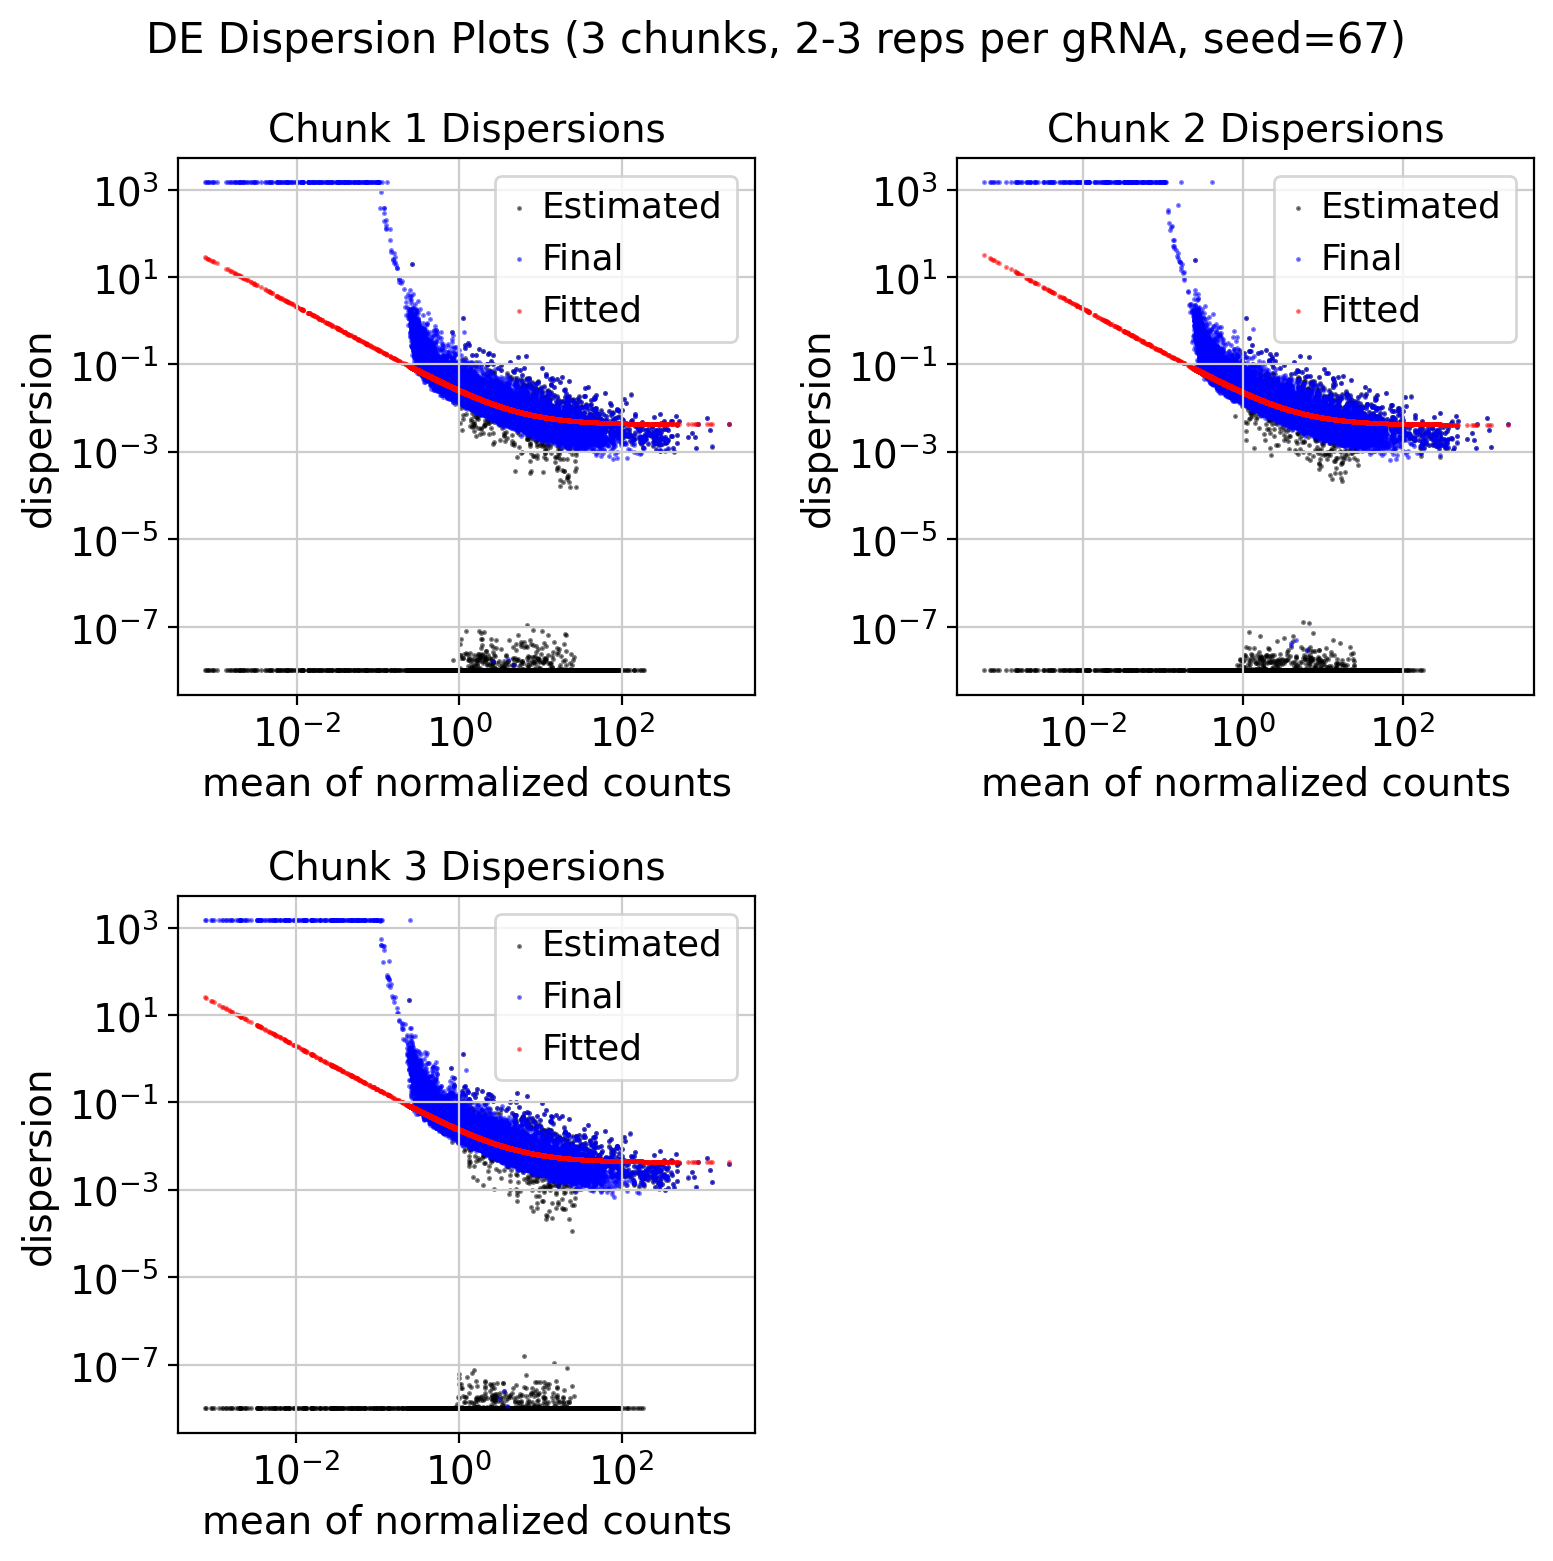

In [20]:
plot_dispersions_chunks(dds_objects_2_3_reps, 
                        "DE Dispersion Plots (3 chunks, 2-3 reps per gRNA, seed=67)")

In [10]:
de_results_df_2_3_reps = build_DE_df(de_results_2_3_reps)
de_results_df_2_3_reps.head()

NR2C2_3_baseMean  NR2C2_3_log2FoldChange  NR2C2_3_lfcSE  \
A1BG               2.827034               -0.003374       0.731317   
A1BG-AS1           0.435485               -1.031835       2.401948   
A2M                0.376323                1.681748       1.107155   
A2ML1              1.311197                0.526787       1.037162   
A2ML1-AS1          3.838352               -0.323955       0.728430   

           NR2C2_3_stat  NR2C2_3_pvalue  NR2C2_3_padj  ZNF16_1_baseMean  \
A1BG          -0.004614        0.996319      0.999122          2.827034   
A1BG-AS1      -0.429583        0.667499      0.995879          0.435485   
A2M            1.518982        0.128767      0.995879          0.376323   
A2ML1          0.507912        0.611515      0.995879          1.311197   
A2ML1-AS1     -0.444730        0.656515      0.995879          3.838352   

           ZNF16_1_log2FoldChange  ZNF16_1_lfcSE  ZNF16_1_stat  ...  \
A1BG                     0.493980       0.519817      0.950297  ...   
A1BG-AS1                 0.225207       1.475414      0.152640  ...   
A2M                      1.463231       1.100197      1.329972  ...   
A2ML1                   -0.352951       1.031180     -0.342278  ...   
A2ML1-AS1                1.038741       0.381729      2.721151  ...   

           STAT1_2_lfcSE  STAT1_2_stat  STAT1_2_pvalue  STAT1_2_padj  \
A1BG            0.731210     -2.090207        0.036599        0.9997   
A1BG-AS1        1.060239      0.477856        0.632753        0.9997   
A2M             1.498648     -0.176329        0.860036        0.9997   
A2ML1           0.610098     -0.226539        0.820782        0.9997   
A2ML1-AS1       0.352096      0.857501        0.391168        0.9997   

           ZFP41_2_baseMean  ZFP41_2_log2FoldChange  ZFP41_2_lfcSE  \
A1BG               2.790245               -0.640875       0.566627   
A1BG-AS1           0.412643                1.871297       1.294155   
A2M                0.382920                1.154717       1.538883   
A2ML1              1.329462               -1.421428       0.713603   
A2ML1-AS1          3.776483                0.055898       0.443806   

           ZFP41_2_stat  ZFP41_2_pvalue  ZFP41_2_padj  
A1BG          -1.131034        0.258041      0.999475  
A1BG-AS1       1.445961        0.148188      0.999475  
A2M            0.750361        0.453037      0.999475  
A2ML1         -1.991904        0.046382      0.999475  
A2ML1-AS1      0.125952        0.899770      0.999475  

[5 rows x 5916 columns]

In [11]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_3chunks_2-3reps.pkl"
de_results_df_2_3_reps.to_pickle(filepath_pkl)

Random seed = 67

In [ ]:
# 196 min (3hrs 16min)
de_results_2_3_reps, dds_objects_2_3_reps = \
    run_dataset_DE_chunks_2_3_reps(adata, max_chunk_size=1500, n_cpus=75,
                                   min_cells_for_3_reps=60, return_dds_objects=True,
                                   random_state=67)

Generating pseudobulk representation of dataset
2773 perturbation samples, 552 NTC samples, 3 chunks
185 targets with 2 reps, 801 targets with 3 reps
Number of targets with 2 reps per chunk: [62, 62, 61]
Number of targets with 3 reps per chunk: [267, 267, 267]
Running DE analysis on chunk 1 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.48 seconds.

Fitting dispersions...
... done in 1798.32 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 110.92 seconds.

Fitting LFCs...
... done in 87.16 seconds.

Calculating cook's distance...
... done in 1.29 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/329 [00:00<?, ?it/s]

Running DE analysis on chunk 2 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.52 seconds.

Fitting dispersions...
... done in 2025.16 seconds.

Fitting dispersion trend curve...
... done in 0.29 seconds.

Fitting MAP dispersions...
... done in 120.81 seconds.

Fitting LFCs...
... done in 85.72 seconds.

Calculating cook's distance...
... done in 1.31 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/329 [00:00<?, ?it/s]

Running DE analysis on chunk 3 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.51 seconds.

Fitting dispersions...
... done in 1479.83 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 109.44 seconds.

Fitting LFCs...
... done in 86.02 seconds.

Calculating cook's distance...
... done in 1.30 seconds.

Replacing 0 outlier genes.



Running DE statistical testing:   0%|          | 0/328 [00:00<?, ?it/s]

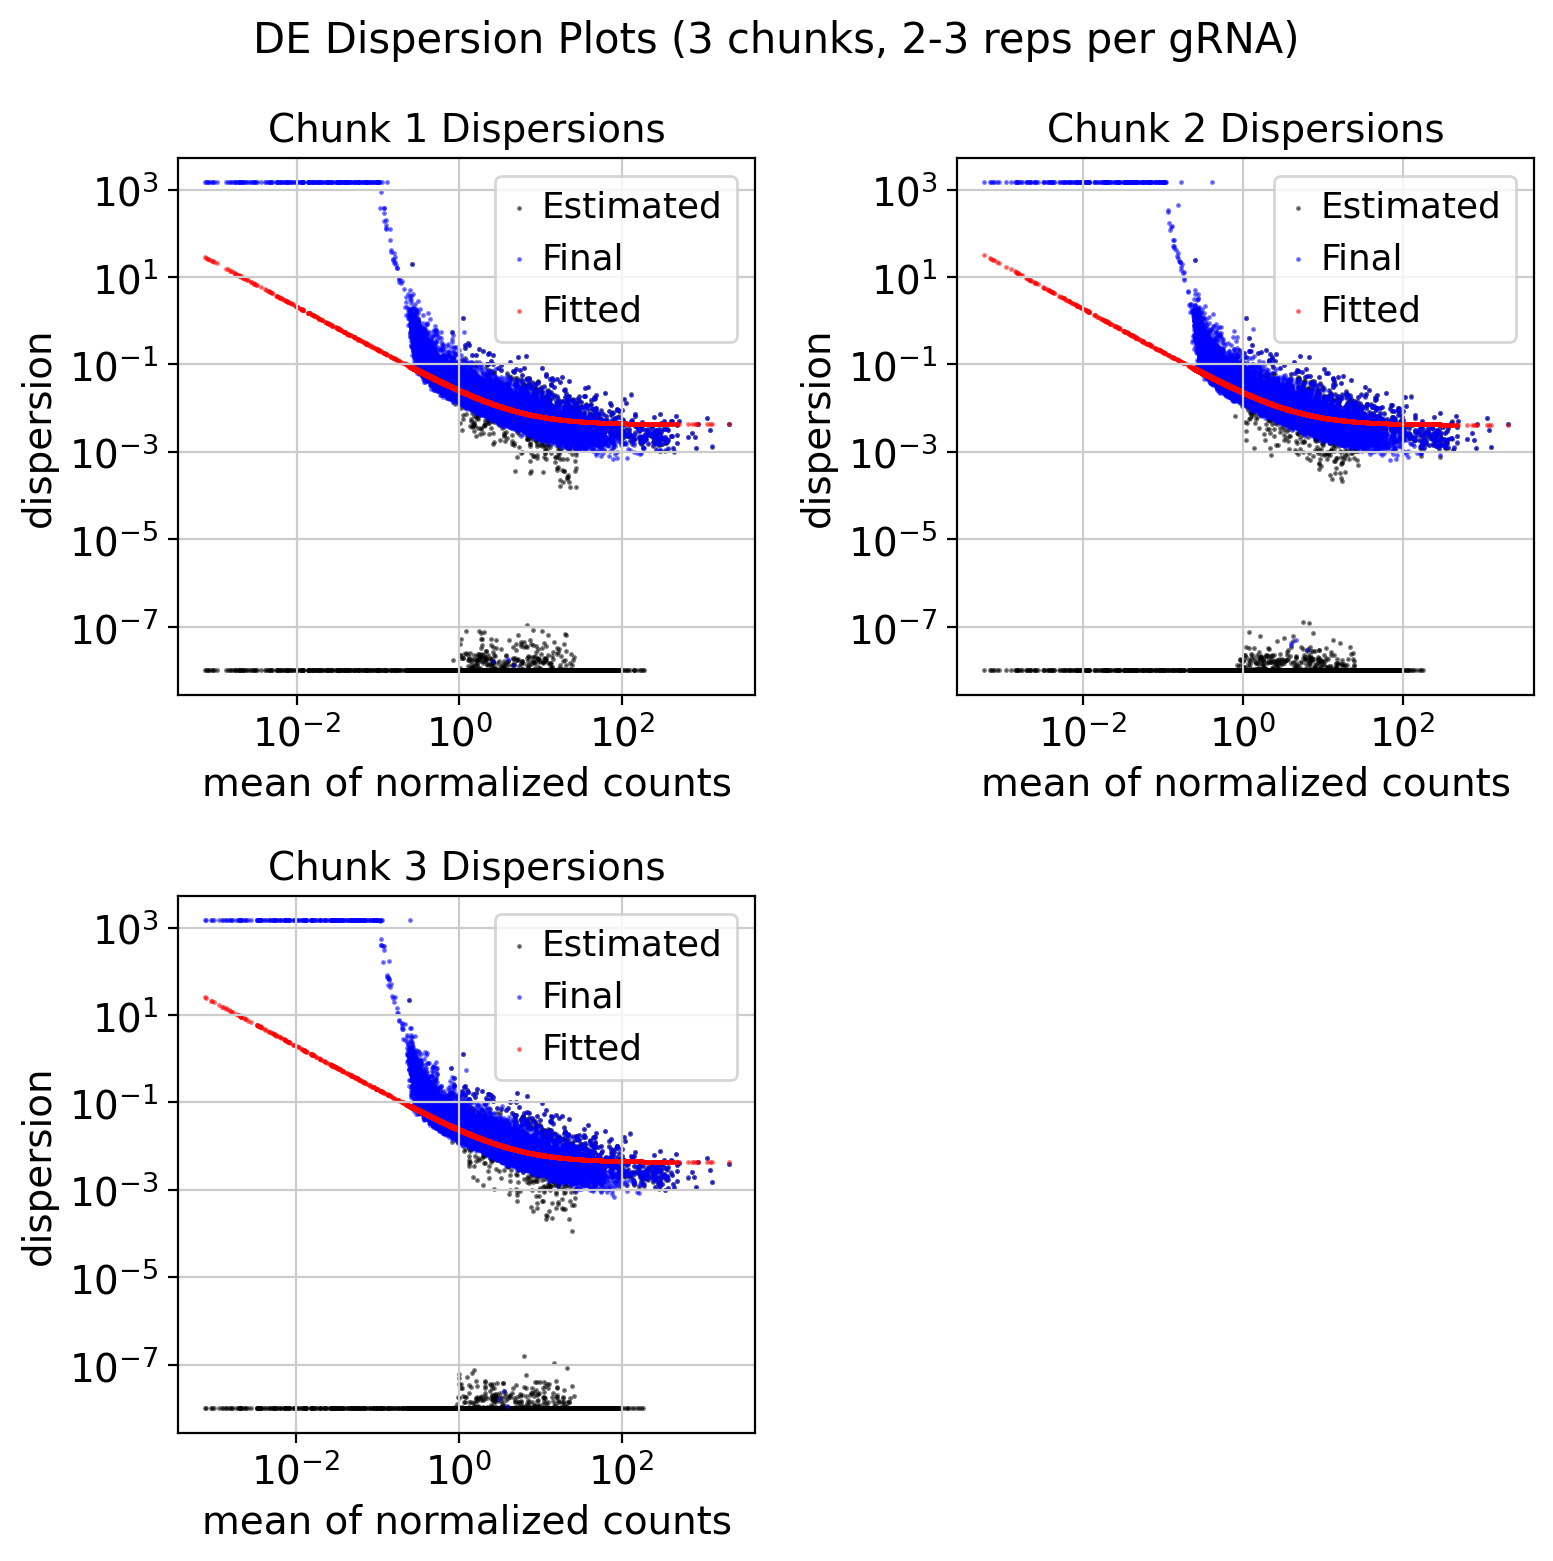

In [9]:
plot_dispersions_chunks(dds_objects_2_3_reps, 
                        "DE Dispersion Plots (3 chunks, 2-3 reps per gRNA)")

In [10]:
de_results_df_2_3_reps = build_DE_df(de_results_2_3_reps)
de_results_df_2_3_reps.head()

ZNF785_3_baseMean  ZNF785_3_log2FoldChange  ZNF785_3_lfcSE  \
A1BG                2.825213                -0.119328        0.652439   
A1BG-AS1            0.406331                -1.220467        2.378477   
A2M                 0.357067                 2.061855        0.925485   
A2ML1               1.349573                 0.832734        0.756306   
A2ML1-AS1           3.831621                 0.013628        0.561750   

           ZNF785_3_stat  ZNF785_3_pvalue  ZNF785_3_padj  ZNF335_2_baseMean  \
A1BG           -0.182895         0.854880       0.999511           2.825213   
A1BG-AS1       -0.513130         0.607860       0.997405           0.406331   
A2M             2.227864         0.025890       0.997405           0.357067   
A2ML1           1.101055         0.270873       0.997405           1.349573   
A2ML1-AS1       0.024261         0.980645       0.999511           3.831621   

           ZNF335_2_log2FoldChange  ZNF335_2_lfcSE  ZNF335_2_stat  ...  \
A1BG                     -1.572837        1.449171      -1.085336  ...   
A1BG-AS1                  0.654794        1.486734       0.440425  ...   
A2M                      -0.440840        2.430576      -0.181373  ...   
A2ML1                     0.164431        1.470981       0.111783  ...   
A2ML1-AS1                 0.914663        0.568722       1.608278  ...   

           SNAI2_2_lfcSE  SNAI2_2_stat  SNAI2_2_pvalue  SNAI2_2_padj  \
A1BG            0.507155     -1.032087        0.302032      0.999998   
A1BG-AS1        0.924310      1.121289        0.262165      0.999998   
A2M             1.461977     -0.177521        0.859099      0.999998   
A2ML1           1.047108     -2.028679        0.042491      0.999998   
A2ML1-AS1       0.442830     -1.184949        0.236037      0.999998   

           ZNF841_3_baseMean  ZNF841_3_log2FoldChange  ZNF841_3_lfcSE  \
A1BG                2.768277                 0.211601        0.420046   
A1BG-AS1            0.446179                 0.504915        1.065490   
A2M                 0.381827                -1.150451        1.974116   
A2ML1               1.290854                -0.389769        0.673530   
A2ML1-AS1           3.722151                 0.021142        0.392296   

           ZNF841_3_stat  ZNF841_3_pvalue  ZNF841_3_padj  
A1BG            0.503755         0.614433       0.999767  
A1BG-AS1        0.473881         0.635585       0.999767  
A2M            -0.582768         0.560050       0.999767  
A2ML1          -0.578695         0.562795       0.999767  
A2ML1-AS1       0.053892         0.957021       0.999767  

[5 rows x 5916 columns]

In [11]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_3chunks_2-3reps_seed67.pkl"
de_results_df_2_3_reps.to_pickle(filepath_pkl)

## Comparing 4 chunks, 2 vs. 2-3 reps

In [16]:
file_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(file_path)

In [12]:
import pandas as pd

de_results_df_2_reps = \
    pd.read_pickle("/home/ranwyl/results_tf_project/DE_results_4chunks_2reps.pkl")

de_results_df_5_chunks_2_3_reps = \
    pd.read_pickle("/home/ranwyl/results_tf_project/DE_results_5chunks_2-3reps.pkl")

de_results_df_4_chunks_2_3_reps = \
    pd.read_pickle("/home/ranwyl/results_tf_project/DE_results_4chunks_2-3reps.pkl")

de_results_df_3_chunks_2_3_reps_42 = \
    pd.read_pickle("/home/ranwyl/results_tf_project/DE_results_3chunks_2-3reps.pkl")

de_results_df_3_chunks_2_3_reps_67 = \
    pd.read_pickle("/home/ranwyl/results_tf_project/DE_results_3chunks_2-3reps_seed67.pkl")

In [13]:
def build_n_cells_degs_df(DE_results_df, adata, target_type="perturbation",
                          alpha=0.05, padj_col="padj"):
    if (target_type != "perturbation") & (target_type != "gene_target"):
        raise ValueError("target_type must be 'perturbation' or 'gene_target")
    # Build DF of targets and n_cells
    n_cells_degs_df = adata.obs[target_type].value_counts().reset_index()
    if "NTC" in n_cells_degs_df[target_type].values:
        n_cells_degs_df = n_cells_degs_df[n_cells_degs_df[target_type] != "NTC"]
    n_cells_degs_df.rename(columns={"count": "n_cells"}, inplace=True)
    n_cells_degs_df.sort_values(by=target_type, inplace=True)
    # Build n_DEGs column
    n_degs_list = list()
    targets = n_cells_degs_df[target_type].tolist()
    for target in targets:
        target_df = \
            DE_results_df.loc[:, DE_results_df.columns.str.contains(f"{target}_")]
        n_degs = len(target_df[target_df[f"{target}_{padj_col}"] < alpha])
        n_degs_list.append(n_degs)
    n_cells_degs_df["n_DEGs"] = n_degs_list
    index_name = target_type if target_type == "gene_target" else "gRNA"
    n_cells_degs_df = n_cells_degs_df.set_index(target_type).rename_axis(index_name)
    return n_cells_degs_df

In [16]:
de_n_cells_degs_df_2_reps = build_n_cells_degs_df(de_results_df_2_reps, adata, alpha=0.1)
de_n_cells_degs_df_3_chunks_2_3_reps_42 = \
    build_n_cells_degs_df(de_results_df_3_chunks_2_3_reps_42, adata, alpha=0.1)
de_n_cells_degs_df_3_chunks_2_3_reps_67 = \
    build_n_cells_degs_df(de_results_df_3_chunks_2_3_reps_67, adata, alpha=0.1)
de_n_cells_degs_df_4_chunks_2_3_reps = \
    build_n_cells_degs_df(de_results_df_4_chunks_2_3_reps, adata, alpha=0.1)
de_n_cells_degs_df_5_chunks_2_3_reps = \
    build_n_cells_degs_df(de_results_df_5_chunks_2_3_reps, adata, alpha=0.1)

In [23]:
de_n_cells_degs_df_3_chunks_2_3_reps_67.sort_values(by="n_DEGs", ascending=False).head(15)

n_cells  n_DEGs
gRNA                      
POU5F1B_1       44    1340
POU5F1_2        29    1313
POU5F1_3        50    1166
PHF20_1         46    1062
POU5F1_1        27    1055
POU3F2_2        50     929
ZNF521_1        83     768
ZNF396_2        51     764
NANOG_2         81     358
PURG_3          63     321
DNMT1_3         52     261
DNMT1_1         50     253
DNMT1_2         45     246
NFKB2_1         85     189
PRDM14_1        55     189

In [17]:
def build_DE_method_comparison_df(n_cells_degs_df_list, index_list):
    df_dict = dict()
    for i in range(len(n_cells_degs_df_list)):
        n_cells_degs_df = n_cells_degs_df_list[i]
        lt_0_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] == 0])
        gt_0_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] > 0])
        gte_3_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] >= 3])
        gte_10_degs = len(n_cells_degs_df[n_cells_degs_df['n_DEGs'] >= 10])
        df_dict[index_list[i]] = [lt_0_degs, gt_0_degs, gte_3_degs, gte_10_degs]
    cols = ["gRNAs w/ 0 DEGs", ">0 DEGs", "≥3 DEGs", "≥10 DEGs"]
    de_comparison_df = pd.DataFrame.from_dict(df_dict, orient="index", columns=cols)
    return de_comparison_df

In [18]:
idx_list = ["4 chunks, 2 reps/gRNA", "5 chunks, 2-3 reps/gRNA", 
            "4 chunks, 2-3 reps/gRNA", "3 chunks, 2-3 reps/gRNA, seed=42",
            "3 chunks, 2-3 reps/gRNA, seed=67"]
dfs_list = [de_n_cells_degs_df_2_reps, de_n_cells_degs_df_5_chunks_2_3_reps, 
            de_n_cells_degs_df_4_chunks_2_3_reps,
            de_n_cells_degs_df_3_chunks_2_3_reps_42,
            de_n_cells_degs_df_3_chunks_2_3_reps_67]
compare_DE_methods_df = build_DE_method_comparison_df(dfs_list, idx_list)

In [19]:
compare_DE_methods_df

gRNAs w/ 0 DEGs  >0 DEGs  ≥3 DEGs  ≥10 DEGs
4 chunks, 2 reps/gRNA                         377      609      374       155
5 chunks, 2-3 reps/gRNA                       368      618      376       165
4 chunks, 2-3 reps/gRNA                       342      644      401       168
3 chunks, 2-3 reps/gRNA, seed=42              329      657      418       180
3 chunks, 2-3 reps/gRNA, seed=67              320      666      419       177

In [24]:
idx_cols = ["4 chunks, 2 reps/gRNA", "3 chunks, 2-3 reps/gRNA"]
dfs_list = [de_n_cells_degs_df_2_reps, de_n_cells_degs_df_3_chunks_2_3_reps_67]
compare_2_methods_df = build_DE_method_comparison_df(dfs_list, idx_cols)

In [25]:
compare_2_methods_df

gRNAs w/ 0 DEGs  >0 DEGs  ≥3 DEGs  ≥10 DEGs
4 chunks, 2 reps/gRNA                377      609      374       155
3 chunks, 2-3 reps/gRNA              320      666      419       177

## Gene target level gRNA, 2-3 reps

In [4]:
# run_pydeseq2() and handle_warnings
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import warnings
from contextlib import contextmanager
import gc

# Handle warnings from PyDESeq2
@contextmanager
def handle_warnings(suppress):
    if suppress:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yield
    else:
        yield

def run_pydeseq2(counts_df: pd.DataFrame, metadata_df: pd.DataFrame,
                 targets: list, n_cpus: int = 20, 
                 alpha: float = 0.05, quiet: bool = False,
                 return_dds_object = False, suppress_warnings: bool = False,
                 shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True):
    """
    Perform DE analysis with PyDESeq2 on perturbing gRNA or gene targets.
    Uses parallel processing for DeseqStats.summary().
    """
    # Get targets (PyDESeq2 0.4.12 can't handle underscores)
    targets_hyphenated = [t.replace("_", "-") for t in targets]
    # Run DE analysis
    with handle_warnings(suppress_warnings):
        # Set number of CPUs to use
        dds_inference = DefaultInference(n_cpus=n_cpus)
        ds_inference = DefaultInference(n_cpus=1)
        # Fit dispersions and LFCs
        dds_quiet = True if quiet else False
        dds = DeseqDataSet(counts=counts_df, metadata=metadata_df,
                          design_factors="condition",
                          continuous_factors=["n-cells-in-rep"],
                          ref_level=["condition", "NTC"],
                          inference=dds_inference, quiet=dds_quiet
                          )
        print(f"\nFitting dispersion and LFC parameters with DeseqDataSet.deseq2()")
        dds.deseq2()
        # Helper function for statistical testing
        def run_DeseqStats(target, shrink_lfcs, lfc_shrink_adapt):
            contrast=["condition", target, "NTC"]
            ds = DeseqStats(dds, contrast=contrast, alpha=alpha,
                            inference=ds_inference, quiet=True)
            ds.summary()
            if shrink_lfcs:
                coeff = f"{contrast[0]}_{contrast[1]}_vs_{contrast[2]}"
                ds.lfc_shrink(coeff=coeff, adapt=lfc_shrink_adapt)
            return ds.results_df
        # Perform statistical testing in parallel
        with tqdm_joblib(desc="Running DE statistical testing", total=len(targets_hyphenated)):
            ds_results = Parallel(n_jobs=n_cpus)(
                delayed(run_DeseqStats)(target, shrink_lfcs, lfc_shrink_adapt)
                        for target in targets_hyphenated)
        # Return results
        de_results_dict = {targets[i]: ds_results[i] for i in range(len(targets))}
        if return_dds_object:
            return de_results_dict, dds
        else:
            return de_results_dict

In [5]:
def create_pseudobulk_dataset(adata: ad.AnnData, target_type: str = "gRNA",
                              ntc_benchmarking: bool = False,
                              layer: str = "counts",
                              min_cells_for_3_reps: int = 60,
                              approx_ntc_rep_size: int = 50,
                              random_state: int = 42,
                              ntc_target_delimiter: str = "NTC",
                              ntc_gRNA_delimiter: str = "Non-Targeting"):
    """
    Generate pseudobulk representation of adata with pseudoreplicates for 
    each gRNA or gene target (based on target_type).
    """
    # Error handling
    if (target_type != "gRNA") & (target_type != "gene_target"):
        raise ValueError("Error: target_type must be 'gRNA' or 'gene_target'")
    if (ntc_benchmarking is True) & (target_type != "gRNA"):
        raise ValueError("Error: target_type must be 'gRNA' for NTC benchmarking")

    # Get targets
    targets = adata.obs[target_type].unique().tolist()
    # RNG objects for creating pseudoreplicates
    de_rng = np.random.default_rng(random_state)
    target_rngs = de_rng.spawn(len(targets))

    # Data structures for counts_df and metadata_df
    counts_arrays, counts_df_index = list(), list()
    metadata_condition, metadata_n_cells = list(), list()

    # Get data and convert from sparse to dense
    data_matrix = adata.layers[layer] if layer in adata.layers else adata.X
    if sparse.issparse(data_matrix):
        data_matrix = data_matrix.toarray()

    # Generate pseudoreplicates
    for target, rng in zip(targets, target_rngs):
        # Get target data
        target_indices = np.where(adata.obs[target_type] == target)[0]
        target_data = data_matrix[target_indices]
        
        # Calculate pseudoreplicate size
        n_target_cells = target_data.shape[0]
        if target_type == "gRNA": # gRNA targets
            if n_target_cells < min_cells_for_3_reps:
                rep1_size = n_target_cells // 2
                rep2_size = n_target_cells - rep1_size
                rep_sizes = [rep1_size, rep2_size]
            else:
                rep1_size = n_target_cells // 3
                rep2_size = (n_target_cells - rep1_size) // 2
                rep3_size = n_target_cells - rep1_size - rep2_size
                rep_sizes = [rep1_size, rep2_size, rep3_size]
        else: # Gene targets
            # Create NTC reps of about approx_ntc_rep_size as evenly as possible
            if target == ntc_target_delimiter:
                n_reps = round(n_target_cells / approx_ntc_rep_size)
                base_size = n_target_cells // n_reps
                remainder = n_target_cells % n_reps
                # First 'remainder' reps get one extra item
                rep_sizes = \
                    [base_size+1]*remainder + [base_size]*(n_reps-remainder)
            else:
                if n_target_cells < min_cells_for_3_reps:
                    rep1_size = n_target_cells // 2
                    rep2_size = n_target_cells - rep1_size
                    rep_sizes = [rep1_size, rep2_size]
                else:
                    rep1_size = n_target_cells // 3
                    rep2_size = (n_target_cells - rep1_size) // 2
                    rep3_size = n_target_cells - rep1_size - rep2_size
                    rep_sizes = [rep1_size, rep2_size, rep3_size]

        # Sample target indices for each rep
        target_cell_indices = np.arange(n_target_cells)
        rng.shuffle(target_cell_indices)
        rep_sizes_array = np.array(rep_sizes)
        rep_splits = np.cumsum(rep_sizes_array)[:-1]
        rep_indices = np.split(target_cell_indices, rep_splits)
        
        # Update pseudobulk counts
        n_reps = len(rep_sizes)
        target_counts = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
        for i in range(n_reps):
            target_counts[i] = \
                np.sum(target_data[rep_indices[i]], axis=0).astype(np.int64)
        counts_arrays.append(target_counts)
        target_hyphenated = target.replace("_", "-")
        rep_names = [f"{target_hyphenated}-rep{i+1}" for i in range(n_reps)]
        counts_df_index += rep_names
        
        # Update metadata
        metadata_n_cells += rep_sizes
        if ntc_gRNA_delimiter in target:
            metadata_condition += (["NTC"]*n_reps)
        else:
            metadata_condition += ([target_hyphenated]*n_reps)
            
    # Create counts DF
    counts_arr = np.concatenate(tuple(arr for arr in counts_arrays), axis=0)
    counts_df = pd.DataFrame(
        counts_arr,
        index=counts_df_index,
        columns=adata.var_names
    )

    # Create metadata DF
    metadata_dict = {"sample": counts_df_index,
                    "condition": metadata_condition,
                    "n-cells-in-rep": metadata_n_cells}
    metadata_df = pd.DataFrame.from_dict(metadata_dict)
    metadata_df = metadata_df.set_index("sample").rename_axis(None)
    return counts_df, metadata_df

In [13]:
def run_dataset_DE_chunks_2_3_reps(
        adata: ad.AnnData, target_type: str = "gRNA",
        max_chunk_size: int = 1100, n_chunks=None,
        layer: str = "counts",
        min_cells_for_3_reps: int = 60,
        approx_ntc_rep_size: int = 50,
        random_state: int = 42,
        ntc_target_delimiter: str = "NTC",
        ntc_gRNA_delimiter: str = "Non-Targeting",
        n_cpus: int = 20, alpha: float = 0.05,
        return_dds_objects: bool = False, quiet: bool = False,
        shrink_lfcs: bool = False, lfc_shrink_adapt: bool = True,
        suppress_warnings: bool = False, debug: bool = False,
        counts_df=None, metadata_df=None):
    """
    Run pseudobulk DE on perturbing gRNA or gene targets (based on target_type).
    Create pseudobulk dataset and break into chunks that each include all NTC reps
    and a subset of perturbing gRNAs/gene targets. Run DE on each chunk.
    """
    # Create pseudobulk dataset
    if (counts_df is None) or (metadata_df is None):
        print("Generating pseudobulk representation of dataset")
        counts_df, metadata_df = \
            create_pseudobulk_dataset(
                adata, target_type=target_type, layer=layer,
                approx_ntc_rep_size = approx_ntc_rep_size,
                min_cells_for_3_reps=min_cells_for_3_reps,
                random_state=random_state,
                ntc_target_delimiter=ntc_target_delimiter,
                ntc_gRNA_delimiter=ntc_gRNA_delimiter
                )
    
    # Get number of chunks
    n_target_samples = len(metadata_df[metadata_df["condition"] != "NTC"])
    n_ntc_samples = len(metadata_df[metadata_df["condition"] == "NTC"])
    if n_chunks is None:
        n_chunks = round(n_target_samples / (max_chunk_size - n_ntc_samples))
    print(f"{n_target_samples} perturbation samples, {n_ntc_samples} NTC samples, "
        f"{n_chunks} chunks")

    # Get number of perturbations per chunk
    target_counts_df = \
        pd.DataFrame(adata[adata.obs.perturbed == "True"].obs[target_type].value_counts())
    two_reps_mask = target_counts_df["count"] < min_cells_for_3_reps
    three_reps_mask = target_counts_df["count"] >= min_cells_for_3_reps
    n_targets_2_3_reps = \
        [len(target_counts_df[two_reps_mask]), 
         len(target_counts_df[three_reps_mask])] # number of targets for 2, 3 reps
    print(f"{n_targets_2_3_reps[0]} targets with 2 reps, "
          f"{n_targets_2_3_reps[1]} targets with 3 reps")
    n_chunk_targets_2_3_reps = list() # array of size 2 x n_chunks
    for i in range(2):
        n_targets = n_targets_2_3_reps[i]
        base_size = n_targets // n_chunks
        remainder = n_targets % n_chunks
        n_targets_per_chunk = [base_size+1]*remainder + [base_size]*(n_chunks-remainder)
        n_chunk_targets_2_3_reps.append(n_targets_per_chunk) 
    print(f"Number of targets with 2 reps per chunk: {n_chunk_targets_2_3_reps[0]}")
    print(f"Number of targets with 3 reps per chunk: {n_chunk_targets_2_3_reps[1]}")

    # Determine perturbations per chunk
    rng = np.random.default_rng(random_state)
    targets_2_3_reps = [target_counts_df[two_reps_mask].index.tolist(),
                        target_counts_df[three_reps_mask].index.tolist()]
    chunk_indices_2_3_reps = list() # array of size 2 x n_chunks
    for i in range(2):
        n_targets_per_chunk = n_chunk_targets_2_3_reps[i] # vector of size n_chunks
        target_indices = np.arange(n_targets_2_3_reps[i]) # vector of size n_targets_per_chunk
        rng.shuffle(target_indices)
        chunk_splits = np.cumsum(np.array(n_targets_per_chunk))[:-1]
        chunk_indices = np.split(target_indices, chunk_splits)
        chunk_indices_2_3_reps.append(chunk_indices)

    # Divide pseudobulk dataset into chunks
    chunk_counts_dfs, chunk_meta_dfs = list(), list()
    all_chunk_targets = list() # array of size n_chunks x n_targets_per_chunk
    for i in range(n_chunks):
        chunk_targets = list()
        # Add 2-rep targets and 3-rep targets to chunk target list
        for j in range(2):
            rep_size_chunk_indices = chunk_indices_2_3_reps[j]
            rep_size_targets = targets_2_3_reps[j]
            rep_chunk_targets = [rep_size_targets[k] for k in rep_size_chunk_indices[i]]
            chunk_targets += rep_chunk_targets
        # Create counts and metadata DFs
        chunk_targets_hyphenated = [t.replace("_", "-") for t in chunk_targets]
        chunk_meta_df = \
            metadata_df.loc[(metadata_df["condition"].isin(chunk_targets_hyphenated))
                            | (metadata_df["condition"] == "NTC")]
        chunk_samples = chunk_meta_df.index.tolist()
        chunk_counts_df = counts_df.loc[counts_df.index.isin(chunk_samples)]
        chunk_counts_dfs.append(chunk_counts_df)
        chunk_meta_dfs.append(chunk_meta_df)
        all_chunk_targets.append(chunk_targets)

    # Run DE analysis on each chunk pseudobulk dataset
    de_results_dict = dict()
    n_chunks_to_run = 1 if debug else n_chunks
    if return_dds_objects:
        dds_objects = list()
    for i in range(n_chunks_to_run):
        print(f"Running DE analysis on chunk {i+1} of {n_chunks}")
        chunk_results = \
            run_pydeseq2(chunk_counts_dfs[i], 
                         chunk_meta_dfs[i],
                         targets=all_chunk_targets[i],
                         n_cpus=n_cpus, alpha=alpha, quiet=quiet,
                         return_dds_object=return_dds_objects,
                         shrink_lfcs=shrink_lfcs,
                         lfc_shrink_adapt=lfc_shrink_adapt,
                         suppress_warnings=suppress_warnings)
        if return_dds_objects:
            de_results_dict.update(chunk_results[0])
            dds_objects.append(chunk_results[1])
        else:
            de_results_dict.update(chunk_results)
    if return_dds_objects:
        return de_results_dict, dds_objects
    else:
        return de_results_dict

In [7]:
def build_DE_df(results_dict):
    df_list = list()
    for target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [8]:
import matplotlib.pyplot as plt
import math

def plot_dispersions_chunks(dds_objects, title="DE Dispersion Plots", log=True):
    n_rows = math.ceil(len(dds_objects)/2)
    _, axes = plt.subplots(n_rows, 2, figsize=(8,4*n_rows))
    for i, ax in enumerate(axes.flat):
        if i < len(dds_objects):
            dds = dds_objects[i]
            disps = [
                dds.varm["genewise_dispersions"],
                dds.varm["dispersions"],
                dds.varm["fitted_dispersions"],
            ]
            legend_labels = ["Estimated", "Final", "Fitted"]
            colors = "kbr"
            if log is True:
                ax.set_yscale("log")
                ax.set_xscale("log")
            ax.set_adjustable("datalim")

            for disp, color in list(zip(disps, colors, strict=False)):
                ax.scatter(x=dds.varm["_normed_means"], y=disp,
                        s=0.6, c=color, alpha=0.5)
            
            ax.legend(legend_labels, loc="best")
            ax.set_xlabel("mean of normalized counts")
            ax.set_ylabel("dispersion")
            ax.set_title(f"Chunk {i+1} Dispersions")
        else:
            ax.axis("off")
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.show()

In [9]:
file_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_NTC_benchmarked.h5ad"
adata = psp.utils.read_anndata(file_path)
adata

AnnData object with n_obs × n_vars = 101538 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [21]:
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histogram(adata: ad.AnnData, obs_key: str, title: str="",
                    fig_size: tuple=(4,3), bin_width=25, xtick_width=50):
    plt.figure(figsize=fig_size)
    adata_xmax = max(adata.obs[obs_key].value_counts().values)
    xmax = ((adata_xmax // bin_width) + 1) * bin_width
    sns.histplot(adata.obs[obs_key].value_counts().values, binwidth=bin_width,
        binrange=(0,xmax))
    plt.xlim(0, xmax)
    plt.xticks(np.arange(0, xmax, xtick_width), fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(False)
    plt.title(title)

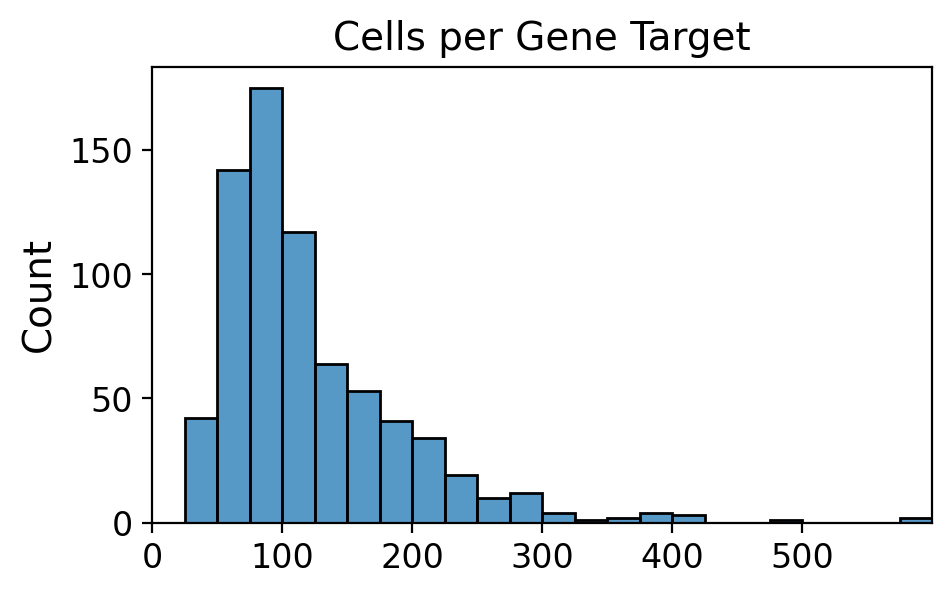

In [26]:
plot_histogram(adata[adata.obs.perturbed == "True"], 
               "gene_target", "Cells per Gene Target", 
               fig_size=(5,3), xtick_width=100)

### Gene target pseudobulk dataset

Pseudobulk dataset with ~50 cells per NTC rep

In [15]:
counts_gene_targets50, meta_gene_targets50 = \
    create_pseudobulk_dataset(adata, target_type="gene_target",
                                approx_ntc_rep_size=50)

In [16]:
meta_gene_targets50

condition  n-cells-in-rep
NTC-rep1           NTC              50
NTC-rep2           NTC              50
NTC-rep3           NTC              50
NTC-rep4           NTC              50
NTC-rep5           NTC              50
...                ...             ...
MYNN-rep2         MYNN              28
TBPL1-rep1       TBPL1              27
TBPL1-rep2       TBPL1              27
NANOGP8-rep1   NANOGP8              18
NANOGP8-rep2   NANOGP8              19

[2353 rows x 2 columns]

In [18]:
counts_gene_targets50

ENSG00000241860  ENSG00000290385  ENSG00000291215  LINC01409  \
NTC-rep1                    2                1                1          4   
NTC-rep2                    1                1                1          1   
NTC-rep3                    2                1                1          1   
NTC-rep4                    1                1                4          0   
NTC-rep5                    0                1                2          1   
...                       ...              ...              ...        ...   
MYNN-rep2                   1                0                1          3   
TBPL1-rep1                  3                1                2          1   
TBPL1-rep2                  2                0                1          0   
NANOGP8-rep1                0                0                0          1   
NANOGP8-rep2                0                0                1          0   

              LINC00115  LINC01128  NOC2L  KLHL17  ISG15  AGRN  ...  MT-ATP6  \
NTC-rep1              0          1     12       0      5     1  ...     2029   
NTC-rep2              0          2     14       0      2     3  ...     1873   
NTC-rep3              1          1     12       2      6     5  ...     1703   
NTC-rep4              3          1     18       4      5     5  ...     2282   
NTC-rep5              1          1     19       1     14     3  ...     1963   
...                 ...        ...    ...     ...    ...   ...  ...      ...   
MYNN-rep2             1          1      6       1      3     4  ...     1059   
TBPL1-rep1            0          0      5       0      2     2  ...     1277   
TBPL1-rep2            1          1      6       0      1     1  ...     1108   
NANOGP8-rep1          0          1      6       0      3     3  ...      606   
NANOGP8-rep2          0          0      2       1      3     0  ...      732   

              MT-CO3  MT-ND3  MT-ND4L  MT-ND4  MT-ND5  MT-ND6  MT-CYB  \
NTC-rep1        3565     428       30     868     171     121     678   
NTC-rep2        3512     418       30     845     201     136     668   
NTC-rep3        3230     369       19     779     125     105     573   
NTC-rep4        3780     434       33    1029     178     127     758   
NTC-rep5        3491     449       26     921     164     121     705   
...              ...     ...      ...     ...     ...     ...     ...   
MYNN-rep2       2073     275       21     488      96      80     399   
TBPL1-rep1      2378     284       13     601     114      71     462   
TBPL1-rep2      2157     233       18     484     106      59     384   
NANOGP8-rep1    1120     128       11     265      46      31     214   
NANOGP8-rep2    1278     129       13     296      49      45     241   

              ENSG00000276256  ENSG00000271254  
NTC-rep1                    0                0  
NTC-rep2                    2                1  
NTC-rep3                    5                1  
NTC-rep4                    1                2  
NTC-rep5                    2                1  
...                       ...              ...  
MYNN-rep2                   3                0  
TBPL1-rep1                  1                0  
TBPL1-rep2                  2                0  
NANOGP8-rep1                0                0  
NANOGP8-rep2                0                2  

[2353 rows x 16115 columns]

In [59]:
mask = counts_gene_targets50 > 709
columns_to_keep = mask.any(axis=0)
counts_gene_targets_filt50 = counts_gene_targets50.loc[:, columns_to_keep]
counts_gene_targets_filt50

RPL22  RERE  ENO1  RPL11  STMN1  MARCKSL1  YBX1  RPS8  PRDX1  \
NTC-rep1        298   174   201    504    185       197   299   868    475   
NTC-rep2        299   147   193    493    161       208   326   813    426   
NTC-rep3        281   168   155    468    166       174   296   806    415   
NTC-rep4        354   179   216    547    191       233   352   854    495   
NTC-rep5        354   180   227    560    216       223   332   963    535   
...             ...   ...   ...    ...    ...       ...   ...   ...    ...   
MYNN-rep2       200   110   139    336    124       138   236   593    329   
TBPL1-rep1      184   120   127    370    112       124   192   530    294   
TBPL1-rep2      196   131   113    317    106       117   196   505    271   
NANOGP8-rep1    116    51    53    150     51        59    97   264    114   
NANOGP8-rep2    100    79    54    183     57        71    92   252    130   

              NASP  ...  MT-ND1  MT-ND2  MT-CO1  MT-CO2  MT-ATP6  MT-CO3  \
NTC-rep1       258  ...     129     275    1609    2293     2029    3565   
NTC-rep2       232  ...     164     273    1441    1971     1873    3512   
NTC-rep3       254  ...     131     218    1279    2001     1703    3230   
NTC-rep4       255  ...     166     280    1663    2349     2282    3780   
NTC-rep5       239  ...     145     241    1490    2181     1963    3491   
...            ...  ...     ...     ...     ...     ...      ...     ...   
MYNN-rep2      169  ...      67     140     859    1222     1059    2073   
TBPL1-rep1     136  ...      89     135    1013    1266     1277    2378   
TBPL1-rep2     137  ...      85     131     879    1119     1108    2157   
NANOGP8-rep1    75  ...      55      80     461     646      606    1120   
NANOGP8-rep2   102  ...      49      91     555     720      732    1278   

              MT-ND3  MT-ND4  MT-ND5  MT-CYB  
NTC-rep1         428     868     171     678  
NTC-rep2         418     845     201     668  
NTC-rep3         369     779     125     573  
NTC-rep4         434    1029     178     758  
NTC-rep5         449     921     164     705  
...              ...     ...     ...     ...  
MYNN-rep2        275     488      96     399  
TBPL1-rep1       284     601     114     462  
TBPL1-rep2       233     484     106     384  
NANOGP8-rep1     128     265      46     214  
NANOGP8-rep2     129     296      49     241  

[2353 rows x 196 columns]

In [58]:
counts50_ntc = \
    counts_gene_targets_filt50[counts_gene_targets_filt50.index.str.contains("NTC-")]
print(f"NTC filtered DF shape: {counts50_ntc.shape}")
print(f"# NTC counts >709: {(counts50_ntc > 709).sum().sum()}")
counts50_pert = \
    counts_gene_targets_filt50[~counts_gene_targets_filt50.index.str.contains("NTC-")]
print(f"Perturbed filtered DF shape: {counts50_pert.shape}")
print(f"# perturbed counts >709: {(counts50_pert > 709).sum().sum()}")
print(f"Total counts entries: {counts_gene_targets50.shape[0] * counts_gene_targets50.shape[1]}")

NTC filtered DF shape: (266, 196)
# NTC counts >709: 4768
Perturbed filtered DF shape: (2087, 196)
# perturbed counts >709: 45507
Total counts entries: 37918595


25 cells per NTC rep

In [12]:
counts_gene_targets25, meta_gene_targets25 = \
    create_pseudobulk_dataset(adata, target_type="gene_target",
                              approx_ntc_rep_size=25)

In [13]:
counts_gene_targets25

ENSG00000241860  ENSG00000290385  ENSG00000291215  LINC01409  \
NTC-rep1                    0                0                0          2   
NTC-rep2                    2                1                1          2   
NTC-rep3                    0                0                0          1   
NTC-rep4                    1                1                1          0   
NTC-rep5                    1                1                0          1   
...                       ...              ...              ...        ...   
MYNN-rep2                   1                0                1          3   
TBPL1-rep1                  3                1                2          1   
TBPL1-rep2                  2                0                1          0   
NANOGP8-rep1                0                0                0          1   
NANOGP8-rep2                0                0                1          0   

              LINC00115  LINC01128  NOC2L  KLHL17  ISG15  AGRN  ...  MT-ATP6  \
NTC-rep1              0          1      7       0      0     1  ...      988   
NTC-rep2              0          0      5       0      5     0  ...     1041   
NTC-rep3              0          0      9       0      2     2  ...      855   
NTC-rep4              0          2      5       0      0     1  ...     1018   
NTC-rep5              0          0      4       1      4     4  ...      878   
...                 ...        ...    ...     ...    ...   ...  ...      ...   
MYNN-rep2             1          1      6       1      3     4  ...     1059   
TBPL1-rep1            0          0      5       0      2     2  ...     1277   
TBPL1-rep2            1          1      6       0      1     1  ...     1108   
NANOGP8-rep1          0          1      6       0      3     3  ...      606   
NANOGP8-rep2          0          0      2       1      3     0  ...      732   

              MT-CO3  MT-ND3  MT-ND4L  MT-ND4  MT-ND5  MT-ND6  MT-CYB  \
NTC-rep1        1722     227       10     408      83      55     326   
NTC-rep2        1843     201       20     460      88      66     352   
NTC-rep3        1672     199       15     393      99      70     298   
NTC-rep4        1840     219       15     452     102      66     370   
NTC-rep5        1621     181        8     387      62      46     295   
...              ...     ...      ...     ...     ...     ...     ...   
MYNN-rep2       2073     275       21     488      96      80     399   
TBPL1-rep1      2378     284       13     601     114      71     462   
TBPL1-rep2      2157     233       18     484     106      59     384   
NANOGP8-rep1    1120     128       11     265      46      31     214   
NANOGP8-rep2    1278     129       13     296      49      45     241   

              ENSG00000276256  ENSG00000271254  
NTC-rep1                    0                0  
NTC-rep2                    0                0  
NTC-rep3                    2                1  
NTC-rep4                    0                0  
NTC-rep5                    2                0  
...                       ...              ...  
MYNN-rep2                   3                0  
TBPL1-rep1                  1                0  
TBPL1-rep2                  2                0  
NANOGP8-rep1                0                0  
NANOGP8-rep2                0                2  

[2619 rows x 16115 columns]

In [14]:
print(len(meta_gene_targets25[meta_gene_targets25["condition"] == "NTC"]))
print(len(meta_gene_targets25[meta_gene_targets25["condition"] != "NTC"]))

532
2087


In [35]:
mask = counts_gene_targets25 > 709
columns_to_keep = mask.any(axis=0)
counts_gene_targets_genes_filt25 = counts_gene_targets25.loc[:, columns_to_keep]
counts_gene_targets_genes_filt25

RPL22  RERE  ENO1  RPL11  STMN1  MARCKSL1  YBX1  RPS8  PRDX1  \
NTC-rep1        134    78    98    238     79        77   120   411    205   
NTC-rep2        164    96   103    266    106       120   179   457    270   
NTC-rep3        134    70    91    236     81        93   148   405    204   
NTC-rep4        165    77   102    257     80       115   178   408    222   
NTC-rep5        140    92    81    205     77        77   161   389    187   
...             ...   ...   ...    ...    ...       ...   ...   ...    ...   
MYNN-rep2       200   110   139    336    124       138   236   593    329   
TBPL1-rep1      184   120   127    370    112       124   192   530    294   
TBPL1-rep2      196   131   113    317    106       117   196   505    271   
NANOGP8-rep1    116    51    53    150     51        59    97   264    114   
NANOGP8-rep2    100    79    54    183     57        71    92   252    130   

              NASP  ...  MT-ND1  MT-ND2  MT-CO1  MT-CO2  MT-ATP6  MT-CO3  \
NTC-rep1       117  ...      49     122     766    1064      988    1722   
NTC-rep2       141  ...      80     153     843    1229     1041    1843   
NTC-rep3       113  ...      88     142     669     922      855    1672   
NTC-rep4       119  ...      76     131     772    1049     1018    1840   
NTC-rep5       122  ...      62      97     636    1080      878    1621   
...            ...  ...     ...     ...     ...     ...      ...     ...   
MYNN-rep2      169  ...      67     140     859    1222     1059    2073   
TBPL1-rep1     136  ...      89     135    1013    1266     1277    2378   
TBPL1-rep2     137  ...      85     131     879    1119     1108    2157   
NANOGP8-rep1    75  ...      55      80     461     646      606    1120   
NANOGP8-rep2   102  ...      49      91     555     720      732    1278   

              MT-ND3  MT-ND4  MT-ND5  MT-CYB  
NTC-rep1         227     408      83     326  
NTC-rep2         201     460      88     352  
NTC-rep3         199     393      99     298  
NTC-rep4         219     452     102     370  
NTC-rep5         181     387      62     295  
...              ...     ...     ...     ...  
MYNN-rep2        275     488      96     399  
TBPL1-rep1       284     601     114     462  
TBPL1-rep2       233     484     106     384  
NANOGP8-rep1     128     265      46     214  
NANOGP8-rep2     129     296      49     241  

[2619 rows x 196 columns]

In [56]:
counts25_ntc = \
    counts_gene_targets_genes_filt25[counts_gene_targets_genes_filt25.index.str.contains("NTC-")]
print(f"NTC filtered DF shape: {counts25_ntc.shape}")
print(f"# NTC counts >709: {(counts25_ntc > 709).sum().sum()}")
counts25_pert = \
    counts_gene_targets_genes_filt25[~counts_gene_targets_genes_filt25.index.str.contains("NTC-")]
print(f"Perturbed filtered DF shape: {counts25_pert.shape}")
print(f"# perturbed counts >709: {(counts25_pert > 709).sum().sum()}")
print(f"Total counts entries: {counts_gene_targets25.shape[0] * counts_gene_targets25.shape[1]}")

NTC filtered DF shape: (532, 196)
# NTC counts >709: 3030
Perturbed filtered DF shape: (2087, 196)
# perturbed counts >709: 45507
Total counts entries: 42205185


In [53]:
print(f"# MT- genes: {counts_gene_targets_genes_filt25.loc[:, counts_gene_targets_genes_filt25.columns.str.contains('MT-')].shape[1]}")
print(f"# LINC genes: {counts_gene_targets_genes_filt25.loc[:, counts_gene_targets_genes_filt25.columns.str.contains('LINC')].shape[1]}")
print(f"# ENSG genes: {counts_gene_targets_genes_filt25.loc[:, counts_gene_targets_genes_filt25.columns.str.contains('ENSG')].shape[1]}")

# MT- genes: 10
# LINC genes: 0
# ENSG genes: 1


In [33]:
total_count_greater = (counts_gene_targets_genes_filt25 > 709).sum().sum()
total_count_greater
# Out of 37 million entries

48537

In [55]:
mask = counts_gene_targets25 > 709
rows_to_keep = mask.any(axis=1)
cols_to_keep = mask.any(axis=0)
counts_gene_targets_filt25 = counts_gene_targets25.loc[rows_to_keep, cols_to_keep]
print(counts_gene_targets_filt25.shape)

(2619, 196)


### Gene target DE

3 chunks, 50 cells per NTC rep, random seed = 42, ignore warnings

In [14]:
de_results_gene_targets50, dds_objects_gene_targets50 = \
    run_dataset_DE_chunks_2_3_reps(adata, target_type="gene_target",
                                   n_chunks=3, n_cpus=75,
                                   approx_ntc_rep_size=50,
                                   min_cells_for_3_reps=60,
                                   random_state=42,
                                   return_dds_objects=True)

Generating pseudobulk representation of dataset
2087 perturbation samples, 266 NTC samples, 3 chunks
91 targets with 2 reps, 635 targets with 3 reps
Number of targets with 2 reps per chunk: [31, 30, 30]
Number of targets with 3 reps per chunk: [212, 212, 211]
Running DE analysis on chunk 1 of 3

Fitting dispersion and LFC parameters with DeseqDataSet.deseq2()


Fitting size factors...
... done in 0.35 seconds.

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/utils.py:550: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/utils.py:404: RuntimeWarning: invalid value encountered in multiply
  - counts * np.log(mu)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/utils.py:402: RuntimeWarning: invalid value encountered in subtract
  -logbinom
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/utils.py:554: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/utils.py:557: RuntimeWarning: overflow encountered in multiply
  + ((1 / disp + counts) * mu_ / (1 / disp + mu_)) @ X
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/utils.py:557: RuntimeWarning: invalid value encountered i

LinAlgError: Singular matrix

In [ ]:
plot_dispersions_chunks(dds_objects_gene_targets50, 
                        "Gene Target DE Dispersion Plots")

In [ ]:
de_results_df_gene_targets50 = build_DE_df(de_results_gene_targets50)
de_results_df_gene_targets50.head()

NR2C2_3_baseMean  NR2C2_3_log2FoldChange  NR2C2_3_lfcSE  \
A1BG               2.742657               -0.010841       0.735985   
A1BG-AS1           0.421032               -1.045400       2.406611   
A2M                0.347912                1.692420       1.161088   
A2ML1              1.252989                0.524628       1.039627   
A2ML1-AS1          3.643710               -0.326498       0.730356   

           NR2C2_3_stat  NR2C2_3_pvalue  NR2C2_3_padj  ZNF16_1_baseMean  \
A1BG          -0.014730        0.988248      0.999358          2.742657   
A1BG-AS1      -0.434387        0.664008      0.996475          0.421032   
A2M            1.457615        0.144947      0.996475          0.347912   
A2ML1          0.504631        0.613818      0.996475          1.252989   
A2ML1-AS1     -0.447040        0.654846      0.996475          3.643710   

           ZNF16_1_log2FoldChange  ZNF16_1_lfcSE  ZNF16_1_stat  ...  \
A1BG                     0.496039       0.526058      0.942935  ...   
A1BG-AS1                 0.229896       1.483032      0.155017  ...   
A2M                      1.456361       1.157547      1.258145  ...   
A2ML1                   -0.352571       1.033394     -0.341177  ...   
A2ML1-AS1                1.039646       0.385293      2.698326  ...   

           STAT1_2_lfcSE  STAT1_2_stat  STAT1_2_pvalue  STAT1_2_padj  \
A1BG            0.731656     -2.080897        0.037443      0.999948   
A1BG-AS1        1.079225      0.487205        0.626113      0.999948   
A2M             1.537242     -0.163907        0.869804      0.999948   
A2ML1           0.616768     -0.246230        0.805504      0.999948   
A2ML1-AS1       0.352756      0.860081        0.389744      0.999948   

           ZFP41_2_baseMean  ZFP41_2_log2FoldChange  ZFP41_2_lfcSE  \
A1BG               2.722370               -0.612937       0.568726   
A1BG-AS1           0.404021                1.961533       1.322062   
A2M                0.370607                1.210000       1.602031   
A2ML1              1.254465               -1.488446       0.724537   
A2ML1-AS1          3.642391                0.065013       0.445665   

           ZFP41_2_stat  ZFP41_2_pvalue  ZFP41_2_padj  
A1BG          -1.077738        0.281151      0.998639  
A1BG-AS1       1.483692        0.137891      0.998639  
A2M            0.755291        0.450074      0.998639  
A2ML1         -2.054341        0.039943      0.998639  
A2ML1-AS1      0.145879        0.884017      0.998639  

[5 rows x 5916 columns]

In [ ]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_gene_targets_3chunks_50ntc_ignorewarnings.pkl"
de_results_df_gene_targets50.to_pickle(filepath_pkl)